# **Chapter 1: Introduction**

## **Introduction to Chromatix**

### **Contributors and Features**

`chromatix` is a differentiable wave optics library started by Diptodip Deb (@diptodip), Gert-Jan Both (@GJBoth), and Srinivas C. Turaga (@srinituraga) at HHMI Janelia Research Campus, along with contributions by: Amey Chaware (@isildur7), Amit Kohli (@apsk14), Cédric Allier (@allierc), Changjia Cai (@caichangjia), Geneva Schlafly (@gschlafly), Guanghan Meng(@guanghanmeng), Hoss Eybposh (@hosseybposh), Magdalena Schneider (@schneidermc), Xi Yang (@nicolexi) and published on GitHub with MIT license: https://github.com/chromatix-team/chromatix

`chromatix` is built with the help of `jax` which combines JIT-compilation, (multi-)GPU support, and automatic differentiation with a convenient programming style inspired by deep learning libraries. This makes `chromatix` a great fit for inverse problems in optics. 

`chromatix` provides a set of optical element "building blocks" that can be composed together in a style similar to neural network layers. Besides, `chromatix` supports simulating optical phenomena across different wavelengths and polarization states and includes tools for simulating noise and sensor characteristics.

### **Composition and Structure**

The source code of this library defined  is divided into six packages (`data`, `elements`, `functional`, `ops`, `systems`, and `utils`) and two modules (`__init__.py`, and `field.py`):

<img src="Figures\Source Code Directory.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

The contributors of this library defined 28 classes and 95 functions in total. The `data` focuses on creating and manipulating optical objects (patterns and images) and permittivity tensors:

<img src="Figures\data.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

The `elements` package is a comprehensive collection of the so-called building blocks essential for constructing and simulating optical systems. It contains a wide range of classes for different optical elements such as lenses, mirrors, wavefront sensors, and other optical components. Each of them are designed to be modular and trainable, so that these classes can be trained and optimized with the most well-known optimization libraries `Optax` and `Jaxopt`. Besides, these elements can be used directly or combined to create complex optical systems:

<img src="Figures\elements.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

The `elements` package is mainly responsible for optimization, training and composing an optical system but not for simulating and calculating how different elements manipulate incoming fields. This part is done by the `functional` package which contains functions to calculate how fields are manipulated when passing elements and functions to simulate samples, sensors, sources. So the names of the modules in the `elements` package and the `functional` package are highly matched:

<img src="Figures\functional.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

The `system` package offers ready-to-use microscope system and 4-f system in the `microscopes.py` and a class `OpticalSystem` in `optical_system.py` to combine a sequence of elements into an optical system which can also be trained and optimized:: 

<img src="Figures\systems.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

The `ops` package provides tools for image processing like Gaussian filter, noise, quantization and resample:

<img src="Figures\ops.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

The `utils` package is mainly written as auxiliary to contribute to the functions defined in the other packages. It contains functions which do things like Fourier transform, reshaping, initializing and so on:

<img src="Figures\utils.png" alt="Neuron" width="90%" style="display: block; margin: 0 auto;">

Finally, the module `field.py` includes a `Field` class which is container that describe the chromatic light field at a 2D plane. And it also includes two subclasses of the `Field` class which are `ScalarField` and `VectorField`. Additionally, there are three functions `pad`, `crop` and `shift` defined in the module for modifying the complex field. 

Therefore, we can roughly draw such a picture to show the structure of the source code to show the connections of the packages:

<img src="Figures\structure.png" alt="Neuron" width="80%" style="display: block; margin: 0 auto;">


### **Usage**

Here is an example offered by Chromatix of using three optical elements to compose an optical system:

In [ ]:
import chromatix
import chromatix.elements
import jax
import jax.numpy as jnp
shape = (512, 512) # number of pixels in simulated field
spacing = 0.3 # spacing of pixels for the final PSF, microns
spectrum = 0.532 # microns
spectral_density = 1.0
f = 100.0 # focal length, microns
n = 1.33 # refractive index of medium
NA = 0.8 # numerical aperture of objective
optical_model = chromatix.OpticalSystem(
    [
        chromatix.elements.ObjectivePointSource(shape, spacing, spectrum, spectral_density, f, n, NA),
        chromatix.elements.PhaseMask(jnp.ones(shape)),
        chromatix.elements.FFLens(f, n)
    ]
)
# Calculate widefield PSF at multiple defocuses in parallel.
# We first have to initialize any parameters or state of the system:
variables = optical_model.init(jax.random.PRNGKey(4), jnp.linspace(-5, 5, num=11))
widefield_psf = optical_model.apply(variables, jnp.linspace(-5, 5, num=11)).intensity

## **Introduction to this Report**

# **Chapter 2: Project Source Code**

## **Module: field**

### **Imports**

*Source Code*

In [ ]:
from __future__ import annotations

from numbers import Number
from typing import Any, Optional, Tuple, Union

import jax.numpy as jnp
from chex import Array, assert_equal_shape, assert_rank
from einops import rearrange
from flax import struct

from .utils.shapes import (
    _broadcast_1d_to_channels,
    _broadcast_1d_to_grid,
    _broadcast_2d_to_grid,
)

1. The `__future__` module is used to inherit new features that will be available in the new Python versions. The `annotation` feature changes how annotations are stored and processed. With `from __future__ import annotations`, all type hints are stored as strings (deferred evaluation). Starting from Python 3.11, deferred annotations become the default behavior, so it's no longer needed to explicitly import `annotation`.

2. The `Number` is the abstract base class (ABC) from Python's `number` module providing a way to test whether an object is a numeric type like `int`, `float`, `complex`.



In [5]:
from numbers import Number

# Here is how to use `Number`
print(isinstance(5, Number))

True


3. The `Any` represents any type of object disabling type checking for variables annotated as `Any`. `Union` represents a type that can be one of multiple types. `Optional` represents a value that can either be of a specific type or `None` and is shorthand for `Union[Type, None]`. The `Tuple` are used to store multiple items in a single variable and a tuple is collection which is ordered and unchangeable.

4. The `jax.numpy` is provided by the JAX library which is a high-performance numerical computing library that supports automatic differentiation, GPU/TPU acceleration, and a functional programming paradigm. The `jax.numpy` module is designed to be compatible with the `numpy` API, making it easier for users familiar with NumPy to transition to JAX. 

5. The `Array` from `chex` is a type alias for NumPy-like arrays used for type annotations. The function `assert_equal_shape` checks if multiple arrays have the same shape. The function `assert_equal_rank` checks if multiple arrays have the same rank:

In [7]:
from chex import assert_equal_shape, assert_rank
import jax.numpy as jnp

arr1 = jnp.ones((3, 3))
arr2 = jnp.full((3, 3), 2)
arr3 = jnp.zeros((2, 2))

assert_equal_shape([arr1, arr2])
assert_rank(arr1, 2)

6. The `rearrange` function from the `Einops` library reshapes, permutes, or manipulates the axes of arrays using a descriptive string syntax:

In [11]:
from einops import rearrange
import numpy as np

# 3D array of shape (2, 3, 4)
arr = np.random.rand(2, 3, 4)

# Rearrange the array from (batch, height, width) to (height, width, batch)
rearranged_arr = rearrange(arr, "b h w -> h w b")
print("The shape of the rearranged array is: ", rearranged_arr.shape)

The shape of the rearranged array is:  (3, 4, 2)


7. The Flax is a lightweight library for building neural networks in JAX. The `flax.struct` provides a decorator for creating immutable dataclasses by default. It's similar to Python's built-in `dataclasses` but is tailored to work seamlessly with JAX transformations like `jit` and `grad`.

8. The last part imports three functions from the Chromatix library itself. All of them are used to broadcast an array to a specific shape. The `_broadcast_1d_to_channels` broadcasts 1D array of size `C` to `(B... H W C [1 | 3])`. The `_broadcast_2_to_grid` broadcasts 1D array of size `2` to `(2 B... H W C 1)`. And the `_broadcast_2d_to_grid` broadcasts 2D array of shape `2 C` to `(2 B... H W C [1 | 3])`.

### **Class 1: Field**

This `Field` class contains four attributes and thirty methods totally.

#### **Attributes**

*Source Code*

In [ ]:
class Field(struct.PyTreeNode):
    """
    A container that describes the chromatic light field at a 2D plane.

    ``Field`` objects track various attributes of a complex-valued field (in
    addition to the field itself for each wavelength): the spacing of the
    samples along the field, the wavelengths in the spectrum, and the density
    of the wavelengths. This information can be used, for example, to calculate
    the intensity of a field at a plane, appropriately weighted by the spectrum.
    ``Field`` objects also provide various grids for convenience, as well
    as allow elementwise operations with any broadcastable values, including
    scalars, arrays, or other ``Field`` objects. These operations include: `+`,
    `-` (including negation), `*`, `/`, `+=`, `-=`, `*=`, `/=`.

    The shape of a ``Field`` object is `(B... H W C [1 | 3])`, where B... is
    an arbitrary number of batch dimensions, H and W are height and width,
    and C is the channel dimension, which we use for different wavelengths in
    the spectrum of a ``Field``. The final dimension has size either 1 for a
    scalar approximation ``ScalarField`` or 3 for the full vectorial case of
    ``VectorField``. Any function in Chromatix that deals with ``Field``s can
    work with either ``ScalarField``s or ``VectorField``s, unless otherwise
    stated.

    The (potentially more than 1) batch dimensions can be used for any purpose,
    such as different samples, depth, or time. Any Chromatix functions that
    produce multiple depths (e.g. propagation to multiple z values) will
    broadcast to the innermost batch dimension. If more dimensions are required,
    we encourage the use of ``jax.vmap``, ``jax.pmap``, or a combination of
    the two. We intend for this to be a compromise between not having too many
    dimensions when they are not required, and also not having to litter a
    program with ``jax.vmap`` transformations for common simulations in 3D or 3D
    over time.

    Due to this shape, in order to ensure that attributes of ``Field``
    objects broadcast appropriately, attributes which could be 1D arrays are
    ensured to have extra singleton dimensions. In order to make the creation
    of ``Field`` objects more convenient, we provide the class methods
    ``ScalarField.create()`` and ``VectorField.create()`` (detailed below),
    which accepts scalar or 1D array arguments for the various attributes
    (e.g. if a single wavelength is desired, a scalar value can be used, but if
    multiple wavelengths are desired, a 1D array can be used for the value of
    ``spectrum``). These methods appropriately reshapes the attributes provided
    to the correct shapes.

    Attributes:
        u: The complex field of shape ``(B... H W C [1 | 3])``.
        _dx: The spacing of the samples in ``u`` discretizing a continuous
            field. Defined as a 2D array of shape ``(2 C)`` specifying the spacing
            in the y and x directions respectively (can be the same for y and
            x for the common case of square pixels). Spacing is the same per
            wavelength for all entries in a batch. Not intended to be publicly
            accessed, because the shape of this attribute does not dynamically
            adapt to the ``ndim`` of the ``Field``. Instead, use the ``dx``
            property.
        _spectrum: The wavelengths sampled by the field, in any units specified.
            Should be a 1D array. Not intended to be publicly accessed, because
            the shape of this attribute does not dynamically adapt to the
            ``ndim`` of the ``Field``. Instead, use the ``spectrum`` property.
        _spectral_density: The weights of the wavelengths in the spectrum.
            Shouldbe a 1D array of same length as ``_spectrum``. Must sum to
            1.0. Not intended to be publicly accessed, because the shape of
            this attribute does not dynamically adapt to the ``ndim`` of the
            ``Field``. Instead, use the ``spectral_density`` property.
    """

    u: Array  # (B... H W C [1 | 3])
    _dx: Array = struct.field(pytree_node=False)  # (2 B... H W C [1 | 3])
    _spectrum: Array = struct.field(pytree_node=False)  # (B... H W C [1 | 3])
    _spectral_density: Array = struct.field(pytree_node=False)  # (B... H W C [1 | 3])

*Explanation*

This part of the whole code of the `Field` class declares the class `Field` with `struct.PytreeNode` which means that this class inherits from the `struct.PytreeNode` of Flax. This is to make the `Field` compatible with JAX's PyTree system so that it can be used with JAX transformations like `jit`, `grad` and `vmap`.

The class has four attributes: `u` for the complex field with shape of `(B... H W C [1 | 3])`, `_dx` for the spacing in the $y$ and $x$ direction of the samples with the shape of `(2 C)`, `_spectrum` for the wavelengths which should be a 1D array, and `_spectral_density` for the weights of the wavelengths which should also be a 1D array.

In the shape `(B... H W C [1 | 3])`, the `B...` is batch dimensions, the `H` and `W` are spatial height and width of the field, the `C` indicates the number of channels for different wavelengths, and the `[1 | 3]` indicates whether the field is scalar (`1`) or vectorial (`3`).

The `= struct.field(pytree_node=False)` indicates that `_dx`, `_spectrum`, and `_spectral_density` are not considered a PyTree node and the JAX's PyTree machinery will skip over these attributes when performing operations like `jit`, `grad`, `vmap` and `pmap`.

Here is an example of creating an object of the `Field` class:

In [2]:
from chromatix.field import Field
import jax.numpy as jnp
import jax.random as jran

# Create two random keys
key1 = jran.PRNGKey(10)
key2 = jran.PRNGKey(20)

# Create a random complex field of shape (1, 256, 256, 1, 1)
# with random amplitude and phase

# Create random numbers representing the real part with a range [0, 1]
u_real = jran.uniform(key1, (1, 256, 256, 1, 1))

# Create random numbers representing the imaginary part with a range [0, 1]
u_im = jran.uniform(key2, (1, 256, 256, 1, 1))

u = u_real + u_im * 1j # The complex field

# Create a Field object
field = Field(
    u = u,
    _dx = jnp.array([[0.1], [0.1]]), # shape = (2, 1)
    _spectrum = jnp.array([0.55]), # shape = (1,)
    _spectral_density = jnp.array([1.0]) # shape = (1,)
)

print("The complex field =\n", field.u)

The complex field =
 [[[[[0.35051298+0.30479467j]]

   [[0.8267368 +0.44940782j]]

   [[0.7855103 +0.9713398j ]]

   ...

   [[0.6167021 +0.85646856j]]

   [[0.86696625+0.86117053j]]

   [[0.5938593 +0.21392274j]]]


  [[[0.5727085 +0.227772j  ]]

   [[0.59718156+0.20199919j]]

   [[0.12977612+0.59595704j]]

   ...

   [[0.9034728 +0.12821138j]]

   [[0.46423852+0.7093947j ]]

   [[0.24644053+0.7136097j ]]]


  [[[0.48129582+0.84687304j]]

   [[0.49443495+0.9792794j ]]

   [[0.36579728+0.21341515j]]

   ...

   [[0.526353  +0.07219374j]]

   [[0.8659599 +0.79313946j]]

   [[0.20055795+0.34966683j]]]


  ...


  [[[0.9477707 +0.6258478j ]]

   [[0.22746027+0.13303328j]]

   [[0.8629681 +0.9115486j ]]

   ...

   [[0.54853666+0.38148844j]]

   [[0.06248915+0.68744457j]]

   [[0.5536046 +0.3634454j ]]]


  [[[0.82575834+0.48492908j]]

   [[0.08894229+0.83244276j]]

   [[0.6838074 +0.68836546j]]

   ...

   [[0.5871117 +0.3954003j ]]

   [[0.05258799+0.40582347j]]

   [[0.5766274 +0.504850

#### **Method 1: grid**

*Source Code*

In [ ]:
@property
def grid(self) -> Array:
    """
    The grid for each spatial dimension as an array of shape `(2 B... H W
    C 1)`. The 2 entries along the first dimension represent the y and x
    grids, respectively. This grid assumes that the center of the ``Field``
    is the origin and that the elements are sampling from the center, not
    the corner.
    """
    # We must use meshgrid instead of mgrid here in order to be jittable
    N_y, N_x = self.spatial_shape
    grid = jnp.meshgrid(
        jnp.linspace(0, (N_y - 1), N_y) - N_y / 2,
        jnp.linspace(0, (N_x - 1), N_x) - N_x / 2,
        indexing="ij",
    )
    grid = rearrange(grid, "d h w -> d " + ("1 " * (self.ndim - 4)) + "h w 1 1")
    return self.dx * grid

*Explanation*

This method returns $y$ and $x$ coordinate grids representing the coordinate values for every pixel along $y$ and $x$ axes. The first dimension `2` of the shape corresponds to the two spatial dimensions.

The `@property` is a decorator making this method behave like a read-only attribute. So, when accessing `object.grid`, it calls this method and returns the $y$ and $x$ grids directly like:

In [8]:
grids = field.grid
print("The shape of the grid =\n", grids.shape)

The shape of the grid =
 (2, 1, 256, 256, 1, 1)


The `spatial_shape` is another method in the class which returns the height and width of the field. Thus, `N_y` and `N_x` are the number of pixels along the $y$ and $x$ axes respectively.

The two `jnp.linspace()` functions return two 1D arrays representing the coordinates vectors and shift them so that the center is around $0$. The `jnp.meshgrid()` is used to create coordinate arrays from the coordinates vectors. 

Suppose that `N_y` and `N_x` are 10:

In [11]:
import jax.numpy as jnp
N_y, N_x = 10, 10

x_vector = jnp.linspace(0, (N_x - 1), N_x) - N_x / 2
y_vector = jnp.linspace(0, (N_y - 1), N_y) - N_y / 2

print("The x_vector =", x_vector)

grid = jnp.meshgrid(x_vector, y_vector, indexing="ij")
print("The grid =\n", grid)

The x_vector = [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]
The grid =
 [Array([[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
       [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.]], dtype=float32), Array([[-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
       [-5., -4., -3., -2., 

The function `rearrange()` from the module `einop` reshapes and permutes the `grid` from the shape `"d h w"` to `"d"` and then plus `("1 " * (self.ndim - 4))` and `"h w 1 1"`. Therefore, this operation actually adds two trailing singleton dimensions after `w` and `(self.ndim - 4)` singleton dimensions between `d` and `h`.

The `ndim` is also a method of this class, returning the number of dimensions of the field. Since the shape of the field is `(B... H W C [1 | 3])`, the `self.ndim - 4` is actually the number of batch dimensions.

This method finally returns `self.dx * grid` where the `dx` is the method returning spacing between samples. Therefore, it scales the dimensionless coordinates by the physical sample spacing so that it can represent the real grids.


#### **Method 2: k_grid**

*Source Code*

In [ ]:
@property
def k_grid(self) -> Array:
    """
    The frequency grid for each spatial dimension as an array of shape `(2
    B... H W C 1)`. The 2 entries along the first dimension represent the
    y and x grids, respectively. This grid assumes that the center of the
    ``Field`` is the origin and that the elements are sampling from the
    center, not the corner.
    """
    N_y, N_x = self.spatial_shape
    grid = jnp.meshgrid(
        jnp.fft.fftshift(jnp.fft.fftfreq(N_y)),
        jnp.fft.fftshift(jnp.fft.fftfreq(N_x)),
        indexing="ij",
    )
    grid = rearrange(grid, "d h w -> d " + ("1 " * (self.ndim - 4)) + "h w 1 1")
    return grid / self.dx

*Explanation*

This method returns the frequency grids for $y$ and $x$ axes. Suppose that there is a coordinate vector in spatial domain along $x$ direction sampled at discrete points with an interval of $\Delta x$ and total length of $N\Delta x$:

$$\text{x} = \{0, \Delta x , 2\Delta x, ..., (N-1)\Delta x\} \tag{2.1.1} $$

Then, in the frequecy domain, the coordinate vector should be:

$$ \text{f} = \{0, \frac{1}{N\Delta x}, \frac{2}{N\Delta x}, ..., (N-1)\frac{1}{N\Delta x}\} \tag{2.1.2} $$

And the interval is $\frac{1}{N\Delta x}$, the total length is $\frac{1}{\Delta x}$. The method is designed to create a frequency grid generated by such coordinates vectors.

The function `jnp.fft.fftfreq(N)` creates such a coordinate vector assuming $\Delta x = 1$ in the frequency domain from 0 to $2/N$ and the negative frequencies. So, in the end, the frequency grid must be scaled by a factor $1/\Delta x$ to become a right grid. The function `jnp.fft.fftshift()` shifts a 1D array circularly so that the elements at the beginning to the center:

In [13]:
import jax.numpy as jnp

N = 10
vector = jnp.fft.fftfreq(N)
print("The coordinate vector =", vector)
print("The shifted coordinate vector =", jnp.fft.fftshift(vector))

The coordinate vector = [ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]
The shifted coordinate vector = [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]


#### **Method 3: dx**

*Source Code*

In [ ]:
@property
def dx(self) -> Array:
    """
    The spacing of the samples in ``u`` discretizing a continuous field.
    Defined as an array of shape ``(2 1... 1 1 C 1)`` specifying the spacing
    in the y and x directions respectively (can be the same for y and x for
    the common case of square pixels). Spacing is the same per wavelength
    for all entries in a batch.
    """
    return _broadcast_2d_to_grid(self._dx, self.ndim)

*Explanation*

This method simply broadcasts the attribute `_dx` to match the dimension of the field for performing the right computation.

In [18]:
print("The original spacing array =\n", field._dx)
print("The shape of the original spacing array =\n", field._dx.shape)
print("The broadcast spacing array =\n", field.dx)
print("The shape of the broadcast spacing array =\n", field.dx.shape)

The original spacing array =
 [[1.]
 [1.]]
The shape of the original spacing array =
 (2, 1)
The broadcast spacing array =
 [[[[[[1.]]]]]




 [[[[[1.]]]]]]
The shape of the broadcast spacing array =
 (2, 1, 1, 1, 1, 1)


#### **Method 4: dk**

*Source Code*

In [ ]:
@property
def dk(self) -> Array:
    """
    The frequency spacing of the samples in the frequency space of ``u``.
    Defined as an array of shape ``(2 1... 1 1 C 1)`` specifying the spacing
    in the y and x directions respectively (can be the same for y and x for
    the common case of square pixels). Spacing is the same per wavelength
    for all entries in a batch.
    """
    shape = jnp.array(self.spatial_shape)
    shape = _broadcast_1d_to_grid(shape, self.ndim)
    return 1 / (self.dx * shape)

*Explanation*

This method returns the frequency spacing along the $y$ and $x$ directions: $(\frac{1}{N_y \Delta y}, \frac{1}{N_x \Delta x})$

The `shape` is the array representing the $(N_y, N_x)$ and is broadcast to the array with the same number of dimensions as the `field` since the `field.dx` also has the same number of dimensions:

In [36]:
import jax.numpy as jnp

shape = jnp.array(field.spatial_shape)
print("The shape of the field =", shape)

The shape of the field = [256 256]


Therefore, the `(self.dx * shape)` is the $(N_y\Delta y, N_x\Delta x)$:

In [38]:
from chromatix.utils import _broadcast_1d_to_grid

shape = _broadcast_1d_to_grid(shape, field.ndim)

print("The broadcasted shape =", shape)
print("The broadcasted spacing of sample =", field.dx)
print("The length of the field along x and y =", field.dx * shape)


The broadcasted shape = [[[[[[256]]]]]




 [[[[[256]]]]]]
The broadcasted spacing of sample = [[[[[[0.1]]]]]




 [[[[[0.1]]]]]]
The length of the field along x and y = [[[[[[25.6]]]]]




 [[[[[25.6]]]]]]


So, by `1 / (self.dx * shape)`, the method returns the frequency spacing.

#### **Method 5: surface_area**

*Source Code*

In [ ]:
@property
def surface_area(self) -> Array:
    """
    The surface area of the field in microns. Defined as an array of
    shape ``(2 1... 1 1 C 1)`` specifying the surface area in the y and x
    dimensions respectively.
    """
    shape = jnp.array(self.spatial_shape)
    shape = _broadcast_1d_to_grid(shape, self.ndim)
    return self.dx * shape

*Explanation*

This method returns the length along $y$ and $x$ of the field:

In [39]:
print("The surface area of the field =", field.surface_area)

The surface area of the field = [[[[[[25.6]]]]]




 [[[[[25.6]]]]]]


#### **Method 6: spectrum**

*Source Code*

In [ ]:
@property
def spectrum(self) -> Array:
    """
    Wavelengths sampled by the complex field, shape ``(1... 1 1 C 1)``.
    """
    return _broadcast_1d_to_channels(self._spectrum, self.ndim)

*Explanation*

This method simply returns the broadcast `_spectrum`:

In [41]:
print("The original spectrum array =\n", field._spectrum)
print("The broadcast spectrum array =\n", field.spectrum)
print("The shape of the broadcast spectrum array =\n", field.spectrum.shape)

The original spectrum array =
 [0.55]
The broadcast spectrum array =
 [[[[[0.55]]]]]
The shape of the broadcast spectrum array =
 (1, 1, 1, 1, 1)


#### **Method 7: spectral_density**

*Source Code*

In [ ]:
def spectral_density(self) -> Array:
    """
    Weights of wavelengths sampled by the complex field, shape ``(1... 1 1
    C 1)``.
    """
    return _broadcast_1d_to_channels(self._spectral_density, self.ndim)

*Explanation*

This method simply returns the broadcast `_spectral_density`:

In [42]:
print("The original spectral density array =\n", field._spectral_density)
print("The broadcast spectral density array =\n", field.spectral_density)
print("The shape of the broadcast spectral density array =\n", field.spectral_density.shape)

The original spectral density array =
 [1.]
The broadcast spectral density array =
 [[[[[1.]]]]]
The shape of the broadcast spectral density array =
 (1, 1, 1, 1, 1)


#### **Method 8: phase**

*Source Code*

In [ ]:
@property
def phase(self) -> Array:
    """
    Phase of the complex field, shape `(B... H W C [1 | 3])`.
    """
    return jnp.angle(self.u)

*Explanation*

This one returns the phase of the complex field:

In [44]:
import jax.numpy as jnp
print("The phase of the complex field =\n", jnp.angle(field.u))

The phase of the complex field =
 [[[[[0.71574485]]

   [[0.4979104 ]]

   [[0.89078057]]

   ...

   [[0.9467389 ]]

   [[0.7820444 ]]

   [[0.3457544 ]]]


  [[[0.37853083]]

   [[0.3261728 ]]

   [[1.3563828 ]]

   ...

   [[0.14096825]]

   [[0.99132365]]

   [[1.2382758 ]]]


  [[[1.0539958 ]]

   [[1.103239  ]]

   [[0.5281426 ]]

   ...

   [[0.1363079 ]]

   [[0.74153477]]

   [[1.0500383 ]]]


  ...


  [[[0.58360755]]

   [[0.5292156 ]]

   [[0.8127681 ]]

   ...

   [[0.6076763 ]]

   [[1.4801449 ]]

   [[0.5809361 ]]]


  [[[0.530994  ]]

   [[1.4643552 ]]

   [[0.78871995]]

   ...

   [[0.59269565]]

   [[1.441931  ]]

   [[0.7191256 ]]]


  [[[0.08435047]]

   [[0.5260245 ]]

   [[0.58040446]]

   ...

   [[0.73753947]]

   [[1.4160036 ]]

   [[0.55040044]]]]]


The function `jnp.angle()` returns the phase angle of a complex number in radians by default:

In [48]:
import jax.numpy as jnp

num = 2 + 2*1j
print("The phase angle of the complex number in radians =", jnp.angle(num))
print("The phase angle of the complex number in degrees =", jnp.angle(num, deg = True))

The phase angle of the complex number in radians = 0.7853982
The phase angle of the complex number in degrees = 45.0


#### **Module 9: amplitude**

*Source Code*

In [ ]:
@property
def amplitude(self) -> Array:
    """
    Amplitude of the complex field, shape `(B... H W C [1 | 3])`. This is
    actually what is called the "magnitude".
    """
    return jnp.abs(self.u)

*Explanation*

This method returns the amplitude of the complex field:

In [49]:
import jax.numpy as jnp
print("The amplitude of the complex field =\n", jnp.abs(field.u))

The amplitude of the complex field =
 [[[[[0.4644988 ]]

   [[0.94098943]]

   [[1.2492107 ]]

   ...

   [[1.0553956 ]]

   [[1.221984  ]]

   [[0.6312146 ]]]


  [[[0.6163401 ]]

   [[0.63042   ]]

   [[0.6099234 ]]

   ...

   [[0.91252464]]

   [[0.84779614]]

   [[0.75496477]]]


  [[[0.97408396]]

   [[1.0970206 ]]

   [[0.42350167]]

   ...

   [[0.5312809 ]]

   [[1.1742898 ]]

   [[0.40310097]]]


  ...


  [[[1.1357617 ]]

   [[0.2635072 ]]

   [[1.255243  ]]

   ...

   [[0.6681511 ]]

   [[0.6902789 ]]

   [[0.66224664]]]


  [[[0.9576185 ]]

   [[0.83718085]]

   [[0.97027814]]

   ...

   [[0.7078429 ]]

   [[0.40921655]]

   [[0.76640236]]]


  [[[0.84875256]]

   [[1.0212661 ]]

   [[0.8227482 ]]

   ...

   [[0.27345538]]

   [[0.82509357]]

   [[1.087453  ]]]]]


The function `jnp.abs()` returns the absolute value of a complex number:

In [50]:
import jax.numpy as jnp

num = 2 + 2*1j
print("The absolute value of the complex number =", jnp.abs(num))

The absolute value of the complex number = 2.828427


#### **Module 10: intensity**

*Source Code*

In [ ]:
@property
def intensity(self) -> Array:
    """Intensity of the complex field, shape `(B... H W 1 1)`."""
    return jnp.sum(
        self.spectral_density * jnp.abs(self.u) ** 2, axis=(-2, -1), keepdims=True
    )

*Explanation*

This method calculates the intensity of the samples of the complex field which is defined by the sum of the squares amplitude of each sample times the `spectral density`. The `axis=(-2, -1)` specifies that it sums over the second last (`C`) and the last dimension (`[1 | 3]`) of the field.

In [53]:
print("The shape of the intensity of the field =", field.intensity.shape)
print("The intensity of the field =", field.intensity)

The shape of the intensity of the field = (1, 256, 256, 1, 1)
The intensity of the field = [[[[[0.21575913]]

   [[0.8854611 ]]

   [[1.5605274 ]]

   ...

   [[1.1138599 ]]

   [[1.493245  ]]

   [[0.3984319 ]]]


  [[[0.37987512]]

   [[0.3974294 ]]

   [[0.3720066 ]]

   ...

   [[0.8327012 ]]

   [[0.7187583 ]]

   [[0.5699718 ]]]


  [[[0.94883955]]

   [[1.2034543 ]]

   [[0.17935367]]

   ...

   [[0.28225937]]

   [[1.3789566 ]]

   [[0.16249038]]]


  ...


  [[[1.2899548 ]]

   [[0.06943604]]

   [[1.5756348 ]]

   ...

   [[0.44642586]]

   [[0.47648495]]

   [[0.43857062]]]


  [[[0.91703314]]

   [[0.70087177]]

   [[0.9414397 ]]

   ...

   [[0.50104153]]

   [[0.16745819]]

   [[0.5873726 ]]]


  [[[0.7203809 ]]

   [[1.0429845 ]]

   [[0.6769146 ]]

   ...

   [[0.07477785]]

   [[0.6807794 ]]

   [[1.182554  ]]]]]


#### **Module 11: power**

*Source Code*

In [ ]:
@property
def power(self) -> Array:
    """Power of the complex field, shape `(B... 1 1 1)`."""
    area = jnp.prod(self.dx, axis=0, keepdims=False)
    return jnp.sum(self.intensity, axis=(-4, -3), keepdims=True) * area

*Explanation*

This method returns the power of complex field defined by the sum of intensities of each sample over the area of the complex field:

$$ \text{Power} = \iint I(y, x)dydx \approx \left(\sum_{i=1}^{N_y}\sum_{j=1}^{N_x} I(y_i, x_i) \right) \Delta y \Delta x \tag{2.1.3} $$

The function `jnp.prod()` calculates the product of the values along a specified axis:

In [56]:
import jax.numpy as jnp

print("The spacing of the complex field =", field.dx)
print("The area of a single pixel =", jnp.prod(field.dx, axis=0, keepdims=False))

The spacing of the complex field = [[[[[[0.1]]]]]




 [[[[[0.1]]]]]]
The area of a single pixel = [[[[[0.01]]]]]


The sum of the intensities is:

In [55]:
print("The sum of the intensities =", jnp.sum(field.intensity, axis=(-4, -3), keepdims=True))

The sum of the intensities = [[[[[43692.387]]]]]


#### **Module 12: shape**

*Source Code*

In [ ]:
@property
def shape(self) -> Tuple[int, ...]:
    """Shape of the complex field."""
    return self.u.shape

*Explanation*

This method returns the shape of the complex field:

In [57]:
print("The shape of the complex field =", field.shape)

The shape of the complex field = (1, 256, 256, 1, 1)


#### **Module 13: spatial_shape**

*Source Code*

In [ ]:
@property
def spatial_shape(self) -> Tuple[int, int]:
    """Only the height and width of the complex field."""
    return self.u.shape[self.spatial_dims[0] : self.spatial_dims[1] + 1]

*Explanation*

This method returns only the height and width of the complex field

In [64]:
print("The dimensions representing the height and width =", field.spatial_dims)
print("The shape of the complex field =", field.u.shape)
print("The first element of `field.spatial_dims` =", field.spatial_dims[0])
print("The second element of `field.spatial_dims` =", field.spatial_dims[1])
print(field.u.shape[-4: -2])

The dimensions representing the height and width = (-4, -3)
The shape of the complex field = (1, 256, 256, 1, 1)
The first element of `field.spatial_dims` = -4
The second element of `field.spatial_dims` = -3
(256, 256)


#### **Module 14: spatial_dims**

*Source Code*

In [ ]:
@property
def spatial_dims(self) -> Tuple[int, int]:
    """Dimensions representing the height and width of the complex field."""
    return (-4, -3)

*Explanation*

This one simple returns `(-4, -3)` because the dimension representing the height and dimension representing the width of the complex field are the fourth last and third last of the shape of the field (`(B... H W C [1 | 3])`).

#### **Module 15: ndim**

*Source Code*

In [ ]:
@property
def ndim(self) -> int:
    """Number of dimensions (the rank) of the complex field."""
    return self.u.ndim

*Explanation*

This method returns the number of dimensions of the field

In [66]:
print("The number of dimensions of the field =", field.ndim)

The number of dimensions of the field = 5


#### **Module 16: conj**

*Source Code*

In [ ]:
@property
def conj(self) -> Array:
    """conjugate of the complex field, as a field of the same shape."""
    return self.replace(u=jnp.conj(self.u))

*Explanation*

This method returns the conjugate of the complex field. The function `jnp.conj()` returns the conjugate of a complex number:

In [68]:
import jax.numpy as jnp

num = 2 + 2*1j
print("The conjugate of the complex number =", jnp.conj(num))

The conjugate of the complex number = (2-2j)


The `replace` method replaces the original complex field with the new complex field.

#### **Module 17: \_\_add\_\_**

*Source Code*

In [ ]:
def __add__(self, other: Union[Number, jnp.ndarray, Field]) -> Field:
    if isinstance(other, jnp.ndarray) or isinstance(other, Number):
        return self.replace(u=self.u + other)
    elif isinstance(other, Field):
        return self.replace(u=self.u + other.u)
    else:
        return NotImplemented

*Explanation*

This method is without the `@property` decorator. It allows the object of this class to be added by another object of this class or an object of `jnp.array` or `Number`.

This is because that in Python, the `+` operator is not inherently defined for user-defined classes. And to enable the `+` operator for user-defined class objects, the `__add__` method must be explicitly defined in the class. This is a feature called operator overloading. The benefit of this is that it allows the users to customize the behavior of an operator. All the rest of the methods in this class are for the same purpose as the `+` operator.

Without this `__add__` method, Python will raise a `TypeError` when using the `+` operator:

In [12]:
import jax.numpy as jnp
from flax import struct
from chex import Array

class FieldWithoutAdd(struct.PyTreeNode):
    u: Array  # (B... H W C [1 | 3])
    _dx: Array = struct.field(pytree_node=False)  # (2 B... H W C [1 | 3])
    _spectrum: Array = struct.field(pytree_node=False)  # (B... H W C [1 | 3])
    _spectral_density: Array = struct.field(pytree_node=False)  # (B... H W C [1 | 3])

u = jnp.zeros((1, 256, 256, 1, 1))
u = u.astype(jnp.complex64)

field_without_add = FieldWithoutAdd(
    u = u,
    _dx = jnp.array([[0.1], [0.1]]), # shape = (2, 1)
    _spectrum = jnp.array([0.55]), # shape = (1,)
    _spectral_density = jnp.array([0.55]), # shape = (1,)
)

arr = jnp.zeros((1, 256, 256, 1, 1))
print("The shape of the comples field =", field.u.shape)

sum = field_without_add + arr

The shape of the comples field = (1, 256, 256, 1, 1)


TypeError: unsupported operand type(s) for +: 'FieldWithoutAdd' and 'jaxlib.xla_extension.ArrayImpl'

The `isinstance()` checks if an object is of a specific class and returns `True` if the object is or `False` it the object is not. If the `other` is not one of the objects of the `Field`, `jnp.ndarray` and `Number`, the method returns `NotImplemented` and Python will try the reverse operation `__radd__`. 

More specifically, `field + arr` tries `field.__add__(arr)` first. If the `arr` is not an object of the three classes, Python tries the reverse operation `arr.__radd__(field)`. If the `__radd__` doesn't exist in the `arr`'s class or also returns `NotImplemented`, Python raises a `TypeError`.

#### **Module 18: \_\_radd\_\_**

*Source Code*

In [ ]:
def __radd__(self, other: Any) -> Field:
    return self + other

*Explanation*

This is the reverse operation mentioned in the last method allowing the object of this class to be added by any the `other` of any type.

#### **Module 19: \_\_sub\_\_**

*Source Code*

In [ ]:
def __sub__(self, other: Union[Number, jnp.ndarray, Field]) -> Field:
    if isinstance(other, jnp.ndarray) or isinstance(other, Number):
        return self.replace(u=self.u - other)
    elif isinstance(other, Field):
        return self.replace(u=self.u - other.u)
    else:
        return NotImplemented

*Explanation*

Enable the `-` operator for this class like the `__add__` operator

#### **Module 20: \_\_rsub\_\_**

*Source Code*

In [ ]:
def __rsub__(self, other: Any) -> Field:
    return (-1 * self) + other

*Explanation*

The reverse operation of `-` operator like the `__radd__` operator

#### **Module 21: \_\_mul\_\_**

*Source Code*

In [ ]:
def __mul__(self, other: Union[Number, jnp.ndarray, Field]) -> Field:
    if isinstance(other, jnp.ndarray) or isinstance(other, Number):
        return self.replace(u=self.u * other)
    elif isinstance(other, Field):
        return self.replace(u=self.u * other.u)
    else:
        return NotImplemented

*Explanation*

Enable the element-wise multiplication operator `*` for this class like the `__add__` operator

#### **Module 22: \_\_rmul\_\_**

*Source Code*

In [ ]:
def __rmul__(self, other: Any) -> Field:
    return self * other

*Explanation*

The reverse operation of element-wise multiplication like the `__radd__` operator

#### **Module 23: \_\_matmul\_\_**

*Source Code*

In [ ]:
def __matmul__(self, other: jnp.array) -> Field:
    return self.replace(u=jnp.matmul(self.u, other))

*Explanation*

Enable the matrix multiplication operation `jnp.matmul()` for this class like the `__add__` operator, but the `other` can only be a `jnp.array`.

#### **Module 24: \_\_rmatmul\_\_**

*Source Code*

In [ ]:
def __rmatmul__(self, other: jnp.array) -> Field:
    return self.replace(u=jnp.matmul(other, self.u.squeeze()))

*Explanation*

The reverse operation of matrix multiplication like the `__radd__` operator. The `.squeeze()` is to eliminate the singleton dimensions of the complex field. 

#### **Module 25: \_\_truediv\_\_**

*Source Code*

In [ ]:
def __truediv__(self, other: Union[Number, jnp.ndarray, Field]) -> Field:
    if isinstance(other, jnp.ndarray) or isinstance(other, Number):
        return self.replace(u=self.u / other)
    elif isinstance(other, Field):
        return self.replace(u=self.u / other.u)
    else:
        return NotImplemented

*Explanation*

Enable the `/` operator for this class like the `__add__` operator.

#### **Module 26: \_\_rtruediv\_\_**

*Source Code*

In [ ]:
def __rtruediv__(self, other: Any) -> Field:
    return self.replace(u=other / self.u)

*Explanation*

The reverse operation of `/` operator like the `__radd__` operator.

#### **Module 27: \_\_floordiv\_\_**

*Source Code*

In [ ]:
def __floordiv__(self, other: Union[Number, jnp.ndarray, Field]) -> Field:
    if isinstance(other, jnp.ndarray) or isinstance(other, Number):
        return self.replace(u=self.u // other)
    elif isinstance(other, Field):
        return self.replace(u=self.u // other.u)
    else:
        return NotImplemented

*Explanation*

Enable the `//` operator for this class like the `__add__` operator. This floor division divides `a` by `b` and rounds down to the nearest integer:

In [2]:
a, b = 5, 2
print("The division of a and b =", a / b)
print("The floor division of a and b =", a // b)
print("The floor division of -a and b =", -a // b)

The division of a and b = 2.5
The floor division of a and b = 2
The floor division of -a and b = -3


#### **Module 28: \_\_rfloordiv\_\_**

*Source Code*

In [ ]:
def __rfloordiv__(self, other: Any) -> Field:
    return self.replace(u=other // self.u)

*Explanation*

The reverse operation of `//` operator like the `__radd__` operator

#### **Module 29: \_\_mod\_\_**

*Source Code*

In [ ]:
def __mod__(self, other: Union[Number, jnp.ndarray, Field]) -> Field:
    if isinstance(other, jnp.ndarray) or isinstance(other, Number):
        return self.replace(u=self.u % other)
    elif isinstance(other, Field):
        return self.replace(u=self.u % other.u)
    else:
            return NotImplemented

*Explanation*

Enable the modulus operator `%` for this class like the `__add__` operator. The `%` operator returns the remainder of the division between two numbers:

In [4]:
a, b = 10, 4
print("The modulus of a and b =", a % b)

The modulus of a and b = 2


#### **Module 30: \_\_rmod\_\_**

*Source Code*

In [ ]:
def __rmod__(self, other: Any) -> Field:
    return self.replace(u=other % self.u)

*Explanation*

The reverse operation of `%` operator like the `__radd__` operator

### **Class 2: ScalarField**

*Source Code*

In [ ]:
class ScalarField(Field):
    @classmethod
    def create(
        cls,
        dx: Union[float, Array],
        spectrum: Union[float, Array],
        spectral_density: Union[float, Array],
        u: Optional[Array] = None,
        shape: Optional[Tuple[int, int]] = None,
    ) -> Field:
        """
        Create a scalar approximation ``Field`` object in a convenient way.

        This class function appropriately reshapes the given values of
        attributes to the necessary shapes, allowing a ``Field`` to be created
        with scalar or 1D array values for the spectrum and spectral density,
        as desired.

        Args:
            dx: The spacing of the samples in ``u`` discretizing a continuous
                field. Can either be a 1D array with the same size as the
                number of wavelengths in the spectrum of shape (C), specifying
                a square spacing per wavelength, or a 2D array of shape (2 C)
                specifying the spacing in the y and x directions respectively
                for non-square pixels. A float can also be specified to use the
                same square spacing for all wavelengths. Spacing will be the
                same per wavelength for all entries in a batch.
            spectrum: The wavelengths sampled by the field, in any units
                specified. Should be a 1D array containing each wavelength, or
                a float for a single wavelength.
            spectral_density: The weights of the wavelengths in the spectrum.
                Will be scaled to sum to 1.0 over all wavelengths. Should be a
                1D array containing the weight of each wavelength, or a float
                for a single wavelength.
            u: The scalar field of shape `(B... H W C 1)`. If not given,
                the ``Field`` is allocated with uninitialized values of the
                given ``shape`` as `(1 H W C 1)`.
            shape: A tuple defining the shape of only the spatial
                dimensions of the ``Field`` of the form `(H W)`. Not required
                if ``u`` is provided. If ``u`` is not provided, then ``shape``
                must be provided.
        """
        dx: Array = jnp.atleast_1d(dx)
        spectrum: Array = jnp.atleast_1d(spectrum)
        spectral_density: Array = jnp.atleast_1d(spectral_density)
        if u is None:
            assert shape is not None, "Must specify shape if u is None"
            u = jnp.empty((1, *shape, spectrum.size, 1), dtype=jnp.complex64)
        ndim = len(u.shape)
        assert (
            ndim >= 5
        ), "Field must be Array with at least 5 dimensions: (B... H W C 1)."
        assert u.shape[-1] == 1, "Last dimension must be 1 for scalar fields."
        assert_equal_shape([spectrum, spectral_density])
        spectral_density = spectral_density / jnp.sum(spectral_density)
        if dx.ndim == 1:
            dx = jnp.stack([dx, dx])
        assert_rank(dx, 2)  # dx should have shape (2, C) here
        return cls(u, dx, spectrum, spectral_density)

*Explanation*

The code above defines a new class `ScalarField` that inherits from its parent class `Field`. Therefore, it has all methods defined in the `Field` class. This class is used to create scalar `Field` objects which has a shape of `(B... H W C 1)`.

The only method `create` is decorated by `@classmethod`, which means that it's transformed into a class method. Unlike the regular methods which receive the object (`self`) as the argument, class methods receive the class (`cls`) itself as the argument allowing class methods to access and modify class state that applies across all objects.

Besides the `cls`, the `create` has five arguments where `dx`, `spectrum`, and `spectral_density` are `Union` which means that they must be provided as `float` or `Array`, and `u` and `shape` are `Optional` meaning that they could be `None` or `Array` for `u` and `Tuple[int, int]` for `shape` respectively.

The function `jnp.atleast_1d()` is used to ensure that `dx`, `spectrum` and `spectral_density` are at least one dimensional JAX array if they are `float`:

In [6]:
import jax.numpy as jnp

a = 2
arr = jnp.atleast_1d(a)
print("Transform a into a 1D array =", arr)
print("The shape of the 1D array =", arr.shape)

Transform a into a 1D array = [2]
The shape of the 1D array = (1,)


The following if-clause is used to ensure that if the `u` is not provided, the `shape` should be provided and create the `u` according to the `shape`.

The `*` is to unpack the `shape` since it's a `Tuple` and the `*shape` returns the height and width (`(H W)`). Therefore, the `jnp.empty()` creates an array with shape of `(1, H, W, spectrum.size, 1)` and full of 0: 

In [10]:
shape = (5, 5)
spectrum = jnp.array([0.55, 0.65, 0.75])

u = jnp.empty((1, *shape, spectrum.size, 1))
print("The shape of the empty u =", u.shape)

The shape of the empty u = (1, 5, 5, 3, 1)


The `len(u.shape)` returns the length of the shape of the `u` meaning the number of dimensions of the `u`. This is for ensuring the number of dimension is at least 5 by `assert( ndim >= 5)` later.

The `assert u.shape[-1] == 1` ensures that the last dimension of `u` is 1 for matching the definition of scalar field. And for vectorial fields, it should be 3.

The `assert_equal_shape([spectrum, spectral_density])` ensures that the `spectrum` and `spectral_density` have the same shape since they are arrays of wavelengths and their corresponding weights, and they must align in length.

`spectral_density = spectral_density / jnp.sum(spectral_density)` Normalizes `spectral_density` so that its elements sum to 1.0. This ensures the weights form a proper distribution across wavelengths.

The next if-clause turns the `dx` into a 2D array by stacking it twice if the `dx` was 1D:

In [13]:
dx = jnp.array([0.1])
dx_new = jnp.stack([dx, dx])
print("The new dx =", dx_new)
print("The shape of the new dx =", dx_new.shape)

The new dx = [[0.1]
 [0.1]]
The shape of the new dx = (2, 1)


Then, the `assert(dx, 2)` checks that the `dx` does have rank 2 now.

Finally, the method returns a new `ScalarField` object. The `cls()` calls the parent `Field` class to create an object with provided parameters.

Here is an example of calling the `ScalarField` class to create a scalar field:

In [21]:
from chromatix.field import ScalarField
import jax.numpy as jnp

scalar_field = ScalarField.create(
    dx=0.1,
    spectrum=jnp.array([0.432, 0.550, 0.632,]),
    spectral_density=jnp.array([0.1, 0.2, 0.3]),
    shape=(10, 10)
)

#print("The scalar field =\n", scalar_field.u)
print("The shape of the scalar field =", scalar_field.u.shape)

The shape of the scalar field = (1, 10, 10, 3, 1)


### **Class 3: VectorField**

*Source Code*

In [ ]:
class VectorField(Field):
    @classmethod
    def create(
        cls,
        dx: Union[float, Array],
        spectrum: Union[float, Array],
        spectral_density: Union[float, Array],
        u: Optional[Array] = None,
        shape: Optional[Tuple[int, int]] = None,
    ) -> Field:
        """
        Create a vectorial ``Field`` object in a convenient way.

        This class function appropriately reshapes the given values of
        attributes to the necessary shapes, allowing a ``Field`` to be created
        with scalar or 1D array values for the spectrum and spectral density,
        as desired.

        Args:
            dx: The spacing of the samples in ``u`` discretizing a continuous
                field. Can either be a 1D array with the same size as the
                number of wavelengths in the spectrum of shape (C), specifying
                a square spacing per wavelength, or a 2D array of shape (2 C)
                specifying the spacing in the y and x directions respectively
                for non-square pixels. A float can also be specified to use the
                same square spacing for all wavelengths. Spacing will be the
                same per wavelength for all entries in a batch.
            spectrum: The wavelengths sampled by the field, in any units
                specified. Should be a 1D array containing each wavelength, or
                a float for a single wavelength.
            spectral_density: The weights of the wavelengths in the spectrum.
                Will be scaled to sum to 1.0 over all wavelengths. Should be a
                1D array containing the weight of each wavelength, or a float
                for a single wavelength.
            u: The vectorial field of shape `(B... H W C 3)`. If not given,
                the ``Field`` is allocated with uninitialized values of the
                given ``shape`` as `(1 H W C 3)`.
            shape: A tuple defining the shape of only the spatial
                dimensions of the ``Field`` of the form `(H W)`. Not required
                if ``u`` is provided. If ``u`` is not provided, then ``shape``
                must be provided.
        """
        dx: Array = jnp.atleast_1d(dx)
        spectrum: Array = jnp.atleast_1d(spectrum)
        spectral_density: Array = jnp.atleast_1d(spectral_density)
        if u is None:
            assert shape is not None, "Must specify shape if u is None"
            u = jnp.empty((1, *shape, spectrum.size, 3), dtype=jnp.complex64)
        ndim = len(u.shape)
        assert (
            ndim >= 5
        ), "Field must be Array with at least 5 dimensions: (B... H W C 3)."
        assert u.shape[-1] == 3, "Last dimension must be 3 for vectorial fields."
        assert_equal_shape([spectrum, spectral_density])
        spectral_density = spectral_density / jnp.sum(spectral_density)
        if dx.ndim == 1:
            dx = jnp.stack([dx, dx])
        assert_rank(dx, 2)  # dx should have shape (2, C) here
        return cls(u, dx, spectrum, spectral_density)

    @property
    def jones_vector(self) -> Array:
        """Return Jones vector of field."""
        norm = jnp.linalg.norm(self.u, axis=-1, keepdims=True)
        norm = jnp.where(norm == 0, 1, norm)  # set to 1 to avoid division by zero
        return self.u / norm

*Explanation*

The code above defines a class `VectorField` in the same way as the code of `ScalarField` except for the last dimension of the vectorial field. In this case, the last dimension of the vectorial field is set to 3 for matching the definition of vectorial fields.

Additionally, since this class is to create vectorial fields, it's necessary to define a method `jones_vector` to return the Jones vector representing the fields. And a Jones vector in this case is expressed as: 

$$ \text{J}= \begin{pmatrix} J_z \\ J_y \\ J_x \end{pmatrix} \tag{2.1.4} $$

where $J_z = u_z/\|u\|$, $J_y = u_y/\|u\|$ and $J_x = u_x/\|u\|$

Suppose that there is an object `vectorial_field` of the `VectorField` class, then `vectorial_field.u =[u_z, u_y, u_x]`. And the `u_z` is `vectorial_field.u[..., 0]`, `u_y` is  `vectorial_field.u[..., 1]` and `u_x` is `vectorial_field.u[..., 2]`.

The `jnp.linalg.norm` computes the vector norm ($\|u\|$):

In [28]:
import jax.numpy as jnp

# Suppose this is a vectorial field with 27 elements
# Every 3 * 3 elements compose a component along the three axes
u = jnp.ones((1, 3, 3, 1, 3))

norm = jnp.linalg.norm(u, axis=-1, keepdims=True)
print("The shape of the norm =", norm.shape)
print("The norm of the vectorial field =", norm)

The shape of the norm = (1, 3, 3, 1, 1)
The norm of the vectorial field = [[[[[1.7320508]]

   [[1.7320508]]

   [[1.7320508]]]


  [[[1.7320508]]

   [[1.7320508]]

   [[1.7320508]]]


  [[[1.7320508]]

   [[1.7320508]]

   [[1.7320508]]]]]


Since each sample point has a vector (1, 1, 1) representing $u_z=1$, $u_y=1$ and $u_x=1$ of this point, the norm of the vector of this point is calculated by $\|u\| = \sqrt{1^2 + 1^2 + 1^2} \approx 1.732$.

The `jnp.where(norm==0, 1, norm)` replaces `0`s in the `norm` with `1`s to avoid division by $0$. Finally, the method returns the normalized vector of the field.

In [29]:
jones_vector = u/norm
print("The shape of the jones_vector =", jones_vector.shape)
print("The jones_vector of the vectorial field =", jones_vector)

The shape of the jones_vector = (1, 3, 3, 1, 3)
The jones_vector of the vectorial field = [[[[[0.57735026 0.57735026 0.57735026]]

   [[0.57735026 0.57735026 0.57735026]]

   [[0.57735026 0.57735026 0.57735026]]]


  [[[0.57735026 0.57735026 0.57735026]]

   [[0.57735026 0.57735026 0.57735026]]

   [[0.57735026 0.57735026 0.57735026]]]


  [[[0.57735026 0.57735026 0.57735026]]

   [[0.57735026 0.57735026 0.57735026]]

   [[0.57735026 0.57735026 0.57735026]]]]]


Here is an example of creating a `vectorial_field` with the `VectorField` class:

In [34]:
from chromatix.field import VectorField
import jax.numpy as jnp

vectorial_field = VectorField.create(
    dx=0.1,
    spectrum=0.55,
    spectral_density= 1.0,
    shape=(3, 3)
)

print("The shape of the vectorial_field =", vectorial_field.u.shape)
print("The jones vector of the vectorial field =", vectorial_field.jones_vector)

The shape of the vectorial_field = (1, 3, 3, 1, 3)
The jones vector of the vectorial field = [[[[[0.+0.j 0.+0.j 0.+0.j]]

   [[0.+0.j 0.+0.j 0.+0.j]]

   [[0.+0.j 0.+0.j 0.+0.j]]]


  [[[0.+0.j 0.+0.j 0.+0.j]]

   [[0.+0.j 0.+0.j 0.+0.j]]

   [[0.+0.j 0.+0.j 0.+0.j]]]


  [[[0.+0.j 0.+0.j 0.+0.j]]

   [[0.+0.j 0.+0.j 0.+0.j]]

   [[0.+0.j 0.+0.j 0.+0.j]]]]]


### **Function 1: pad**

*Source Code*

In [ ]:
def pad(field: Field, pad_width: Union[int, Tuple[int, int]], cval: float = 0) -> Field:
    """
    Pad the `field` with zeros in one or two dimensions.
    Args:
        field: The field to pad.
        pad_width: The number of pixels to pad the field with.
        cval: The value to pad the field with (defauls is zero).
    """
    if isinstance(pad_width, int):
        pad_width = (pad_width, pad_width)
    u = jnp.pad(
        field.u,
        [(n, n) for n in (0,) * (field.ndim - 4) + (*pad_width, 0, 0)],
        constant_values=cval,
    )
    return field.replace(u=u)

*Explanation*

This function is to pad a `field` with a constant value (`cval`), and the `pad_width` could be a `int` for padding the field with the same pad width along $x$ and $y$ axes or a `tuple` indicating the pad width along each axis.

The if-clause checks if the `pad_width` is a `int`, if it is, the `pad_width` is transformed into a tuple `(pad_width, pad_width)`.

The `jnp.pad` function is used to pad the `field.u` with `cval` along the specified axes. The `(0,) * (field.ndim - 4) + (*pad_width, 0, 0)` concatenates the two tuples `(0,) * (field.ndim - 4)` and `(*pad_width, 0, 0)`. If the `field.ndim = 5` and `pad_width = 1`, it becomes `(0, 1, 1, 0, 0)`, so that the `pad_width` corresponds to the height and width `(H W)` of the field. The `(n, n) for n in...` transforms the values in the tuple into tuples since the `jnp.pad` expects a list of tuples.

In [67]:
import jax.numpy as jnp

pad_width = (1, 2)
u = jnp.ones((1, 3, 3, 1, 1))
pad_list = [(n, n) for n in (0,) * (u.ndim - 4) + (*pad_width, 0, 0)]
print("The list of tuples =", pad_list)

pad_u = jnp.pad(u, pad_list, constant_values=0)
print("The padded u =\n", pad_u.squeeze())

The list of tuples = [(0, 0), (1, 1), (2, 2), (0, 0), (0, 0)]
The padded u =
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


Finally, the original `u` is replaced by the padded `u` and the padded `u` is returned.

### **Function 2: crop**

*Source Code*

In [ ]:
def crop(field: Field, crop_width: Union[int, Tuple[int, int]]) -> Field:
    """
    Crop the `field` by removing pixels from the edges.
    Args:
        field: The field to crop.
        crop_width: The number of pixels to remove from the edges.
    """
    if isinstance(crop_width, int):
        crop_width = (crop_width, crop_width)
    crop = [
        slice(n, size - n)
        for size, n in zip(field.shape, (0,) * (field.ndim - 4) + (*crop_width, 0, 0))
    ]
    return field.replace(u=field.u[tuple(crop)])


*Explanation*

This function is foe cropping a field. Ordinarily, it's necessary to pad a field before performing Fast Fourier Transform (FFT) for avoiding artifacts, thus, after iFFT, the field needs to be cropped to the original size.

The if-clause behaves in the same way as its counterpart in the `pad` function. If `crop_width` was given as a single integer, convert it to a tuple `(crop_width, crop_width)` so that both the height and width will be cropped by the same amount.

The function `zip` an iterator of tuples, where the i-th tuple contains the i-th element from each of the input iterables:

In [9]:
from chromatix.field import ScalarField
import jax.numpy as jnp

u = jnp.array([[1, 2, 3, 4 ,5],
                   [6, 7, 8, 9, 10],
                   [11, 12, 13, 14, 15],
                   [16, 17, 18, 19, 20],
                   [21, 22, 23, 24, 25]])
u =u.reshape((1, 5, 5, 1, 1))

field = ScalarField.create(
    dx=0.1,
    spectrum=0.55,
    spectral_density=1.0,
    u = u
)

crop_width = (1, 1)
iterators = zip(field.shape, (0,) * (field.ndim - 4) + (*crop_width, 0, 0))
print("The iterators =", iterators)
i_list = list(iterators)
print("The list of iterators =", i_list)

The iterators = <zip object at 0x0000021A482D7FC0>
The list of iterators = [(1, 0), (5, 1), (5, 1), (1, 0), (1, 0)]


Each tuple is a `(size, n)` tuple, and for each `(size, n)` tuple, an object of `slice` is created. Thus, the `crop` becomes:

In [10]:
crop = [
        slice(n, size - n)
        for size, n in zip(field.shape, (0,) * (field.ndim - 4) + (*crop_width, 0, 0))
    ]

print("The crop is:", crop)

The crop is: [slice(0, 1, None), slice(1, 4, None), slice(1, 4, None), slice(0, 1, None), slice(0, 1, None)]


This means that in each dimension, the slicing begins from the index `n` and ends at the index `size-n` removing `n` pixels from both ends of that dimension.

Finally, we apply the slicing `field.u[tuple(crop)]` to the field’s data. The `field.replace(u=...)` method returns a new `Field` object that’s identical to `field`, except the `u` array is now cropped according to the specified `crop_width`:

In [11]:
cropped_u = field.u[tuple(crop)]
print("The cropped u =\n", cropped_u.squeeze())

The cropped u =
 [[ 7  8  9]
 [12 13 14]
 [17 18 19]]


### **Function 3: shift**

*Source Code*

In [ ]:
def shift(field: Field, shiftby: Union[int, Tuple[int, int]]) -> Field:
    """
    Shift the `field` by an integer number of pixels in one or two dimensions.
    Args:
        field: The field to shift.
        shiftby: The number of pixels to shift the field by.

    See also shift_ft for subpixel shifts.
    """
    if isinstance(shiftby, int):
        shiftby = (shiftby, shiftby)

    crop = [
        (slice(n, dsize) if (n > 0) else slice(0, dsize + n))
        for dsize, n in zip(field.shape, (0,) * (field.ndim - 4) + (*shiftby, 0, 0))
    ]

    pads = [
        ((0, n) if (n > 0) else (-n, 0))
        for n in ((0,) * (field.ndim - 4) + (*shiftby, 0, 0))
    ]
    u = jnp.pad(field.u[tuple(crop)], pads)

    return field.replace(u=u)

*Explanation*

This code implements an integer pixel shift of a multidimensional field array. The way how the shift is implemented is cropping the array along one or two directions and then padding the cropped array along the opposite directions with zeros to maintain the original shape.

The `shiftby` could also be a `Tuple` or a `int`, so the `shiftby` is converted to a tuple `(shiftby, shiftby)` when it was a `int`.

The `crop` list is created by creating a slice for each dimension of the field's shape. The slice starts from index `n` and ends at index `dsize - n`, where `dsize` is the dimension size and `n` is the number of pixels to shift. If `n` is positive, the slice starts from index `n`, otherwise it starts from index `0` and ends at `dsize + n`. For example:

In [27]:
import jax.numpy as jnp
import jax.random as jran

key = jran.PRNGKey(10)
field_arr = jran.uniform(key, (1, 5, 5, 1, 1)) * 10
field_arr = jnp.round(field_arr, decimals = 0).astype(jnp.int32)
print("The squeezed field_arr =\n", field_arr.squeeze())

shiftby = (-1, 1)
crop = [
        (slice(n, dsize) if (n > 0) else slice(0, dsize + n))
        for dsize, n in zip(field_arr.shape, (0,) * (field_arr.ndim - 4) + (*shiftby, 0, 0))
    ]

print("The crop is:", crop)
field_arr_cropped = field_arr[tuple(crop)]
print("The cropped field_arr =\n", field_arr_cropped.squeeze())

The squeezed field_arr =
 [[ 9  7  5  2  5]
 [ 4  7  3  5  3]
 [ 6  1 10  9  4]
 [ 0  9  2  2  6]
 [ 8  4  6  0  1]]
The crop is: [slice(0, 1, None), slice(0, 4, None), slice(1, 5, None), slice(0, 1, None), slice(0, 1, None)]
The cropped field_arr =
 [[ 7  5  2  5]
 [ 7  3  5  3]
 [ 1 10  9  4]
 [ 9  2  2  6]]


As the example shows, if `shiftby = (-1, 1)`, the first column and the last row are cropped which mean the `field_arr` shift one pixel toward the left and one pixel downward if we pad rightward and upward one pixel like this:

In [28]:
pads = pads = [
        ((0, n) if (n > 0) else (-n, 0))
        for n in ((0,) * (field_arr.ndim - 4) + (*shiftby, 0, 0))
    ]
print("The pads are:", pads)

field_arr = jnp.pad(field_arr[tuple(crop)], pads)
print("The shifted field_arr =\n", field_arr.squeeze())

The pads are: [(0, 0), (1, 0), (0, 1), (0, 0), (0, 0)]
The shifted field_arr =
 [[ 0  0  0  0  0]
 [ 7  5  2  5  0]
 [ 7  3  5  3  0]
 [ 1 10  9  4  0]
 [ 9  2  2  6  0]]


Finally, the complex field `u` is replaced by the shifted `u` and returned.

## **Package: data**

### **Module 1: objects**

The following code aims to define the various types of patterns and images that can be generated using the Chromatix library. The authors of this library have implemented three functions that facilitate the creation of specific visual outputs: radial patterns, phase patterns, and grayscale images.

#### **Imports**

*Source Code*

In [ ]:
import imageio
import jax.numpy as jnp
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

*Explanation*

To create the necessary functions, four key libraries are imported:

1. `imageio`: A versatile tool for reading (input) and saving (output) images in various formats. When an image is read using ' imageio ', it is stored as an array, allowing for easy manipulation and processing.
2. `jax.numpy`: Part of the JAX library, this module extends NumPy by enabling automatic differentiation and allows code execution on GPUs and TPUs. It's ideal for performing array operations while leveraging the power of automatic differentiation.
3. `matplotlib.pyplot`: A widely used plotting library in Python that provides a Matlab-like interface for creating static, animated, and interactive visualizations.
4. `img_as_ubyte` (from `skimage`): A function that converts images to an unsigned byte format (0-255). This is essential for ensuring your data is in the correct format for display or saving.

#### **Function 1: creat_radial_pattern**

*Source Code*

In [ ]:
def create_radial_pattern(shape):
    """
    Create a basic radial pattern image.

    Args:
        shape (tuple): Shape of the image (height, width).

    Returns:
        jnp.ndarray: Radial pattern image.
    """
    # Create a grid of coordinates
    y, x = jnp.indices(shape)

    # Calculate the center of the image
    center_y, center_x = shape[0] // 2, shape[1] // 2

    # Compute the distances from the center
    distances = jnp.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # Normalize distances to range [0, 2*pi] for phase pattern
    max_distance = jnp.sqrt(center_x**2 + center_y**2)
    phase_pattern = (distances / max_distance) * 2 * jnp.pi

    return phase_pattern

*Explanation*

In Python, the keyword `def` is used to define a function, which is a reusable block of code designed to perform a specific task. In this context, the author defines a function named `create_radial_pattern` with an argument `shape` that can be passed when calling the function.

The docstring, located between the two sets of triple quotation marks, explains the purpose, arguments, and return value of this function. It indicates that the function is used to create a basic radial pattern image, and the return value (output) will be an array.

The argument `shape` is expected to be a tuple with two elements. A tuple is a built-in data structure in Python used to store an ordered collection of items, defined by placing a comma-separated sequence of elements within parentheses. Tuples are immutable, meaning that once they are created, their elements cannot be changed, added, or removed.

In [ ]:
# Example:
shape = (4, 6) # height is 4, and width is 6

The first line of this function creats a grid of coordinate indices using `y, x = jnp.indices(shape)`. This function returns two arrays named $y$ and $x$ respectively.

In [ ]:
# Example
y, x = jnp.indices(shape) # shape = (4, 6)

print('y=', y)
print('x=', x)

y= [[0 0 0 0 0 0]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]]
x= [[0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]]


In this context, the $y$ array corresponds to the row indices (e.g., 4 rows: 0, 1, 2, 3), and the $x$ array corresponds to the column indices (e.g., 6 columns: 0, 1, 2, 3, 4, 5).

Since the function's purpose is to create radial patterns, it's necessary to determine the center of the coordinate grid. The author calculates the center's indices using `shape[0]//2` and `shape[1]//2`. 

Here, `shape[0]` and `shape[1]` return the first and second elements of the shape tuple, respectively. The operator `$//$` is used for floor division, which means it divides the number and then rounds down to the nearest integer. Thus, for our example, `center_y` and `center_x` would be 2 and 3, respectively.

To normalize the distance to range [0, $2\pi$], the code first calculates the distances between all points and the center using `jnp.sqrt()`, which returns the square roots of the input values. The mathematical equation used here is: 

$$ distance=\sqrt{(x-x_{center})^2+(y-y_{center})^2} \tag{2.2.1}$$

Since both $x$ and $y$ are arrays, the resulting $distance$ is also an array. This array contains the distances from each point in the grid to the center, which will be used to generate the radial pattern.

In [ ]:
# Calculate the position of the center.
center_y, center_x = shape[0]//2, shape[1]//2 

# Calculate the distances between all other points and the center.
distance = jnp.sqrt((x - center_x)**2 + (y - center_y)**2) 

print('distance =\n', distance)

distance =
 [[3.6055512 2.828427  2.236068  2.        2.236068  2.828427 ]
 [3.1622777 2.236068  1.4142135 1.        1.4142135 2.236068 ]
 [3.        2.        1.        0.        1.        2.       ]
 [3.1622777 2.236068  1.4142135 1.        1.4142135 2.236068 ]]


As observed in the result above, the calculated center isn't exactly at the geometric center of the coordinate grid due to the use of floor division. This rounding down places the center slightly off from the true midpoint. However, with larger height and width values, this discrepancy becomes negligible.

Next, the code calculates `max_distance`, which represents the distance from the center to the origin of the coordinate grid (i.e., the top-left corner at (0, 0)). This value serves as a reference for normalizing other distances within the grid.

Finally, the `phase_pattern` is calculated using the equation: 

$$phase=2\pi \times \frac{distance}{maxdistance} \tag{2.2.2}$$

By applying this equation, the function generates an array where each element represents the phase at that point in the grid, normalized to the range $[0, 2\pi]$. This array is the output of the function.

In [ ]:
# Calculate the maximal distance which is from the center to the left-top point.
max_distance = jnp.sqrt(center_x**2 + center_y**2) 

# Normalize the distance to the range [0, 2*pi].
phase_pattern = (distance / max_distance) * 2 * jnp.pi 

print('max_distance=', max_distance)
print('phase_pattern =\n', phase_pattern)

max_distance= 3.6055512
phase_pattern =
 [[6.2831855 4.928936  3.8966663 3.4852843 3.8966663 4.928936 ]
 [5.5107183 3.8966663 2.464468  1.7426422 2.464468  3.8966663]
 [5.2279267 3.4852843 1.7426422 0.        1.7426422 3.4852843]
 [5.5107183 3.8966663 2.464468  1.7426422 2.464468  3.8966663]]


As observed in the results above, the first element ' 6.2831855 ' corresponds to $2\pi$, while all other elements are values smaller than $2\pi$ and larger than 0. This confirms that all elements in the array are normalized within the range $[0, 2\pi]$

#### **Function 2: save_phase_pattern**

*Source Code*

In [ ]:
def save_phase_pattern():
    # Create the radial pattern
    shape = (512, 512)
    radial_pattern = create_radial_pattern(shape)

    # Save the pattern as a PNG file
    plt.imshow(radial_pattern, cmap="hsv")
    plt.colorbar()
    plt.title("Radial Phase Pattern")
    plt.axis("off")  # Hide the axis
    plt.savefig("data/radial_pattern.png", bbox_inches="tight", pad_inches=0)
    plt.show()

*Explanation*

As the name suggests, this function is designed to save and output the phase pattern generated by the first function.

The line `shape = (512, 512)` defines the dimensions of the pattern. Then, the line `radial_pattern = create_radial_pattern(shape)` calls the first function to create a radial phase pattern. This pattern is stored in the variable `radial_pattern` as a 512×512 array.

In [ ]:
# Set the height and width as 512.
shape = (512, 512) 

# Call the function 'creat_radial_pattern()' to creat a redial pattern according the defined shape.
radial_pattern = create_radial_pattern(shape) 

print('radial_pattern =\n', radial_pattern)

radial_pattern =
 [[6.2831855 6.2709255 6.25869   ... 6.246479  6.25869   6.2709255]
 [6.2709255 6.2586417 6.246382  ... 6.2341466 6.246382  6.2586417]
 [6.25869   6.246382  6.234098  ... 6.2218385 6.234098  6.246382 ]
 ...
 [6.246479  6.2341466 6.2218385 ... 6.209554  6.2218385 6.2341466]
 [6.25869   6.246382  6.234098  ... 6.2218385 6.234098  6.246382 ]
 [6.2709255 6.2586417 6.246382  ... 6.2341466 6.246382  6.2586417]]


Then, to save and show the image, the library `matplotlib.pyplot` is applied.

`plt.imshow()` is a versatile tool for image visualization in Python. It converts scalar data in an array into colors based on a specified colormap, allowing for the visual representation of scalar values.

For instance, the line `plt.imshow(radial_pattern, cmap="hsv")` converts the scalar values in the `radial_pattern` array into a 2D image using the `hsv` colormap, which maps the data to hues corresponding to the HSV (Hue, Saturation, Value) color model. Besides `hsv`, there are many other colormaps available, such as `gray`, `coolwarm`, and more.

Additionally, `plt.imshow()` offers various parameters to customize the image, including options for interpolation, aspect ratio, transparency (`alpha`), and more, as shown in the code below. These parameters provide flexibility in how the data is visually presented.

Furthermore, you can enhance the figure by adding a colorbar, title, and controlling the axis using the commands `plt.colorbar()`, `plt.title()`, and `plt.axis()`.

To save the figure, the `plt.savefig()` function is used. The argument `data/radial_pattern.png` specifies the filename, format, and location where the file will be saved. The parameter ` \bbox_inches="tight"` ensures that the bounding box of the figure is tightly fitted around the actual content, minimizing any extra whitespace. Additionally, `pad_inches=0` specifies that no padding will be added around the figure, ensuring a clean and compact output.

Finally, `plt.show()` is required to display the figure on the screen. Without this command, the figure won't appear in script or non-interactive environments. It ensures that the visualization is rendered and visible to the user.

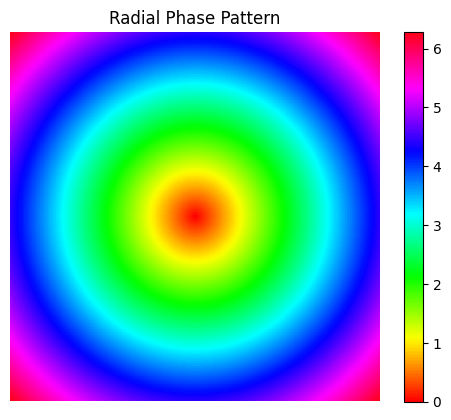

In [ ]:
# Creat a figure of the array 'radial_pattern' according to the colormap "hsv", 
# setting interpolation as "nearest", aspect ratio as 1:1, and no transparency.
plt.imshow(radial_pattern, cmap="hsv", interpolation="nearest", aspect="equal", alpha=1)
plt.colorbar() # Show colorbar.
plt.title("Radial Phase Pattern") # Set a title.
plt.axis("off") # Hide the axis
# Save the figure as .png file in the folder 'data' without any extra whitespace
plt.savefig("data/radial_pattern.png", bbox_inches="tight", pad_inches=0) 
plt.show() # Show the figure

#### **Function 3: normalize_grayscale_image**

*Source Code*

In [ ]:
def normalize_grayscale_image(input_path, output_path):
    # Read the image
    img = imageio.imread(input_path)

    # Normalize the grayscale image
    normalized_img = img / img.max()

    # Convert the normalized image to 8-bit unsigned integer format
    normalized_img_ubyte = img_as_ubyte(normalized_img)

    # Save the normalized grayscale image as a PNG
    imageio.imsave(output_path, normalized_img_ubyte)

*Explanation*

This function takes the following inputs:
1. `input_path` : The path to the input image file which should be a string.
2. `output_path` : The path to the output image file where the processed image should be saved, should be a string.

This function reads an image from a specified path, storing it as an array of values. The values are then normalized to the range $[0, 1]$ and converted to an unsigned byte format (0-255). Finally, the processed image is saved to another specified path. 

The line `img = imageio.imread(input_path)` reads an image from `input_path`. By narmalizing it, an array of values in the range $[0, 1]$ is output:

In [ ]:
# The path leads to a grayscale image.
input_path = 'data/grayscale image.png' 

# Read the image as an array.
img = imageio.imread(input_path) 

# Normalized the array of the image to the range [0, 1].
normalized_img = img / img.max() 

print('normalized_img =\n', normalized_img)

normalized_img =
 [[[0.04526749 0.04526749 0.04938272]
  [0.04526749 0.04526749 0.04938272]
  [0.04526749 0.04526749 0.04938272]
  ...
  [0.04526749 0.04526749 0.04938272]
  [0.04526749 0.04526749 0.04938272]
  [0.04526749 0.04526749 0.04938272]]

 [[0.04526749 0.04526749 0.04938272]
  [0.0781893  0.08230453 0.08230453]
  [0.07407407 0.07407407 0.0781893 ]
  ...
  [0.90946502 0.90946502 0.90946502]
  [0.88065844 0.88065844 0.88477366]
  [0.85596708 0.8600823  0.8600823 ]]

 [[0.04526749 0.04526749 0.04938272]
  [0.07407407 0.07407407 0.07407407]
  [0.07407407 0.07407407 0.07407407]
  ...
  [0.93415638 0.93415638 0.9382716 ]
  [0.91358025 0.91358025 0.91358025]
  [0.88888889 0.88888889 0.88888889]]

 ...

 [[0.04526749 0.04526749 0.04938272]
  [0.91358025 0.91358025 0.91358025]
  [0.9382716  0.9382716  0.94238683]
  ...
  [0.06584362 0.06584362 0.06584362]
  [0.06995885 0.06995885 0.07407407]
  [0.07407407 0.07407407 0.07407407]]

 [[0.04526749 0.04526749 0.04938272]
  [0.91769547 0.917

C:\Users\shown\AppData\Local\Temp\ipykernel_4180\2356471255.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(input_path)


As abserved, the values are all normalized to the range $[0, 1]$ as expected.

In [ ]:
# Convert the normalized image to 8-bit unsigned integer format(0-255).
normalized_img_ubyte = img_as_ubyte(normalized_img) 

print('normalized_img_ubyte =\n', normalized_img_ubyte)

normalized_img_ubyte =
 [[[ 12  12  13]
  [ 12  12  13]
  [ 12  12  13]
  ...
  [ 12  12  13]
  [ 12  12  13]
  [ 12  12  13]]

 [[ 12  12  13]
  [ 20  21  21]
  [ 19  19  20]
  ...
  [232 232 232]
  [225 225 226]
  [218 219 219]]

 [[ 12  12  13]
  [ 19  19  19]
  [ 19  19  19]
  ...
  [238 238 239]
  [233 233 233]
  [227 227 227]]

 ...

 [[ 12  12  13]
  [233 233 233]
  [239 239 240]
  ...
  [ 17  17  17]
  [ 18  18  19]
  [ 19  19  19]]

 [[ 12  12  13]
  [234 234 235]
  [240 240 240]
  ...
  [ 17  17  17]
  [ 18  18  18]
  [ 18  18  19]]

 [[ 12  12  13]
  [227 227 227]
  [233 233 233]
  ...
  [ 18  18  19]
  [ 19  19  19]
  [ 19  19  19]]]


At the end, the line `imageio.imsave(output_path, normalized_img_ubyte)` saves the last array to a new path specified by the variable `output_path`.

### **Module 2: permittivity_tensors**

This part introduces a series of functions to create permittivity tensor, scattering potential and so on.

#### **Imports**

*Source Code*

In [ ]:
# %% Imports
from typing import Optional, Tuple
import imageio
import jax
import jax.numpy as jnp

*Explanation*

1. `typing` : A powerful tool to support type hints that allow developers to indicate the expected types of variables, function parameters, and return values in their code. It's beneficial in large projects, where it can prevent bugs and make the code easier to understand. `Optional` is one of the type hints which is used to indicate that a value could either be of a specific type or `none `. `Tuple` is used to specify the types of elements in a tuple. A tuple is an immutable sequence of elements that can be of different types.
2. `imageio` : A versatile tool for reading (input) and saving (output) images in various formats. When an image is read using `imageio`, it is stored as an array, allowing for easy manipulation and processing.
3. `jax` : A library designed to facilitate high-performance numerical computing, particularly for machine learning and scientific computing applications. `JAX` enables automatic differentiation, just-in-time (JIT) compilation, and efficient parallelization on both CPUs and GPUs. Additionally, it offers a Numpy-like API (`jax.numpy`).

#### **Function 1: generate_permittivity_tensor**

*Source Code*

In [ ]:
def generate_permittivity_tensor(
    n_o: float, n_e: float, extraordinary_axis: Optional[str] = "x"
):
    """
    Generate the permittivity tensor for a uniaxial anisotropic material.

    Args:
        n_o (float): Ordinary refractive index
        n_e (float): Extraordinary refractive index
        extraordinary_axis (str): Axis which is extraordinary ('x', 'y', or 'z')

    Returns:
        jnp.ndarray: Permittivity tensor with the order of axes as zyx
    """
    epsilon_o = n_o**2
    epsilon_e = n_e**2
    if extraordinary_axis == "z":
        epsilon_tensor = jnp.array(
            [[epsilon_e, 0, 0], [0, epsilon_o, 0], [0, 0, epsilon_o]]
        )
    elif extraordinary_axis == "y":
        epsilon_tensor = jnp.array(
            [[epsilon_o, 0, 0], [0, epsilon_e, 0], [0, 0, epsilon_o]]
        )
    elif extraordinary_axis == "x":
        epsilon_tensor = jnp.array(
            [[epsilon_o, 0, 0], [0, epsilon_o, 0], [0, 0, epsilon_e]]
        )
    else:
        raise ValueError("extraordinary_axis must be one of 'x', 'y', or 'z'")
    return epsilon_tensor

*Explanation*

This function creates a permittivity tensor for an anisotropic material with the following inputs: 
1. `n_o` : $n_o=\sqrt{\varepsilon_0}$ for ordinary refractive index. 
2. `n_e` : $n_e=\sqrt{\varepsilon_e}$ ' for extraordinary refractive index.
3. `extraordinary_axis`: A string indicating the axis that is extraordinary in the material. It can be either $z$, $y$, or $x$, depending on the desired extraordinary axis and permittivity tensor.

For example, if we set `n_o = 1.2`, `n_e = 1.5`, and `extraordinary_axis = 'z'`, the permittivity tensor will have the following form:

In [ ]:
n_o, n_e = 1.2, 1.5
extraordinary_axis = 'z'

# call the function to create the permittivity tensor
permittivity_tensor = generate_permittivity_tensor(n_o, n_e, extraordinary_axis)

print(permittivity_tensor)

[[2.25 0.   0.  ]
 [0.   1.44 0.  ]
 [0.   0.   1.44]]


Permittivity, denoted by $\varepsilon$ is a crucial parameter in electromagenetism. It's a property of material describing how the material respond to an electric field and a measure of the electric polarizability of a dielectric material. A material with high permittivity polarizes more in response to an applied electric field than a material with low permittivity, thereby storing more energy in the material [@Permittivity]. In vacuum, the vacuum permittivity (also called electric constant) $\varepsilon_0$ is approximately $8.854 \times 10^{12} F/m$. 

By the way, there is permeability which is the measure of magnetization produced in a material in response to an applied magnetic field. Permeability is typically represented by $\mu$. The magnetic permeability of vacuum (also called magnetic constant) $\mu_0$ is approximately $4 \times 10^{-7} H/m$ [@Permeability]. By the way, the speed of light in vacuum $c$ is related to the magnetic constant and the electric constant by the equation: 

$$c = \frac{1}{\sqrt{\mu_0 \epsilon_0}} \approx 299,792,458 m/s \tag{2.2.3}$$

The reason for using a tensor to represent the permittivity is that in an anisotropic material (particularly crystals), the atoms have a periodic distribution with different symmetries in different directions. This results in different permittivities along different axes. Since the electric field in Cartesian coordinates also has three components, the permittivity tensor must be a $3 \times 3$ matrix.

However, in general, anisotropic media can be characterized by three independent permittivity elements in the principle coordinate system [@FoMO_Script]:

$$(\varepsilon_{ij}) = \begin{bmatrix} \varepsilon_1(\omega) & 0 & 0 \\
                                        0 & \varepsilon_2(\omega) & 9 \\
                                        0 & 0 & \varepsilon_3(\omega) \end{bmatrix} \tag{2.2.4}$$

where $\omega$ is the angular frequency of the electromagnetic wave, $\varepsilon_1(\omega)$, $\varepsilon_2(\omega)$, and $\varepsilon_3(\omega)$ are the permittivities along the $z$, $y$, and $x$ axes, respectively.

A uniaxial crystal has two crystallographically equivalent directions, which means that two of the permittivity elements are equal. These are called the ordinary dielectric constants, $\epsilon_o$. The third permittivity element, which is different, is called the extraordinary dielectric constant, $\epsilon_e$. Correspondingly, the crystal has ordinary axes and an extraordinary axis, also known as the optical axis.

#### **Function 2: create_homogeneous_phantom**

*Source Code*

In [ ]:
def create_homogeneous_phantom(
    shape: Tuple[int, int, int],
    n_o: float,
    n_e: float,
    extraordinary_axis: Optional[str] = "x",
):
    """
    Create a homogeneous uniaxial anisotropic phantom.

    Args:
        shape (tuple): Shape of the phantom (z, y, x)
        n_o (float): Ordinary refractive index
        n_e (float): Extraordinary refractive index
        extraordinary_axis (str): Axis which is extraordinary ('x', 'y', or 'z')

    Returns:
        jnp.ndarray: 4D array representing the phantom with the
                    permittivity tensor at each voxel
    """
    epsilon_tensor = generate_permittivity_tensor(n_o, n_e, extraordinary_axis)
    phantom = jnp.tile(epsilon_tensor, (*shape, 1, 1))
    return phantom

*Explanation*

The code within this function is responsible for creating a homogeneous uniaxial anisotropic phantom, represented by a 4D array that holds the permittivity tensor at each voxel in a 3D volume. A voxel is a term derived from ' volumetric pixel ', representing a value on a regular grid in three-dimensional space, and it is the smallest unit of a 3D space.

The function takes the following inputs:
1. `shape` : A tuple representing the shape of the phantom (z, y, x). The number (Integer) of voxels in each dimension is given by `shape[0]`, `shape[1]`, and `shape[2]`, respectively.
2. `n_o` : The ordinary refractive index of the material.
3. `n_e` : The extraordinary refractive index of the material.
4. `extraordinary_axis` : A string representing the axis that is extraordinary in the material

The line `epsilon_tensor = generate_permittivity_tensor(n_o, n_e, extraordinary_axis)` calls the Function 1 to generate a permittivity tensor based on the given inputs. 

Next, the line `phantom = jnp.tile(epsilon_tensor, (*shape, 1, 1))` creates a 4D array called `phantom` by replicating the `epsilon_tensor` across the 3D shape specified by `shape` (the `*` operator is used to unpack the `shape` tuple and pass its elements as separate arguments to `jnp.tile()`). As a result, each voxel in the 3D space is assigned the same 3 $\times$ 3 permittivity tensor, making the material homogeneous. The resulting array has a shape of `(z, y, x, 3, 3)`. 

The reason this resulting array is referred to as a 4D array rather than a 5D array is that the last two dimensions `(3, 3)`, which represent the permittivity tensor, are typically interpreted as a single entity associated with each voxel rather than as independent dimensions. Therefore, while the array is technically stored in memory as a 5D array, it's treated as a 4D array conceptually.

To make it more clear, the `jnp.tile(A, reps)` function is used to replicate the array `A` along specific dimensions, with the argument `reps` being a tuple that specifies the number of repetitions for each dimension. In our case, `epsilon_tensor` is the array to be replicated, and `(*shape, 1, 1)` indicates that the array should be repeated `z`, `y`, and `x` times along the first three dimensions, and 1 time along the fourth and fifth dimensions (This ensures that the 3 $\times$ 3 structure of `epsilon_tensor` is preserved).

For example, if we set `shape = (1, 2, 3)`, `n_0 = 1.2`, `n_e = 1.5`, `extraordinary_axis = 'z'`, the resulting phantom will have the following shape:

In [ ]:
shape = (1, 2, 3)
n_o, n_e = 1.2, 1.5
extraordinary_axis = 'z'

# call the function to create the homogeneous phantom
phantom = create_homogeneous_phantom(shape, n_o, n_e, extraordinary_axis)

print('shape of the phantom =', phantom.shape)
print('phantom = \n', phantom)

shape of the phantom = (1, 2, 3, 3, 3)
phantom = 
 [[[[[2.25 0.   0.  ]
    [0.   1.44 0.  ]
    [0.   0.   1.44]]

   [[2.25 0.   0.  ]
    [0.   1.44 0.  ]
    [0.   0.   1.44]]

   [[2.25 0.   0.  ]
    [0.   1.44 0.  ]
    [0.   0.   1.44]]]


  [[[2.25 0.   0.  ]
    [0.   1.44 0.  ]
    [0.   0.   1.44]]

   [[2.25 0.   0.  ]
    [0.   1.44 0.  ]
    [0.   0.   1.44]]

   [[2.25 0.   0.  ]
    [0.   1.44 0.  ]
    [0.   0.   1.44]]]]]


#### **Function 3: create_calcite_crystal**

*Source Code*

In [ ]:
def create_calcite_crystal(
    shape: Tuple[int, int, int], extraordinary_axis: Optional[str] = "z"
):
    """
    Create a calcite crystal phantom.

    Args:
        shape (tuple): Shape of the phantom (z, y, x)
        extraordinary_axis (str): Axis which is extraordinary ('x', 'y', or 'z')

    Returns:
        jnp.ndarray: 4D array representing the phantom with the
                    permittivity tensor at each voxel
    """
    n_o = 1.658
    n_e = 1.486
    return create_homogeneous_phantom(shape, n_o, n_e, extraordinary_axis)

*Explanation*

This function creates a calcite crystal phantom by calling the function `create_homogeneous_phantom` and based on the given inputs:
1. `shape` : A tuple representing the shape of the phantom (z, y, x). The number (Integer) of voxels in each dimension is given by `shape[0]`, `shape[1]`, and `shape[2]`, respectively.
2. `extraordinary_axis` : A string representing the axis that is extraordinary in the material.
The function uses the given ordinary refractive index `n_o` and extraordinary refractive index `n_e` to generate the phantom by simply calling the `create_homogeneous_phantom` function.

Let's create a calcite crystal phantom with a shape of (2, 2, 2), and an extraordinary axis of 'z':

In [ ]:
shape = (2, 2, 2)
extraordinary_axis = 'z'

# call the function to create the calcite crystal phantom
calcite_crystal = create_calcite_crystal(shape, extraordinary_axis)

print('shape of the calcite crystal phantom =', calcite_crystal.shape)
print('calcite_crystal =\n', calcite_crystal)

shape of the calcite crystal phantom = (2, 2, 2, 3, 3)
calcite_crystal =
 [[[[[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]

   [[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]]


  [[[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]

   [[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]]]



 [[[[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]

   [[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]]


  [[[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]

   [[2.208196 0.       0.      ]
    [0.       2.748964 0.      ]
    [0.       0.       2.748964]]]]]


#### **Function 4: create_scattering_potential**

*Source Code*

In [ ]:
def create_scattering_potential(permittivity_tensor, background_permittivity):
    """
    Create the scattering potential from the permittivity tensor.

    Args:
        permittivity_tensor (jnp.ndarray): The permittivity tensor of the material.
        background_permittivity (float): The permittivity of the background medium.

    Returns:
        jnp.ndarray: The scattering potential.
    """
    # Calculate the permittivity contrast
    contrast = permittivity_tensor - background_permittivity

    # Scattering potential is proportional to the permittivity contrast
    scattering_potential = contrast / background_permittivity

    return scattering_potential

*Explanation*

This function is designed to calculate the scattering potential for a given phantom taking the inputs: `permittivity_tensor` and `background_permittivity`. The `permittivity_tensor`, which can be generated by Function 1, should be provided as an array.

The code is straightforward. It begins by calculating the `permittivity_contrast`, which is obtained by subtracting the `background_permittivity` from the `permittivity_tensor`. Next, the `scattering_potential` is determined by dividing the `permittivity_contrast` by the `permittivity_tensor`:

In [ ]:
n_o, n_e = 1.2, 1.5
extraordinary_axis = 'z'

# call the function to create the permittivity tensor
permittivity_tensor = generate_permittivity_tensor(n_o, n_e, extraordinary_axis)

background_permittivity = 1.1 # Define the background_permittivity

# Call the function to create the scattering potential
scattering_potential = create_scattering_potential(permittivity_tensor, background_permittivity)

print('scatteriing potential =\n', scattering_potential)

scatteriing potential =
 [[ 1.0454545  -1.         -1.        ]
 [-1.          0.30909094 -1.        ]
 [-1.         -1.          0.30909094]]


Let's dive into the physical background of the code. 

The permittivity contrast here is straightforward, it is the difference between the actual permittivity of the material and the background permittivity. The scattering potential, on the other hand, is a concept used in wave theory to describe how an inhomogeneity or a discontinuity in a medium scatters an incoming wave. 

To derive the methematical expression for the scattering potential, we have to start from Maxwell's equations. We consider a monochromatic electromagnetic field with time dependence $exp(-i \omega t)$, incident on a linear, isotropic, nonmagnetic medium occupying a finite domain with no sources [@Principles_of_Optics]. Then, the Maxwell's equation reads:

$$\nabla \times \textbf{E(r)} = i \omega \textbf{B(r)} \tag{2.1.5} $$  
$$\nabla \cdot \textbf{D(r)} = 0 \tag{2.1.6} $$
$$\nabla \times \textbf{H(r)} = -i \omega \textbf{D(r)} \tag{2.1.7}$$
$$\nabla \cdot \textbf{B(r)} = 0 \tag{2.1.8}$$

Where $\textbf{E(r)}$ and $\textbf{H(r)}$ are the electric and magnetic fields, respectively, $\textbf{D(r)} = \varepsilon_0 \varepsilon(r) \textbf{E(r)}$ is the electric flux density (also called the electric displacement field), and $\textbf{B(r)} = \mu_0 \textbf{H(r)}$ is the magnetic flux density.

By taking the curl of the first equation, we get:

$$\nabla \times (\nabla \times \textbf{E(r)}) = i \omega \mu_0 \nabla \times \textbf{H(r)} \tag{2.1.9}$$

Using the vector identity:

$$\nabla \times (\nabla \times \textbf{E(r)}) = \nabla(\nabla \cdot \textbf{E(r)}) - \nabla^2 \textbf{E(r)} \tag{2.1.10}$$

And:

$$\nabla \times \textbf{H(r)} = -i \omega \textbf{D(r)} = -i \omega \varepsilon_0 \varepsilon(r) \textbf{E(r)} \tag{2.1.11}$$

$$\nabla \cdot \textbf{D(r)} = \varepsilon_0 \varepsilon(r) \nabla \cdot \textbf{E(r)} + \varepsilon_0 \textbf{E(r)} \nabla \varepsilon(r) = 0 \tag{2.1.12}$$

We can get the following equation:

$$\nabla^2 \textbf{E(r)} + \frac{\omega^2}{c^2} \varepsilon(r) \textbf{E(r)} + \nabla \{ \frac{\nabla \varepsilon(r)}{\varepsilon(r)} \cdot \textbf{E(r)} \} = 0 \tag{2.1.13}$$

Where $c$ is the speed of light in free space ($1/c^2 = \mu_0 \varepsilon_0$), and the wavenumber $k = \omega / c$.

We note that the last term on the left of the equation(13) couples the Cartesian components of the electric field. For this reason, the treatment of scattering based on this equation is rather complicated. The equation can be simplified if we assume that the dielectric constant (permittivity) $\varepsilon(r)$ varies so slowly with position that it is effectively constant over distances of the order of the wavelength $\lambda = 2 \pi / k = 2 \pi c / \omega$. Under these circumstances, the last term on the left-hand side of the equation(13) may be neglected. We then obtain the equation [@Principles_of_Opticas]:

$$\nabla^2 \textbf{E(r)} + k^2 \varepsilon(r) \textbf{E(r)} = 0 \tag{2.1.14}$$

Next, we can express the permittivity as the sum of a background permittivity $\varepsilon_B$ and a contrast $\Delta \varepsilon(r)$:

$$\Delta \varepsilon(r) = \varepsilon(r) - \varepsilon_B \tag{2.1.15}$$

Thus, we have:

$$k^2 \varepsilon(r) = k^2(\varepsilon_B + \Delta \varepsilon(r)) = k^2 \varepsilon_B(1 + \frac{\Delta \varepsilon(r)}{\varepsilon_B}) \tag{2.1.16}$$

It will be convenient to re-write equation(14) in the form:

$$\nabla^2 \textbf{E(r)} + k^2 \varepsilon_B \textbf{E(r)} = - k^2 \frac{\Delta \varepsilon(r)}{\varepsilon_B} \textbf{E(r)} = - F(r) \textbf{E(r)} \tag{2.1.17}$$

The function $F(r)$ is usually called the $\textbf{scattering potential}$ of the medium. Since $k$ is constant for a monochromatic wave, calculating the $\Delta \varepsilon(r) / \varepsilon_B$ is sufficient to determine the scattering potential. This is why the code includes the line: `scattering_potential = contrast / background_permittivity`.

#### **Function 5: permittivity_tensor_from_pixel**

*Source Code*

In [ ]:
def permittivity_tensor_from_pixel(
    pixel_value, n_o_base=1.55, n_e_base=1.55, scale=0.5
):
    # The difference between n_o and n_e increases with the pixel value
    n_o = n_o_base + scale * pixel_value
    n_e = n_e_base - scale * pixel_value
    return generate_permittivity_tensor(n_o, n_e)

*Explanation*

The function is designed to calculate the ordinary and extraordinary refractive indices `n_o` and `n_e` based on a pixel value and then generates the corresponding permittivity tensor. The function takes the following inputs:
1. `pixel_value` : Represents the pixel intensity value(a measure of brightness or color in an image), which modifies the ordinary refractive index `n_o` and extraoedinary refractive index `n_e` of the material. The pixel value should be first normalized to a range between 0 and 1.
2. `n_o_base` : The base ordinary refractive index, which is default to 1.55.
3. `n_e_base` : The base extraordinary refractive index, which is also default to 1.55.
4. `scale` : A scaling factor that determines how the refractive indices change with the pixel value.

Ordinarily, in a grayscale image, each pixel has a single value representing the intensity of light at that pixel. The value typically ranges from 0 (black) to 255 (white) in 8-bit images. In color images, each pixel consists of multiple values (usually 3 for RGB images), with each value representing the intensity of the Red, Green, and Blue color channels. Each channel’s intensity is typically in the 0-255 range for 8-bit images. However, since refractive indices cannot be very large or negative, we need to normalize the pixel values to a range between 0 and 1.

The line `n_o = n_o_base + scale * pixel_value` calculates the ordinary refractive index, which increases with pixel value. Similarly, the line `n_e = n_e_base + scale * pixel_value` calculates the extraordinary refractive index, which decreases with pixel value. Therefore, an ordinary wave will experience more refraction and an extraordinary wave will experience less refraction.

The function finally call the function `generate_permittivity_tensor` to genearate a permittivity tensor based on a pixel value. For example, if we set the pixel value as 0.78, we will have:

In [ ]:
pixel_value = 0.78
n_o_base, n_e_base = 1.55, 1.55
scale = 0.5

n_o = n_o_base + scale * pixel_value
n_e = n_e_base - scale * pixel_value

tensor_from_pixel = generate_permittivity_tensor(n_o, n_e)

print('tensor_from_pixel = \n', permittivity_tensor_from_pixel)

tensor_from_pixel = 
 <function permittivity_tensor_from_pixel at 0x0000023D306449A0>


#### **Function 6: vectorized_permittivity_tensor_from_pixel**

*Source Code*

In [ ]:
def vectorized_permittivity_tensor_from_pixel(
    img, n_o_base=1.55, n_e_base=1.55, scale=0.5
):
    vmap_func = jax.vmap(
        lambda pixel: permittivity_tensor_from_pixel(pixel, n_o_base, n_e_base, scale)
    )
    return jax.vmap(vmap_func)(img)

*Explanation*

This function aims to vectorize the `permittivity_tensor_from_pixel` function to operate on an entire 2D image using the `jax.vmap` function, where each pixel in the image is treated as an individual scalar value that is passed to the `permittivity_tensor_from_pixel` function. The function takes the following inputs:
1. `img`: An normalized array which can be read from an image using `imageio.imread()`.
2. `n_o_base` : The base ordinary refractive index, which is default to 1.55.
3. `n_e_base` : The base extraordinary refractive index, which is also default to 1.55.
4. `scale` : A scaling factor that determines how the refractive indices change with the pixel value.

In the code, a new function `jax.vmap` is used. It's a function in the JAX library that allows you to vectorize a function, meaning it can automatically apply a function over arrays in a batched manner. Instead of manually writing loops to apply a function to every element of an array, `jax.vmap` helps you apply the function efficiently to each element or batch of elements in parallel.

For example, we define a function that adds one to the input and call it to do a simple test:

In [ ]:
# Define a function that returns 1 if x >= 0, otherwise 0
def threshold_func(x):
    return jnp.where(x >=0, 1, 0)

# Call the function
x = threshold_func(1)

print('x =', x)

x = 1


Now, we apply this function to each element of an array using `jax.vmap` and use the vectorized function to do a test:

In [ ]:
# Define an array
x_array = jnp.array([-1, 2, -3, 4, -5])

# Vectorizing the function with vmap:
vectorized_threshold = jax.vmap(threshold_func)
# Call the vectorized function
result_vectorized = vectorized_threshold(x_array)

print(result_vectorized)

[0 1 0 1 0]


`lambda pixel: permittivity_tensor_from_pixel(pixel, n_o_base, n_e_base, scale)` is an anonymous function (lambda function) that takes a single argument `pixel`. For each pixel, it calls `permittivity_tensor_from_pixel(pixel, n_o_base, n_e_base, scale)`, which means it computes the permittivity tensor for specific pixels using the provided values (n_o_base, n_e_base, scale) and passing in the `pixel` value.

The `lambda` function in Python is a way to create small, nameless functions. It's often used when you need a simple function for a short operation, without formally defining it using the `def` keyword. The general syntax of a lambda function is `lambda arguments: expression`. For example, we can create a lambda function that adds 1 to a number:

In [ ]:
# Create a lambda function that adds one to the input
add_one = lambda x: x + 1
print('add_one =', add_one(1))

add_one = 2


The first `jax.vmap()` in the source code wraps the lambda function which operates on a single pixel, and transforms it into a vectorized function `vamap_func` that can handle a row of pixels at once. 

The second one, namely, `jax.vmap(vmap_func)(img)` creates a vectorized version of the function `vmap_func`. Since `vmap_func` is already a function that processes a 1D array of pixels, `jax.vmap(vmap_func)` transforms it into a new function that processes a 2D array(e.g. an entire image). The second set of parentheses applies the vectorized function to the input data `img`.

Let's calculate the permittivity tensors supposing we have a 2 $\times$ 2 image `img` like this:

In [ ]:
# Create an array of a 2x2 image
img = jnp.array([[0.28, 0.33], 
                 [0.77, 0.66]])

# Call the vectorized function to the image
tensor = vectorized_permittivity_tensor_from_pixel(img)

print('tensor =\n', permittivity_tensor)

tensor =
 [[2.25 0.   0.  ]
 [0.   1.44 0.  ]
 [0.   0.   1.44]]


The result is a 4D array of shape `(2, 2, 3, 3)`, since each pixel is converted into a `3x3` tensor. The first and second `2` represent the number of rows and columns in the original image respectively, and the first and second `3` represent the first and second dimension of the 3x3 permittivity tensor respectively for each pixel.

#### **Function 7: create_homogeneous_scattering_potential** 

*Source Code*

In [ ]:
def create_homogeneous_scattering_potential(
    shape: Tuple[int, int, int], n_o: float, n_e: float, background_permittivity: float
):
    """
    Create a homogeneous uniaxial anisotropic scattering potential.

    Args:
        shape (tuple): Shape of the phantom (z, y, x)
        n_o (float): Ordinary refractive index
        n_e (float): Extraordinary refractive index
        background_permittivity (float): Background permittivity

    Returns:
        jnp.ndarray: 4D array representing the scattering potential
    """
    permittivity_tensor = create_homogeneous_phantom(shape, n_o, n_e)
    scattering_potential = create_scattering_potential(
        permittivity_tensor, background_permittivity
    )
    return scattering_potential

*Explanation*

This function aims to generate a homogeneous unaxial anisotropic scattering potential for a given 3D shape by simply calling the defined functions `create_homogeneous_phantom` and `create_scattering_potential`. The function takes the following inputs:
1. `shape` : A tuple representing the shape of the phantom (z, y, x). The number (Integer) of voxels in each dimension is given by `shape[0]`, `shape[1]`, and `shape[2]`, respectively.
2. `n_o` : The ordinary refractive index of the material.
3. `n_e` : The extraordinary refractive index of the material.
4. `background_permittivity` : Background permittivity of the medium. The scattering potential is calculated based on the difference between the permittivity of the material and the background permittivity.

For example:

In [ ]:
shape = (1, 2, 3)
n_o, n_e = 1.25, 1.55
background_permittivity = 1.2

# Call the function to create the homogeneous scattering potential
scattering_potential = create_homogeneous_scattering_potential(shape, n_o, n_e, background_permittivity)

print('scattering_potential =\n', scattering_potential)

scattering_potential =
 [[[[[ 0.30208328 -1.         -1.        ]
    [-1.          0.30208328 -1.        ]
    [-1.         -1.          1.0020832 ]]

   [[ 0.30208328 -1.         -1.        ]
    [-1.          0.30208328 -1.        ]
    [-1.         -1.          1.0020832 ]]

   [[ 0.30208328 -1.         -1.        ]
    [-1.          0.30208328 -1.        ]
    [-1.         -1.          1.0020832 ]]]


  [[[ 0.30208328 -1.         -1.        ]
    [-1.          0.30208328 -1.        ]
    [-1.         -1.          1.0020832 ]]

   [[ 0.30208328 -1.         -1.        ]
    [-1.          0.30208328 -1.        ]
    [-1.         -1.          1.0020832 ]]

   [[ 0.30208328 -1.         -1.        ]
    [-1.          0.30208328 -1.        ]
    [-1.         -1.          1.0020832 ]]]]]


As the result shows, the function returns an array with a shape of `(1, 2, 3, 3, 3)`. The dimensions `1`, `2`, `3` represent the number of voxels along $z$, $y$, and $x$ directions respectively. The two trailing `3`s correspond to the two dimensions of the permittivity tensors for each voxel. In other words, each voxel in the `shape` is converted to a 2D array representing its permittivity tensor.

#### **Function 8: process_image_to_epsilon_r**

*Source Code*

In [ ]:
def process_image_to_epsilon_r(input_path, n_o=1.658, n_e=1.486):
    img = imageio.imread(input_path)
    img = img / img.max()
    jax_img = jnp.array(img)

    n_avg = (n_o + n_e) / 2
    scale = (n_o - n_e) / 2
    epsilon_img = vectorized_permittivity_tensor_from_pixel(
        jax_img, n_avg, n_avg, scale
    )

    # Tile the epsilon tensor
    epsilon_r = jnp.tile(epsilon_img, (10, 1, 1, 1, 1))

    return epsilon_r

*Explanation*

The function is designed to process an image and convert it into an array of permittivity tensors for further calculations such as being calculated as background permittivity. The function takes three inputs:
1. `input_path` : The file path of the image to be processed.
2. `n_o` : The ordinary refractive index (default = 1.658).
3. `n_e` : The extraordinary refractive index (default = 1.486).

To process an image to `epsilon_r`, the image is first read from `input_path` using `imageio.imread` as an array of pixel values (normally, 0-255). These pixel values are then nromalized by dividing them by the maximum value in the image (`img = img / img.max()`), which results in an array of values scaled between 0 and 1. And the normalized image is converted into a JAX array (`jax_img = jnp.array(img)`).

Then, the code calculates the average refractive index (`n_avg`) and the scaling factor (`scale`) based on the given ordinary and extraordinary refractive index. Next, the code calls the function `vectorized_permittivity_tensor_from_pixel` to apply to the `jax_img` array, using the calculated `n_avg` and `scale`, which convertes the pixel values into permittivity tensors for each pixel.

Finally, the code tiles the epsilon tensor by repeating it 10 times along the first dimension using `jax.tile()`. As the first dimenstion is $z$ direction, the tiling is actually adding depth to the image. And the other dimensions `(1, 1, 1, 1)` indicates that no tiling is done along other dimensions which is $y$, $x$, and the $3 \times 3$ tensor elements.

Suppose we have a normalized $2 \times 2$ array representing a grayscale image with only 4 pixels, and then calculate the `epsilon_img` and `epsilon_r`:

In [ ]:
# Crear a 2 x 2 image array.
jax_img = jnp.array([[0.353, 0.781], [0.169, 0.882]])

# Calculate n_avg and scale.
n_o, n_e = 1.658, 1.486
n_avg = (n_o + n_e) / 2
scale = (n_o - n_e) / 2

# Call the Function 6 to create the epsilon tensor.
epsilon_img = vectorized_permittivity_tensor_from_pixel(jax_img, n_avg, n_avg, scale)

print('epsilon_img =\n', epsilon_img)

epsilon_img =
 [[[[2.5675511 0.        0.       ]
   [0.        2.5675511 0.       ]
   [0.        0.        2.3766603]]

  [[2.686865  0.        0.       ]
   [0.        2.686865  0.       ]
   [0.        0.        2.2645257]]]


 [[[2.5170903 0.        0.       ]
   [0.        2.5170903 0.       ]
   [0.        0.        2.4257004]]

  [[2.7154164 0.        0.       ]
   [0.        2.7154164 0.       ]
   [0.        0.        2.2384589]]]]


In [ ]:
# Calculate epsilon_r
epsilon_r = jnp.tile(epsilon_img, (10, 1, 1, 1, 1))

print('shape of epsilon_r =', epsilon_r.shape)
print('epsilon_r =\n', epsilon_r)

shape of epsilon_r = (10, 2, 2, 3, 3)
epsilon_r =
 [[[[[2.5675511 0.        0.       ]
    [0.        2.5675511 0.       ]
    [0.        0.        2.3766603]]

   [[2.686865  0.        0.       ]
    [0.        2.686865  0.       ]
    [0.        0.        2.2645257]]]


  [[[2.5170903 0.        0.       ]
    [0.        2.5170903 0.       ]
    [0.        0.        2.4257004]]

   [[2.7154164 0.        0.       ]
    [0.        2.7154164 0.       ]
    [0.        0.        2.2384589]]]]



 [[[[2.5675511 0.        0.       ]
    [0.        2.5675511 0.       ]
    [0.        0.        2.3766603]]

   [[2.686865  0.        0.       ]
    [0.        2.686865  0.       ]
    [0.        0.        2.2645257]]]


  [[[2.5170903 0.        0.       ]
    [0.        2.5170903 0.       ]
    [0.        0.        2.4257004]]

   [[2.7154164 0.        0.       ]
    [0.        2.7154164 0.       ]
    [0.        0.        2.2384589]]]]



 [[[[2.5675511 0.        0.       ]
    [0.        2.5675

As the result shows, the shape of `epsilon_r` is `(10, 2, 2, 3, 3)`. The shape indicates that there are ten `epsilon_img`s in the `epsilon_r` along $z$ direction, each `epsilon_ing` consists of two rows and two columns of tensors, and each tensor consists of three rows and three columns of values.

#### **Function 9: calc_scattering_potential**

*Source Code*

In [ ]:
def calc_scattering_potential(epsilon_r, refractive_index, wavelength):
    """
    Create the scattering potential from the permittivity tensor.

    Args:
        epsilon_r (jnp.ndarray): The permittivity tensor of the material.
        refractive_index (float): The refractive index of the background medium.
        wavelength (float): The wavelength of the light (microns).

    Returns:
        jnp.ndarray: The scattering potential.
    """
    k_0 = 2 * jnp.pi / wavelength
    vol_shape = epsilon_r.shape[:3]
    epsilon_m = jnp.tile(jnp.eye(3) * refractive_index**2, (*vol_shape, 1, 1))
    scattering_potential = k_0**2 * (epsilon_m - epsilon_r)
    return scattering_potential

*Explanation*

The function calculates the scattering potential from a given permittivity tensor (`epsilon_r`), refractive index, and wavelength:
1. `epsilon_r` : The permittivity tensor of the material, which should be a 3D JAX array where each voxel contains a $3 \times 3$ matrix.
2. `refractive_index` : The refractive index of the medium.
3. `wavelength` : The wavelength of the incident light, in microns.

`k_0 = 2 * jnp.pi / wavelength` aims to calculate the wavenumber $k_0$ according to the equation:
$$
k_0 = \frac{\omega}{c} = \frac{2 \pi c}{\lambda} \cdot \frac{1}{c} = \frac{2 \pi}{\lambda}\tag{2.1.18}
$$
In the physical science, the wavenumber, also known as repetency is the spatial frequency of a wave, measured in cycles per unit distance (ordinary wavenumber, $1/\lambda$) or radians per unit distance (angular distance, $2 \pi /\lambda$).[@Wavenumber]

The line `vol_shape = epsilon_r.shape[:3]` extracts the spatial dimensions of `epsilon_r`, which has the shape `(z, y, x, 3, 3)`, because we then need to create an array of background permittivity `epsilon_m`, with matching spatial dimensions, ensuring it has the same shape as volume represented by `epsilon_r`.

`epsilon_r.shape` creates an array returns the shape of the `epsilon_r` array. `epsilon_r.shape[:3]` selects only the first three dimensions of the array shape, which is `z`, `y`, `x`. For example, if the `epsilon_r` has a shape `(4, 5, 6, 3, 3)`:

In [ ]:
# Define a shape of the epsilon_r tensor.
epsilon_r_shape = (4, 5, 6, 3, 3)

#Extract the volume shape from the tensor
vol_shape = epsilon_r_shape[:3]

print('vol_shape =', vol_shape)

vol_shape = (4, 5, 6)


Similarly, we can select any dimensions from the shape:

In [ ]:
# Select the last two dimensions of the shape.
permittivity_shape = epsilon_r_shape[3:]
print('permittivity_shape =', permittivity_shape)

# Select the three dimensions in the middle of the shape.
middle_shape = epsilon_r_shape[1:4]
print('middle_shape =', middle_shape)

permittivity_shape = (3, 3)
middle_shape = (5, 6, 3)


The line `epsilon_m = jnp.tile(jnp.eye(3) * refractive_index**2, (*vol.shape, 1, 1))` create an array of background permittivity tensor using the function `jnp.tile()` in a volume of a given shape (`vol.shape`).

`jnp.eye(3)` generates a 3 $\times$ 3 identity matrix, which is then scaled by the square of the refractive index. This operation produces a diagonal matrix where each diagonal element is equal to `refractive_index**2`: 

In [ ]:
refractive_index = 1.33

diag_matrix = jnp.eye(3) * refractive_index**2

print('diag_matrix =\n', diag_matrix)

diag_matrix =
 [[1.7689 0.     0.    ]
 [0.     1.7689 0.    ]
 [0.     0.     1.7689]]


Next, `jnp.tile()` is employed to replicate the matrix throughout the volume defined by `vol_shape`, resulting in a tensor with the shape `(*vol_shape, 3, 3)`.

In the end, the `scattering_potential` is calculated based on a slightly different definition:
$$
F(r) = k_0^2 (\varepsilon_B - \varepsilon_r) \tag{2.1.19}
$$


#### **Function 10: expand_potential_dims**

*Source Code*

In [ ]:
def expand_potential_dims(tensor):
    potential = jnp.expand_dims(tensor, axis=(1, 4))
    return potential

*Explanation*

The code defines a function which expands the dimension of the input tensor using `jnp.expand_dims()`. This function inserts two additional dimensions into the input `tensor` at the positions specified by the `axis`.

The expression `axis=(1, 4)` indicates that two new dimensions will be inserted at axis 1 (second position) and axis 4 (fifth position). For instance, consider the variable `phantom` in Function 2, which has the shape `(1, 2, 3, 3, 3)`. Let's insert two additional dimensions into it:

In [ ]:
# Assign the phantom tensor to the variable `tensor`
tensor = phantom
print('shape of the tensor =', tensor.shape)

# Expand the dimensions of the tensor
potential = jnp.expand_dims(tensor, axis=(1, 4))
print('shape of the potential =', potential.shape)

shape of the tensor = (1, 2, 3, 3, 3)
shape of the potential = (1, 1, 2, 3, 1, 3, 3)


It's clear that the function returns the modified tensor, which now has two singleton dimensions at the second and fifth position of the modified tensor.

#### **Function 11: generate_dummy_potential**

*Source Code*

In [ ]:
def generate_dummy_potential(vol_shape):
    potential = expand_potential_dims(jnp.ones((*vol_shape, 3, 3)))
    return potential

*Explanation*

The function is employed to create a tensor filled with ones, having a shape based on the input `vol_shape`, and then expands its dimensions using the previously defined `expand_potential_dims` function.

The input `vol_shape` should be a tuple defining the 3D dimensions. `3, 3` adds two additional dimensions for a 3 $\times$ 3 matrix at each point in the volume. The function `jnp.ones()` generates a tensor filled with ones. Suppose `vol_shape = (1, 2, 3)`, then:

In [ ]:
# Define the shape of the volume.
vol_shape = (1, 2, 3)

# Call the function to generate the dummy potential.
potential = expand_potential_dims(jnp.ones((*vol_shape, 3, 3)))
print('shape of the potential =', potential.shape)
print('potential =\n', potential)

shape of the potential = (1, 1, 2, 3, 1, 3, 3)
potential =
 [[[[[[[1. 1. 1.]
      [1. 1. 1.]
      [1. 1. 1.]]]


    [[[1. 1. 1.]
      [1. 1. 1.]
      [1. 1. 1.]]]


    [[[1. 1. 1.]
      [1. 1. 1.]
      [1. 1. 1.]]]]



   [[[[1. 1. 1.]
      [1. 1. 1.]
      [1. 1. 1.]]]


    [[[1. 1. 1.]
      [1. 1. 1.]
      [1. 1. 1.]]]


    [[[1. 1. 1.]
      [1. 1. 1.]
      [1. 1. 1.]]]]]]]


## **Package: functional**

This package is tightly connected to the Elements package. This package provides the building blocks (low-level functions) to construct elements (high-level components) in the Element package. Meanwhile, this package offers greater control and flexibility for custom configurations and possible improvements.

These low-level functions are responsible for performing individual operations like computations and transformations for high-level components. The high-level components encapsulate certain low-level functions to become specific component like lenses, phase masks, and propagation mentioned in the last package. These components can have trainable attributes to make them possible for training and optimization in a neural network

### **Module 1: \_\_init\_\_**

#### **Imports**

*Source Code*

In [ ]:
from .amplitude_masks import *
from .convenience import optical_fft
from .lenses import *
from .phase_masks import *
from .polarizers import *
from .propagation import *
from .pupils import *
from .samples import *
from .sensors import *
from .sources import *

*Explanation*

The `__init__` is for package initialization, function aggregation and namespace management.

This module tells Python that the directory should be treated as a package so that the modules and functions can be imported correctly. It also allows users to import this package simply by typing `import chromatix.functional` rather than import every function with corresponding commands. Besides, it simplifies imports by letting users can import functions without knowing the structure. For example, a user can directly import a function by typing: 

`from chromatix.functional import amplitude_change` 

instead of: 

`from chromatix.functional.amplitude_mask import amplitude_change`


### **Module 2: amplitude_masks**

#### **Imports**

*Source Code*

In [ ]:
import jax.numpy as jnp
from chex import Array, assert_rank

from ..field import Field
from ..utils.shapes import _broadcast_2d_to_spatial

__all__ = ["amplitude_change"]

*Explanation*

`chex.Array` is kind of different from normal `Array`. `chex.Array` is designed to work within the JAX ecosystem, so, to create a `chex.Array`, it's better to use `jax.numpy` rather than `numpy`.

`chex.assert_rank(array, rank)` ensures that an array has a specific rank (number of dimensions). If the `array`'s rank is not equal to `rank`, then an `AssertionError` will be returned:

In [40]:
from chex import Array, assert_rank
import jax.numpy as jnp

an_array = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

assert_rank(an_array, 2)

`Field` is a container describing the chromatic light field at a 2D plane. It's defined as a class with four attributes which are `u` representing the complex field, `_dx` representing the spacing of the sample in `u` to discretizing a continuous field, `_spectrum` representing the wavelengths, and `_spectral_density` representing the weights of the wavelengths.

The function `_broadcast_2d_to_spatial(x, ndim)` is used to broadcast the input 2D array `x` to an array with `ndim` dimensions. The additional dimensions are added as `1`s.

#### **Function 1: amplitude_change**

*Source Code*

In [41]:
def amplitude_change(field: Field, amplitude: Array) -> Field:
    """
    Perturbs ``field`` by ``amplitude``.

    Returns a new ``Field`` with the result of the perturbation.

    Args:
        field: The complex field to be perturbed.
        amplitude: The amplitude to apply.
    """
    amplitude = _broadcast_2d_to_spatial(amplitude, field.ndim)
    assert_rank(
        amplitude,
        field.ndim,
        custom_message="Amplitude must have same ndim as incoming ``Field``.",
    )
    return field * amplitude.astype(jnp.complex64)

*Explanation*

This function perturbs a `Field` object by a given `amplitude`. To perturb a `field` by a `amplitude`, you only need to multiply the `field` by the `amplitude` elements by elements. However, in Python, only when the two arrays have the same rank, the element-wise multiplication can be performed.

A `field` has the shape of `(B... H W C [1 | 3])`, but a `amplitude`'s shape is `(H W)`. Therefore, they have different ranks, and the `amplitude` should be broadcast to the same rank as the `field` by calling the function `_broadcast_2d_to_spatial()`.

Then, the function `assert_rank()` is called to make sure the broadcast `amplitude` has the same rank as the `field`. Finally, the perturbation is performed by multiplying `field` by the `amplitude`. `amplitude.astype(jnp.complex)` casts the `amplitude` array to a complex type `(jnp.complex64)` to match the type of `field`.

Suppose we have a `field` and a `amplitude` like this:

In [ ]:
from chromatix.utils import _broadcast_2d_to_spatial
from chromatix.field import Field
import jax.numpy as jnp

# Create a 2D complex array (H, W)
u_hw = jnp.array([[1 + 1j, 2 + 2j, 3 + 3j], 
                  [4 + 4j, 5 + 5j, 6 + 6j], 
                  [7 + 7j, 8 + 8j, 9 + 9j]])

# Reshape to (1, H, W, 1, 1)
u = u_hw[jnp.newaxis, :, :, jnp.newaxis, jnp.newaxis]

field = Field(
    u = u,
    _dx = jnp.array([[0.01], [0.01]]),# Shape of _dx: (2, 1)
    _spectrum = jnp.array([0.55]),
    _spectral_density = jnp.array([1.0])
)
print("The number of dimensions of the field =", field.ndim)
print("shape of field =", field.shape)

# Define the amplitude
amplitude = jnp.array([[0.9, 0.8, 0.7], [0.6, 0.5, 0.4], [0.3, 0.2, 0.1]])
print("shape of amplitude =", amplitude.shape)

# Try _broadcast_2d_to_spatial
broadcast_amp = _broadcast_2d_to_spatial(amplitude, field.ndim)
print("shape of broadcast_amp =", broadcast_amp.shape)
print("broadcast_amp of the type jnp.complex64 =\n", broadcast_amp.astype(jnp.complex64))


The number of dimensions of the field = 5
shape of field = (1, 3, 3, 1, 1)
shape of amplitude = (3, 3)
shape of broadcast_amp = (1, 3, 3, 1, 1)
broadcast_amp of the type jnp.complex64 =
 [[[[[0.9+0.j]]

   [[0.8+0.j]]

   [[0.7+0.j]]]


  [[[0.6+0.j]]

   [[0.5+0.j]]

   [[0.4+0.j]]]


  [[[0.3+0.j]]

   [[0.2+0.j]]

   [[0.1+0.j]]]]]


Then apply the `amplitude_mask` to the `field`:

In [42]:
perturbed_field = amplitude_change(field, amplitude)
print("shape of the perturbed_field =", perturbed_field.shape)
print("perturbed_field =\n", perturbed_field)

shape of the perturbed_field = (1, 3, 3, 1, 1)
perturbed_field =
 Field(u=Array([[[[[0.9       +0.9j       ]],

         [[1.6       +1.6j       ]],

         [[2.1       +2.1j       ]]],


        [[[2.4       +2.4j       ]],

         [[2.5       +2.5j       ]],

         [[2.4       +2.4j       ]]],


        [[[2.1000001 +2.1000001j ]],

         [[1.6       +1.6j       ]],

         [[0.90000004+0.90000004j]]]]], dtype=complex64), _dx=Array([[0.01],
       [0.01]], dtype=float32), _spectrum=Array([0.55], dtype=float32), _spectral_density=Array([1.], dtype=float32))


`[2.1000001 +2.1000001j ]` and `[0.90000004+0.90000004j]` are due to floating-point precision limitations inherent in numerical computing, especially when working with 32-bit floats like `float32` and `complex64`.

As the result shows, the `field` is perturbed. However, both the real part and the imaginary part of the field is modified which is wrong because only the real part represents the amplitude and the imaginary part represents the phase of the field.

*Correction*

Since the original version of the `amplitude_change` perturbed both the amplitude and the phase of the field, it's necessary to do some revision:

In [43]:
def amplitude_change_revised(field: Field, amplitude: Array):
    """
    Perturbs only the ``amplitude`` of the field with ``amplitude.

    Returns a perturbed ``field`` with modified amplitude and original phase.

    Args:
        field: an object of the class ``Field`` with the complex ``field.u`` to be perturbed.
        amplitude: An array representing the amplitude to apply
    """

    # Broadcast the ``amplitude`` to the same rank as the ``field``
    amplitude = _broadcast_2d_to_spatial(amplitude, field.ndim)
    assert_rank(
        amplitude,
        field.ndim,
        custom_message="Amplitude must have the same ndim as the input ``field``.")
    
    # Extract the real part and imaginary part from the input ``field``
    amp_field = jnp.real(field.u)
    phase_field = jnp.imag(field.u)

    # Compute the perturbed ``field``
    perturbed_field = amp_field * amplitude + 1j * phase_field

    return Field(
        u = perturbed_field,
        _dx = field._dx,
        _spectrum = field._spectrum,
        _spectral_density = field._spectral_density
    )

Let's try this revised function:

In [44]:
print("field =\n", field)
print("amplitude =\n", amplitude)

field =
 Field(u=Array([[[[[1.+1.j]],

         [[2.+2.j]],

         [[3.+3.j]]],


        [[[4.+4.j]],

         [[5.+5.j]],

         [[6.+6.j]]],


        [[[7.+7.j]],

         [[8.+8.j]],

         [[9.+9.j]]]]], dtype=complex64), _dx=Array([[0.01],
       [0.01]], dtype=float32), _spectrum=Array([0.55], dtype=float32), _spectral_density=Array([1.], dtype=float32))
amplitude =
 [[0.9 0.8 0.7]
 [0.6 0.5 0.4]
 [0.3 0.2 0.1]]


In [45]:
perturbed_field = amplitude_change_revised(field, amplitude)
print("perturbed_field =\n", perturbed_field)

perturbed_field =
 Field(u=Array([[[[[0.9       +1.j]],

         [[1.6       +2.j]],

         [[2.1       +3.j]]],


        [[[2.4       +4.j]],

         [[2.5       +5.j]],

         [[2.4       +6.j]]],


        [[[2.1000001 +7.j]],

         [[1.6       +8.j]],

         [[0.90000004+9.j]]]]], dtype=complex64), _dx=Array([[0.01],
       [0.01]], dtype=float32), _spectrum=Array([0.55], dtype=float32), _spectral_density=Array([1.], dtype=float32))


As the result shows, this revised function successfully perturbs the input `field`' amplitude. However, in the class `AmplitudeMask`, a `amplitude` is first binarized and then applied to perturb a `field`. In this case, `amplitude_change` and `amplitude_change_revised` will give two different results: 

In [46]:
from chromatix.ops import binarize

binarized_amp = binarize(amplitude)
print("binarized amplitude =\n", binarized_amp)

perturbed_field1 = amplitude_change(field, binarized_amp)
perturbed_field2 = amplitude_change_revised(field, binarized_amp)

print("perturbed field using original function =\n", perturbed_field1)

binarized amplitude =
 [[1. 1. 1.]
 [1. 0. 0.]
 [0. 0. 0.]]
perturbed field using original function =
 Field(u=Array([[[[[1.+1.j]],

         [[2.+2.j]],

         [[3.+3.j]]],


        [[[4.+4.j]],

         [[0.+0.j]],

         [[0.+0.j]]],


        [[[0.+0.j]],

         [[0.+0.j]],

         [[0.+0.j]]]]], dtype=complex64), _dx=Array([[0.01],
       [0.01]], dtype=float32), _spectrum=Array([0.55], dtype=float32), _spectral_density=Array([1.], dtype=float32))


In [54]:
print("perturbed field using revised function =\n", perturbed_field2)

perturbed field using revised function =
 Field(u=Array([[[[[1.+1.j]],

         [[2.+2.j]],

         [[3.+3.j]]],


        [[[4.+4.j]],

         [[0.+5.j]],

         [[0.+6.j]]],


        [[[0.+7.j]],

         [[0.+8.j]],

         [[0.+9.j]]]]], dtype=complex64), _dx=Array([0.01, 0.01], dtype=float32), _spectrum=Array([0.55], dtype=float32), _spectral_density=Array([1.], dtype=float32))


As the results show, the `phase` of the perturbed fields is different. Therefore, in the case that the binarized amplitude is applied and the phase matters, it's better to use the `amplitude_change`. If the amplitude is not binarized and the phase matters, then `amplitude_change_revised` would be better to use.

### **Module 3: convenience**

#### **Imports**

*Source Code*

In [55]:
import jax.numpy as jnp

from chromatix import Field
from chromatix.utils import _squeeze_grid_to_2d
from chromatix.utils.fft import fft

*Explanation*

`_squeeze_grid_to_2d` is a function to take a higher-dimensional array like `(2 B... H W C [1 | 3])` to 2D array of shape `(2 C)` where `C` is the channel dimension. It's useful for vectorial ops on grids.

`fft` function is defined to perform a 2D Fast Fourier Transform (FFT) on an input array. The Fourier Transform is a mathematical tool that decomposes a function into its constituent frequencies or spatial frequencies. In the context of wave propagation, FT transforms a function between spatial domain and frequency domain. In Photonics, the Fourier Transform is done by:

$$ F(u, v) = \int_{-\infin}^{\infin}f(x, y)e^{-i2\pi (ux+vy)}dxdy \tag{2.3.5} $$

Where, $F(u, v)$ represents a field in spatial frequency domain and $f(x, y)$ represents a field in space domain. And also, there is inverse Fourier Transform:

$$ f(x, y) = \int_{-\infin}^{\infin}F(u, v)e^{i2\pi (ux+vy)}dudv \tag{2.3.5} $$

A Fast Fourier Transform is an algorithm that computes the Discrete Fourier Transform. It reduces the computational complexity fron $O(N^2)$ to $O(NlogN)$, where N is the number of data points. In other words, FFT increases the efficiency of the computation. For example, there is 1D period function: $f(x \pm L) = f(x)$. Let's discretize $x$ into a set of discrete points with period $L$ and step size $\Delta x$:

$$\{x\} = \{0, \Delta x, 2\Delta x, ..., (N-1)\Delta x\} \tag{2.3.3} $$

In the spatial frequency domain, $u$ is discretized into a set of discrete frequencies:

$$\{u\} = \{ 0, 1\cdot \frac{1}{L}, 2 \cdot \frac{1}{L}, ..., [N-1]\frac{1}{L} \} \tag{2.3.4} $$ 

For Fourier transform calculations, it's common to include the interval beyond the last sample. Thus, we have $\frac{L}{\Delta x} = N$, $u = p \cdot \Delta u = \frac {p}{N\Delta x} (0\le n \le N-1 )$, and $x = n\cdot \Delta x$. Then, by discretizing the integral, the Discrete (Fast) Fourier transform can be expressed as:

$$ F(p\Delta u) = \sum_{n=0}^{N-1} e^{-i2\pi \frac{np}{N}}f(n\Delta x)\Delta x \tag{2.3.5} $$

And inverse Discrete (Fast) Fourier Transform:

$$ f(n\Delta x)= \sum_{p=0}^{P-1} e^{i2\pi \frac{np}{N}} F(p\Delta u)\Delta u \tag{2.3.6}$$

This can be extended into 2D FFT and IFFT::

$$ F(p\Delta u, q\Delta v) = \Delta x\Delta y\sum_{n=0}^{N-1}\sum_{m=0}^{M-1} e^{-i2\pi (\frac{np}{N}+\frac{mq}{M})}f(n\Delta x, m\Delta y) \tag{2.3.7} $$
$$ f(n\Delta x, m\Delta y)= \Delta u\Delta v\sum_{p=0}^{P-1}\sum_{q=0}^{Q-1} e^{i2\pi (\frac{np}{N}+\frac{mq}{M})} F(p\Delta u, q\Delta y) \tag{2.3.8}$$

#### **Function 1: optical_fft**

*Source Code*

In [ ]:
def optical_fft(field: Field, z: float, n: float) -> Field:
    """
    Computes the optical ``fft`` or ``ifft`` on an incoming ``Field`` propagated
    by ``z``, depending on the sign of ``z`` (which is a scalar value that may
    be positive or negative). If ``z`` is positive an ``fft```will be performed,
    otherwise an ``ifft`` (due to the ``1 / (lambda * z)`` term in the single
    Fourier transform Fresnel propagation, which requires this behavior).
    The ``ifft`` is calculated in terms of the conjugate of the ``fft`` with
    appropriate normalization applied so that propagating forwards and then
    backwards yields the same ``Field`` up to numerical precision. This function
    also appropriately changes the sampling of the ``Field`` that is output
    (after propagating to some distance ``z``).
    Args:
        field: The ``Field`` to be propagated by ``fft``.
        z: The distance the ``Field`` will be propagated.
        n: Refractive index of the propagation medium.
    Returns:
        The propagated ``Field``, transformed by ``fft``/``ifft``.
    """
    L_sq = field.spectrum * z / n
    du = field.dk * jnp.abs(L_sq)
    # Forward transform normalization for z >= 0
    norm_fft = (z >= 0) * -1j * jnp.prod(field.dx, axis=0, keepdims=False) / L_sq
    # Inverse transform normalization for z < 0
    norm_ifft = (
        (z < 0)
        * -1j  # Sign change because we take the conjugate of the input
        * (L_sq / jnp.prod(du, axis=0, keepdims=False))  # Inverse length scale
        / jnp.prod(
            jnp.array(field.shape)  # Due to a different norm factor for fft and ifft
        )
    )
    # Inverse transform input needs to use the conjugate
    fft_input = (norm_fft * field.u) + (norm_ifft * field.conj.u)
    fft_output = fft(fft_input, axes=field.spatial_dims, shift=True)
    u = (z >= 0) * fft_output + (z < 0) * jnp.conj(fft_output)
    return field.replace(u=u, _dx=_squeeze_grid_to_2d(du, field.ndim))

*Explanation*

1. Fresnel Propagation

This `optical_fft` function performs a Fresnel propagation on a Field object using a Fast Fourier Transform (FFT) or Inverse Fast Fourier Transform (IFFT) depending on the propagation direction.

Suppose there is a field at $z=0$, now, we want to calculate the field which has been propagated by a distance $z$ as the figure below shows:

<img src="Figures\Diffraction_geometry.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

Under the Fresnel approximation, the field after the propagation of a distance $z$ is given by the convolution of the initial field $u_0(x', y', 0)$ and the response function:

$$ h_F(x, y; z) = -\frac{ike^{ikz}}{2\pi z} \exp\frac{ik}{2z}(x^2 + y^2) = \frac{e^{ikz}}{i\lambda z} \exp[\frac{i\pi}{\lambda z}(x^2 + y^2)] \tag{2.3.9} $$

By doing the convolution, the propagated field $u_F(x, y, z)$ can be expressed as:

$$u_F(x, y, z) = \frac{e^{ikz}}{i\lambda z} \iint_{-\infty}^{\infty} u_0(x', y', 0) \exp\lbrace \frac{i\pi}{\lambda z} \left[ (x - x')^2 + (y - y')^2 \right] \rbrace \, dx' \, dy' \tag{2.3.10} $$

Then, we can get rid of the parentheses:

$$ (x - x')^2 + (y - y')^2 = x^2 + y^2 -2(xx' + yy') + x'^2 + y'^2 \tag{2.3.11} $$

in which, $x^2+y^2$ can be moved out of the integral, thus we will get:

$$u_F(x, y, z) = \frac{e^{ikz}}{i\lambda z} e^{\frac{i\pi}{\lambda z}(x^2 + y^2)} \iint_{-\infty}^{\infty} u_0(x', y', 0) e^{\frac{i \pi}{\lambda z} (x'^2 + y'^2)} e^{-i 2\pi \left( \frac{x}{\lambda z} x' + \frac{y}{\lambda z} y' \right)} \, dx' \, dy' \tag{2.3.12} $$

The terms $e^{\frac{i\pi}{\lambda z}(x^2 + y^2)}$ and $e^{\frac{i \pi}{\lambda z} (x'^2 + y'^2)}$ can be interpreted as the quadratic phase factor at the output plane and the input plane.

Now, by regarding $ \frac{x}{\lambda z}$ and $ \frac{y}{\lambda z}$ as $f_x$ and $f_y$, we will have: 

$$u_F(x, y, z) = \frac{e^{ikz}}{i \lambda z} e^{\frac{i \pi}{\lambda z} (x^2 + y^2)} \mathcal{F} \left\{ u_0(x', y', 0) e^{\frac{i \pi}{\lambda z} (x'^2 + y'^2)} \right\} \bigg|_{f_x = \frac{x}{\lambda z}, \; f_y = \frac{y}{\lambda z}} \tag{2.3.13} $$

This Fresnel integral describes free space propagation, which means that the refractive index $n_{eff}=1$. If the propagation happens in a medium, the wavelength $\lambda$ should become $\lambda/n_{eff}$, since the speed of light in the medium is $v=c/n_{eff}$. Therefore, a more general fresnel integral should be:

$$u_F(x, y, z) = \frac{n_{eff}e^{ikz}}{i \lambda z} e^{\frac{i \pi n_{eff}}{\lambda z} (x^2 + y^2)} \mathcal{F} \left\{ u_0(x', y', 0) e^{\frac{i \pi n_{eff}}{\lambda z} (x'^2 + y'^2)} \right\} \bigg|_{f_x = \frac{n_{eff}x}{\lambda z}, \; f_y = \frac{n_{eff}y}{\lambda z}} \tag{2.3.14} $$

Where $e^{ikz}$ represents the propagation phase factor over a distance $z$, the term $\frac{1}{i \lambda z}$ represents the scaling factor due to the propagation distance. Most importantly, $f_x = \frac{n_{eff}x}{\lambda z}$ and $f_y = \frac{n_{eff}y}{\lambda z}$ represents the spatial frequency coordinates in the Fourier transform and from this we can derive the spatial coordinates of the field $u_F$ as $x=\frac{f_x\lambda z}{n_{eff}}$ and $y=\frac{f_y\lambda z}{n_{eff}}$ which means the spatial coordinates is scaled with the distance $z$.

In the FFT algorithm, taking only the $x$ coordinate as an example, if the spatial coordinates of the initial field is:

$$\{x'\} = \{0, \Delta x', 2\Delta x', ..., (N-1)\Delta x'\} \tag{2.3.15} $$

Including the interval beyond the last sample, we have $N$ samples with the total length of $N\Delta x'$ in this case. Then in the spatial frequency domain:

$$\{f_x\} = \{0, \frac{1}{N\Delta x'}, \frac{2}{N\Delta x'}, ..., \frac{N-1}{N\Delta x'}\} \tag{2.3.16} $$

Now, according to $x=\frac{f_x\lambda z}{n_{eff}}$, we can get the $x$ coordinates of the field $u_F$:

$$\{x\} = \{0, \frac{\lambda z}{n_{eff}N\Delta x'}, \frac{2\lambda z}{n_{eff}N\Delta x'}, ..., \frac{(N-1)\lambda z}{n_{eff}N\Delta x'} \} \tag{2.3.17} $$

And the interval becomes:

$$\Delta x = \frac{\lambda z}{n_{eff}N\Delta x'} \tag{2.3.18} $$

Look back into the source code. `field.spectrum` returns the wavelengths sampled by the complex field, so `L_sp` is the factor $\frac{\lambda z}{n_{eff}}$, `field.dk` returns the spatial frequency domain sampling interval, which is mathematically $\frac{1}{N\Delta x'}$, and `du` is thus the new spatial sampling interval at the propagated field, namely the $\Delta x$.

Rather than directly calculating the new spatial coordinates, the code calculates the spatial sampling interval at the propagated field, because the samples are discrete on grids and frequencies are implicitly determined by the sampling intervals and the number of data points, and most importantly, scaling frequencies directly is not straightforward and would require resampling or interpolating the frequency bins, which can introduce errors and is inefficient.

1. Transform Normalization

Next, depending on the direction of $z$, the code calculates the forward transform normalization `norm_fft` and the inverse transform normalization `norm_ifft`.

`(z >= 0)` is a boolean expression that evaluates to `True`(1), when $z\geqslant 0$. `1j` is the imaginary unit. The `jnp.prod()` function calculates the product of array elements over a specified axis. For Example:

In [53]:
from chromatix.field import Field
import jax.numpy as jnp
import jax.random as jran

# Create random keys
key1 = jran.PRNGKey(10)
key2 = jran.PRNGKey(20)

# Create random complex field with shape (10, 10)
u_amp = jran.uniform(key1, shape=(10, 10))
u_phase = jran.uniform(key2, shape=(10, 10))
u = u_amp + 1j * u_phase
u = u.reshape(1, 10, 10, 1, 1)

# Create a Field object
field = Field(
    u = u,
    _dx = jnp.array([[0.01], [0.01]]), # Shape of _dx: (2, 1), 2 rows and 1 column
    _spectrum = jnp.array([0.55]),
    _spectral_density = jnp.array([1.0]),
)

print("Shape of the complex field =", field.u.shape)

print("Spatial sampling intervals dx =\n", field.dx)

prod_dx = jnp.prod(field.dx, axis=0, keepdims=False)
print("Product of the spatial sampling intervals =", prod_dx)


Shape of the complex field = (1, 10, 10, 1, 1)
Spatial sampling intervals dx =
 [[[[[[0.01]]]]]




 [[[[[0.01]]]]]]
Product of the spatial sampling intervals = [[[[[0.0001]]]]]


`Field.dx` is the spacing of the samples in `u` discretizing a continuous field, it's defined as an array of shape `(2 1... 1 1 C 1)`. Thus, the function `jnp.prod()` calculates $\Delta x' \cdot \Delta y'$, which means the area of a single pixel. Therefore, the `norm_fft` is mathematically:

$$ \text{norm\_ fft} = \frac{-i\Delta x \Delta y}{\lambda z} = \frac{\Delta x \Delta y}{i\lambda z} \tag{2.3.19} $$

It's easy to notice that the `norm_fft` is the product of the FFT's coefficient and the Fresnel propagation coefficient ignoring the exponential terms.

In terms of the `norm_ifft`, it's computed in a similar way to `norm_fft`. `(z < 0)` has the same logic with the `(z >= 0)` mentioned before, ensuring that the `norm_ifft` is applied only in the case of backward propagation. Since the code only uses the forward FFT for both forward and inverse transforms (`fft_output = fft(fft_input, axes=field.spatial_dims, shift=True`), it's needed to take the conjugate of the forward FFT input and output to simulate the inverse FFT:

$$ \mathcal{F^{-1}}(f) = \frac{1}{N}(\mathcal{F}(f^*))^* \tag{2.3.20} $$

Where $N$ is the total number of samples. The conjugate operation flips the sign of the imaginary part, so, to adjust the phase accordingly, the code multiply `(z < 0)` with `-1j` instead of `1j`. Then for recovering the sampling interval, `du`, which is `\Delta x` mentioned in 2.3.18, divides the factor `L_sq` and is divide by the total number of samples $N$ (`jnp.prod(jnp.array(field.shape))`) resulting in $\Delta x'$.

3. Applying FFT

Finally, the function `fft` is called to perform the FFT on the product of the input field and the normalization term to figure out the propagated field. 

By the way, all the exponential term $e^{ikz}$, $\exp{[\frac{i \pi n_{eff}}{\lambda z} (x^2 + y^2)]}$, and $\exp{[\frac{-i \pi n_{eff}}{\lambda z} (x'^2 + y'^2)]}$ inside the Fourier Transform are ignored, this is because that ordinarily, we only care about the intensity distribution of a field. When calculating the intensity distribution, these three terms won't change the distribution of the intensities.

Therefore, this function only applies a simplified version of Fresnel propagation:

$$u_F(x, y, z) = \mathcal{F} \left\{ \frac{n_{eff}}{i \lambda z} u_0(x', y', 0)\right\} \bigg|_{f_x = \frac{n_{eff}x}{\lambda z}, \; f_y = \frac{n_{eff}y}{\lambda z}} \tag{2.3.21} $$

The function `field.replace()` is inherited from the class `Field`'s parent class `struct`. `field.replace(u=u, _dx=_squeeze_grid_to_2d(du, field.ndim))` creates a new `Field` object with the updated `u` attribute and the new `_dx` squeezed into 2D. 

4. Limitation of Fresnel Propagation

The Fresnel propagation formula (2.3.13 and 2.3.14) are derived under Fresnel (paraxial) approximation which can be applied when the wavelength of the field is many orders of magnitude smaller than the relevant physical dimensions like the distance of the propagation ($\lambda << z$). To determine whether the Fresnel propagation should be applied, Fresnel number is very useful:

$$ N_F = \frac{a^2}{\lambda z} \tag{2.3.22} $$

Where a is for example radius of the field if the field has a circular shape, and $z$ is the distance of propagation. The Fresnel approximation works well when $N_F \approx 1$ 

### **Module 4: lenses**

#### **Imports**

*Source Code*

In [ ]:
from typing import Optional

import jax.numpy as jnp

from chromatix.functional.convenience import optical_fft

from ..field import Field
from ..utils import l2_sq_norm
from .pupils import circular_pupil

*Explanation*

The function `l2_sq_norm` returns the sums of squares of the elements in an input array along a certain axis, like $x^2 + y^2 + z^2...$. For exapmle:

In [13]:
from chromatix.utils import l2_sq_norm
import numpy as np

a = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])
print("a =  ", a)
sq_a0 = l2_sq_norm(a, axis=0)
sq_a1 = l2_sq_norm(a, axis=1)

print("L2 squared norm along axis 0 =", sq_a0)
print("L2 squared norm along axis 1 =", sq_a1)

a =   [[1 2 3]
 [4 5 6]
 [7 8 9]]
L2 squared norm along axis 0 = [ 66  93 126]
L2 squared norm along axis 1 = [ 14  77 194]


In Python, axis 0 means the "row" axis, Specifying `axis=0` means that the operation will be applied down the rows, effectively working column-wise. `axis=1` means working row-wise.

`circular_pupil` applies a circular mask with a radius $w$ as an input to a field by element-wise multiplication. The regions outside the circular mask are zeroed out leaving only the values within the circle.

#### **Function 1: thin_lens**

*Source Code*

In [ ]:
def thin_lens(field: Field, f: float, n: float, NA: Optional[float] = None) -> Field:
    """
    Applies a thin lens placed directly after the incoming ``Field``.

    Args:
        field: The ``Field`` to which the lens will be applied.
        f: Focal length of the lens.
        n: Refractive index of the lens.
        NA: If provided, the NA of the lens. By default, no pupil is applied
            to the incoming ``Field``.

    Returns:
        The ``Field`` directly after the lens.
    """
    L = jnp.sqrt(field.spectrum * f / n)
    phase = -jnp.pi * l2_sq_norm(field.grid) / L**2

    if NA is not None:
        D = 2 * f * NA / n  # Expression for NA yields width of pupil
        field = circular_pupil(field, D)

    return field * jnp.exp(1j * phase)

*Explanation*

This function is to calculate the field after passing a thin lens. In optics, a thin lens has a negligible thickness compared to the radius curvature of the surface, thus, the optical effects due to the thickness of lens can be ignored. In physical optics, by definition, a thin lens transforms a spherical wave into a plane wave. Under paraxial approximation, the response function that transform a spherical wave into a plane wave is:

$$ t_L(x, y)=\exp[-i\frac{n_{eff}\pi}{\lambda f}(x^2+y^2)] \tag{2.3.23} $$

Suppose there is a field $u_-(x, y)$, after it passes through the thin lens, it becomes:

$$ u_+(x, y) = u_-(x, y)\exp[-i\frac{n_{eff}\pi}{\lambda f}(x^2+y^2)] \tag{2.3.24} $$

Where $n_{eff}$ is the refractive index, and $f$ is the focal length of the thin lens. The equation above also means that the thin lens adds a phase to the incoming field.

This function takes four arguments, in which, `field` represents a field that is going to pass a thin lens, `n` as well as `f` are used to define the thin lens, and `NA` is short for numerical aperture which is a pupil if provided.

`field.spectrum` returns the wavelength of the field, so `L` is equal to $\sqrt{\lambda f/n_{eff} }$. `field.grid` returns $x$ and $y$ grid respectively. This grid assumes that the center of the field is the origin and that the elements are sampling from the center:

In [15]:
from chromatix.field import Field
import jax.numpy as jnp
import jax.random as jran

key = jran.PRNGKey(10)
u = jran.uniform(key, shape=(1, 5, 5, 1, 1))

field = Field(
    u=u,
    _dx=jnp.array([[0.1], [0.1]]),
    _spectrum=jnp.array([0.55]),
    _spectral_density=jnp.array([1.0])
)

print("The wavelength of the field", field.spectrum)

print("The shape of the grid=", field.grid.shape)
# For better display, the grid of the field is squeezed
print("The squeezed grid of the field =\n", field.grid.squeeze())

The wavelength of the field [[[[[0.55]]]]]
The shape of the grid= (2, 1, 5, 5, 1, 1)
The squeezed grid of the field =
 [[[-0.25 -0.25 -0.25 -0.25 -0.25]
  [-0.15 -0.15 -0.15 -0.15 -0.15]
  [-0.05 -0.05 -0.05 -0.05 -0.05]
  [ 0.05  0.05  0.05  0.05  0.05]
  [ 0.15  0.15  0.15  0.15  0.15]]

 [[-0.25 -0.15 -0.05  0.05  0.15]
  [-0.25 -0.15 -0.05  0.05  0.15]
  [-0.25 -0.15 -0.05  0.05  0.15]
  [-0.25 -0.15 -0.05  0.05  0.15]
  [-0.25 -0.15 -0.05  0.05  0.15]]]


The first array is the $y$ grid, each row has the same $y$ value. The second array is the $x$ grid, each column has the same $x$ value.

`l2_sq_norm(field.grid)` compute the $x[i,j]^2+y[i,j]^2$ at each point on the fields grid representing the distance from the center:

In [ ]:
from chromatix.utils import l2_sq_norm

# axis=0 by default, the calculation is applie along batches
distances = l2_sq_norm(field.grid.squeeze())
print("The distances =\n", distances)

The distances =
 [[0.125 0.085 0.065 0.065 0.085]
 [0.085 0.045 0.025 0.025 0.045]
 [0.065 0.025 0.005 0.005 0.025]
 [0.065 0.025 0.005 0.005 0.025]
 [0.085 0.045 0.025 0.025 0.045]]


As a result, together with `jnp.pi` and `L**2`, the phase shift as each point is figured out:

$$ \text{phase} = -\frac{\pi}{L^2}(x[i, j]^2 + y[i, j]^2) \tag{2.3.25} $$

If `NA` is provided, the diameter `D` of the pupil will be calculated from the `NA`:

$$ NA = n_{eff}sin(\theta) = n_{eff}\frac{D}{2f} \tag{2.3.26} $$

By calling the function `circular_pupil()`, any values outside this pupil will be set as zero. Finally, this function returns a field with shifted phase.

#### **Function 2: ff_lens**

*Source Code*

In [ ]:
def ff_lens(
    field: Field,
    f: float,
    n: float,
    NA: Optional[float] = None,
    inverse: bool = False,
) -> Field:
    """
    Applies a thin lens placed a distance ``f`` after the incoming ``Field``.

    Args:
        field: The ``Field`` to which the lens will be applied.
        f: Focal length of the lens.
        n: Refractive index of the lens.
        NA: If provided, the NA of the lens. By default, no pupil is applied
            to the incoming ``Field``.

    Returns:
        The ``Field`` propagated a distance ``f`` after the lens.
    """
    # Pupil
    if NA is not None:
        D = 2 * f * NA / n  # Expression for NA yields width of pupil
        field = circular_pupil(field, D)
    if inverse:
        # if inverse, propagate over negative distance
        f = -f
    return optical_fft(field, f, n)

*Explanation*

The function takes `field`, `f`, `n` and `NA` as arguments, these arguments works as the same as their counterparts in the `thin_lens` function. An additional argument `inverse` is a boolean which determines the direction of propagation. This Finally it returns the field at the focal plane.

This function simulates a situation where a field propagates a distance $f$ to a thin lens, then it passes through the thin lens and then propagates another distance $f$ to the focal plane of the lens. This is a typical $2f$ setup:

<img src="Figures\2f-setup.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

To figure out the field $u(x,y,2f)$, we can directly apply the following formula[@FoMO_Script]:

$$ u(x, y, 2f)=\frac{n_{eff}}{i\lambda f}exp(2ikf)U_0(f_x, f_y) \bigg|_{f_x = \frac{n_{eff}x}{\lambda f}, \; f_y = \frac{n_{eff}y}{\lambda f}} \tag{2.3.27} $$

where $U_0$ is the Fourier transform of the initial field $u_0$, $f$ is the focal length of the thin lens, $n_{eff}$ is the refractive index, and $k=2\pi/\lambda$ is the wavenumber.

With the help of the formula, the code becomee simple. It uses two if-clause to determine whether add a pupil and the direction of the propagation. Then it calls the function `optical_fft()` to do Fourier transform to work out the field at the focal plane.

#### **Function 3: df_lens**

*Source Code*

In [ ]:
def df_lens(
    field: Field,
    d: float,
    f: float,
    n: float,
    NA: Optional[float] = None,
    inverse: bool = False,
) -> Field:
    """
    Applies a thin lens placed a distance ``d`` after the incoming ``Field``.

    Args:
        field: The ``Field`` to which the lens will be applied.
        d: Distance from the incoming ``Field`` to the lens.
        f: Focal length of the lens.
        n: Refractive index of the lens.
        NA: If provided, the NA of the lens. By default, no pupil is applied
            to the incoming ``Field``.

    Returns:
        The ``Field`` propagated a distance ``f`` after the lens.
    """
    if NA is not None:
        D = 2 * f * NA / n  # Expression for NA yields width of pupil
        field = circular_pupil(field, D)

    if inverse:
        # if inverse, propagate over negative distance
        f = -d
        d = -f
    field = optical_fft(field, f, n)

    # Phase factor due to distance d from lens
    L = jnp.sqrt(jnp.complex64(field.spectrum * f / n))  # Lengthscale L
    phase = jnp.pi * (1 - d / f) * l2_sq_norm(field.grid) / jnp.abs(L) ** 2
    return field * jnp.exp(1j * phase)

*Explanation*

This function simulates a more general case of $2f$ setup, where the first $f$ becomes $d$ meaning that the initial field starts from any distance before the thin lens:

<img src="Figures\d-f-setup.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">


The solution to calculate the field at the focal plane is given by Prof. Joseph Wilfred Goodman in his book <em>Introduction to Fourier Optics</em>:

$$u_F(x, y, d+f)=\frac{n_{eff}}{i\lambda f}\exp[i\frac{n_{eff}\pi}{\lambda f}(1-\frac{d}{f})(x^2+y^2)]U_0(f_x, f_y) \bigg|_{f_x=\frac{n_{eff}x}{\lambda f}, f_y=\frac{n_{eff}y}{\lambda f}} \tag{2.3.28} $$

Compared to the formula in the `ff_lens` function, there is an additional phase term. Therefore, besides the same code to do Fourier transform, `phase` is calculated to modify the field:

$$\text{phase} = \pi(1-\frac{d}{f})\frac{x^2+y^2}{\frac{\lambda f}{n_{eff}}} = \frac{n_{eff}\pi}{\lambda f}(1-\frac{d}{f})(x^2+y^2) \tag{2.3.29}$$

### **Module 5: phase_masks**

#### **Imports**

*Source Code*

In [ ]:
from typing import Tuple
import jax
import jax.numpy as jnp
from chex import Array, assert_rank
from chromatix.field import Field
from chromatix.utils.shapes import _broadcast_2d_to_spatial

*Explanation*

`chex.assert_rank(array, rank)` ensures that an array has a specific rank (number of dimensions). If the `array`'s rank is not equal to `rank`, then an `AssertionError` will be returned.

The function `_broadcast_2d_to_spatial(x, ndim)` is used to broadcast the input 2D array `x` to an array with `ndim` dimensions. The additional dimensions are added as `1`s. For example:

In [20]:
from chromatix.utils import _broadcast_2d_to_spatial
import jax.numpy as jnp

arr = jnp.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9]])

bc_arr = _broadcast_2d_to_spatial(arr, ndim=5)
print("Dimensions of the broadcast array =", bc_arr.ndim)
print("Shape of the broadcast array =", bc_arr.shape)
print("The broadcast array =\n", bc_arr)

Dimensions of the broadcast array = 5
Shape of the broadcast array = (1, 3, 3, 1, 1)
The broadcast array =
 [[[[[1]]

   [[2]]

   [[3]]]


  [[[4]]

   [[5]]

   [[6]]]


  [[[7]]

   [[8]]

   [[9]]]]]


#### **Function 1: spectrally_modulate_phase**

*Source Code*

In [ ]:
def spectrally_modulate_phase(phase: Array, field: Field) -> Array:
    """Spectrally modulates a given ``phase`` for multiple wavelengths."""
    central_wavelength = field.spectrum[..., 0, 0].squeeze()
    spectral_modulation = central_wavelength / field.spectrum
    return phase * spectral_modulation

*Explanation*

This function ensures accurate modeling of optical systems involving multiple wavelengths, since the phase response varies with wavelength when propagating. In optics, the phase shift $\phi$ introduced by an optical path difference $\Delta L$ is given by:

$$\phi(\lambda)=\frac{2\pi}{\lambda}\Delta L \tag{2.3.30} $$

If the phase shift of a central wavelength $\lambda_0$ is known, then the phase at any other wavellength $\lambda$ can be expressed as:

$$\phi(\lambda)=\phi_0 \cdot \frac{\lambda_0}{\lambda} \tag{2.3.31}$$

This scaling accounts for the fact that shorter wavelengths accumulate more phase shift over the same optical path difference compared to longer wavelengths.

Therefore, to modulate phases, the function first calculate the `central_wavelength` $\lambda_0$ by calling `field.spectrum[..., 0, 0].squeeze()`. The ellipsis `...` represents all preceding dimensions, it selects all elements along the spectral dimensions in this context. `0, 0` selects the element at the first position along the dimensions. The `squeeze()` removes any singleton dimensions from the array. For example:

In [3]:
from chromatix.field import Field
import jax.numpy as jnp

field = Field(
    u = jnp.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]]),
    _dx = jnp.array([[0.1], [0.1]]),
    _spectrum = jnp.array([0.55, 0.63, 0.71]),
    _spectral_density = jnp.array([1.0, 1.0, 1.0]),
)

print("The spectrum of the field =\n", field.spectrum)
print("The central wavelength of the field =", field.spectrum[..., 0, 0].squeeze())

The spectrum of the field =
 [[0.55]
 [0.63]
 [0.71]]
The central wavelength of the field = 0.55


Then, the next line creates an array of modulation factors (`spectral modulation`) for each wavelength component. Finally, the function returns the product of the input phase and the modulation factor.

#### **Function 2: phase_change**

*Source Code*

In [ ]:
def phase_change(field: Field, phase: Array, spectrally_modulate: bool = True) -> Field:
    """
    Perturbs ``field`` by ``phase`` (given in radians).

    Returns a new ``Field`` with the result of the perturbation.

    Args:
        field: The complex field to be perturbed.
        phase: The phase to apply.
    """
    phase = _broadcast_2d_to_spatial(phase, field.ndim)
    assert_rank(
        phase,
        field.ndim,
        custom_message="Phase must have same ndim as incoming ``Field``.",
    )
    if spectrally_modulate:
        phase = spectrally_modulate_phase(phase, field)
    return field * jnp.exp(1j * phase)

*Explanation*

This function aims to perturb the input `field` by an input `phase` array. To make sure that the multiplication is performed correctly, the `phase` array is broadcast to the same dimension with the input `field` and the function `assert_rank` is used to ensure than the broadcast is right.

Then, if the input `spectrally_modulate` is `True`, the `phase` array is modulated according the wavelengths of the `field` by calling the function `spectrally_modulate_phase`. In the end, the function returns the perturbed field.

#### **Function 3: wrap_phase**

*Source Code*

In [ ]:
@wrap_phase.defjvp
def wrap_phase_jvp(primals: Tuple, tangents: Tuple) -> Tuple:
    return wrap_phase(*primals), tangents[0]

@jax.custom_jvp
def wrap_phase(phase: Array, limits: Tuple[float, float] = (-jnp.pi, jnp.pi)) -> Array:
    """
    Wraps values of ``phase`` to the range given by ``limits``.

    Args:
        phase: The phase mask to wrap (in radians).
        limits: A tuple defining the minimum and maximum value that ``phase``
            will be wrapped to.
    """
    phase_min, phase_max = limits
    phase = jnp.where(
        phase < phase_min,
        phase + 2 * jnp.pi * (1 + (phase_min - phase) // (2 * jnp.pi)),
        phase,
    )
    phase = jnp.where(
        phase > phase_max,
        phase - 2 * jnp.pi * (1 + (phase - phase_max) // (2 * jnp.pi)),
        phase,
    )
    return phase

*Explanation*

`@jax.custom_jvp` is a decorator from JAX to define a function with a custom Jacobian-vector product (JVP) rule. `@wrap_phase.defjvp` is used to define the custom JVP (`wrap_phase_jvp`) for the `wrap_phase` function that has been decorated with `@jax.custom_jvp`. 

After decorating `wrap_phase` with `@jax.custom_jvp`, the function gains the custom JVP which is defined as the function `wrap_phase_jvp` with `@wrap_phase.defjvp`.

The function `wrap_phase_jvp` accepts `primals` and `tangents`. `primals` is a tuple containing the original inputs to `wrap_phase`, namely, `phase` and `limits`. `tangents` is also a tuple containing the tangents (derivatives) of the inputs. This function returns `wrap_phase(*primals)` which is the result of the original `wrap_phase` function applied to the inputs and `tangent[0]`, which is the derivative with respect to the first input (`phase`).

`@jax.custom_jvp` can be very useful when the function includes operations that are not differentiable like wrapping, the default automatic differentiation might fail or gives incorrect gradients.

The `wrap_phase` function serves to adjust phase values so that they fall within a specified range $(-\pi, \pi)$. Wrapping the phase values back ensures continuity and correct interpretation.

`phase_min` and `phase_max` retrieve the lower bound ($-\pi$) and upper bound ($\pi$) from the `limit`. `jnp.where(condition, x, y)` can efficiently apply element-wise conditional operations without explicit if-clauses and loops. It returns `x` when `condition` is `True`, and `y` when `condition` is `False`.

Thus, the first `jnp.where()` adjusts phase values that are less than the `phase_min` to fall within the desired range by adding multiples of $2\pi$. The floor division ($//$), computes how many full $2\pi$ cycles fit into the difference, adding $1$ is to ensure that the adjusted phase exceeds `phase_min` after wrapping. It can be expressed as:

$$\text{phase} \leftarrow \text{phase}+2\pi \times \lparen 1+\lfloor \frac{\text{phase}_{min} - \text{phase}}{2\pi} \rfloor \rparen \tag{2.3.32} $$

Similarly, the second `jnp.where()` adjusts phase values that are greater than `phase_max` to fall within the desired range by subtracting multiples of $2\pi$:

$$\text{phase} \leftarrow \text{phase}-2\pi \times \lparen 1+\lfloor \frac{\text{phase} - \text{phase}_{max}}{2\pi} \rfloor \rparen \tag{2.3.33} $$

For example:

In [16]:
import numpy as np

n_pi = np.linspace(-5, 5, 21)
print("The number of pi:", n_pi)

phase = np.pi * n_pi
print("Phase array =", phase)

phase_min, phase_max = -np.pi, np.pi
phase = jnp.where(
    phase < phase_min,
    phase + 2 * jnp.pi * (1 + (phase_min - phase) // (2 * jnp.pi)),
    phase,
)
phase = jnp.where(
    phase > phase_max,
    phase - 2 * jnp.pi * (1 + (phase - phase_max) // (2 * jnp.pi)),
    phase,
)

print("Wrapped phase array =", phase)

The number of pi: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
Phase array = [-15.70796327 -14.13716694 -12.56637061 -10.99557429  -9.42477796
  -7.85398163  -6.28318531  -4.71238898  -3.14159265  -1.57079633
   0.           1.57079633   3.14159265   4.71238898   6.28318531
   7.85398163   9.42477796  10.99557429  12.56637061  14.13716694
  15.70796327]
Wrapped phase array = [ 3.1415927 -1.5707964  0.         1.5707964  3.1415927 -1.5707964
  0.         1.5707964 -3.1415927 -1.5707964  0.         1.5707964
  3.1415927 -1.5707965  0.         1.570796   3.1415925 -1.570797
  0.         1.570796   3.141592 ]


### **Module 6: polarizers**

#### **Imports**

In [ ]:
from typing import Union

import jax.numpy as jnp
from chex import Array

from chromatix.utils.utils import matvec

from ..field import VectorField

*Explanation*

The function `matvec` performs batched matrix-vector multiplication in a way that's compatible with broadcasting rules in JAX.

The class `VectorField` is a subclass of `Field` and specializes in handling vectorial electromagnetic fields. The object of this class models vectorial electromagnetic fields where the direction and magnitude of the electric field are significant.

#### **Function 1: jones_vector**

*Source Code*

In [ ]:
def jones_vector(theta: float, beta: float) -> Array:
    """Generates a Jones vector given by [cos(theta), sin(theta)exp(1j*beta)].

    Args:
        theta (float): Polarization angle.
        beta (float): Relative delay between components.

    Returns:
        Array: Jones vector.
    """

    # Generates a Jones vector with a given beta = alpha_y - alpha_x.
    # Assumes alpha_x=0.
    return jnp.array(
        [0, jnp.sin(theta) * jnp.exp(1j * beta), jnp.cos(theta)], dtype=jnp.complex64
    )

*Explanation*

This function creates a Jones vector with the inputs `theta` and `beta`, where `theta` is the polarization angle and `beta` is the phase delay between the two components of an electromagnetic wave. The function returns a Jones vector:

$$ \text{\textbf{J}} = \begin{bmatrix}
                          0\\
                          \sin(\theta)e^{i\beta}\\
                          \cos(\theta)
                          \end{bmatrix} \tag{2.3.34} $$

The Jones vector describes the polarization of light in free space or another homogeneous isotropic non-attenuating medium, where the light can be properly described as transverse waves[@Jones_calculus]. Setting the propagation direction as the positive $z$-direction, the complex amplitude of the electric field of a wave can be expressed as:

$$ \begin{bmatrix} E_x(t)\\ E_y(t)\\ 0 \end{bmatrix}= \begin{bmatrix} E_{0x}e^{i\phi_x}\\ E_{0y}e^{i\phi_y} \\ 0 \end{bmatrix} e^{i(kz-wt)} \tag{2.3.35}$$

Since $E_z$ can always be seen as $0$, extracting the part that matters, we can obtain the typical Jones vector:

$$ \textbf{J}=\begin{bmatrix} E_{0x}e^{i\phi_x} \\ E_{0y}e^{i\phi_y} \end{bmatrix} \tag{2.3.36}$$

Furthermore, ordinarily, the angle between $\textbf{E}$ and $E_x$ is denoted as $\theta$ like the figure below shows:

<img src="Figures\Jonesvector.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

and the relative phase delay $\beta = \phi_y - \phi_x$ is of interest, so the Jones vector can be further simplied as:

$$\textbf{J}= E_0\begin{bmatrix} \cos{\theta} \\ \sin{\theta}e^{i\beta} \end{bmatrix} \rightarrow \begin{bmatrix} \cos{\theta} \\ \sin{\theta}e^{i\beta} \end{bmatrix} \tag{2.3.37} $$

However, the Jones vector returned by this function has an extra $0$ element, and the sequence is inverted, which is not standard for Jones vectors. This is for matching the order $zyx$ and the Jones vector of the class `VectorField`.

#### **Function 2: linear**

*Source Code*

In [ ]:
def linear(theta: float) -> Array:
    """Generates a Jones vector for linearly polarized
    light with an angle $\theta$ w.r.t. to the horizontal.

    Args:
        theta (float): Angle w.r.t horizontal.

    Returns:
        Array: Linearly polarized Jones vector.
    """
    return jones_vector(theta, 0)

*Explanation*

This function is for generating a Jones vector for linearly polarized light with an angle $\theta$ relative to the horizontal axis by calling the function `jones_vector`.

Linearly polarized light means that the electric field oscillates in a straight line[@Polarization]:

<img src="Figures\Linear Polarizations.png" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

The phase delay between the two orthogonal components of the field is $0$. Thus, the function returns a Jones vector:

$$ \textbf{J} = \begin{bmatrix} \cos(\theta) \\ \sin(\theta) \end{bmatrix} \tag{2.3.38} $$


#### **Function 3: left_circular**

*Source Code*

In [ ]:
def left_circular() -> Array:
    """Generates a Jones vector for left circularly polarized
    light.

    Returns:
        Array: Left circularly polarized Jones vector.
    """
    return jones_vector(jnp.pi / 4, jnp.pi / 2)

*Explanation*

This function generates a Jones vector for left-hand circularly polarized light by calling `jones_vector` with $\theta = \frac{\pi}{4}$ and $\beta = \frac{\pi}{2}$:

$$ \textbf{J} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ -i \end{bmatrix} \tag{2.3.39}$$

Circular polarization occures when the two orthogonal electric field component vectors are of equal magnitude and are out of phase by exactly $90^\circ$, or one-quarter wavelength[@Circular_Polarization]. A counterclockwise rotation refers to left-hand circular polarization state and a phase shift of $\pi/2$, a clockwise rotation corresponds to a right-hand circular polarization state and a phase shift of $-\pi/2$

Here is a figure that shows left-circularly polarized light:

<img src="Figures\Left-Circularly Polarized Light.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

#### **Function 4: right_circular**

*Source Code*

In [ ]:
def right_circular() -> Array:
    """Generates a Jones vector for right circularly polarized
    light.

    Returns:
        Array: Right circularly polarized Jones vector.
    """
    return jones_vector(jnp.pi / 4, -jnp.pi / 2)

*Explanation*

As mentioned in the last function, right-hand circular polarization has a phase shift of $-\pi/2$. Therefore, the Jones vector generated by this function is:

$$ \textbf{J} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ i \end{bmatrix} \tag{2.3.40}$$

The right-hand circular polarization looks like:

<img src="Figures\Right-Circularly Polarized Light.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

#### **Function 5: polarizer**

*Source Code*

In [ ]:
def polarizer(
    field: VectorField,
    J00: Union[float, complex, Array],
    J01: Union[float, complex, Array],
    J10: Union[float, complex, Array],
    J11: Union[float, complex, Array],
) -> VectorField:
    """Applies a Jones matrix with given components to the field.
    Note that the components here refer to the common choice of coordinate
    system and are inverted by us - i.e. J00 refers to Jxx.

    Args:
        field (VectorField): field to apply polarization to.
        J00 (Union[float, complex, Array]): _description_
        J01 (Union[float, complex, Array]): _description_
        J10 (Union[float, complex, Array]): _description_
        J11 (Union[float, complex, Array]): _description_

    Returns:
        VectorField: Field after polarizer.
    """
    # Invert the axes as our order is zyx
    LP = jnp.array([[0, 0, 0], [0, J11, J10], [0, J01, J00]])
    LP = LP / jnp.linalg.norm(LP)
    return field.replace(u=matvec(LP, field.u))

*Explanation*

This function is deigned to simulate polarizers such as linear polarizer, left circular polarizer, and right circular polarizer according to the values of the inputs `J00`, `J01`, `J10`, and `J11`. These four values constitute a matrix called Jones matrix, applying this matrix to an input vectorial field will polarize the field.

Jones matrix is defined as a $2 \times 2$ complex matrix describing the modification of the polarization state (Jones vector) of a wave:

$$\begin{bmatrix}E'_x\\ E'_y\end{bmatrix} = \begin{bmatrix}J_{xx}&J_{xy} \\ J_{yx}&j_{yy}\end{bmatrix}\begin{bmatrix}E_x\\ E_y\end{bmatrix} \tag{2.3.41} $$

`J00`, `J01`, `J10`, and `J11` correspond to $J_{xx}$, $J_{xy}$, $J_{yx}$, and $J_{yy}$ respectively. However, since the coordinate system use $zyx$ order, and it's necessary to pad the Jones matrix with $0$s for accurate calculation, this function generates the Jones matrix `LP` in another way:

$$ \textbf{J} = \begin{bmatrix}
                    0 & 0 & 0 \\
                    0 & J_{yy} & J_{yx}\\
                    0 & J_{xy} & J_{xx}\end{bmatrix} \tag{2.3.41}$$

`jnp.linalg.norm(LP)` computes Frobenius norm of the matrix `LP`. Frobenius norm calculate the root of the sun of the squares of all matrix elements:

$$ {\lVert A \rVert}_F = \sqrt{\sum_{i=1}^m\sum_{j=1}^{n}{\lvert a_{ij}\rvert}^2} \tag{2.3.42}$$

By dividing each element if `LP` by this norm, the `LP` is normalised to ensure that the matrix doen not introduce unintended scaling to the field's amplitude.

The function `matvet()` performs batched matrix-vector multiplication of the `LP` and the complex field `field.u` of the object of `VectorField`. Therefore, a new polarized `VectorField` instance is returned in the end.  

#### **Function 6: linear_polarizer**

*Source Code*

In [ ]:
def linear_polarizer(field: VectorField, angle: float) -> VectorField:
    """Applies a linear polarizer with a given angle to the incoming field.

    Args:
        field (VectorField): incoming field.
        angle (float): angle w.r.t to the horizontal.

    Returns:
        VectorField: outgoing field.
    """

    c, s = jnp.cos(angle), jnp.sin(angle)
    J00 = c**2
    J11 = s**2
    J01 = s * c
    J10 = J01
    return polarizer(field, J00, J01, J10, J11)

*Explanation*

This function applies a linear polarizer to the input `field` at a given `angle` with respect to the horizontal. A linear polarizer is a polarizer that only allows light in a specific polarization state to pass through. The Jones matrix for a linear polarizer with axis of transmission angle $\alpha$ from the horizontal is[@Jones_calculus]

$$ \textbf{J} = \begin{bmatrix} \cos^2(\alpha) & \cos(\alpha)\sin(\alpha)\\
                 \cos(\alpha)\sin(\alpha) & \sin^2(\alpha)\end{bmatrix} \tag{2.3.43}$$

Light with any kind of polarization state will be linearly polarized at the angle $\alpha$ with respect to the horizontal like the figure shows:

<img src="Figures\linear polarizer.png" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

This code of the function `linear_polarizer` simply calculates the four terms of the Jones matrix and passes them to the function `polarizer` to generate the linearly polarized field.

#### **Function 7: left_circular_polarizer**

*Source Code*

In [ ]:
def left_circular_polarizer(field: VectorField) -> VectorField:
    """Applies a left circular polarizer to the incoming field.

    Args:
        field (VectorField): incoming field.

    Returns:
        VectorField: outgoing field.
    """
    J00 = 1
    J11 = 1
    J01 = -1j
    J10 = 1j
    return polarizer(field, J00, J01, J10, J11)

*Explanation*

This function applies a left circular polarizer to the incoming field in the same way as the `linear_polarizer` function. The Jones matrix for left circular polarizer is[@Jones_calculus]:

$$ \textbf{J} = \begin{bmatrix} 1 & -i\\ i & 1 \end{bmatrix} \tag{2.3.44}$$

#### **Function 8: right_circular_polarizer**

*Source Code*

In [ ]:
def right_circular_polarizer(field: VectorField) -> VectorField:
    """
    Applies a thin RCP polarizer to the incoming ``Field``.

    Args:
        field: The ``Field`` to which the polarizer will be applied.

    Returns:
        The ``Field`` directly after the polarizer.
    """
    J00 = 1
    J11 = 1
    J01 = 1j
    J10 = -1j
    return polarizer(field, J00, J01, J10, J11)

*Explanation*

The only difference between this function and the `left_circular_polarizer` is the Jones matrix. The Jones matrix for right circular polarizer is[@Jones_calculus]:

$$ \textbf{J} = \begin{bmatrix} 1 & i\\ -i & 1 \end{bmatrix} \tag{2.3.45}$$

#### **Function 9: phase_retarder**

*Source Code*

In [ ]:
def phase_retarder(
    field: VectorField, theta: float, eta: float, phi: float
) -> VectorField:
    """Applies a general purpose retardation matrix with angle w.r.t horizontal theta,
    relative phase change eta and circularity phi.

    Args:
        field (VectorField): incoming field.
        theta (float): angle w.r.t horizonal axis.
        eta (float): relative phase retardation.
        phi (float): circularity.

    Returns:
        VectorField: outgoing field.
    """
    s, c = jnp.sin(theta), jnp.cos(theta)
    scale = jnp.exp(-1j * eta / 2)
    J00 = scale * (c**2 + jnp.exp(1j * eta) * s**2)
    J11 = scale * (s**2 + jnp.exp(1j * eta) * c**2)
    J01 = scale * (1 - jnp.exp(1j * eta)) * jnp.exp(-1j * phi) * s * c
    J10 = scale * (1 - jnp.exp(1j * eta)) * jnp.exp(1j * phi) * s * c
    return polarizer(field, J00, J01, J10, J11)

*Explanation*

This simulates a phase retarder by applying a general phase retarder Jones matrix to the input field to modify its polarization state. `theta` is the orientation angle of the retarder with respect to the horizontal axis, `phi` is a circularity parameter, representing an additional phase difference that introduces ellipticity, and `eta` is the phase retardation between the fast and slow axes of the retarder.

Fast and slow axes exist in birefringent uniaxial crystals. Uniaxial crystals have one crystal axis that is different the other two crystal axes ($n_i \neq n_j = n_k$). This unique axis is called extraordinary axis or optical axis. The unique axis has different refractive index with the other axes. The axis with smaller refractive index is called fast axis, since light speed is higher along this axis ($v = c/n$), and vice versa. Because of this effect, the orthogonal components of the light experience different phase change($\eta$) as they exit the uniaxial:

$$ \eta = \frac{2\pi}{\lambda}(n_{slow}-n_{fast})d \tag{2.3.46}$$

where $D$ is the distance that light passes in the crystal. Phase retarders are usually made out of this kind of crystals. 

Phase retarder can also be represented by Jone matrix. The Jones matrix of this function represents the phase retarder of arbitrary birefringent material[@Jone_calculus]:

$$ \textbf{J} = e^{-\frac{i \eta}{2}}
\begin{bmatrix}
\cos^2 \theta + e^{i \eta} \sin^2 \theta & (1 - e^{i \eta}) e^{-i \phi} \cos \theta \sin \theta \\
(1 - e^{i \eta}) e^{i \phi} \cos \theta \sin \theta & \sin^2 \theta + e^{i \eta} \cos^2 \theta
\end{bmatrix} \tag{2.3.47}$$


#### **Function 9: wave_plate**

*Source Code*

In [ ]:
def wave_plate(field: VectorField, theta: float, eta: float) -> VectorField:
    """Applies a general waveplate with angle theta and delay eta to the field.

    Args:
        field (VectorField): incoming field.
        theta (float): angle w.r.t horizontal.
        eta (float): relative delay between components.

    Returns:
        VectorField: outgoing field.
    """
    return phase_retarder(field, theta, eta, phi=0)

*Explanation*

This function simulates a general wave plate, also known as linear phase retarder by calling the `phase_retarder` function but setting `phi=0`. The Jones matrix of the wave plate can be written as:

$$ \textbf{J} = e^{-\frac{i \eta}{2}}
\begin{bmatrix}
\cos^2 \theta + e^{i \eta} \sin^2 \theta & (1 - e^{i \eta})  \cos \theta \sin \theta \\
(1 - e^{i \eta})  \cos \theta \sin \theta & \sin^2 \theta + e^{i \eta} \cos^2 \theta
\end{bmatrix} \tag{2.3.47}$$

#### **Function 10: halfwave_plate**

*Source Code*

In [ ]:
def halfwave_plate(field: VectorField, theta: float) -> VectorField:
    """Applies a halfwave plate with angle theta to the incoming field.

    Args:
        field (VectorField): incoming field.
        theta (float): angle w.r.t. horizontal.

    Returns:
        VectorField: outgoing field.
    """
    return phase_retarder(field, theta, eta=jnp.pi, phi=0)

*Explanation*

Halfwave plate makes the light's orthogonal components have a phase difference of $\pi$ (half a wave) after the light passer through the phase retarder. Therefore, the `eta` should be set as $\pi$. Then, the Jones matrix of the halfwave plate becomes:

$$ \textbf{J} = i
\begin{bmatrix}
\cos^2 \theta - \sin^2 \theta & 2 \cos \theta \sin \theta \\
2 \cos \theta \sin \theta & \sin^2 \theta -  \cos^2 \theta
\end{bmatrix} \tag{2.3.47}$$

#### **Function 11: quarterwave_plate**

*Source Code*

In [ ]:
def quarterwave_plate(field: VectorField, theta: float) -> VectorField:
    """Applies a quarterwave plate with angle theta to the incoming field.

    Args:
        field (VectorField): incoming field.
        theta (float): angle w.r.t. horizontal.

    Returns:
        VectorField: outgoing field.
    """
    return phase_retarder(field, theta, eta=jnp.pi / 2, phi=0)

*Explanation*

Like the halfwave plate, quarterwave plate makes the light's orthogonal components have a phase difference of $\pi/2$ after the light passer through the phase retarder. Therefore, the `eta` should be set as $\pi/2$. Then, the Jones matrix of the quarterwave plate becomes:

$$ \textbf{J} = \frac{i}{\sqrt{2}}
\begin{bmatrix}
\cos^2 \theta + i \sin^2 \theta & (1-i) \cos \theta \sin \theta \\
(1-i) \cos \theta \sin \theta & \sin^2 \theta + i \cos^2 \theta
\end{bmatrix} \tag{2.3.47}$$

#### **Function 12: universal_compensator**

*Source Code*

In [ ]:
def universal_compensator(field: VectorField, retA: float, retB: float) -> VectorField:
    """Applies the Universal Polarizer for the LC-PolScope to the incoming field.

    Args:
        field (VectorField): incoming field.
        retA (float): retardance induced at a 45 deg angle.
        retB (float): retardance induced at a 0 deg angle.

    Returns:
        VectorField: outgoing field.
    """
    field_LP = linear_polarizer(field, 0)
    field_retA = wave_plate(field_LP, -jnp.pi / 4, retA)
    field_retB = wave_plate(field_retA, 0, retB)
    return field_retB

*Explanation*

The LC-PolScope is short for Liquid Crystal polarizing microscope. It is commonly used for birefringence imaging, analyzing the spatial and temporal variations of the differential phase delay in ordered and transparent materials[@mehta2013polarized]. The LC-PolScope uses a universal polarizer with liquid crystal devices to produce various state of polarization.

A universal compensator, also known as universal polarizer, can be used to generate any polarization, from circular to elliptical to linear polarization of any orientation. It's composed of one linear polarizer and two variable retarders.

This function simulates the effect of such a universal compensator on an incoming light field. The argument `field` is an object of `VectorField`. `retA` and `retB` are retardance value (phase shift) introduced by a retarder A with an orientation angle $-\pi/4$ and a retarder B with an orientation angle $0$.

The `field` first passes through a linear polarizer which is placed with an angle $0$ with respect to the horizontal axis. This is simulated by the previously defined function `linear polarizer(field, 0)`. Then it passes two retarders A and B with two `wave_plate()` functions. The result of the process is returned in the end. 

### **Module 7: propagation**

#### **Imports**

*Source Code*

In [ ]:
from typing import Literal, Tuple, Union

import jax
import jax.numpy as jnp
import numpy as np
from chex import Array

from chromatix.field import crop, pad
from chromatix.functional.convenience import optical_fft
from chromatix.utils.fft import fft, ifft

from ..field import Field
from ..utils import _broadcast_1d_to_grid, _broadcast_1d_to_innermost_batch, l2_sq_norm

*Explanation*

The `Literal` from `typing` is used to specify that a variable or parameter must be one of a specific set of values. However, because Python is a dynamically typed language, which means type hints like `Literal` are not enforced at runtime, we have to install a type-checking tool like `mypy` to make `Literal` effective.

The `crop` function is used to remove a specific number of pixels from the edges of the field along the spatial dimensions. And the `pad` function pads the field with a specific number of pixels along the spatial dimensions of the field.

The `optical_fft` function multiplies the incoming field with a normalization factor $\frac{n_{eff}}{i\lambda z}$ and the calls the `fft` or `ifft` function to compute the Fourier transformation of the field depending on the field's propagation direction. 

The function `_broadcast_1d_to_grid` broadcast 1D array of size `2` to `(2 B... H W C 1)`:

In [7]:
from chromatix.utils import _broadcast_1d_to_grid
import jax.numpy as jnp

# Create a 1D array with 2 elements
arr = jnp.array([1, 2]) 
print("Dimension of the arr array:", arr.ndim)
print("The shape of arr=", arr.shape)

# Broadcast the 1D array
bc_arr = _broadcast_1d_to_grid(arr, ndim=5)
print("The shape of bc_arr:", bc_arr.shape)
print("Dimension of the broadcasted array:", bc_arr.ndim)
print("The broadcast array =", bc_arr)

Dimension of the arr array: 1
The shape of arr= (2,)
The shape of bc_arr: (2, 1, 1, 1, 1, 1)
Dimension of the broadcasted array: 6
The broadcast array = [[[[[[1]]]]]




 [[[[[2]]]]]]


The function `_broadcast_1d_to_innermost_batch` broadcast a 1D array of size `b` to left of `(H W)` in `(B... H W C [1 | 3])`:

In [10]:
from chromatix.utils import _broadcast_1d_to_innermost_batch
import jax.numpy as jnp

# Create a 1D array with 3 elements
arr = jnp.array([1, 2, 3]) 
print("Dimension of the arr array:", arr.ndim)
print("The shape of arr=", arr.shape)

# Broadcast the 1D array
bc_arr = _broadcast_1d_to_innermost_batch(arr, ndim=8)
print("The shape of bc_arr:", bc_arr.shape)
print("Dimension of the broadcasted array:", bc_arr.ndim)
print("The broadcast array =", bc_arr)

Dimension of the arr array: 1
The shape of arr= (3,)
The shape of bc_arr: (1, 1, 1, 3, 1, 1, 1, 1)
Dimension of the broadcasted array: 8
The broadcast array = [[[[[[[[1]]]]



    [[[[2]]]]



    [[[[3]]]]]]]]


The function `l2_sq_norm` returns the sums of squares of the elements in an input array along a certain axis, like $x^2 + y^2 + z^2...$.

#### **Function 1: transform_propagate**

*Source Code*

In [ ]:
def transform_propagate(
    field: Field,
    z: float,
    n: float,
    N_pad: Union[int, Tuple[int, int]],
    cval: float = 0,
    skip_initial_phase: bool = False,
    skip_final_phase: bool = False,
) -> Field:
    """
    Fresnel propagate ``field`` for a distance ``z`` using transform method.
    This method is also called the single-FFT (SFT-FR) Fresnel propagation
    method. Note that this method changes the sampling of the resulting field.
    If the distance is negative, the field is propagated back to the source
    inverting essentially performing an inverse.

    Args:
        field: ``Field`` to be propagated.
        z: Distance to propagate.
        n: A float that defines the refractive index of the medium.
        N_pad: A keyword argument integer defining the pad length for
            the propagation FFT. Use padding calculator utilities from
            ``chromatix.functional.propagation`` to compute the padding.
            !!! warning
                The pad value hould not be a Jax array, otherwise a
                ConcretizationError will arise when traced!
        cval: The background value to use when padding the Field. Defaults to 0
            for zero padding.
        skip_initial_phase: Whether to skip the input phase change (before
            Fourier transforming). Defaults to False, in which case the input
            phase change is not skipped.
        skip_final_phase: Whether to skip the output phase change (after Fourier
            transforming). Defaults to False, in which case the output phase
            change is not skipped.
    """
    field = pad(field, N_pad, cval=cval)
    # Fourier normalization factor
    L_sq = field.spectrum * z / n
    # New field is optical_fft minus -1j factor
    if not skip_initial_phase:
        # Calculating input phase change (defining Q1)
        input_phase = (jnp.pi / L_sq) * l2_sq_norm(field.grid)
        field = field * jnp.exp(1j * input_phase)
    field = 1j * optical_fft(field, z, n)
    # Calculating output phase change (defining Q2)
    if not skip_final_phase:
        output_phase = (jnp.pi / L_sq) * l2_sq_norm(field.grid)
        field = field * jnp.exp(1j * output_phase)
    return crop(field, N_pad)

*Explanation*

This function performs Fresnel propagation of an optical field over a specific distance using the Single-FFT Fresnel Propagation Method (SFT-FR). This method changes the sampling after propagation due to Single-FFT. If the initial sampling rate is:

$$\{x'\} = \{0, \Delta x', 2\Delta x', ..., (N-1)\Delta x'\} \tag{2.3.48} $$

After propagation, the sampling rate becomes:

$$\{x\} = \{0, \frac{\lambda z}{n_{eff}N\Delta x'}, \frac{2\lambda z}{n_{eff}N\Delta x'}, ..., \frac{(N-1)\lambda z}{n_{eff}N\Delta x'} \} \tag{2.3.49} $$

The `field` is an object of the class `Field`, representing a field that is going to be propagated, `z` and `n` representing the propagation distance and the refractive index of the medium.

`N_pad` is the padding size for padding the field and `cval` is the constant value used to pad the field. Padding the field before performing FFT can minimize the edge effects and improve the accuracy of FFT.

`skip_initial_phase` and `skip_final_phase` decide whether the initial phase and final phase will be skipped when doing FFT. The two arguments exist because the complete Fresnel propagation formula is:

$$u_F(x, y, z) = \frac{n_{eff}e^{ikz}}{i \lambda z} e^{\frac{i \pi n_{eff}}{\lambda z} (x^2 + y^2)} \mathcal{F} \left\{ u_0(x', y', 0) e^{\frac{i \pi n_{eff}}{\lambda z} (x'^2 + y'^2)} \right\} \bigg|_{f_x = \frac{n_{eff}x}{\lambda z}, \; f_y = \frac{n_{eff}y}{\lambda z}} \tag{2.3.50} $$

but `optical_fft` only performs:

$$u_F(x, y, z) = \mathcal{F} \left\{ \frac{n_{eff}}{i \lambda z} u_0(x', y', 0)\right\} \bigg|_{f_x = \frac{n_{eff}x}{\lambda z}, \; f_y = \frac{n_{eff}y}{\lambda z}} \tag{2.3.51} $$

The initial and final quadratic phase factors $\frac{ \pi n_{eff}}{\lambda z} (x'^2 + y'^2)$ and $\frac{\pi n_{eff}}{\lambda z} (x^2 + y^2)$ are ignored since they only describe the wavefront and won't influence the intensity distribution. Therefore, when phase doesn't matter, `skip_initial_phase` and `skip_final_phase` can be `True` to simplify the computation.

`field.spectrum` returns the wavelengths of the field, thus `L_sq` corresponds to the $\frac{\lambda z}{n_{eff}}$ in the formula above, The first `l2_sq_norm(field.grid)` returns the $x'^2 + y'^2$ and the second `l2_sq_norm(field.grid)` returns $x^2+y^2$.

#### **Function 2: compute_sas_precompensation**

*Source Code*

In [ ]:
def compute_sas_precompensation(
    field: Field,
    z: float,
    n: float,
) -> Field:
    sz = np.array(field.spatial_shape)
    kz = 2 * z * jnp.pi * n / field.spectrum
    s = field.spectrum * field.k_grid / n
    s_sq = s**2
    N = _broadcast_1d_to_grid(sz, field.ndim)
    pad_factor = 2
    L = pad_factor * N * field.dx
    t = L / pad_factor / jnp.abs(z) + jnp.abs(s)
    W = jnp.prod((s_sq * (2 + 1 / t**2) <= 1), axis=0)
    H_AS = jnp.sqrt(
        jnp.maximum(0, 1 - jnp.sum(s_sq, axis=0))
    )  # NOTE(rh): Or cast to complex? Can W be larger than the free-space limit?
    H_Fr = 1 - jnp.sum(s_sq, axis=0) / 2
    delta_H = W * jnp.exp(1j * kz * (H_AS - H_Fr))
    delta_H = jnp.fft.ifftshift(delta_H, axes=field.spatial_dims)
    return delta_H

*Explanation*

This is to compute the precompensation factor $\delta_H = W \cdot e^{i\Delta H}$ used in the Scaled Angular Spectrum (SAS) method for simulating the propagation of optical fields. This factor corrects for errors introduced by scaling approximations (Fresnel approximation) in the SAS method.

The Angular Spectrum Method is different from the Fresnel Propagation Method. To calculate propagated field, Fresnel Propagation only Fourier transform the input field, but the Angular Spectrum Method Fourier transforms the input field and multiplies the transformed field with a transfer function, then inverse Fourier transforms the field like the figure below shows:

<img src="Figures\Angular Spectrum Method.jpg" alt="Neuron" width="70%" style="display: block; margin: 0 auto;">

And the propagated field can be figured out using the following formula:

$$u_F(x,y,z) = \iint_{-\infin}^{\infin}H_F(k_x, k_y;z)U_0(k_x,k_y)\exp[i(k_xx+k_yy)]dk_xdk_y \tag{2.3.52} $$

where $U_0(k_x, k_y)$ is the Fourier transform of the field at $z=0$, and the transfer function is :

$$H_F(k_x, k_y;z) = e^{ik_zz} = \exp\left[iz\sqrt{k_0^2n^2 - k_x^2 -k_y^2} \right] 
                            \\= \exp\left[i\frac{2\pi nz}{\lambda}\sqrt{1 - \left(\frac{f_x^2\lambda^2}{n^2} +\frac{f_y^2 \lambda^2}{n^2}\right)} \right] \tag{2.3.53} $$

However, under Fresnel approximation, $\sqrt{k_0^2n^2 - k_x^2 -k_y^2}$ could be approximated:

$$\sqrt{k_0^2n^2 - k_x^2 -k_y^2} = k_0n\left(1-\frac{k_x^2+k_y^2}{2k_0^2n^2} \right) \tag{2.3.54} $$

Therefore, the transfer function under Fresnel approximation becomes:

$$H_{Fr}(k_x, k_y;z) = \exp\left\{ i\frac{2\pi nz}{\lambda}\left[1 - \left(\frac{f_x^2\lambda^2}{2n^2} +\frac{f_y^2 \lambda^2}{2n^2}\right)\right] \right\} \tag{2.3.55}$$

As the formula shows, there is a phase difference $\Delta H$ between the exact trnasfer function $H_F$ and the approximated transfer function $H_{Fr}$:

$$\Delta H = \frac{2\pi nz}{\lambda} \cdot \left\{ \sqrt{1 - \left(\frac{f_x^2\lambda^2}{n^2} +\frac{f_y^2 \lambda^2}{n^2}\right)} - \left[1 - \left(\frac{f_x^2\lambda^2}{2n^2} +\frac{f_y^2 \lambda^2}{2n^2}\right)\right] \right\} \tag{2.3.56}$$

According to this equation, we can figure out the precompensation factor $\delta_H = W \cdot e^{i\Delta H}$. Besides, the $W$ is window function that masks out regions where the approximation is invalid.

In the code, `field.spatial_shape` returns the height and width of the field, so `sz` retirevs the spatial dimensions of the input field.

The `kz` represents the constant $\frac{2\pi nz}{\lambda}$ in the previous formulas. The `field.k_grid` returns the frequency grid for each spatial dimension as an array of shape `(2 B... H W C 1)`, so `s_sq = s**2` computes $\frac{f_x^2\lambda^2}{n^2}$ and $\frac{f_y^2 \lambda^2}{n^2}$

In [24]:
from chromatix.field import Field
import jax.numpy as jnp
u = jnp.array([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]])
u = u.reshape(1, 3, 3, 1, 1)
u = u.astype(jnp.complex64)

_dx = jnp.array([[0.1], [0.1]])

_spectrum = jnp.array([0.55])

_spectral_density = jnp.array([1.0])
_spectral_density = _spectral_density.reshape(1, 1, 1, 1, 1)

field = Field(
    u = u,
    _dx = _dx,
    _spectrum = _spectrum,
    _spectral_density = _spectral_density,
)

sz = jnp.array(field.spatial_shape)
print("sz =", sz)
print("The spatial shape of the field =", field.spatial_shape)
print("The shape of the frequency grid =", field.k_grid.shape)

sz = [3 3]
The spatial shape of the field = (3, 3)
The shape of the frequency grid = (2, 1, 3, 3, 1, 1)


In [20]:
print("The frequency grid of the field =\n", field.k_grid)

The frequency grid of the field =
 [[[[[[-5.       ]]

    [[-5.       ]]

    [[-5.       ]]]


   [[[-1.6666666]]

    [[-1.6666666]]

    [[-1.6666666]]]


   [[[ 1.6666666]]

    [[ 1.6666666]]

    [[ 1.6666666]]]]]




 [[[[[-5.       ]]

    [[-1.6666666]]

    [[ 1.6666666]]]


   [[[-5.       ]]

    [[-1.6666666]]

    [[ 1.6666666]]]


   [[[-5.       ]]

    [[-1.6666666]]

    [[ 1.6666666]]]]]]


In [28]:
n = 1.33
s = field.spectrum * field.k_grid / n
print("s =\n", s)

s =
 [[[[[[-2.0676692 ]]

    [[-2.0676692 ]]

    [[-2.0676692 ]]]


   [[[-0.68922305]]

    [[-0.68922305]]

    [[-0.68922305]]]


   [[[ 0.68922305]]

    [[ 0.68922305]]

    [[ 0.68922305]]]]]




 [[[[[-2.0676692 ]]

    [[-0.68922305]]

    [[ 0.68922305]]]


   [[[-2.0676692 ]]

    [[-0.68922305]]

    [[ 0.68922305]]]


   [[[-2.0676692 ]]

    [[-0.68922305]]

    [[ 0.68922305]]]]]]


The parameters `N`, `pad_factor`, `L`, and `t` are for creating the windows function `W`. The `N` represents the number of grid points along each spatial dimension, `pad_factor` is used for zero-padding, and `L` is the physical size of the computational grid after padding. The `t` combines grid size, propagation distance and scaled spatial frequencies to define the windows function `W`. The mathematical expression for `t` is:

$$ \text{t} = \frac{L}{\text{pad\_factor} \times \left|z\right|} + \left|s\right| \tag{2.3.57}$$

and the mathematical expression for the windows function:

$$W = \begin{cases} 
1 & \text{if } |s|^2 \left( 2 + \frac{1}{t^2} \right) \leq 1, \\
0 & \text{otherwise}.
\end{cases} \tag{2.3.58} $$

In [22]:
from chromatix.utils import _broadcast_1d_to_grid
N = _broadcast_1d_to_grid(sz, field.ndim)
print("N = ", N)

N =  [[[[[[3]]]]]




 [[[[[3]]]]]]


In [35]:
pad_factor = 2
L = pad_factor * N * field.dx
print(" The physical size L = ", L)
z = 20
s_sq = s**2

t = L / pad_factor / jnp.abs(z) + jnp.abs(s)
W = jnp.prod((s_sq * (2 + 1 / t**2) <= 1), axis=0)
print("The Windows function W =\n", W)

 The physical size L =  [[[[[[0.6]]]]]




 [[[[[0.6]]]]]]
The Windows function W =
 [[[[[0]]

   [[0]]

   [[0]]]


  [[[0]]

   [[0]]

   [[0]]]


  [[[0]]

   [[0]]

   [[0]]]]]


The `jnp.sum(s_sq, axis=0)` returns the $\frac{f_x^2\lambda^2}{n^2} +\frac{f_y^2 \lambda^2}{n^2}$ term, so the `H_AS` and the `H_Fr` are the corresponding terms in the formula $2.3.56$ but without the factor $1/4\pi^2$. Finally, the precompensation factor `delta_H` is computed and shifted by `jnp.fft.ifftshift()` function, which aligns the zero frequency component appropriately for the Fourier transform.

#### **Function 3: kernel propagate**

*Source Code*

In [ ]:
def kernel_propagate(field: Field, propagator: Array) -> Field:
    """
    Propagate an incoming ``Field`` by the given propagation kernel
    (``propagator``). This amounts to performing a Fourier convolution of the
    ``field`` and the ``propagator``.
    """
    axes = field.spatial_dims
    u = ifft(fft(field.u, axes=axes) * propagator, axes=axes)
    return field.replace(u=u)

*Explanation*

This function simulates the formula $2.3.52$ to propagate a field using a given propagator. The propagator is actually the transfer function $H_F$. The `fft(field.u, axes=axes)` compute the Fourier transform of the field result in the $U_0(k_x, k_y)$. After the propagation in the Fourier space, the field is applied the inverse Fourier transform to the real space, so that the propagated field is figured out.

The `field.spatial_dims` returns the dimensions representing the height and width of the field.

#### **Function 4: transform_propagate_sas**

*Source Code*

In [ ]:
def transform_propagate_sas(
    field: Field,
    z: float,
    n: float,
    cval: float = 0,
    skip_initial_phase: bool = False,
    skip_final_phase: bool = False,
) -> Field:
    """
    Propagate ``field`` for a distance ``z`` using the scalable angular spectrum
    (SAS) method. See https://doi.org/10.1364/OPTICA.497809 It changes the
    pixelsize like the transform method, but it is more accurate because it
    precompensates the phase error. Since it uses three FFTS, it is slower
    than the transform method. Note that the field is automatically padded by a
    factor of 2, so the pixelsize is halved.

    Note also that a negative propagation distance causes the code to apply
    the inverse propagation, i.e. propagating by a positive ``z`` and then
    a negative ``z`` would propagate you back to the original ``field``. In
    the negative ``z`` case the order of single step Fresnel propagation and
    precompensation is reversed.

    Args:
        field: ``Field`` to be propagated.
        z: Distance to propagate.
        n: A float that defines the refractive index of the medium.
        cval: The background value to use when padding the Field. Defaults to 0
            for zero padding.
        skip_initial_phase: Whether to skip the input phase change (before
            Fourier transforming). Defaults to False, in which case the input
            phase change is not skipped.
        skip_final_phase: Whether to skip the output phase change (after Fourier
            transforming). Defaults to False, in which case the output phase
            change is not skipped.
    """
    # Don't change this pad_factor, only 2 is supported
    pad_factor = 2
    sz = np.array(field.spatial_shape)
    N_pad = sz // pad_factor
    field = pad(field, N_pad, cval=cval)

    def _forward(field: Field, z) -> Tuple[Array, Array]:
        delta_H = compute_sas_precompensation(field, z, n)
        field = kernel_propagate(field, delta_H)
        field = transform_propagate(
            field, z, n, 0, 0, skip_initial_phase, skip_final_phase
        )
        return field.u, field._dx

    def _inverse(field: Field, z) -> Tuple[Array, Array]:
        field = transform_propagate(
            field, z, n, 0, 0, skip_initial_phase, skip_final_phase
        )
        delta_H = compute_sas_precompensation(field, z, n)
        field = kernel_propagate(field, delta_H)
        return field.u, field._dx

    u, _dx = jax.lax.cond(z >= 0, _forward, _inverse, field, z)
    field = field.replace(u=u, _dx=_dx)
    return crop(field, N_pad)

*Explanation*

This function offers a method to do the single-FFT Fresnel propagation method (the function `transfor_propagate`) with the precompensation factor `delta_H` returned by the function `compute_sas_precompensation`.

The first four lines pad the field with a padding size `N_pad` which is determined by the spatial shape of the field and a constant value `cval`. Padding zeros around the data is useful to avoid edge effects for FFT-based operations. 

Edge effects are often artifacts or distortions that occur at the edges of a wave field or image during Fourier transforms. The Fourier transform assumes that the input data is periodic, meaning that the values at the right edge wrap around to the left edge, so the edges can create high-frequency artifacts in the frequency domain due to the umsmooth transition from the last to the first value.

Inside the function, two nested functions `_forward` and `_inverse` are defined for forward propagation and inverse propagation, respectively. These two functions can be regarded as propagating the field twice. The `_forwward` function propagate the field with the function `kernel_propagate` with the propagator `delta_H`, this is for compensating the difference due to Fresnel approximation. Then it calls the `transform_propagate` to do the "real" propagation. The `_inverse` function does the same thing but inversely.

Here is how to call a function with nested functions:

In [40]:
import numpy as np

def plus_and_times(x, y):
    def plus(x, y):
        return x + y
    def times(x, y):
        return x * y

    sum = plus(x, y)
    product = times(x, y)
    return sum, product

result = plus_and_times(2, 3)
print("The result is:", result)
print("The result of the first nested function is", result[0])
print("The result of the first nested function is", result[1])

The result is: (5, 6)
The result of the first nested function is 5
The result of the first nested function is 6


In this case, we can manually output the results. The source code conditionally chooses the nested functions depending on the sign of the `z`. The `jax.lax.cond()` returns the `_forward(field, z)` if `z >= 0` is `True`, otherwise it returns the `_inverse(field, z)`.

Using `jax.lax.cond()` instead of `if-else` is necessary to avoid JAX to lose track of the computation flow during tracing.

#### **Function 5: compute_transfer_propagator**

*Source Code*

In [ ]:
def compute_transfer_propagator(
    field: Field,
    z: Union[float, Array],
    n: float,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
) -> Array:
    """
    Compute propagation kernel for Fresnel propagation.
    Returns an array that can be multiplied with the Fourier transform of the
    incoming Field, as performed by kernel_propagate.

    Args:
        field: ``Field`` to be propagated.
        z: Distance(s) to propagate, either a float or a 1D array.
        n: A float that defines the refractive index of the medium.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format `[ky, kx]`.
    """
    kykx = _broadcast_1d_to_grid(kykx, field.ndim)
    z = _broadcast_1d_to_innermost_batch(z, field.ndim)
    phase = -jnp.pi * (field.spectrum / n) * z * l2_sq_norm(field.k_grid - kykx)
    return jnp.fft.ifftshift(jnp.exp(1j * phase), axes=field.spatial_dims)

*Explanation*

This function computes the propagation kernel (transfer function) for the Fresnel propagation. Normally, Fresnel propagation method propagates a field along the $z$ axis, this function offers a way to propagate a field off the $z$ axis by introducing an array `kykx` which represents the components of the spatial frequency $(f_{x0}, f_{y0})$ along the $x$ axis and the $y$ axis.

The `kykx` and the `z` are broadcast to arrays of the same number of dimensions with the input field by calling the functions `_broadcast_1d_to_grid` and `_broadcast_1d_to_innermost_batch`:

In [9]:
from chromatix.field import Field
import jax.numpy as jnp
from chromatix.utils import _broadcast_1d_to_grid, _broadcast_1d_to_innermost_batch

u = jnp.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])
u = u.reshape(1, 3, 3, 1, 1)
u = u.astype(jnp.complex64)

field = Field(
    u = u,
    _dx = jnp.array([[0.1], [0.1]]),
    _spectrum = jnp.array([0.55]),
    _spectral_density = jnp.array([1.0]),
)

print("The shape of the field =", field.shape)

kykx = jnp.array([0.05, 0.05])
print("The shape of the kykx =", kykx.shape)

z = jnp.array([10])
print("The shape of the z =", z.shape)

print("The shape of the broadcast kykx =", _broadcast_1d_to_grid(kykx, field.ndim).shape)
print("The shape of the broadcast z =", _broadcast_1d_to_innermost_batch(z, field.ndim).shape)

The shape of the field = (1, 3, 3, 1, 1)
The shape of the kykx = (2,)
The shape of the z = (1,)
The shape of the broadcast kykx = (2, 1, 1, 1, 1, 1)
The shape of the broadcast z = (1, 1, 1, 1, 1)


The parameter `phase` calculates the latter part of the phase of the transfer function in Fresnel approximation $2.3.55$:

$$\frac{2\pi nz}{\lambda}\left[1 - \left(\frac{f_x^2\lambda^2}{2n^2} +\frac{f_y^2 \lambda^2}{2n^2}\right)\right] =  \frac{2\pi nz}{\lambda} - \frac{\pi \lambda z}{n}  \cdot \left(f_x^2 + f_y^2 \right)\tag{2.3.59}$$

$$ \text{phase} = -\frac{\pi \lambda z}{n}\left[ \left(f_x - f_{x_0}\right)^2 + \left(f_y - f_{y_0}\right)^2 \right] \tag{2.3.60}$$

The `jnp.fft.ifftshift()` function is used to shift the freqency components at the center to the top-left corner of the array. And the `jnp.exp(1j*phase)` computes the propagation kernel. So, the propagation kernel is computed and shifted to the top-left corner which is necessary for FFT and iFFT.

#### **Function 6: transfer_propagate**

*Source Code*

In [ ]:
def transfer_propagate(
    field: Field,
    z: Union[float, Array],
    n: float,
    N_pad: int,
    cval: float = 0,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    mode: Literal["full", "same"] = "full",
) -> Field:
    """
    Fresnel propagate ``field`` for a distance ``z`` using transfer method. This
    method is also called the convolutional Fresnel propagation (CV-FR) method.

    Args:
        field: ``Field`` to be propagated.
        z: Distance(s) to propagate, either a float or a 1D array.
        n: A float that defines the refractive index of the medium.
        N_pad: A keyword argument integer defining the pad length for
            the propagation FFT. Use padding calculator utilities from
            ``chromatix.functional.propagation`` to compute the padding.
            !!! warning
                The pad value hould not be a Jax array, otherwise a
                ConcretizationError will arise when traced!
        cval: The background value to use when padding the Field. Defaults to 0
            for zero padding.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format [ky, kx].
        mode: Either "full" or "same". If "same", the shape of the output
            ``Field`` will match the shape of the incoming ``Field``. Defaults
            to "full", in which case the output shape will include padding.
    """
    field = pad(field, N_pad, cval=cval)
    propagator = compute_transfer_propagator(field, z, n, kykx)
    field = kernel_propagate(field, propagator)
    if mode == "same":
        field = crop(field, N_pad)
    return field

*Explanation*

This function simply calls the function `compute_transfer_porpgator` to compute the propagator and the function `kernel_propgate` to compute the propagated field.

Because the function `compute_transfer_propagator` computes the propagator under Fresnel approximation, this function can only be applied when the condition of the Fourier approximation is met. To determine whether the condition is met, we can calculate the Fresnel number $N_F$:

$$ N_F = \frac{a^2}{L\lambda} \tag{2.3.61} $$

where $a$ is the characteristic size (e.g. radius) of the aperture $L$ is the distance of the propagation, and $\lambda$ is the wavelength of the field. The approximation works well when $N_F$ is approximately $1$.

#### **Function 7: compute_exact_propagator**

*Source Code*

In [ ]:
def compute_exact_propagator(
    field: Field,
    z: Union[float, Array],
    n: float,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
) -> Array:
    """
    Compute propagation kernel for propagation with no Fresnel approximation.

    This version of the propagation kernel removes evanescent waves. Returns
    an array that can be multiplied with the Fourier transform of the incoming
    Field, as performed by kernel_propagate.

    Args:
        field: ``Field`` to be propagated.
        z: Distance(s) to propagate, either a float or an array of shape (Z 1
            1 1).
        n: A float that defines the refractive index of the medium.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format `[ky, kx]`.
    """
    kykx = _broadcast_1d_to_grid(kykx, field.ndim)
    z = _broadcast_1d_to_innermost_batch(z, field.ndim)
    kernel = 1 - (field.spectrum / n) ** 2 * l2_sq_norm(field.k_grid - kykx)
    kernel = jnp.maximum(kernel, 0.0)  # removing evanescent waves
    phase = 2 * jnp.pi * (jnp.abs(z) * n / field.spectrum) * jnp.sqrt(kernel)
    kernel_field = jnp.where(z >= 0, jnp.exp(1j * phase), jnp.conj(jnp.exp(1j * phase)))
    return jnp.fft.ifftshift(kernel_field, axes=field.spatial_dims)

*Explanation*

This is to compute the transfer function $2.3.53$. `kykx` and `z` are broadcast for the same reason as in the `compute_transfer_propagator` function. The `kernel` is given by:

$$\text{kernel} = 1 - \frac{\lambda^2}{n^2} \left[(f_x - f_{x0})^2 + (f_y - f_{y0})^2 \right] \tag{2.3.62} $$

So that, the `phase` is given by:

$$ \text{phase} =\frac{2\pi nz}{\lambda}\sqrt{1 - \frac{\lambda^2}{n^2} \left[(f_x - f_{x0})^2 + (f_y - f_{y0})^2 \right]} \tag{2.3.63} $$

Since we take the square root of the `kernel`, the `kernel` must not be less than $0$ (`jnp.maximum(kernel, 0.0)`). Otherwise, fields become evanescent fields which decay exponentially.

The `kernel_field` calculates the transfer function depending on the sign of `z`. `z >= 0` means that the field propagates forward, so the transfer function is calculated by `jnp.exp(1j*phase)`. And if `z < 0`, then the field propagates backward, so the transfer function is calculated by `jnp.conj(jnp.exp(1j/phase))`, which takes the conjugate of the transfer function to match the fact that the field propagates backward.

The `jnp.fft.ifftshift()` shifts the central frequency components to the top-left corner since both FFT and iFFT require the start of calculation to be in the beginning of the array which is the top-left corner. For example:

In [5]:
import jax.numpy as jnp

arr = jnp.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

ifftshift_arr = jnp.fft.ifftshift(arr)
print("The ifftshifted array = \n", ifftshift_arr)

The ifftshifted array = 
 [[5 6 4]
 [8 9 7]
 [2 3 1]]


The `5` at the center is shifted to the top-left corner. Inversely, the `jnp.fft.fftshift` shifts the elements in the top-left corner back to the center:

In [7]:
fftshift_ifftshift_arr = jnp.fft.fftshift(ifftshift_arr)

print("The then fftshifted array = \n", fftshift_ifftshift_arr)

The then fftshifted array = 
 [[1 2 3]
 [4 5 6]
 [7 8 9]]


#### **Function 8: exact_propagate**

*Source Code*

In [ ]:
def exact_propagate(
    field: Field,
    z: Union[float, Array],
    n: float,
    N_pad: int,
    cval: float = 0,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    mode: Literal["full", "same"] = "full",
) -> Field:
    """
    Propagate ``field`` for a distance ``z`` using exact transfer method.

    This method removes evanescent waves.

    Args:
        field: ``Field`` to be propagated.
        z: Distance(s) to propagate, either a float or a 1D array.
        n: A float that defines the refractive index of the medium.
        N_pad: A keyword argument integer defining the pad length for
            the propagation FFT. Use padding calculator utilities from
            ``chromatix.functional.propagation`` to compute the padding.
            !!! warning
                The pad value hould not be a Jax array, otherwise a
                ConcretizationError will arise when traced!
        cval: The background value to use when padding the Field. Defaults to 0
            for zero padding.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format [ky, kx].
        mode: Either "full" or "same". If "same", the shape of the output
            ``Field`` will match the shape of the incoming ``Field``. Defaults
            to "full", in which case the output shape will include padding.
    """
    field = pad(field, N_pad, cval=cval)
    propagator = compute_exact_propagator(field, z, n, kykx)
    field = kernel_propagate(field, propagator)
    if mode == "same":
        field = crop(field, N_pad)
    return field


*Explanation*

Like the `transfer_propagate` function, this function is only responsible for padding the field and calling the functions `compute_exact_propagator` and `kernel_propagate` to calculate the propagated field, then cropping the field so that it has the same size as the original field.

Since the exact propagator is calculated in no approximation, this function can be applied without any restrictions.

#### **Function 9: compute_asm_propagator**

*Source Code*

In [ ]:
def compute_asm_propagator(
    field: Field,
    z: Union[float, Array],
    n: float,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    bandlimit: bool = False,
    shift_yx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
) -> Array:
    """
    Compute propagation kernel for propagation with no Fresnel approximation.

    This version of the propagation kernel does not remove evanescent waves,
    as per the definition of the angular spectrum method. Returns an array
    that can be multiplied with the Fourier transform of the incoming Field, as
    performed by kernel_propagate.

    Args:
        field: ``Field`` to be propagated.
        z: Distance(s) to propagate, either a float or an array of shape (Z 1
            1 1).
        n: A float that defines the refractive index of the medium.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format `[ky, kx]`.
        bandlimit: If ``True``, bandlimited the kernel according to "Band-
            Limited Angular Spectrum Method for Numerical Simulation of Free-
            Space Propagation in Far and Near Fields" (2009) by Matsushima and
            Shimobaba. Defaults to ``False``.
        shift_yx: If provided, defines a shift in microns in the destination
            plane. Should be an array of shape `[2,]` in the format `[y, x]`.
    """
    kykx = _broadcast_1d_to_grid(kykx, field.ndim)
    z = _broadcast_1d_to_innermost_batch(z, field.ndim)
    kernel = 1 - (field.spectrum / n) ** 2 * l2_sq_norm(field.k_grid - kykx)
    delay = jnp.sqrt(jnp.complex64(kernel))  # keep evanescent modes
    # shift in output plane
    shift_yx = _broadcast_1d_to_grid(shift_yx, field.ndim)
    out_shift = 2 * jnp.pi * jnp.sum(field.k_grid * shift_yx, axis=0)
    # compute field
    phase = 2 * jnp.pi * (jnp.abs(z) * n / field.spectrum) * delay + out_shift
    kernel_field = jnp.where(z >= 0, jnp.exp(1j * phase), jnp.conj(jnp.exp(1j * phase)))
    if bandlimit:
        # Table 1 of "Shifted angular spectrum method for off-axis numerical
        # propagation" (2010) by Matsushima in vectorized form
        k_limit_p = ((shift_yx + 1 / (2 * field.dk)) ** (-2) * z**2 + 1) ** (
            -1 / 2
        ) / field.spectrum
        k_limit_n = ((shift_yx - 1 / (2 * field.dk)) ** (-2) * z**2 + 1) ** (
            -1 / 2
        ) / field.spectrum
        k0 = (1 / 2) * (
            jnp.sign(shift_yx + field.surface_area) * k_limit_p
            + jnp.sign(shift_yx - field.surface_area) * k_limit_n
        )
        k_width = (
            jnp.sign(shift_yx + field.surface_area) * k_limit_p
            - jnp.sign(shift_yx - field.surface_area) * k_limit_n
        )
        k_max = k_width / 2
        # obtain rect filter to bandlimit (Eq. 23)
        H_filter_yx = jnp.abs(field.k_grid - k0) <= k_max
        H_filter = H_filter_yx[0] * H_filter_yx[1]
        # apply filter
        kernel_field = kernel_field * H_filter
    return jnp.fft.ifftshift(kernel_field, axes=field.spatial_dims)

*Explanation*

This propagation kernel is also without Fresnel approximation, but the phase of the kernel contains a shift in output plane `out_shift` and does not exclude the evanescent waves.

The `decay` is given by the square root of the `kernel` keeping the evanescent wave:

$$ \text{decay} = \sqrt{1 - \frac{\lambda^2}{n^2} \left[(f_x - f_{x0})^2 + (f_y - f_{y0})^2 \right]} \tag{2.3.64} $$

The argument `shift_yx` defines a shift in micrometers in the output plane. To shift a field in the output plane, an additional phase term should be added to the `phase` according to the shifting property of the Fourier transfrom:

$$\mathcal{F}^{-1}\{F(k) \exp{2\pi i (f_x \Delta x + f_y \Delta y)}\} = f(x - \Delta x, y - \Delta y) \tag{2.3.65} $$

where the term $2\pi(f_x \Delta x + f_y \Delta y)$ corresponds to the `out_shift`. Therefore, the `kernel_field` ($H_F$) can be expressed mathematically as the following when `z >= 0`:

$$H_F= \exp\left\{i \left\{ \frac{2\pi nz}{\lambda}\sqrt{1 - \frac{\lambda^2}{n^2} \left[(f_x - f_{x0})^2 + (f_y - f_{y0})^2 \right]} + 2\pi(f_x \Delta x + f_y \Delta y)\right\} \right\} \tag{2.3.66}$$

Besides, this function applies a bandlimiting filter to the `kernel_field`. This method is an improvement of the angular spectrum method (AS). The AS does not include any approximation of the propagation distance, because the formula thereof is derived directly from the Rayleigh-Sommerfeld equation. However, the AS is not an all-round method, because it produces severe numerical errors due to a sampling problem of the transfer function even in Fresnel regions. The proposed method resolves this problem by limiting the bandwidth of the propagation field and also expands the region in which exact fields can be calculated by the AS.[@Bandlimited_ASM] 

According to the paper: _Shifted angular spectrum method for off-axis numerical propagation_, to avoid the numerical error like aliasing when simulation, the bandwidth should be limited in a range given by[@Shifted_ASM]:

$$f_{x\_\text{limit}}^{(\pm)} \equiv \left[ \left( \Delta x \pm \frac{1}{2 \Delta f_x} \right)^{-2} z^2 + 1 \right]^{-1/2} \lambda^{-1} \tag{2.3.67} $$

along the $f_x$ axis, the limit along the $f_y$ axis is[@Shifted_ASM]:

$$f_{y\_\text{limit}}^{(\pm)} \equiv \left[ \left( \Delta y \pm \frac{1}{2 \Delta f_y} \right)^{-2} z^2 + 1 \right]^{-1/2} \lambda^{-1} \tag{2.3.68} $$

Therefore, we have a sampling window[@Shifted_ASM]:

<img src="Figures\Bandlimit Sampling Window.jpg" alt="Neuron" width="50%" style="display: block; margin: 0 auto;">

The parameter `k_limit_p` calculates the upper limit along the two axes, and `k_limit_n` calculates the lower limit along the two axes:

In [14]:
from chromatix.field import Field
import jax.numpy as jnp
import jax.random as jran

key = jran.PRNGKey(10)
u = jran.uniform(key, (1, 100, 100, 1, 1))
u = u.astype(jnp.complex64)

field = Field(
    u=u,
    _dx=jnp.array([[0.1], [0.1]]),
    _spectrum=jnp.array([0.55]),
    _spectral_density=jnp.array([1.0]),
)

print("The frequency spacing field.dk =", field.dk)

shift_yx = jnp.array([-2.0, -3.0])

# To avoid broadcasting errors, shift_yx should be reshaped to the same shape as the field.dk
shift_yx = shift_yx.reshape(2, 1, 1, 1, 1, 1)
z = 100

k_limit_p = ((shift_yx + 1 / (2 * field.dk)) ** (-2) * z**2 + 1) ** (-1 / 2) / field.spectrum
print("The upper limit of the frequency along y and x =", k_limit_p)
print("Shape of the upper limit=", k_limit_p.shape)
k_limit_n = ((shift_yx - 1 / (2 * field.dk)) ** (-2) * z**2 + 1) ** (-1 / 2) / field.spectrum
print("The lower limit of the frequency along y and x =", k_limit_n)
print("Shape of the lower limit=", k_limit_n.shape)

The frequency spacing field.dk = [[[[[[0.1]]]]]




 [[[[[0.1]]]]]]
The upper limit of the frequency along y and x = [[[[[[0.05452093]]]]]




 [[[[[0.03635636]]]]]]
Shape of the upper limit= (2, 1, 1, 1, 1, 1)
The lower limit of the frequency along y and x = [[[[[[0.12696205]]]]]




 [[[[[0.14499132]]]]]]
Shape of the lower limit= (2, 1, 1, 1, 1, 1)


The`k0` and the `k_width` are also calculated according to the paper: _Shifted angular spectrum method for off-axis numerical propagation_. They represent the central frequency and bandwidth respectively:


\begin{array}{|c|c|c|}
\hline
\text{Case x} & f_{x0} & f_{x\_\text{width}} \\ 
\hline
L_x/2 < \Delta x & (f_{x\_\text{limit}}^{(+)} + f_{x\_\text{limit}}^{(-)})/2 & f_{x\_\text{limit}}^{(+)} - f_{x\_\text{limit}}^{(-)} \\ 
\hline
-L_x/2 \leq \Delta x < L_x/2 & (f_{x\_\text{limit}}^{(+)} - f_{x\_\text{limit}}^{(-)})/2 & f_{x\_\text{limit}}^{(+)} + f_{x\_\text{limit}}^{(-)} \\ 
\hline
\Delta x \leq -L_x/2 & -(f_{x\_\text{limit}}^{(+)} + f_{x\_\text{limit}}^{(-)})/2 & f_{x\_\text{limit}}^{(-)} - f_{x\_\text{limit}}^{(+)} \\ 
\hline
\end{array}

\begin{array}{|c|c|c|}
\hline
\text{Case y} & f_{y0} & f_{y\_\text{width}} \\ 
\hline
L_y/2 < \Delta y & (f_{y\_\text{limit}}^{(+)} + f_{y\_\text{limit}}^{(-)})/2 & f_{y\_\text{limit}}^{(+)} - f_{y\_\text{limit}}^{(-)} \\ 
\hline
-L_y/2 \leq \Delta y < L_y/2 & (f_{y\_\text{limit}}^{(+)} - f_{y\_\text{limit}}^{(-)})/2 & f_{y\_\text{limit}}^{(+)} + f_{y\_\text{limit}}^{(-)} \\ 
\hline
\Delta y \leq -L_y/2 & -(f_{y\_\text{limit}}^{(+)} + f_{y\_\text{limit}}^{(-)})/2 & f_{y\_\text{limit}}^{(-)} - f_{y\_\text{limit}}^{(+)} \\ 
\hline
\end{array}




In [13]:
surface_area = field.surface_area
print("The surface area of the field =", surface_area)

k0 = (1 / 2) * (
            jnp.sign(shift_yx + field.surface_area) * k_limit_p
            + jnp.sign(shift_yx - field.surface_area) * k_limit_n)

print("The center frequency k0 =", k0)

The surface area of the field = [[[[[[10.]]]]]




 [[[[[10.]]]]]]
The center frequency k0 = [[[[[[0.03622056]]]]]




 [[[[[0.05431748]]]]]]


Where `jnp.sign(x)` returns the sign of the `x`. `x > 0`, it returns $1$, `x < 0`, it returns $-1$, `x = 0`, it returns $0$. Therefore, by applying `jnp.sign()`, the code can calculate the $f_{x0}$ and $f_{y0}$ of the three cases. And the `k_width` is calculated in the same way.

The `k_max` is calculated as half of the width, representing the maximum allowable spatial frequency deviation from the center.

`H_filter_yx` creates two boolean arrays with same shape of `field.k_grid`, representing the rectangular filters for the $x$ and $y$ axes that only allows frequencies within the range of [`k0` - `k_max`, `k0` + `k_max`] to pass. `H_filter` is then constructed as the product of the filters for the $x$ and $y$ directions, creating a 2D bandlimiting filter.

Finally, we can apply this filter to the `kernel_field` by multiplication and an ifftshifted `kernel_field` is returned.


#### **Function 10: asm_propagate**

*Source Code*

In [ ]:
def asm_propagate(
    field: Field,
    z: Union[float, Array],
    n: float,
    N_pad: int,
    cval: float = 0,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    bandlimit: bool = False,
    shift_yx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    mode: Literal["full", "same"] = "full",
) -> Field:
    """
    Propagate ``field`` for a distance ``z`` using angular spectrum method.

    This method does not remove evanescent waves.

    Args:
        field: ``Field`` to be propagated.
        z: Distance(s) to propagate, either a float or a 1D array.
        n: A float that defines the refractive index of the medium.
        N_pad: A keyword argument integer defining the pad length for
            the propagation FFT. Use padding calculator utilities from
            ``chromatix.functional.propagation`` to compute the padding.
            !!! warning
                The pad value hould not be a Jax array, otherwise a
                ConcretizationError will arise when traced!
        cval: The background value to use when padding the Field. Defaults to 0
            for zero padding.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format `[ky, kx]`.
        bandlimit: If ``True``, bandlimited the kernel according to "Band-
            Limited Angular Spectrum Method for Numerical Simulation of Free-
            Space Propagation in Far and Near Fields" (2009) by Matsushima and
            Shimobaba. Defaults to ``False``.
        shift_yx: If provided, defines a shift in microns in the destination
            plane. Should be an array of shape `[2,]` in the format `[y, x]`.
        mode: Either "full" or "same". If "same", the shape of the output
            ``Field`` will match the shape of the incoming ``Field``. Defaults
            to "full", in which case the output shape will include padding.
    """
    field = pad(field, N_pad, cval=cval)
    propagator = compute_asm_propagator(field, z, n, kykx, bandlimit, shift_yx)
    field = kernel_propagate(field, propagator)
    if mode == "same":
        field = crop(field, N_pad)
    return field

*Explanation*

Like the `transfer_propagate` and `exact_propagate` functions, this one mainly calls the `compute_asm_propagator` function and the `kernel_propagate` function to propagate the input field.

#### **Function 11: compute_padding_transform**

*Source Code*

In [ ]:
def compute_padding_transform(height: int, spectrum: float, dx: float, z: float) -> int:
    """
    Automatically compute the padding required for transform propagation.

    Args:
        height: Height of the field
        spectrum: spectrum of the field
        dx: spacing of the field
        z: A float that defines the distance to propagate.
    """
    # TODO: works only for square fields
    D = height * dx  # height of field in real coordinates
    Nf = np.max((D / 2) ** 2 / (spectrum * z))  # Fresnel number
    M = height  # height of field in pixels
    Q = 2 * np.maximum(1.0, M / (4 * Nf))  # minimum pad ratio * 2
    N = (np.ceil((Q * M) / 2) * 2).astype(int)
    N_pad = (N - M).astype(int)
    return N_pad

*Explanation*

This to compute the padding for transform propagation. Since the function `transform_propagte` is defined under Fresnel approximation, the `N_pad` must be computed according to the Fresnel number to ensure the accuracy. Here is why:

Due to the diffraction and spreading of the wavefront, the spatial extent of the field increases as it propagates. To accurately capture this behavior within a finite computational grid, it's needed to pad the original field. The amount of padding required is mathematically related to the Fresnel number since it quantifies the extent of diffraction and spreading of the wavefront over a propagation distance $z$:

$$ N_F = \frac{a^2}{\lambda z} \tag{2.3.69} $$

The argument `height` refers to the number of pixels along the $y$ direction, and the `dx` refers to the interval between the pixels. So `D` is the length of the field along $y$ direction.

The Fresnel number `Nf` is calculated by replacing the $a$ with the half of the height `D`. The pad ratio is expressed as:

$$ Q = 2 \times max\left(1, \frac{M}{4N_f}\right) \tag{2.3.70}$$

Where the term $M/(4N_f)$ arises from the requirement to scale the grid size based on the Fresnel number. The $1$ is for making a minimal padding in the case that the wavefront doesn't spread too much. Multiplying by $2$ ensures that the padding is symmetric on both sides.

The total padded size `N` is then:

$$ N = \left\lceil \frac{Q \times M}{2} \right\rceil \times 2 \tag{2.3.71}$$

The `np.cell()` returns the smallest integer that is greater than or equal to the argument. `.astype(int)` converts the type of the number to `int`. Finally, the padding `N_pad` can be calculated which is the difference between the padded height `N` and the original height `M`.

#### **Function 12: compute_padding_transfer**

*Source Code*

In [41]:
def compute_padding_transfer(height: int, spectrum: float, dx: float, z: float) -> int:
    """
    Automatically compute the padding required for transfer propagation.

    Args:
        height: Height of the field
        spectrum: spectrum of the field
        dx: spacing of the field
        z: A float that defines the distance to propagate.
    """
    # TODO: works only for square fields
    D = height * dx  # height of field in real coordinates
    Nf = np.max((D / 2) ** 2 / (spectrum * z))  # Fresnel number
    M = height  # height of field in pixels
    Q = 2 * np.maximum(1.0, M / (4 * Nf))  # minimum pad ratio * 2
    N = (np.ceil((Q * M) / 2) * 2).astype(int)
    N_pad = (N - M).astype(int)
    return N_pad

*Explanation*

This is totally the same as the function `compute_padding_transform`. 

#### **Function 13: compute_padding_exact**

*Source Code*

In [42]:
def compute_padding_exact(height: int, spectrum: float, dx: float, z: float) -> int:
    """
    Automatically compute the padding required for exact propagation.

    Args:
        height: Height of the field
        spectrum: spectrum of the field
        dx: spacing of the field
        z: A float that defines the distance to propagate.
    """
    # TODO: works only for square fields
    D = height * dx  # height of field in real coordinates
    Nf = np.max((D / 2) ** 2 / (spectrum * z))  # Fresnel number
    M = height  # height of field in pixels
    Q = 2 * np.maximum(1.0, M / (4 * Nf))  # minimum pad ratio * 2
    scale = np.max((spectrum / (2 * dx)))
    # assert scale < 1, "Can't do exact transfer when field.dx < lambda / 2"
    Q = Q / np.sqrt(1 - scale**2)  # minimum pad ratio for exact transfer
    N = (np.ceil((Q * M) / 2) * 2).astype(int)
    N_pad = (N - M).astype(int)
    return N_pad

*Explanation*

The `N_pad` computed by this function is exclusively for the exact propagation. And the `N_pad` is calculated in the same way as it's calculated in the `compute_padding_transform` function, except for the `Q`.

The Q is calculated as:

$$ Q = \frac{ 2 \times max\left(1, \frac{M}{4N_f}\right)}{\sqrt{1 - \text{scale}^2}} \tag{2.3.72}$$

Where the `scale` is equal to $\lambda/ 2dx$. This factor comes from the exact transfer function. Since the padding should be the same for $x$ and $y$ direction, we can only consider the exact transfer function in $z-x$ plane, then it can be expressed as:

$$ H(f_x; z) = \exp\left(i\frac{2\pi z}{\lambda} \sqrt{1 - \lambda^2f_x^2}\right) \tag{2.3.72}$$

To avoid the evanescent wave, $\lambda f_x < 1$ must be ensured. The $f_x$ is the spatial frequency in the $x$ direction. According to the Nyquist sampling theory, the sampling frequency must be greater than twice the frequency of the field:

$$ f_s = \frac{1}{\Delta x} > 2 f_{x\_max} \tag{2.3.73}$$

So, we have:

$$ f_{x\_max} < \frac{1}{2\Delta x} \rightarrow \text{scale} = \frac{\lambda}{2 \Delta x }<1 \tag{2.3.74}$$

The adjustment `Q = Q / np.sqrt(1 - scale**2)` is thus to compensate for the increased spatial extent.

### **Module 8: pupils**

#### **Imports**

*Source Code*

In [ ]:
from ..field import Field
from ..utils import l2_sq_norm, linf_norm

*Explanation*

The function `linf_norm()` takes an array as input, returns the maximum absolute value of the array along one of the axes:

In [17]:
import numpy as np
from chromatix.utils import linf_norm

arr = (np.random.rand(5, 5) - 0.5) * 10
arr = np.ceil(arr)
print("The array arr =\n", arr)

print("The maximum absolute value of arr is:", linf_norm(arr, axis = 0))
print("The maximum absolute value of arr is:", linf_norm(arr, axis = 1))

The array arr =
 [[-1. -3.  2.  1. -3.]
 [-2. -2. -2. -2. -4.]
 [ 3. -4. -3.  3.  3.]
 [-2.  4. -4.  5.  1.]
 [-4.  2. -3. -2.  5.]]
The maximum absolute value of arr is: [4. 4. 4. 5. 5.]
The maximum absolute value of arr is: [3. 4. 4. 5. 5.]


#### **Function 1: circular_pupil**

*Source Code*

In [ ]:
def circular_pupil(field: Field, w: float) -> Field:
    """Applies circular pupil with diameter ``w`` to ``field``."""
    mask = (
        l2_sq_norm(field.grid)
        <= ((field.spectrum[..., 0, 0] / field.spectrum) * w / 2) ** 2
    )
    return field * mask

*Explanation*

This function creates a circular mask and applies it to the incoming field. `l2_sq_norm` calculates the squared L2 norm at each point in the field's grid and returns $x^2 + y^2$ representing the squared radial distance from the center of the pupil. 

In [39]:
from chromatix.utils import l2_sq_norm
from chromatix.field import Field
import jax.numpy as jnp
import jax.random as jran

# Generate a random complex field with the shape (1, 10, 10, 1, 1)
key = jran.PRNGKey(12)
u = jran.uniform(key, (1, 10, 10, 3, 1))
u = u.astype(jnp.complex64)

# Create a chromatix field object with the given parameters
field = Field(
    u=u,
    _dx=jnp.array([[0.1], [0.1]]),
    _spectrum=jnp.array([0.55, 0.44, 0.33]),
    _spectral_density=jnp.array([1.0, 0.9, 0.8]),
)
# Print the array with a fixed number of decimal places.
jnp.set_printoptions(precision = 2, suppress = True)

# Print the squeeze real field, rounding the elements to two decimal places. 
print("The transposed rounded real field =\n", round(field.u.squeeze().real, 1).T)

The transposed rounded real field =
 [[[0.5 0.  0.9 0.9 0.9 0.8 0.6 0.4 0.3 1. ]
  [0.3 0.2 0.4 0.1 0.9 0.5 0.5 0.8 0.6 0. ]
  [0.7 0.5 0.9 0.8 0.2 0.3 0.9 0.3 0.6 0.2]
  [0.2 0.1 0.3 0.  0.8 0.4 0.6 0.6 0.9 0.4]
  [0.4 0.2 0.4 0.4 0.7 0.7 0.3 0.1 1.  0.2]
  [0.9 0.6 0.2 0.9 0.8 0.7 0.5 0.5 0.6 0.8]
  [0.4 0.9 0.  0.9 0.1 0.9 0.2 1.  0.1 0.5]
  [0.2 0.4 0.3 0.9 0.8 0.9 0.5 0.8 1.  0.1]
  [0.2 1.  0.8 1.  1.  0.1 0.  0.1 0.5 0.2]
  [0.4 0.5 1.  0.3 0.4 0.4 0.9 0.3 0.5 0.9]]

 [[0.2 0.5 0.5 0.9 0.8 0.3 0.1 0.5 0.  0.6]
  [1.  0.3 0.9 0.9 0.1 0.4 0.3 0.3 0.7 0.6]
  [1.  0.7 0.1 0.8 0.8 0.7 1.  0.3 0.3 0.9]
  [0.6 0.4 0.2 0.6 1.  0.4 0.1 0.1 0.5 0.8]
  [0.4 0.1 0.6 0.5 0.9 0.3 0.6 1.  0.2 0.7]
  [0.4 0.8 0.3 0.8 1.  0.9 0.2 0.7 0.6 0.4]
  [0.4 0.5 0.  0.4 0.4 0.3 0.5 1.  0.9 0.3]
  [0.8 0.7 0.9 0.6 0.5 0.2 0.3 0.4 0.3 0.5]
  [0.  1.  0.9 0.3 0.5 0.5 0.1 1.  0.3 0.5]
  [0.8 0.1 0.4 1.  0.6 0.5 0.9 0.5 0.5 0.3]]

 [[0.  0.6 0.9 0.8 0.2 0.6 0.1 0.8 0.6 0.3]
  [0.7 0.  0.3 0.  1.  0.4 0.8 0.6 

In [23]:
print("The y and x grid of the field= \n", field.grid.squeeze())

The y and x grid of the field= 
 [[[-0.45 -0.45 -0.45 -0.45 -0.45 -0.45 -0.45 -0.45 -0.45 -0.45]
  [-0.35 -0.35 -0.35 -0.35 -0.35 -0.35 -0.35 -0.35 -0.35 -0.35]
  [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
  [-0.15 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15]
  [-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05]
  [ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
  [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15]
  [ 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25]
  [ 0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35]
  [ 0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45]]

 [[-0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45]
  [-0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45]
  [-0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45]
  [-0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45]
  [-0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45]
  [-0

In [24]:
print("The radial distance from the center =\n", l2_sq_norm(field.grid).squeeze())

The radial distance from the center =
 [[0.41 0.33 0.27 0.23 0.21 0.21 0.23 0.27 0.33 0.41]
 [0.33 0.24 0.19 0.14 0.12 0.12 0.14 0.19 0.24 0.33]
 [0.27 0.19 0.12 0.09 0.06 0.06 0.09 0.12 0.19 0.27]
 [0.23 0.14 0.09 0.05 0.03 0.03 0.05 0.09 0.14 0.23]
 [0.21 0.12 0.06 0.03 0.01 0.01 0.03 0.06 0.12 0.21]
 [0.21 0.12 0.06 0.03 0.01 0.01 0.03 0.06 0.12 0.21]
 [0.23 0.14 0.09 0.05 0.03 0.03 0.05 0.09 0.14 0.23]
 [0.27 0.19 0.12 0.09 0.06 0.06 0.09 0.12 0.19 0.27]
 [0.33 0.24 0.19 0.14 0.12 0.12 0.14 0.19 0.24 0.33]
 [0.41 0.33 0.27 0.23 0.21 0.21 0.23 0.27 0.33 0.41]]


The `field.spectrum` returns the wavelengths of the field and the `field.spectrum[..., 0, 0]` returns the first element of the wavelength array which usually represents the central wavelength $\lambda_0$. 

In [11]:
print("The wavelengths of the field", field.spectrum)
print("The central wavelength of the field", field.spectrum[..., 0, 0])

The wavelengths of the field [[[[[0.55]
    [0.44]
    [0.33]]]]]
The central wavelength of the field [[[0.55]]]


Therefore, `((field.spectrum[..., 0, 0] / field.spectrum) * w / 2) ** 2` gives the squared effective radius for the pupil at each wavelength. And by the comparison `<=`, the mask becomes a boolean array. The elements of the mask are `True` (`1`) if the squared radial distance at that grid is less than or equal to the squared effective radius for that wavelength, and `False` (`0`) otherwise. 

$$ \text{mask} = \left( r^2 \leq \left(\frac{\lambda_0}{\lambda} \times \frac{w}{2} \right)^2\right) \tag{2.3.75} $$

Suppose the `w` is `1`, the mask becomes:

In [25]:
w = 0.5
mask = (
        l2_sq_norm(field.grid)
        <= ((field.spectrum[..., 0, 0] / field.spectrum) * w / 2) ** 2
    )
print("The shape of the mask=", mask.shape)
print("The shape of squeezed and transposed mask", mask.squeeze().T.shape)
print("The mask =\n", mask.squeeze().T)

The shape of the mask= (1, 10, 10, 3, 1)
The shape of squeezed and transposed mask (3, 10, 10)
The mask =
 [[[False False False False False False False False False False]
  [False False False False False False False False False False]
  [False False False False False False False False False False]
  [False False False  True  True  True  True False False False]
  [False False False  True  True  True  True False False False]
  [False False False  True  True  True  True False False False]
  [False False False  True  True  True  True False False False]
  [False False False False False False False False False False]
  [False False False False False False False False False False]
  [False False False False False False False False False False]]

 [[False False False False False False False False False False]
  [False False False False False False False False False False]
  [False False False  True  True  True  True False False False]
  [False False  True  True  True  True  True  True False Fa

After squeezing and transposing, we can see clearly that the mask array contains three $10 \times 10$ arrays representing the mask of each wavelength. The smaller the wavelength is, the larger the pupil is. This models how different wavelengths interact with the aperture in real optical system. Waves with longer wavelength experience more diffraction and lager spot size according to the Airy disk:

$$ d_{Airy} = 1.22 \cdot \frac{\lambda f}{D} \tag{2.3.76} $$

where $D = w$ is the diameter of the pupil. So, scaling the diameter according to the wavelength can simulate the diffraction pattern.

The function finally returns the masked field by multiplying the field with the mask resulting in a circular field after the pupil.

#### **Function 2: square_pupil**

*Source Code*

In [ ]:
def square_pupil(field: Field, w: float) -> Field:
    """Applies square pupil with side length ``w`` to ``field``."""
    mask = linf_norm(field.grid) <= (field.spectrum[..., 0, 0] / field.spectrum) * w / 2
    return field * mask

*Explanation*

This function creates a squared mask similarly to the `circular_pupil` function.

The `linf_norm(field.grid)` calculates the L-infinity norm also known as the maximum norm or Chebyshev norm at each grid point. For each point $(x, y)$, the L-infinity norm is calculated as:

$$\|(x, y)\|_\infty = \max(|x|, |y|) \tag{2.3.76} $$

In [43]:
from chromatix.utils import linf_norm
print("The shape of the field's grid=", field.grid.shape)
print("The L-infinity norm of the field's grid=\n", linf_norm(field.grid).squeeze())

The shape of the field's grid= (2, 1, 10, 10, 1, 1)
The L-infinity norm of the field's grid=
 [[0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45]
 [0.45 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.45]
 [0.45 0.35 0.25 0.25 0.25 0.25 0.25 0.25 0.35 0.45]
 [0.45 0.35 0.25 0.15 0.15 0.15 0.15 0.25 0.35 0.45]
 [0.45 0.35 0.25 0.15 0.05 0.05 0.15 0.25 0.35 0.45]
 [0.45 0.35 0.25 0.15 0.05 0.05 0.15 0.25 0.35 0.45]
 [0.45 0.35 0.25 0.15 0.15 0.15 0.15 0.25 0.35 0.45]
 [0.45 0.35 0.25 0.25 0.25 0.25 0.25 0.25 0.35 0.45]
 [0.45 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.45]
 [0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45]]


This computes the maximum absolute value of the x or y coordinate for each point, effectively measuring the distance from the center to the edges along the grid axes. The mask is generated also as a boolean array where each element is `True` if the maximum absolute coordinate value at that grid point is less or equal to the scaled half side length for the wavelength, and `False` otherwise:

In [44]:
from chromatix.utils import linf_norm

mask = linf_norm(field.grid) <= (field.spectrum[..., 0, 0] / field.spectrum) * w / 2
print("The mask =\n", mask.squeeze().T)

The mask =
 [[[False False False False False False False False False False]
  [False False False False False False False False False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False False False False False False False False False]
  [False False False False False False False False False False]]

 [[False False False False False False False False False False]
  [False False False False False False False False False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True  True  True  True  True False False]
  [False False  True  True

Obviously, the field after the pupil will be a smaller square field.

### **Module 9: samples**

#### **Imports**

*Source Code*

In [ ]:
from typing import Optional, Tuple, Union

import jax
import jax.numpy as jnp
from chex import assert_equal_shape, assert_rank
from jax import Array

from chromatix.field import crop, pad
from chromatix.utils.fft import fft, ifft

from ..field import ScalarField, VectorField
from ..utils import _broadcast_2d_to_spatial, center_pad
from .polarizers import polarizer
from .propagation import (
    compute_asm_propagator,
    compute_exact_propagator,
    exact_propagate,
    kernel_propagate,
)

*Explanation*

`Optional` is similar to `Union`, it is used when a value can either be of a certain type or `None`. Therefore, `Optional[X]` is shorthand for `Union[X, None]`, in which, `X` could be types such as `int`, `float`, etc. And a tuple is an immutable sequence of elements that can be of different types.

`chex.assert_rank(array, rank)` ensures that an array has a specific rank (number of dimensions). If the `array`'s rank is not equal to `rank`, then an `AssertionError` will be returned. Similarly, `assert_equal_shape` asserts that the input arrays have the same shape:

In [9]:
from chex import assert_equal_shape
import jax.numpy as jnp

arr1 = jnp.ones((3, 3))
arr2 = jnp.zeros((3, 3))
arr3 = jnp.full((3, 4), 2)

assert_equal_shape([arr1, arr2])

Otherwise, an `AssertionError` will be raised.

The `crop` and `pad` are to crop and pad an array. The `fft` and `ifft` do Fourier transform and inverse Fourier transform to an array. The class `ScalarField` and the class `VectorField` are responsible for creating scalar field and vectorial field.

The function `_broadcast_2d_to_spatial` can broadcast 2D array of shape `(H W)` to `(B... H W C [1 | 3])`. The function `center_pad(arr, pad_width, cval)` pads the input array with the `pad_width` which determines the length of padding along each axis, and `cval` which determines the value of padding:

In [11]:
from chromatix.utils import center_pad

print("arr2 = \n", arr2)
print("The center padded arr2 =\n", center_pad(arr2, [1, 2], cval =1))


arr2 = 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
The center padded arr2 =
 [[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]


The function `polarizer` has been explained in the _Module 6: polarizers_. It takes a vectorial field and four Jones matrix elements as arguments and returns the field after polarizer. And the four functions imported from the propagation module are for propagating a field in Angular Spectrum method and exact propagation method. These functions are also explained in the _Module 7: propagation_.

#### **Function 1: jones_sample**

*Source Code*

In [ ]:
def jones_sample(
    field: VectorField, absorption: Array, dn: Array, thickness: Union[float, Array]
) -> VectorField:
    """
    Perturbs an incoming ``VectorField`` as if it went through a thin sample
    object with a given ``absorption``, refractive index change ``dn`` and of
    a given ``thickness`` in the same units as the spectrum of the incoming
    ``VectorField``. Ignores the incoming field in z direction.

    The sample is supposed to follow the thin sample approximation, so the
    sample perturbation is calculated for each component in the Jones matrix as:
    ``exp(1j * 2 * pi * (dn + 1j * absorption) * thickness / lambda)`` where dn
    and absorption are allowed to vary per component of the Jones matrix, but
    thickness is assumed to be the same for each component of the Jones matrix.

    Returns a ``VectorField`` with the result of the perturbation.

    Args:
        field: The complex field to be perturbed.
        absorption: The sample absorption defined as ``(2 2 B... H W 1 1)`` array
        dn: Sample refractive index change ``(2 2 B... H W 1 1)`` array
        thickness: Thickness at each sample location as array broadcastable
            to ``(B... H W 1 1)``
    """
    assert_rank(
        absorption,
        field.ndim + 2,
        custom_message="Absorption must be array of shape ``(2 2 B... H W 1 1)``",
    )
    assert_rank(
        dn,
        field.ndim + 2,
        custom_message="Refractive index must be array of shape ``(2 2 B... H W 1 1)``",
    )
    # Thickness is the same for four elements in Jones Matrix
    sample = jnp.exp(
        1j * 2 * jnp.pi * (dn + 1j * absorption) * thickness / field.spectrum
    )
    return polarizer(field, sample[0, 0], sample[0, 1], sample[1, 0], sample[1, 1])

*Explanation*

The `jones_sample` function simulates how an incoming optical `VectorField` (shape of `(B... H W C 3)`) is perturbed when it passes through a thin sample with specified absorption, refractive index change (`dn`), and thickness. To calculation the perturbation, the source code applies thin sample approximation.

The thin sample approximation assumes that the thickness $d$ of the sample is far smaller than the wavelength $\lambda$ of the incoming light: $d \ll \lambda$. Then the perturbation $\text{P}$ introduced by the thin sample can be expressed as:

$$ \text{P} = \exp\left[i \cdot \frac{2\pi}{\lambda}\cdot d (\Delta n + A \cdot i)\right] \tag{2.3.77} $$

where $\Delta n$ is the refractive index change and $A$ is the absorption coefficient. Obviously, this pertrubation not only changes the phase of the incoming field buy also the amplitude.

The two `assert_rank()` functions are used to ensure that the `absorption` and `dn` have the same number of dimension as the number of the field's dimensions plus $2$ (`(2 2 B... H W 1 1)`). The two leading dimensions `(2, 2)` corresponds to the Jones matrix components `J00`, `J01`, `J10`, and `J11`.

The `sample` represents the perturbation $\text{P}$. This perturbation is applied to the field in the form of Jones matrix by calling the function `polarizer`.

#### **Function 2: thin_sample**

*Source Code*

In [ ]:
def thin_sample(
    field: ScalarField, absorption: Array, dn: Array, thickness: Union[float, Array]
) -> ScalarField:
    """
    Perturbs an incoming ``ScalarField`` as if it went through a thin sample
    object with a given ``absorption``, refractive index change ``dn`` and of
    a given ``thickness`` in the same units as the spectrum of the incoming
    ``ScalarField``.

    The sample is supposed to follow the thin sample approximation, so the
    sample perturbation is calculated as:
    ``exp(1j * 2 * pi * (dn + 1j * absorption) * thickness / lambda)``.

    Returns a ``ScalarField`` with the result of the perturbation.

    Args:
        field: The complex field to be perturbed.
        absorption: The sample absorption defined as ``(B... H W 1 1)`` array
        dn: Sample refractive index change ``(B... H W 1 1)`` array
        thickness: Thickness at each sample location as array broadcastable
            to ``(B... H W 1 1)``
    """
    assert_rank(
        absorption,
        field.ndim,
        custom_message="Absorption must have same ndim as incoming ``Field``.",
    )
    assert_rank(
        dn,
        field.ndim,
        custom_message="Refractive index must have same ndim as incoming ``Field`.`",
    )
    sample = jnp.exp(
        1j * 2 * jnp.pi * (dn + 1j * absorption) * thickness / field.spectrum
    )
    return field * sample

*Explanation*

This is to simulate the perturbation to an incoming `ScalarField` based on the thin sample approximation ($2. 3. 77$). However, since it applies to a scalar field, using Jones matrix is not necessary. So, the shape of `absorption` and `dn` should be the same as the shape of the incoming field. 

#### **Function 3: multislice_thick_smaple**

*Source Code*

In [ ]:
def multislice_thick_sample(
    field: ScalarField,
    absorption_stack: Array,
    dn_stack: Array,
    n: float,
    thickness_per_slice: float,
    N_pad: int,
    propagator: Optional[Array] = None,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    reverse_propagate_distance: Optional[float] = None,
) -> ScalarField:
    """
    Perturbs incoming ``ScalarField`` as if it went through a thick sample. The
    thick sample is modeled as being made of many thin slices each of a given
    thickness. The ``absorption_stack`` and ``dn_stack`` contain the absorbance
    and phase delay of each sample slice. Expects that the same sample is being
    applied to all elements across the batch of the incoming ``ScalarField``.

    A ``propagator`` defining the propagation kernel for the field through each
    slice can be provided. By default, a ``propagator`` is calculated inside
    the function. After passing through all slices, the field is propagated
    backwards to the center of the stack, or by the distances specified by
    ``reverse_propagate_distance`` if provided.

    Returns a ``ScalarField`` with the result of the perturbation.

    Args:
        field: The complex field to be perturbed.
        absorption_stack: The sample absorption per micrometre for each slice
            defined as ``(D H W)`` array, where D is the total number of slices.
        dn_stack: sample refractive index change for each slice ``(D H W)`` array.
            Shape should be the same that for ``absorption_stack``.
        n: Average refractive index of the sample.
        thickness_per_slice: How far to propagate for each slice.
        N_pad: A keyword argument integer defining the pad length for the
            propagation FFT (NOTE: should not be a `jax` ``Array``, otherwise
            a ConcretizationError will arise when traced!). Use padding
            calculator utilities from ``chromatix.functional.propagation`` to
            calculate the padding.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `(2,)` in the format ``[ky, kx]``.
        reverse_propagate_distance: If provided, propagates field at the end
            backwards by this amount from the top of the stack. By default,
            field is propagated backwards to the middle of the sample.
    """
    assert_equal_shape([absorption_stack, dn_stack])
    field = pad(field, N_pad)
    absorption_stack = center_pad(absorption_stack, (0, N_pad, N_pad))
    dn_stack = center_pad(dn_stack, (0, N_pad, N_pad))
    if propagator is None:
        propagator = compute_exact_propagator(field, thickness_per_slice, n, kykx)
    # NOTE(ac+dd): Unrolling this loop is much faster than ``jax.scan``-likes.
    for absorption, dn in zip(absorption_stack, dn_stack):
        absorption = _broadcast_2d_to_spatial(absorption, field.ndim)
        dn = _broadcast_2d_to_spatial(dn, field.ndim)
        field = thin_sample(field, absorption, dn, thickness_per_slice)
        field = kernel_propagate(field, propagator)
    # Propagate field backwards to the middle (or chosen distance) of the stack
    if reverse_propagate_distance is None:
        reverse_propagate_distance = thickness_per_slice * absorption_stack.shape[0] / 2
    field = exact_propagate(
        field, z=-reverse_propagate_distance, n=n, kykx=kykx, N_pad=0
    )
    return crop(field, N_pad)

*Explanation*

The purpose of this function is to simulate a scalar field propagating through a thick sample by modelling the thick sample as multiple thin samples. Therefore, the thin sample approximation can still be applied here. Every thin sample the field propagates through, the field will experience a perturbation and the propagation is simulated by the exact propagation method (`exact_propagation`).

To simulate a thick sample, the shape of the `absorption_stack` and `dn_stack` are designed to be `(D H W)`, where the `D` represents the number of thin sample contained in the thick sample. Therefore, the shape of the `absorption_stack` and `dn_stack` must be the same and this is asserted by the function `assert_equal_shape`.

Because the simulation needs to propagate the field which include FFT operations, the field must be padded with the padding size `N_pad` to ensure an accurate calculation of FFT operations. Correspondingly, the `(H W)` of the `absorption_stack` and `dn_stack` must be padded with the same padding size to match the size of the field for perturbing.

The function `center_pad(0, N_pad, N_pad)` only pads the height and width of the two arguments. Suppose the thick sample is composed of 3 thin samples:

In [64]:
import jax.numpy as jnp
from chromatix.utils import center_pad

N_pad = 1
dn_stack = jnp.full((3, 3, 3), 1)
dn_stack = center_pad(dn_stack, (0, N_pad, N_pad))
print("The center padded dn_stack =\n", dn_stack)


The center padded dn_stack =
 [[[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]]


If not provided, the `propagator` is default as the exact propagator which is computed by the function `compute_exact_propagator`. Then the function performs the perturbation and propagates the field by iterating over each slice. The function `zip()` combines multiple iterables into a single iterator of tuples:

In [65]:
absorption_stack = jnp.full((3, 3, 3), 2)
absorption_stack = center_pad(absorption_stack, (0, N_pad, N_pad))

zipped = zip(absorption_stack, dn_stack)
print("The zipped absorption and dn stack =\n", list(zipped))

The zipped absorption and dn stack =
 [(Array([[0, 0, 0, 0, 0],
       [0, 2, 2, 2, 0],
       [0, 2, 2, 2, 0],
       [0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0]], dtype=int32, weak_type=True), Array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int32, weak_type=True)), (Array([[0, 0, 0, 0, 0],
       [0, 2, 2, 2, 0],
       [0, 2, 2, 2, 0],
       [0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0]], dtype=int32, weak_type=True), Array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int32, weak_type=True)), (Array([[0, 0, 0, 0, 0],
       [0, 2, 2, 2, 0],
       [0, 2, 2, 2, 0],
       [0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0]], dtype=int32, weak_type=True), Array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int32, weak_type=True))]


The two 3D arrays are zipped into a list of three tuples and each tuple contains a pair of two single slices from the `absorption_stack` and `dn_stack`.

Then each slice of the `absorption_stack` and `dn_stack` is broadcast to match the dimensions of the field, allowing element-wise operations. And the perturbation is performed by the function `thin_sample` and the propagation is performed by the function `kernel_propagation`.

After the loop, the `field` represents the field at the exit plane. But then, by default, the field is propagated backwards to the center of the thick sample. Therefore, if we want to get the field at the exit plane, the `reverse_propagate_distance` must be set as $0$.

#### **Function 4: fluorescent_multislice_thick_sample**

*Source Code*

In [ ]:
def fluorescent_multislice_thick_sample(
    field: ScalarField,
    fluorescence_stack: Array,
    dn_stack: Array,
    n: float,
    thickness_per_slice: float,
    N_pad: int,
    key: jax.random.PRNGKey,
    num_samples: int = 1,
    propagator_forward: Optional[Array] = None,
    propagator_backward: Optional[Array] = None,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
) -> Array:
    """
    Perturbs incoming ``ScalarField`` as if it went through a thick,
    transparent, and fluorescent sample, i.e. a sample consisting of some
    distribution of fluorophores emitting within a clear (phase only) scattering
    volume. The thick sample is modeled as being made of many thin slices each
    of a given thickness. The ``fluorescence_stack`` contains the fluorescence
    intensities of each sample slice. The ``dn_stack`` contains the phase delay
    of each sample slice. Expects that the same sample is being applied to all
    elements across the batch of the incoming ``ScalarField``.

    This function simulates the incoherent light from fluorophores using a
    Monte-Carlo approach in which random phases are applied to the fluorescence
    and the resulting propagations are averaged.

    A ``propagator_forward`` and a ``propagator_backward`` defining the
    propagation kernels for the field going forward and backward through each
    slice can be provided. By default, these propagator kernels is calculated
    inside the function. After passing through all slices, the field is
    propagated backwards slice by slice to compute the scattered fluorescence
    intensity.

    Returns an ``Array`` with the result of the scattered fluorescence volume.

    Args:
        field: The complex field to be perturbed.
        fluorescence_stack: The sample fluorescence amplitude for each slice
            defined as ``(D H W)`` array, where D is the total number of slices.
        dn_stack: sample refractive index change for each slice ``(D H W)``
            array. Shape should be the same that for ``fluorescence_stack``.
        n: Average refractive index of the sample.
        thickness_per_slice: How far to propagate for each slice.
        N_pad: A keyword argument integer defining the pad length for the
            propagation FFT (NOTE: should not be a `jax` ``Array``, otherwise
            a ConcretizationError will arise when traced!). Use padding
            calculator utilities from ``chromatix.functional.propagation`` to
            calculate the padding.
        key: A ``PRNGKey`` used to generate the random phases in each sample.
        num_samples: The number of Monte-Carlo samples (random phases) to simulate.
        propagator_forward: The propagator kernel for the forward propagation through
            the sample.
        propagator_backward: The propagator kernel for the backward propagation
            through the sample.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `(2,)` in the format ``[ky, kx]``.
    """
    keys = jax.random.split(key, num=num_samples)
    original_field_shape = field.shape
    axes = field.spatial_dims
    assert_equal_shape([fluorescence_stack, dn_stack])
    field = pad(field, N_pad)
    dn_stack = center_pad(dn_stack, (0, N_pad, N_pad))
    if propagator_forward is None:
        propagator_forward = compute_asm_propagator(field, thickness_per_slice, n, kykx)
    if propagator_backward is None:
        propagator_backward = compute_asm_propagator(
            field, -thickness_per_slice, n, kykx
        )

    def _forward(i, field_and_fluorescence_stack):
        (field, fluorescence_stack) = field_and_fluorescence_stack
        fluorescence = _broadcast_2d_to_spatial(fluorescence_stack[i], field.ndim)
        dn = _broadcast_2d_to_spatial(dn_stack[i], field.ndim)
        field = field * jnp.exp(
            1j * 2 * jnp.pi * dn * thickness_per_slice / field.spectrum
        )
        u = ifft(
            fft(fluorescence + field.u, axes=axes, shift=False) * propagator_forward,
            axes=axes,
            shift=False,
        )
        field = field.replace(u=u)
        return field, fluorescence_stack

    def _backward(i, field_and_intensity_stack):
        (field, intensity_stack) = field_and_intensity_stack
        u = field.u * propagator_backward
        field = field.replace(u=u)
        field_i = field.replace(u=ifft(u, axes=axes, shift=False))
        intensity_stack = intensity_stack.at[intensity_stack.shape[0] - 1 - i].add(
            crop(field_i, N_pad).intensity[0]
        )
        return (field, intensity_stack)

    def _sample(i, field_and_intensity_stack):
        (field, intensity_stack) = field_and_intensity_stack
        random_phase_stack = jax.random.uniform(
            keys[i], fluorescence_stack.shape, minval=0, maxval=2 * jnp.pi
        )
        _fluorescence_stack = center_pad(
            fluorescence_stack * jnp.exp(1j * random_phase_stack), (0, N_pad, N_pad)
        )
        (field, _) = jax.lax.fori_loop(
            0, _fluorescence_stack.shape[0], _forward, (field, _fluorescence_stack)
        )
        field = field.replace(u=fft(field.u, axes=axes, shift=False))
        (field, intensity_stack) = jax.lax.fori_loop(
            0, intensity_stack.shape[0], _backward, (field, intensity_stack)
        )
        return (field, intensity_stack)

    intensity_stack = jnp.zeros(
        (fluorescence_stack.shape[0], *original_field_shape[1:])
    )
    (_, intensity_stack) = jax.lax.fori_loop(
        0, num_samples, _sample, (field, intensity_stack)
    )
    intensity_stack /= num_samples
    return intensity_stack

*Explanation*

1. Basics

This function simulates the propagation of a scalar field through a thick, transparent, and fluorescent sample. Similarly to the `multislice_thick_sample`, this sample is also modeled as a stack of thin slices, each slice contributes to fluorescent and phase shifts and ignores the absorption.

Fluorescence is one of two kinds of emission of light by a substance that has absorbed light or other electromagnetic radiation[@Fluorescence]. The substances are called fluorophores, and the emitted light is incoherent.

This fluorescent effect of the sample is simulated by the argument `fluorescence_stack` which has the same shape as the `dn_stack` representing the fluorescence intensity in each slice.

The `dn_stack` is a 3D array of refractive index changes for each slice. `n` is the average refractive index of the sample.

The `key` is a random number generator key for generating random phases of the fluorescent light, and it's generated by `jnp.random.PRNGKey(seed)`:

In [66]:
import jax

seed = 5
key = jax.random.PRNGKey(seed)
print("The key = ", key)

The key =  [0 5]


From this key, we can generate random numbers with functions like `jnp.random.uniform()` or `jnp.random.normal()`. And as long as the key doesn't change, the generated random numbers won't change:

In [68]:
random_arr = jax.random.normal(key, (3, 3))
print("The random array =\n", random_arr)

The random array =
 [[-0.75  0.41  0.69]
 [ 1.97 -1.02  0.2 ]
 [ 0.29 -1.33  1.08]]


For simulating the incoherent light from fluorophores, here applies the Monte Carlo approach. Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle[@Monte_Carlo].

The `num_samples` is the number of Monte Carlo samples to simulate. The function performs multiple simulations with the samples, each with a different set of random phases. For each sample, the resulting intensities are calculated, and these intensities are averaged to obtain the final intensity distribution.

The `propagator_forward` and the `propagator_backward` are optional precomputed propagator kernels for forward and backward propagation. By the two if-clause, they are defaulted to Angular Spectrum Method propagator (`compute_asm_propagator`).

The `jax.random.split()` function splits the provided `key` into `num_samples` separate keys for generating independent random phases in each Monte Carlo sample, ensuring that each Monte Carlo sample uses different sets of random phases for the fluorescence emission:

In [70]:
num_samples = 3
keys = jax.random.split(key, num = num_samples)

print("The keys are:", keys)

The keys are: [[2939540675 3006210766]
 [3038296040 3076691462]
 [ 279368646 2516963019]]


The `original_field_shape` and the `axes` are to store the shape and axes of the input field for later use. The `assert_equal_shape` is to ensure that the `fluorescence_stack` and `dn_stack` have the same shape to avoid calculation failures. Then the `field` is padded for FFT operations and `dn_stack` is padded for match the size of the `field`.

2. def _forward

This is a nested function taking `i` and `field_and_fluorescence_stack` as arguments. The `i` is the loop counter used with the function `jax.lax.fori_loop()` in another nested function `_sample`. The input `field_and_fluorescence_stack` is the unpacked output tuple `(field, fluorescence_stack)` of the last iteration of the loop.

As the name implies, this function propagates the field forward through a single slice of the thick sample. To achieve this, the `dn_stack[i]` and the `fluorescence_stack[i]` are broadcast to match the dimensionality of the field.

Then, the field is multiplied by a phase factor:

$$ \text{Phase Factor} = \exp\left(i \frac{2\pi}{\lambda} \Delta n\Delta z \right) \tag{2.3.78}$$

where the $\Delta n$ is the change of refractive index, and the $\Delta z$ is the thickness of a slice. Therefore, this phase factor means the phase shift caused by the refractive index difference of a slice.

Next, the `u`, which represents the propagated field is computed by Fourier transforms. The sum of the current field `field.u` and the fluorescence from the slice is Fourier transformed to frequency domain, then multiplied by the forward propagator and inverse Fourier transformed back into the space domain. This whole operation is acutally the function `kernel_propagator`.

Finally, the updated field `field` and the unchanged fluorescence stack `fluorescence_stack` are returned so the loop can continue.

3. def _backward

This nested function propagates the field backwards. However, the input field is not in space domain but in freqencey domain, because in the `_sample` function, the field has been Fourier transformed to frequency domain by `field = field.replace(u=fft(field.u, axes=axes, shift=False))` before it's passed to the loop afterwards.

The `field = field.replace(u=u)` updates the field with backward-propagated field, which is still in freqencey domain. The `field_i = field.replace(u=ifft(u, axes=axes, shift=False))` computes the field in spatial domain after backward propagation.

The `intensity_stack` stores the intensity at the corresponding slice. The combination of `.at[]` method and `.add()` method of `jax.numpy` allows to add values to specific elements at those indices. For example:

In [3]:
import jax.numpy as jnp

arr = jnp.array([1, 2, 3, 4])

arr = arr.at[2].add(3)

print(arr)

[1 2 6 4]


The indexing `intensity_stack.shape[0] - 1 - i` ensures that we record intensities in the correct order as we backward propagate from the last slice to the first slice. 

Then, the updated values `field` and `intensity_stack` are returned and passed to the next iteration. 

3. def _sample

This function calculate Monte Carlo samples. For each Monte Carlo sample, it imposes a random phase (`random_phase_stack`) on the fluorescence. This random phase is generated by the function `jax.random.uniform()` with the same shape as the `fluorescence_stack` and a range of $(0, 2\pi)$.

Then, this phase factor is multiplied with the fluorescent amplitude `fluorescence_stack`, so that we have a complex field for each slice which represents the fluorescent emission. And this complex field is then padded by the function `canter_pad()` to become the `_fluorescence_stack`

The line `(field, _) = jax.lax.fori_loop(...)` runs the `_forward` function loop through all slices, simulating forward propagation including fluorescence and phase delays. The `(field, _)` means we are only interested in the `field` part of the returned tuple since the `fluorescence_stack` won't be updated by the `_forward` function. `_` is a convention for ignoring this value.

The `jax.lax.fori_loop(lower, upper, body_fun, init_val)` is a functional equivalent of a standard `for` loop. For example:

In [8]:
import jax

def add(i, x):
    return x + i

# Exclusive of 6
sum = jax.lax.fori_loop(0, 6, add, 0)

print("The sum =", sum)

The sum = 15


Next, the backward propagation is performed in the same way as the forward propagation except for that the `intensity_stack` is updated every time.

Back to the main code flow, the `intensity_stack` is initialized as a 3D zero array for storing intensities of each slice. The argument `fluorescence_stack.shape[0]` returns the batch dimension which is the number of slices, the `*original_field_shape[1:]` returns the last two dimensions of the `*original_field_shape` which represents the height and width.

Then, another `jax.lax.fori_loop()` runs the `_sample` loop `num_sample` times. After each iteration, `intensity_stack` is incrementally updated. The final `intensity_stack` contains the sum of intensities from all Monte Carlo realizations for each slice. Finally, the `intensity_stack` is divided by the `num_samples`, so that we have the averaged `intensity_stack` as return. This is approach is called the Monte Carlo approach.

#### **Function 5: PTFT**

*Source Code*

In [ ]:
# depolarised wave
def PTFT(k, km: Array) -> Array:
    Q = jnp.zeros((3, 3, *k.shape[1:]))

    # Setting diagonal
    Q_diag = 1 - k**2 / km**2
    Q = Q.at[jnp.diag_indices(3)].set(Q_diag)

    # Calculating off-diagonal elements
    def q_ij(i, j):
        return -k[i] * k[j] / km**2

    # Setting upper diagonal
    Q = Q.at[0, 1].set(q_ij(0, 1))
    Q = Q.at[0, 2].set(q_ij(0, 2))
    Q = Q.at[1, 2].set(q_ij(1, 2))

    # Setting lower diagonal, mirror symmetry
    Q = Q.at[1, 0].set(q_ij(0, 1))
    Q = Q.at[2, 0].set(q_ij(0, 2))
    Q = Q.at[2, 1].set(q_ij(1, 2))

    # We move the axes to the back, easier matmul
    return jnp.moveaxis(Q.squeeze(-1), (0, 1), (-2, -1))

*Explanation*

This function is to create a projection tensor for transverse wave (PTFT). This projection tensor projects vectors onto the plane perpendicular to the wave vector $\textbf{k}$. The mathematical form of this projection tensor is:

$$Q_{ij} = \delta_{ij} - \frac{(k_i \cdot k_j)}{|k|^2} \tag{2.3.79} $$

where $\delta_{ij}$ is the Kronecker delta function which returns $1$ if $i=j$ and $0$ otherwise, $k_i$ and $k_j$ are the i-th and j-th components of the wave vector $\textbf{k}$. In this function $\textbf{k}=(k_z, k_y, k_x)$, thus, $k_0 = k_z$, $k_1 = k_y$ and $k_3 = k_x$. The magnitude of the wave vector $|k|$ is given by $\frac{2\pi n}{\lambda}$ which is the argument `km`.

The argument `k` should be a 3D array with shape `(N_z, N_y, N_x)`:

In [1]:
from chromatix.field import Field
import jax.numpy as jnp
import jax.random as jran

key = jran.PRNGKey(10)
u = jran.uniform(key, (1, 5, 5, 1, 1))
u = u.astype(jnp.complex64)

field = Field(
    u=u,
    _dx=jnp.array([[0.1], [0.1]]),
    _spectrum=jnp.array([0.55]),
    _spectral_density=jnp.array([1.0]),
)

# The argument k is supposed to be calculated like this:
# Wavenumber in the free space
km = 2 * jnp.pi / field.spectrum
# k_y and k_x grid centered by fftshift
k = jnp.fft.fftshift(field.k_grid, axes=field.spatial_dims)
kz = jnp.sqrt(km**2 - jnp.sum(k**2, axis = 0))
k = jnp.concatenate([kz[None, ...], k], axis = 0)

print("The shape of the first k=", field.k_grid.shape)
print("The shape of the kz =", kz.shape)
print("The shape of the final k =", k.shape)

The shape of the first k= (2, 1, 5, 5, 1, 1)
The shape of the kz = (1, 5, 5, 1, 1)
The shape of the final k = (3, 1, 5, 5, 1, 1)


Ignoring the singleton dimensions, the $k$ should be a 3D array which contains three $5 \times 5$ arrays representing the grids of $k_z$, $k_y$ and $k_x$. 

In [7]:
Q = jnp.zeros((3, 3, *k.shape[1:]))
print("The shape of the initial Q = ", Q.shape)
print("The squeezed Q =\n", Q.squeeze())

The shape of the initial Q =  (3, 3, 1, 5, 5, 1, 1)
The squeezed Q =
 [[[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]]


The first two dimensions `(3, 3)` correspond to the matrix indices $(i, j)$ that run over the three vector components. Essentially, `Q` is a collection of $3 \times 3$ matrices, one for each point defined by `k.shape[1:0]`.

`Q_diag` represents the diagonal elements, where $i = j$. `k**2` is element-wise squaring $(k_z^2, k_y^2, k_x^2)$. The line `Q = Q.at[jnp.diag_indices(3)].set(Q_diag)` places these diagonal elements along the main diagonal of the 3x3 part of Q:

In [13]:
Q_diag = 1 - k**2 / km**2
Q = Q.at[jnp.diag_indices(3)].set(Q_diag)
print("The Q with diagonal elements =\n", Q.squeeze())

The Q with diagonal elements =
 [[[[0.01532483 0.07662416 0.19922274 0.07662416 0.01532483]
   [0.07662416 0.13792342 0.26052207 0.13792342 0.07662416]
   [0.19922274 0.26052207 0.38312078 0.26052207 0.19922274]
   [0.07662416 0.13792342 0.26052207 0.13792342 0.07662416]
   [0.01532483 0.07662416 0.19922274 0.07662416 0.01532483]]

  [[0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]]

  [[0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]]]


 [[[0.         0.         0.         0.         0.        ]


The inline function `q_ij` returns the off-diagonal element where $i \ne j$. Then, the rest of the code sets the upper and lower diagonal elements as the corresponding terms, so that the complete `Q` array is constructed.

The `jnp.moveaxis()` function is used to rearrange dimensions so that the last two dimensions of the returned array are the $3 \times 3$ matrices indices. The `squeeze(-1)` removes the last singleton dimensions that arose from the initial definition:

In [17]:
print("The shape of the squeezed Q =", Q.squeeze(-1).shape)
print("The shape of the final Q =", jnp.moveaxis(Q.squeeze(-1), (0, 1), (-2, -1)).shape)

The shape of the squeezed Q = (3, 3, 1, 5, 5, 1)
The shape of the final Q = (1, 5, 5, 1, 3, 3)


#### **Function 6: bmatvect**

*Source Code*

In [ ]:
def bmatvec(a, b):
    return jnp.matmul(a, b[..., None]).squeeze(-1)

*Explanation*

This is to perform the matrix-vector multiplication for the next function `thick_sample_vector`. The arguments `a` would be a matrix, and `b` would be a vector. The `jnp.matmul` performs the matrix multiplication, and `b[..., None]` adds a new axis as the last dimension of `b`, since the `jnp.matmul` requires a column vector rather than a 1D vector.

#### **Function 7: thick_sample_vector**

*Source Code*

In [ ]:
def thick_sample_vector(
    field: VectorField, scatter_potential: Array, dz: float, n: float
) -> VectorField:
    def P_op(u: Array) -> Array:
        phase_factor = jnp.exp(1j * kz * dz)
        return ifft(bmatvec(Q, phase_factor * fft(u)))

    def Q_op(u: Array) -> Array:
        return ifft(bmatvec(Q, fft(u)))

    def H_op(u: Array) -> Array:
        phase_factor = -1j * dz / 2 * jnp.exp(1j * kz * dz) / kz
        return ifft(bmatvec(Q, phase_factor * fft(u)))

    # Calculating k vector and PTFT
    # We shift k to align in k-space so we dont need shift just like Q
    km = 2 * jnp.pi * n / field.spectrum
    k = jnp.fft.ifftshift(field.k_grid, axes=field.spatial_dims)
    kz = jnp.sqrt(km**2 - jnp.sum(k**2, axis=0))
    k = jnp.concatenate([kz[None, ...], k], axis=0)
    Q = PTFT(k, km)

    def propagate_slice(u, potential_slice):
        scatter_field = bmatvec(potential_slice, Q_op(u))
        return P_op(u) + H_op(scatter_field), None

    u, _ = jax.lax.scan(propagate_slice, field.u, scatter_potential)
    return field.replace(u=u)

*Explanation*

This function simulates a vectorial wave field with scattering potential propagating through a thick sample. Thus, it takes several arguments where the `field` should be a vectorial field, the `scatter_potential` is an array representing the scattering potential along the sample, the `dz` is the thickness of each slice, and the `n` is the refractive index of the sample.

The scattering field can be viewed as a spatially varying scalar field that modifies wave propagation. According to the book _Principles of Optics_, the Helmholtz equation with scattering field can be expressed as[@Principles_of_Optics]:

$$ \nabla^2 U(\textbf{r}, \omega) + k^2 U(\textbf{r}, \omega) = -4\pi F(\textbf{r}, \omega) U(\textbf{r}, \omega) \tag{2.3.80} $$

where

$$ F(\textbf{r}, \omega) = \frac{1}{4\pi}k^2\left[n^2(\textbf{r}, \omega) - 1\right] \tag{2.3.81} $$

The $F(\textbf{r}, \omega)$ is called the scattering potential of the medium. And the field $U(\textbf{r}, \omega)$ can be expressed as the sum of the incident field $U^{(i)}(\textbf{r}, \omega)$ and of the scattered field $U^{(s)}(\textbf{r}, \omega)$:

$$ U(\textbf{r}, \omega) = U^{(i)}(\textbf{r}, \omega) + U^{(s)}(\textbf{r}, \omega) \tag{2.3.82} $$

1. def P_op

There are four nested functions inside the `thick_sample_vector` function. The first one `P_op` simulates the propagtion of the incident field $U^{(i)}(\textbf{r}, \omega)$ along a single slice. The `phase_factor` represents the free-space propagation phase shift over a distance `dz`, also known as the transfer function $H_F$:

$$ H_F = \exp(ik_z\Delta z) \tag{2.3.83} $$

The `bmatvec(Q, phase_factor * fft(u))` applies the projection operator generated by the function `PTFT` to the field `u` in frequency space to remove any components that are parallel to the direction of propagation. Then the `ifft` performs the inverse Fourier transform to figure out the propagated field.

2. def Q_op

The second function `Q_op` just applies the projection operator `Q` in the Fourier domain for ensuring that the field `u` has no longitudinal components.

3. def H_op

This one is to propagate the scattered field. The scattered field $U^{(s)}(\textbf{r})$ can be expressed as[@Principles_of_Optics]:

$$ U^{(s)}(\textbf{r}) = \int_V U(\textbf{r}')F(\textbf{r}')G(\textbf{r} - \textbf{r}')d^3r' \tag{2.3.84} $$

where the $G(\textbf{r} - \textbf{r}')$ is Green's function of the Helmholtz equation. The equation above can be seen as a convolution of $U(\textbf{r})F(\textbf{r})$ and $G(\textbf{r})$, thus it can be rewrite as:

$$ U^{(s)}(\textbf{r}) = \mathcal{F^{-1}}\left\{ \mathcal{F}\left[U(\textbf{r})F(\textbf{r})\right] \cdot \mathcal{F}\left[G(\textbf{r})\right] \right\} \tag{2.3.84} $$

where 

$$ \mathcal{F}\left[G(\textbf{r})\right] \backsim \frac{e^{i k_z z}}{2ik_z} \tag{2.3.85}$$

Since the field propagates through a thick sample, the thick sample is regarded as a combination of thin sample slices, each slice should contribute a small portion of the scattered field, then the scattered field of a single slice can be expressed as:

$$ \Delta U^{(s)}(\textbf{r}) = \mathcal{F^{-1}}\left\{ \mathcal{F}\left[U(\textbf{r})F(\textbf{r})\right] \cdot \frac{e^{i k_z z}}{2ik_z}\Delta z \right\} \tag{2.3.86} $$

Now we have the `phase_factor`:

$$ \text{Phase Factor} = \frac{e^{i k_z z}}{2ik_z}\Delta z \tag{2.3.87}$$

And the `H_op` is actuallu performing the $2.3.86$ with an additional projection operator `Q`.

4. def propagate_slice

This part calculates the sum of propagated incident field (`P_op(u)`) and the propagated scattered field (`H_op(scatter_field)`) after each slice. The `scatter_field` is actually the $U(\textbf{r})F(\textbf{r})$ by matrix multiplication (`bmatvec`), since the $U(\textbf{r})$ is projected by the `Q_op`.

Finally, the total field at the exit of the thick sample is calculated by the function `jax.lax,scan` which loops over `scatter_potential` and for each slice, calls `propagate_slice`.

### **Module 10: sensors**

#### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Literal, Optional, Union

import jax.numpy as jnp
from chex import Array, PRNGKey
from jax import vmap
from jax.lax import psum

from ..field import Field
from ..ops import approximate_shot_noise, shot_noise

*Explanation*

The `jax.vmap` takes a function `f` defined to process a single input, and transform it into a new function that can process multiple inputs simultaneously.

The `jax.lax.psum` performs a summation of values across multiple devices (like GPUs) or multiple replicas of a function running in parallel.

The `approximate_shot_noise` adds approximate shot noise (photon counting noise) to an image using a Gaussian approximation.It treats each pixel’s intensity as a mean of a Poisson distribution and approximates the resulting Poisson noise with a normal distribution whose variance is equal to the pixel intensity. The output is then clipped to ensure non-negative values.

The `shot_noise` simulates the effect of Poisson shot noise in imaging by approximating each pixel’s intensity as if it were drawn from a Poisson distribution. Since each pixel value represents an average photon count, Poisson statistics dictate that the variance of that distribution is equal to the mean.

#### **Function 1: basic sensor**

*Source Code*

In [ ]:
def basic_sensor(
    sensor_input: Union[Field, Array],
    shot_noise_mode: Optional[Literal["approximate", "poisson"]] = None,
    resample_fn: Optional[Callable[[Array, float], Array]] = None,
    reduce_axis: Optional[int] = None,
    reduce_parallel_axis_name: Optional[str] = None,
    input_spacing: Optional[Union[float, Array]] = None,
    noise_key: Optional[PRNGKey] = None,
) -> Array:
    """
    Produces an intensity image from an incoming ``Field`` or intensity
    ``Array`` and simulates shot noise.

    Args:
        sensor_input: Either the incoming ``Field`` or an intensity ``Array`` to
            be sampled by the sensor with shot noise.
        shot_noise_mode: What type of shot noise simulation to use. Can be
            either "approximate", "poisson", or None. Defaults to None, in which
            case no shot noise is simulated (the sensor is perfect).
        resample_fn: If provided, will be called to resample the incoming
            ``Field`` to the given ``shape``.
        reduce_axis: If provided, the result will be summed along this
            dimension.
        reduce_parallel_axis_name: If provided, psum along the axis with this
            name.
        input_spacing: Only needs to be provided if ``sensor_input`` is an
            intensity ``Array`` and not a ``Field``. If provided, defines the
            spacing of the input to be used for resampling by the sensor.
        noise_key: If provided, will be used to generate the shot noise.
    """
    if isinstance(sensor_input, Field):
        intensity = sensor_input.intensity
        # WARNING(dd): @copypaste(Microscope) Assumes that field has same
        # spacing at all wavelengths when calculating intensity!
        input_spacing = sensor_input.dx[..., 0, 0].squeeze()
    else:
        intensity = sensor_input
    if resample_fn is not None:
        assert input_spacing is not None, "Must provide input_spacing for intensity"
    if resample_fn is not None:
        for i in range(sensor_input.ndim - 4):
            resample_fn = vmap(resample_fn, in_axes=(0, None))
        image = resample_fn(intensity, input_spacing)
    else:
        image = intensity
    if reduce_axis is not None:
        image = jnp.sum(image, axis=reduce_axis, keepdims=True)
    if reduce_parallel_axis_name is not None:
        image = psum(image, axis_name=reduce_parallel_axis_name)
    if shot_noise_mode == "approximate":
        image = approximate_shot_noise(noise_key, image)
    elif shot_noise_mode == "poisson":
        image = shot_noise(noise_key, image)
    return image

*Explanation*

As the name of the function suggests, this function simulate the behavior of a sensor. The `sensor_input` could be an object of the class `Field` or just an array. If it is a `Field` object, the code extracts the intensity from `field.intensity` and sets the argument `input_spacing` from the field's `dx` attribute (`sensor_input.dx`). If the `sensor_input` is an array, the code just set `intensity = sensor_input`, and the `input_spacing` must be provided.

If the `resample_fn` is provided, it must be a function (`Callable`) to resample the `intensity`. And if it's provided, the `input_spacing` must also be provided.

If `reduce_axis` is provided, the intensity is summed along the specified axis to reduce the dimensionality of the output. If `reduce_parallel_axis_name` is provided, the intensity is summed across parallel axes with the given name.

This `basic_sensor` also simulate shot noise. Depending on the `shot_noise_mode`, the function adds approximate shot noise using the `approximate_shot_noise`, or adds Poisson-distributed shot noise using `shot_noise`, or adds nothing if `shot_noise_mode` is `None`.

After all those modifications, the function returns the final intensity image.

### **Module 11: sources**

### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Optional, Tuple, Union
import numpy as np
import jax.numpy as jnp
from chex import Array, assert_axis_dimension, assert_equal_shape
from chromatix.field import Field, ScalarField, VectorField
from chromatix.utils import l2_sq_norm
from chromatix.utils.shapes import (
    _broadcast_1d_to_grid,
    _broadcast_1d_to_innermost_batch,
    _broadcast_1d_to_polarization,
)
from .pupils import circular_pupil

*Explanation*

The `assert_axis_dimension` check the size of the specific `axis` in the input array:

In [2]:
import jax.numpy as jnp
import chex

arr = jnp.array([[1, 2, 3], [4, 5, 6]])

# This will pass
chex.assert_axis_dimension(arr, axis = 0, expected = 2)

`assert_equal_shape` asserts that the input arrays have the same shape.

The classes `Field`, `ScalarField`, and `VectorField` create general field, scalar field, and vectorial field respectively. And the `Field` is parent class of `ScalarField` and `VectorField`.

The function `l2_sq_norm` returns the sums of squares of the elements in an input array along a certain axis, like $x^2 + y^2 + z^2...$.

The function `_broadcast_1d_to_grid` broadcast 1D array of size `2` to `(2 B... H W C 1)`. The function `_broadcast_1d_to_innermost_batch` broadcast a 1D array of size `b` to left of `(H W)` in `(B... H W C [1 | 3])`. The `_broadcast_1d_to_polarization` broadcast a 1D array of size `P` to `(B... H W C [1 | 3])`:

In [5]:
from chromatix.utils import _broadcast_1d_to_polarization
import jax.numpy as jnp

arr = jnp.array([1, 2, 3])

arr_broadcasted = _broadcast_1d_to_polarization(arr, 6)

print("The shape of the broadcast arr =\n", arr_broadcasted.shape)

The shape of the broadcast arr =
 (1, 1, 1, 1, 1, 3)


The function `circular_pupil` applies a circular pupil to the input field, and returns the field after the pupil.

#### **Function 1: point_source**

*Source Code*

In [ ]:
def point_source(
    shape: Tuple[int, int],
    dx: Union[float, Array],
    spectrum: Union[float, Array],
    spectral_density: Union[float, Array],
    z: float,
    n: float,
    power: float = 1.0,
    amplitude: Union[float, Array] = 1.0,
    pupil: Optional[Callable[[ScalarField], ScalarField]] = None,
    scalar: bool = True,
    epsilon: float = np.finfo(np.float32).eps,
) -> Field:
    """
    Generates field due to point source a distance ``z`` away.

    Can also be given ``pupil``.

    Args:
        shape: The shape (height and width) of the ``Field`` to be created.
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        z: The distance of the point source.
        n: Refractive index.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        amplitude: The amplitude of the electric field. For ``ScalarField`` this
            doesnt do anything, but it is required for ``VectorField`` to set
            the polarization.
        pupil: If provided, will be called on the field to apply a pupil.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
        epsilon: Value added to denominators for numerical stability.
    """
    create = ScalarField.create if scalar else VectorField.create
    field = create(dx, spectrum, spectral_density, shape=shape)
    z = _broadcast_1d_to_innermost_batch(z, field.ndim)
    amplitude = _broadcast_1d_to_polarization(amplitude, field.ndim)
    L = jnp.sqrt(jnp.complex64(field.spectrum * z / n))
    phase = jnp.pi * l2_sq_norm(field.grid) / (L**2 + epsilon)
    u = amplitude * -1j / (L**2 + epsilon) * jnp.exp(1j * phase)
    field = field.replace(u=u)
    if pupil is not None:
        field = pupil(field)
    return field * jnp.sqrt(power / field.power)


*Explanation*

This function can generate a scalar field or vectorial field located at a distance `z` from the point source depending on the value of `scalar`. If `scalar` is `True`, the method `ScalaField.create` is assigned to the variable `create`, otherwise, the method `VectorField.create` is assigned to the variable.

Then, the `field` is created by the `create` according to the input arguments `dx`, `spectrum`, `spectral_density` and `shape`, but without the complex field `u`.

Since the source is a point source, the field located at a distance `z` from the source should be a spherical wave. Here, the code uses Fresnel diffraction theory to determine the field at a distance `z` from the point source:

$$ U(x, y, z) = U(x, y, 0) * h(x, y, z) \tag{2.3.88} $$

where

$$ h(x, y, z) = \frac{e^{ikz}}{i \lambda z} e^{i\frac{k}{2z} (x^2 + y^2)} \tag{2.3.89} $$

Thus, the field at the distance `z` from the point source is actually the convolution of the point source and the response function `h(x, y, z)`. The point source can be expressed as the Delta function:

$$ \delta(x, y) = \begin{cases} 
0, & x, y \neq 0 \\ 
\infty, & x, y = 0 
\end{cases} \quad and \quad \iint_{-\infty}^\infty \delta(x, y) \, dxdy = 1
 \tag{2.3.90} $$ 

Convolution with a delta function simply reproduces the function it’s convolved with. Therefore, the field at the distance `z` is simply the response function. Consider the refractive index of the medium, the field is:

$$ U(x, y, z) = h(x, y, z) = \frac{ne^{ikz}}{i \lambda z} e^{i\frac{n\pi}{\lambda z} (x^2 + y^2)} \tag{2.3.91} $$

To achieve this, it's necessary to broadcast the `z` and `amplitude` to a right shape so that the calculations can be performed in a right way.

The `L` is calculated by $\sqrt{\lambda z/n}$, and the `phase` is:

$$ \text{Phase} = \frac{\pi(x^2+y^2)}{\frac{\lambda z}{n} + \text{epsilon}} \tag{2.3.92} $$

where the `epsilon` is a very small positive value added to the `L` to avoid numerical issues like division by zero:

In [6]:
import numpy as np
print("The epsilon =", np.finfo(np.float32).eps)

The epsilon = 1.1920929e-07


The complex field `u` in the code is computed as the $2.3.91$ without the rapidly-varying term $e^{ikx}$ but with an additional `amplitude`:

$$ \text{u} = \text{amplitude} \cdot \frac{-i}{\frac{\lambda z}{n} + \text{epsilon}} \cdot \exp \left[i \frac{\pi(x^2+y^2)}{\frac{\lambda z}{n} + \text{epsilon}}\right] \tag{2.3.93} $$

Then, by `field.replace(u=u)`, the whole field is created.

If the `pupil` is provided, then a pupil related function like `circular_pupil` will be applied to the field.

Finally, the field is multiplied by `jnp.sqrt(power / field.power)` to adjust the total power of the field to `power`. The `field.power` returns the power of the field. Since the power of a field is proportional to the square of the amplitude of the field, to adjust the power of the field, we need to scale the amplitude by the factor which is given by the square root of the division of the desired power and the original power.

#### **Function 2: objective_point_source**

*Source Code*

In [ ]:
def objective_point_source(
    shape: Tuple[int, int],
    dx: Union[float, Array],
    spectrum: Union[float, Array],
    spectral_density: Union[float, Array],
    z: float,
    f: float,
    n: float,
    NA: float,
    power: float = 1.0,
    amplitude: Union[float, Array] = 1.0,
    offset: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    scalar: bool = True,
) -> Field:
    """
    Generates field due to a point source defocused by an amount ``z`` away from
    the focal plane, just after passing through a lens with focal length ``f``
    and numerical aperture ``NA``.

    Args:
        shape: The shape (height and width) of the ``Field`` to be created.
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        z: The distance of the point source.
        f: Focal length of the objective lens.
        n: Refractive index.
        NA: The numerical aperture of the objective lens.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        amplitude: The amplitude of the electric field. For ``ScalarField`` this
            doesnt do anything, but it is required for ``VectorField`` to set
            the polarization.
        offset: The offset of the point source in the plane. Should be an array
            of shape `[2,]` in the format `[y, x]`.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
    """
    create = ScalarField.create if scalar else VectorField.create
    field = create(dx, spectrum, spectral_density, shape=shape)
    z = _broadcast_1d_to_innermost_batch(z, field.ndim)
    amplitude = _broadcast_1d_to_polarization(amplitude, field.ndim)
    offset = _broadcast_1d_to_grid(offset, field.ndim)
    L = jnp.sqrt(field.spectrum * f / n)
    phase = -jnp.pi * (z / f) * l2_sq_norm(field.grid - offset) / L**2
    u = amplitude * -1j / L**2 * jnp.exp(1j * phase)
    field = field.replace(u=u)
    D = 2 * f * NA / n
    field = circular_pupil(field, D)
    return field * jnp.sqrt(power / field.power)

*Explanation*

This function simulates the field that just after passing through a lens with focal length `f` and numerical aperture `NA`. The field is originated from the position which is deviated a distance `z` from the object space's focal plane:

<img src="Figures\Objective Point Source.png" alt="Neuron" width="75%" style="display: block; margin: 0 auto;">

As the equation $2.3.91$ suggests, the field right before the lens is the field at a distance $z+f$ away from the point source. So, the field right before the lens can be expressed as (ignoring the $e^{ikz}$):

$$ U(x, y, z+f) = -i \frac{n}{\lambda (z+f)} e^{i\frac{n\pi}{\lambda (z+f)} (x^2 + y^2)} \tag{2.3.91} $$

The phase shift induced by a thin lens can be expressed as:

$$ t_L(x, y) = \exp\left[-i\frac{\pi n}{\lambda f}(x^2+y^2)\right] \tag{2.3.92} $$

Then, the field right after the lens can be expressed as the product of the field before the lens and the phase shift caused by the lens:

$$
\begin{aligned}
U_L(x, y, z+f) &= U(x, y, z+f) \cdot t_L(x, y) \\ 
&= -i \frac{n}{\lambda (z+f)} \exp\left[i\frac{n\pi}{\lambda} (x^2 + y^2)(\frac{1}{z+f}-\frac{1}{f})\right]
\end{aligned}
\tag{2.3.93} $$

Approximate the $U_L(x, y, z+f)$ assuming $z \ll f$:

$$\frac{1}{z+f}-\frac{1}{f} = \frac{-z}{(f+z)f} \approx -\frac{z}{f^2} \tag{2.3.94}$$

and

$$U_L(x, y, z+f) = -i \frac{n}{\lambda f} \exp\left[-i\frac{nz\pi}{\lambda f^2} (x^2 + y^2)\right] \tag{2.3.95}$$

In the code, the `L` is calculated by $\sqrt{\lambda f/n}$, and the `offset` is considered. The `offset` can be expressed as $\text{offset}=(x_0, y_0)$. Then, the mathematical expression of the field after the lens becomes:

$$U_L(x-x_0, y-y_0, z+f) = \frac{-i}{L^2} \exp\left\{-i\frac{z\pi}{f} \frac{\left[(x-x_0)^2 + (y-y_0)^2\right]}{L^2}\right\} \tag{2.3.95}$$

where the `phase` in the code is:

$$\text{Phase} = \frac{-z\pi}{f} \frac{\left[(x-x_0)^2 + (y-y_0)^2\right]}{L^2} \tag{2.3.96}$$

The final complex field is the product of the field in $2.3.95$ and the input `amplitude` which is required for `VectorField` to set the polarization.

The `D` is the diameter of the lens. It's calculated from the numerical aperture. The definition of the numerical aperture `NA` is:

$$ \text{NA} = n\sin\theta = n \frac{D}{2f} \tag{2.3.97} $$

Because of the existanse of the lens, a circular pupil which simulates the shape of the lens must be applied to the field by calling the function `circualr_pupil`.

#### **Function 3: plane_wave**

*Source Code*

In [ ]:
def plane_wave(
    shape: Tuple[int, int],
    dx: Union[float, Array],
    spectrum: Union[float, Array],
    spectral_density: Union[float, Array],
    power: float = 1.0,
    amplitude: Union[float, Array] = 1.0,
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0),
    pupil: Optional[Callable[[Field], Field]] = None,
    scalar: bool = True,
) -> Field:
    """
    Generates plane wave of given ``power``.

    Can also be given ``pupil`` and ``kykx`` vector to control the angle of the
    plane wave.

    Args:
        shape: The shape (height and width) of the ``Field`` to be created.
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        power: The total power that the result should be normalized to,
            defaults to 1.0
        amplitude: The amplitude of the electric field. For ``ScalarField`` this
            doesnt do anything, but it is required for ``VectorField`` to set
            the polarization.
        kykx: Defines the orientation of the plane wave. Should be an
            array of shape `[2,]` in the format `[ky, kx]`.
        pupil: If provided, will be called on the field to apply a pupil.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
    """
    create = ScalarField.create if scalar else VectorField.create
    field = create(dx, spectrum, spectral_density, shape=shape)
    kykx = _broadcast_1d_to_grid(kykx, field.ndim)
    amplitude = _broadcast_1d_to_polarization(amplitude, field.ndim)
    u = amplitude * jnp.exp(1j * jnp.sum(kykx * field.grid, axis=0))
    field = field.replace(u=u)
    if pupil is not None:
        field = pupil(field)
    return field * jnp.sqrt(power / field.power)

*Explanation*

This is to create `Field` object simulating a plane wave. A plane wave propagating in free space can be expressed as:

$$ U(x, y, z) = A \exp\left[i (k_x x + k_y y+ k_z z)\right] \tag{2.3.98} $$

and if the wave propagates near the $z$ axis, which means that $k_z \approx k$, $k_z \ll k_x$ and $k_z \ll k_y$, the field ignoring the rapidly-varying term $e^{ikz}$ can be expressed as:

$$ U(x, y) = A \exp\left[i (k_x x + k_y y)\right] \tag{2.3.99} $$

The argument `kykx` is the components of the wave vector along $x$ and $y$ direction $(k_y, k_x)$. Therefore, the `u` is the $U(x, y)$

#### **Function 4: generic_field**

*Source Code*

In [ ]:
def generic_field(
    dx: Union[float, Array],
    spectrum: Union[float, Array],
    spectral_density: Union[float, Array],
    amplitude: Array,
    phase: Array,
    power: Optional[float] = 1.0,
    pupil: Optional[Callable[[ScalarField], ScalarField]] = None,
    scalar: bool = True,
) -> Field:
    """
    Generates field with arbitrary ``phase`` and ``amplitude``.

    Can also be given ``pupil``.

    Args:
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        amplitude: The amplitude of the field with shape `(B... H W C [1 | 3])`.
        phase: The phase of the field with shape `(B... H W C [1 | 3])`.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        pupil: If provided, will be called on the field to apply a pupil.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
    """
    create = ScalarField.create if scalar else VectorField.create
    assert (
        amplitude.ndim >= 5
    ), "Amplitude must have at least 5 dimensions: (B... H W C [1 | 3])"
    assert (
        phase.ndim >= 5
    ), "Phase must have at least 5 dimensions: (B... H W C [1 | 3])"
    vectorial_dimension = 1 if scalar else 3
    assert_axis_dimension(amplitude, -1, vectorial_dimension)
    assert_axis_dimension(phase, -1, vectorial_dimension)
    assert_equal_shape([amplitude, phase])
    u = amplitude * jnp.exp(1j * phase)
    field = create(dx, spectrum, spectral_density, u=u)
    if pupil is not None:
        field = pupil(field)
    return field * jnp.sqrt(power / field.power)

*Explanation*

The function creates either a scalar field or vectorial field with a self-defined `phase` which determines the shape of the wavefront.

The two `assert` ensures that the `amplitude` and `phase` have the minimum required number of dimensions which is `(B... H W C [1 | 3])`.

The variable `vectorial_dimension` will be assigned by `1` or `3` depending on the value of `scalar`. This is the expected value when the `assert_axis_dimension` is called to ensure that the last axis(dimension) of the `amplitude` and `phase` is `1` when the `scalar` is `Ture` and `3` when the `scalar` is `False`.

The `assert_equal_shape` ensures that the shape of the `amplitude` and `phase` must be the same, so that they can be correctly combined to create the complex field `u`.

## **Package: elements**

This package defines a lot of classes wrapping corresponding functions in the Functional package to simulated elements in an optical system (such as lens, sensor, amplitude mask and so on) under a neural network framework using libraries like JAX, and Flax.

In machine learning, a neural network (also artificial neural network or neural net, abbreviated ANN or NN) is a model inspired by the structure and function of biological neural networks in animal brains.[@Neural_network]

An ANN consists of connected units or nodes called artificial neurons, which loosely model the neurons in the brain. These are connected by edges, which model the synapses in the brain. Each artificial neuron receives signals from connected neurons, then processes them and sends a signal to other connected neurons. The "signal" is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs, called the activation function. The strength of the signal at each connection is determined by a weight, which adjusts during the learning process.[@Neural_network]

For example, if we have neuron with two inputs and one output as shown below:[@Neuron]

<img src="Figures/Neuron.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">


First, each input is multiplied by a weight $w_1$ and $w_2$:

$$x_1 \rightarrow x_1 \cdot w_1 \tag{2.4.1}$$
$$x_2 \rightarrow x_2 \cdot w_2 \tag{2.4.2}$$

Then, the sum of the two weighted inputs is added with a bias b:

$$sum = x_1 \cdot w_1 + x_2 \cdot w_2 +b \tag{2.4.3}$$

Finally, the sum is passed through an activation function:

$$output = f(sum) \tag{2.4.4}$$

The activation function is used to turn an unbounded input into an output that has a nice, predictable form.[@Neuron]

In Jax and Flax, there are several commonly used activation functions such as Sigmoid, ReLU, Softmax.

Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer) to the last layer (the output layer), possibly passing through multiple intermediate layers (hidden layers). A network is typically called a deep neural network if it has at least two hidden layers.[@Neural_network]


### **Module 1: \_\_init\_\_**

#### **Imports**

*Souce Code*

In [ ]:
from .amplitude_masks import *
from .convenience import *
from .lenses import *
from .phase_masks import *
from .propagation import *
from .samples import *
from .sensors import *
from .sources import *
from .utils import trainable

*Explanation*

This module is used to mark files in this directory as a package and initialize this package. Besides, it aggregates all modules in this package into a single namespace, so that users can import elements from this package without needing to know the internal structure. 

The import syntax `from .module_name import *` used in the code, is to bring in all modules, functions, or classes from a package or module located within the same project. These modules are going to be presented in the following parts.

The dot `.` indicates a relative import, signifying that the `module_name` is part of the same package as the current module. Additionally, `..` refers to the parent package, while `...` refers to the grandparent package, and so on.

The asterisk `*` acts as a wildcard instructing Python to import all functions, classes, variables, etc. from `module_name`. To control what is imported when using `*`, a special variable `__all__` can be applied to define a list of functions, classes, variables, etc. that the module explicitly exports and makes available for import. Alternatively, specific functions or classes can be imported by replacing the `*` with the exact names of the desired items. 

### **Module 2: amplitude_masks**

#### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Tuple, Union

from chex import Array, PRNGKey
from flax import linen as nn

from chromatix.elements.utils import register

from ..field import Field
from ..functional.amplitude_masks import amplitude_change
from ..ops import binarize

__all__ = ["AmplitudeMask"]

*Explanation*

1. `typing`

In Python, `typing` is a standard module that allows you to use type hints to indicate the expected types of variables, function arguments, and return values. `typing` enables developers to specify the types for better code clarity, documentation, and static type checking.

`Callable` is used in type annotations to indicate that a particular variable or function parameter is a function or an object that can be called like a function. For example:

In [ ]:
from typing import Callable

# Define a function that takes a callable as an argument.
def afunc(func: Callable[[int, int], int], a: int, b: int):
    return func(a, b)

def add(x: int, y: int):
    return x + y

print(afunc(add, 3, 4))

7


In this example, `func` is a callable that takes two integers (int, int) as input and returns an integer (int). And `apply_func` accepts func, an `a`, and `b`, and applies the callable to `a` and `b`.  

By the way, Python is a dynamically typed language, meaning that types are not strictly enforced at runtime. The int and Callable in type annotations are simply type hints, used to indicate that the variables are expected to be of a certain type (e.g., int or a callable function). However, these type hints are not mandatory, and Python will not raise an error if variables of other types, such as float, are passed in. 

A `tuple` in Python is a collection of ordered, immutable elements. This means that once a tuple is created, its elements cannot be changed or updated. Unlike `list`, which is typically used for homogenous collections (elements of the same type), `tuple` can hold elements of different types, making it useful for grouping different kinds of data together.

The `Union` is used to specify that a value can be one of multiple specific types at a given time. But it does not mean that the value can hold more than one type at the same time.

2. `chex`

`Chex` is a library that provides a collection of utilities for JAX and NumPy. It is designed to assist in writing reliable and testable code when working with JAX transformations like `jit`, `grad`, and `vmap`.

The imported `Array` is a type alias provided by Chex that represents a JAX array (`jnp.ndarray`), which is similar to a NumPy array but optimized for JAX's transformations and hardware acceleration.

`PRNGKey` is a type alias for JAX's pseudo-random number generator key, represented as a JAX array with a specific shape (`jnp.ndarray` of `shape (2,)` and `dtype` `uint32`). It is used to manage random number generation in a reproducible way. The first step for using `PRNGKey` is creating a PRNG key using `jax.random.PRNGKey(seed)`, then the PRNG key can be passed into JAX random number functions like  `jax.random.uniform` and `jax.random.normal`. For example:

In [ ]:
import jax.numpy as jnp
import jax.random

# Create two PRNG keys with different seeds
key1 = jax.random.PRNGKey(20)
key2 = jax.random.PRNGKey(60)

# Generate a random numbers with key1 using `jax.random.uniform`
random_number1 = jax.random.uniform(key1)

# Generate a random number with key2 using `jax.random.normal`
random_number2 = jax.random.normal(key2)

print('key1 =', key1)
print('key2 =', key2)
print('random_number1 =', random_number1)
print('random_number2 =', random_number2)

key1 = [ 0 20]
key2 = [ 0 60]
random_number1 = 0.22824931
random_number2 = 0.00786821


`jax.random.PRNGKey(seed)` generates a deterministic pseudo-random number generator (PRNG) key based on the given seed. The seed ensures that the random numbers generated with this key will be the same every time.

`jax.random.uniform(key)` generates a random floating-point number uniformly distributed between 0 and 1 using the given PRNG key.`jax.random.normal(key)` generates a random floating-point number from a standard normal distribution (mean 0, standard deviation 1) using the given PRNG key.

`chex.PRNGKey` is simply a type hint when defining functions that expect a PRNG key as input, instead of being used to generate a PRNG key. 

For example:

In [ ]:
import chex

# Define a function that returns a random number with a PRNG key.
def random_func(key: chex.PRNGKey):
    return jax.random.uniform(key)

key = jax.random.PRNGKey(20)

random_number = random_func(key)
print('random_number =', random_number)

random_number = 0.22824931


As we can see, the code above use a slightly different way to generate a random number, but the PRNG key is the same, so the code outputs the same random number.

3. `flax`

`flax` is a high-performance, JAX-based neural network library which provides a flexible interface to define and train neural networks using JAX’s underlying transformations, such as `jit`, `grad`, and `vmap`. `linen` is the core module of `flax`, providing utilities to define and compose neural network layers and models.

4. Others

The function `register` will be introduced in the module `utils` of the package `elements` under the project. It is responsible for the registration of attribute in a `Flax` module as either parametrs (trainable) or state variables (non-trainable). 

The class `Field` will be introduced in the module `field` directly under the project. 

The function `amplitude_change` will be introduces in the module `amplitude_masks` of the package `functional` under the project. 

The function `binarize` will be introduced in the module `quantization` of the package `ops` under the project.

#### **Class 1: AmplitudeMask**

*Source Code*

In [ ]:
class AmplitudeMask(nn.Module):
    """
    Applies an ``amplitude`` mask to an incoming ``Field``.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    The ``amplitude`` can be learned (pixel by pixel) by using
    ``chromatix.utils.trainable``.

    Attributes:
        amplitude: The amplitude to be applied. Should have shape `(H W)`.
        is_binary: binarize the amplitude mask if True.
    """

    amplitude: Union[Array, Callable[[PRNGKey, Tuple[int, int]], Array]]
    is_binary: bool

    @nn.compact
    def __call__(self, field: Field) -> Field:
        """Applies ``amplitude`` mask to incoming ``Field``."""
        amplitude = register(self, "amplitude", field.spatial_shape)
        if self.is_binary:
            amplitude = binarize(amplitude)
        return amplitude_change(field, amplitude)

*Explanation*

1. class

Unlike `def`, which is a function used to only encapsulate a block of code that performs a specific task, `class` is a blueprint for creating objects. It's used to define objects and model real-world entities, and it allows for grouping data (attributes) and behaviors (methods) together, enabling object-oriented programming. 

Besides, `class` supports inheritance, which functions don't. Inheritance is core feature of object-oriented programming. Developers can creat a new class that inherit properties and mothods from parent classes by putting the parent class in the parentheses after the class name.

Calling a `class` will create an instance or object of that class. This is done by using the class name followed by parentheses, like calling a function. The parentheses can contain arguments if the class's `__init__` method requires them. 

For example:

In [ ]:
class add_two_numbers:
    def __init__(self, number1, number2):
        #Initialize the attributes
        self.number1 = number1
        self.number2 = number2
    
    #Define a method to add two numbers
    def add(self):
        return self.number1 + self.number2

# Create an instance of the class    
sum_instance = add_two_numbers(3, 4)
print('sum =', sum_instance.add())

sum = 7


2. initialization

In this example, the code has no parentheses after the class name, since it's not a subclass of any parent class. And the code first defines a function named `__init__` which is called method here. The `__init__` method is commonly (but not necessary) used to accept and initialize attributes (number1, number2) of the class. It is a constructor that is used to set up the initial state of the object. But if no special initialization is needed, you can create classes without the `__init__` method. For example:

In [ ]:
class add_two_numbers:
    def add(self, number1, number2):
        return number1 + number2
    
sum_instance = add_two_numbers()
print('sum =', sum_instance.add(5, 6))

sum = 11


Beside the `__init__` method, another difference is that the arguments can't be paased into `sum_instance = add_two_numbers()`. This is because the second `add_two_numbers` class has no `__init__` method, which is responsible for accepting and initializing arguments. And the attributes `number1` and `number2` are not part of the class's state until they are explicitly used in the `add` method. However, when using a class with the `__init__` method to create an instance (`sum_instance = add_two_numbers(3, 4)`), the arguments must be passed to match the `__init__` method's signature.

3. self

Another interesting point is that there is still a keyword `self` in the second `add_two_numbers` class even though it doesn't appear in the rest of the code. This is because that the keyword `self` is used to refer to the instance of the class that is being created or manipulated. And it allows you to access and modify the object's and attributes and methods like `self.number1` and `sum_instance.add()` in the previous example. Without `self`, it's not possible to store values in the attributes of the class and make the attrbutes available to the methods in the class.

4. nn.Module

Now, let's look at the source code. It creates a class `AmplitudeMask` as a subclass of `nn.Module`, meaning it inherits from `nn.Module`.

The `nn.Module` is a base class in the Flax library and a core building block for defining custom neural network components such as layer or entire models. Every time you create a new layer or model (subclasses) in Flax, you create a new `nn.Module`.

5. attributes

The source code then annotates the types of the attributes `amplitude` and `is_binary` as `Union[Array, Callable[[PRNGKey, Tuple[int, int]], Array]]` and `bool`. This means that the `amplitude` can be either an array or a callable that takes a PRNG key and a tuple of two integers as input and returns an array, and the `is_binary` is boolean indicating whether the amplitude should be binarized or not. 

6. @nn.compact

Next, the developer uses a keyword `@nn.compact`. It is the most commonly used *decorator* in Flax used to define layers and operations directly within the *forward pass* method `__call__` of a Flax module.

The forward pass means the process of passing input data through the layers of the neural network to compute an output. This is the key operation in neural networks used in training.

A decorator in Python is a function that wraps around another function or method, adding extra behavior to it without modifying its structure. Decorators are used by prefixing a function or method definition with an `@` symbol followed by the name of the decorator like the source code shows.

With `@nn.compact`, developers are allowed to create instances of layers directly in the forward pass (`__call__` method), and Flax will automatically handle initialization and caching. Without `@nn.compact`, developers need to used a `setup` method to define the layers as attributes and then use those attributes in the `__call__` method.

For example：

In [ ]:
from flax import linen as nn
# Without `@nn.compact`
class Net(nn.Module):
    def setup(self):
        self.dense = nn.dense(feature=10)

    def __call__(self, x):
        x = self.dense(x)
        return x

In [ ]:
# With `@nn.compact`
class Net(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.dense(feature=10)(x)
        return x

The code above defines a forward pass which takes `x` as the input passed to the model. `x = nn.dense(feature=10)(x)` defines a fully connected (dense) layer in the neural network with 10 output units. It applies a linear transformation to the input: $y = wx + b$, where $w$ is the weight matrix and $b$ is the bias.

7. call method

The `__call__` method is written with the decorator `@nn.compact` meaning that the method is the core functionality of the module. It accepts a `Field` as input and is responsible for applying the amplitude mask to the `Field` to modify the amplitude of the `Field`. In Chromatix, the `Field` is defined in a module as a container that describes the chromatic light field with complex values at a 2D plane. 

The line `amplitude = register(self, "amplitude", field.spatial_shape)` calls the `register` function built in Chromatix, passing three arguments: `self`, `"amplitude"`, and `field.spatial_shape`. `self` refers to the current instance of the` AmplitudeMask` class, which is a subclass of `nn.Module`. `"amplitude"` is the name of the parameter that we want to register, namely amplitude mask. `field.spatial_shape` extracts the spatial shape the `Field` as the shape of the amplitude mask.

In short words, the `register` function registers the `"amplitude"` attributes as a Flax parameter, which is trainable and will be optimized during training or a Flax variable, which is not trainable and will be treated as a fixed state variable.

Then, the `if` sentence will judge whether the `is_binary` attrubute of the instance is `True`. If it is, the `amplitude` will be binarized by the function `binarize` meaning that the values are converted into values of 0 or 1.

Finally, the `amplitude_change` funtion, which is also defined in Chromatix, modifies the incoming `Field` based on the `amplitude` mask. This operation results in a new field with a modified amplitude, which can be then passed ti possible subsequent elements.

### **Module 3：convenience**

#### **Imports**

*Source Code*

In [ ]:
from typing import Optional, Tuple, Union

import flax.linen as nn
import jax.numpy as jnp
from chex import Array

from ..field import Field
from ..ops import binarize, quantize

__all__ = ["Flip", "ScaleAndBias", "Binarize", "Quantize"]

*Explanation*

The first line imports `Optional`, `Tuple`, and `Union` from the `typing`. Since `Tuple` and `Union` have been introduced before, let's look at the other one `Optional`. `Optional` is similar to `Union`, it is used when a value can either be of a certain type or `None`. Therefore, `Optional[X]` is shorthand for `Union[X, None]`, in which, `X` could be types such as `int`, `float`, etc.

The function `quantize` is defined in the module `quantization` under the package `ops` of Chromatix. It adjusts the input `x` to a specific `bit_depth`, using a surrogate gradient approach.

The last line indicates that the classes `Flip`, `ScaleAndBias`, and `Binarize` can be exported and made available for use.

#### **Class 1: Flip**

*Source Code*

In [ ]:
class Flip(nn.Module):
    """
    This element flips the incoming ``Field`` upside down.

    This is useful for situations where an upside down image is formed.
    """

    @nn.compact
    def __call__(self, field: Field) -> Field:
        # TODO: Add in support for both axes?
        return field.replace(u=jnp.flip(field.u, axis=field.spatial_dims[0]))

*Explanation*

As the source code writes, the `Flip` class defines a module that flips an incoming `Field` object upside down along one spatial axis. This class also inherites from `nn.Module` and uses the `@nn.compact` decorator to define the forward pass.

The `__call__` method takes a `Field` object as input and returns the flipped `Field`，by using the following functions:
1. `jnp.flip(array, axis)`: In this function, the first variable is the array which needs to be flipped, and the second variable is the axis along which the array needs to be flipped. For example:

In [ ]:
import jax.numpy as jnp

# Create a 3x3 array
array = jnp.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

# Flip the array upside down along axis 0 (vertical axis)
flipped_array0 = jnp.flip(array, axis=0)

# Flip the array left to right along axis 1 (horizontal axis)
flipped_array1 = jnp.flip(array, axis=1)

print('upside down flipped array =\n', flipped_array0)
print('left to right flipped array =\n', flipped_array1)

upside down flipped array =
 [[7 8 9]
 [4 5 6]
 [1 2 3]]
left to right flipped array =
 [[3 2 1]
 [6 5 4]
 [9 8 7]]


The source code of `field.spatial.dim` returns the height and width of the field:

In [ ]:
def spatial_dims(self) -> Tuple[int, int]:
    """Dimensions representing the height and width of the complex field."""
    return (-4, -3)

Because the shape of the field is `(B... H W C [1 | 3])`, and when Python denotes sequence numbers from right end to left end, it starts from `-1`, the `-4` refers to the dimension of height (`H`) and `-3` refers to the dimension of width (`W`).

Therefore, `field.spatial_dims` refers to a tuple that represents the indices of the spatial dimensions within the shape of the `Field` object. And `field.spatial.dim[0]` refers to the index of the first spatial dimension, which also meas the vertical axis along which the data in `field.u` is flipped.

4. `field.replace()`: The method `replace()` is not actually defined in the class `Field`, but in its parent class `struct.PyTreeeNode`. Since the class `Field` inherits from its parent class `struct.PyTreeNode`, `Field` also get this method and doesn't need to create a new one. The `replace` method is avaliable to create a new instance of the class with updated attributes and leave all other attributes unchanged, preserving the immutability of the object.

#### **Class 2: ScaleAndBias**

*Source Code*

In [ ]:
class ScaleAndBias(nn.Module):
    """
    This element applies a ``scale`` and ``bias`` to the incoming ``Field``.

    The ``scale`` and ``bias`` can either be scalars or ``Array``s
    broadcastable to the shape of the incoming ``Field``.
    """

    bias: Union[float, Array]
    scale: Union[float, Array]

    @nn.compact
    def __call__(self, field: Field) -> Field:
        return (field + self.bias) * self.scale

*Explanation*

This class simply adds a`bias` to the incoming `field` and multiplies the sum by a `scale`. `bias` and `scale` could be either `float` or `Array`.

Suppose we have a `field` object:

In [ ]:
from chromatix import Field
import jax

# Create an instance of the Field class
field = Field(u=jnp.array([[1, 2 ,3], [4, 5, 6], [7, 8, 9]]), # Field data
              _dx=jnp.array([1.0, 1.0]), # Spacing of the samples
              _spectrum=jnp.array([550]), # Wavelengths
              _spectral_density=jnp.array([1.0]) # Spectral density of the field
              )

Then, let's create an instance of the `ScaleAndbias` class and apply it to get an output:

In [ ]:
# Create an instance of the class ScaleAndBias
scale_and_bias = ScaleAndBias(bias=0.5, scale=2.0)
key = jax.random.PRNGKey(0)
variables = scale_and_bias.init(key, field)

new_field = scale_and_bias.apply(variables, field)

print('Old field =', field.u)
print('New field =', new_field.u)

Old field = [[1 2 3]
 [4 5 6]
 [7 8 9]]
New field = [[ 3.  5.  7.]
 [ 9. 11. 13.]
 [15. 17. 19.]]


#### **Class 3: Binarize**

*Source Code*

In [ ]:
class Binarize(nn.Module):
    """
    This element binarizes the incoming ``Field``.

    See ``chromatix.ops.quantization.binarize`` for more details.
    """

    threshold: float = 0.5

    @nn.compact
    def __call__(self, field: Field) -> Field:
        return field.replace(u=binarize(field.u, self.threshold))

*Explanation*

This class aims to binarize the incoming `Field` by calling the function `binarize` from `chromatix.ops.quantization`. This function simply converts the input `Field` to a binary format based on a specified threshold. The threshold is set to 0.5 by default, any value bigger than the threshold will be set to 1, and any value smaller than the threshold will be set to 0.

#### **Class 4: Quantize**

*Source Code*

In [ ]:
class Quantize(nn.Module):
    """
    This element quantizes the incoming ``Field`` to the given ``bit_depth``.

    See ``chromatix.ops.quantization.quantize`` for more details.
    """

    bit_depth: int
    range: Optional[Tuple[int, int]] = None

    @nn.compact
    def __call__(self, field: Field) -> Field:
        return field.replace(u=quantize(field.u, self.bit_depth, self.range))

*Explanation*

This class applies the `quantize` function from `chromatix.ops.quantization` to the incoming `Field` to quantize the data to a specific bit depth. 

The class takes two attributes. The `bit_depth` attribute determines the number of bits used to represent the values in the `Field`. This controls how many levels the data is quantized into. For example, if `bit_depth` is 8, the values in the `Field` will be quantized to 8-bit, 256 levels as $2^8 = 256$

The `range` attribute is optional meaning that it could be a `Tuple` or `None`. If a `range` is provided (`Tuple`), the function uses the provided minimum and maximum values. If a `range` is not provided (`None`), the minimum value of the range will be set to the minimum value of the input `Field`, and the maximum value will be set to $x_{max} = max(x - x_{min})$

### **Module 4：lenses**

As the name of this module suggests, this module defines three different types of lenses: thin lens, FFlens, and DFlens by focal length, refractive index, and numerical aperture (NA) of the lens.

In optics, a thin lens is a lens with a thickness (distance along the optical axis between the two surfaces of the lens) that is negligible compared to the radii of curvature of the lens surfaces. Lenses whose thickness is not negligible are sometimes called thick lenses.[@Thin_Lens]

The thin lens approximation ignores optical effects due to the thickness of lenses and simplifies ray tracing calculations. It is often combined with the paraxial approximation in techniques such as ray transfer matrix analysis.[@Thin_Lens]

The focal length of an optical system is a measure of how strongly the system converges or diverges light; it is the inverse of the system's optical power. A positive focal length indicates that a system converges light, while a negative focal length indicates that the system diverges light. A system with a shorter focal length bends the rays more sharply, bringing them to a focus in a shorter distance or diverging them more quickly as shown in the figure below. [@Focal_Length]

<img src="Figures/Focal Length.png" alt="Neuron" width="50%" style="display: block; margin: 0 auto;">

For the special case of a thin lens in air, a positive focal length is the distance over which initially collimated (parallel) rays are brought to a focus, or alternatively a negative focal length indicates how far in front of the lens a point source must be located to form a collimated beam. For more general optical systems, the focal length has no intuitive meaning; it is simply the inverse of the system's optical power.[@Focal_Length]



In optics, the refractive index (or refraction index) of an optical medium is a dimensionless number that gives the indication of the light bending ability of that medium.[@Refractive_Index] The refractive index, n, of a material is defined as $n=c/v$ where c is the speed of light in a vacuum and v is the speed of light in the medium.

In optics, the numerical aperture (NA) of an optical system is a dimensionless number that characterizes the range of angles over which the system can accept or emit light. By incorporating index of refraction in its definition, NA has the property that it is constant for a beam as it goes from one material to another. In most areas of optics, and especially in microscopy, the numerical aperture of an optical system such as an objective lens is defined by:[@Numerical_Aperture]

$$NA = n \cdot \sin\theta \tag{2.4.5}$$

#### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Optional, Union

import flax.linen as nn
from chex import PRNGKey

from chromatix.elements.utils import register

from .. import functional as cf
from ..field import Field

__all__ = ["ThinLens", "FFLens", "DFLens"]

*Explanation*

Here imports a new package `functional` from `chromatix`. Inside this package is a collection of functions that are designed to help build classes in the modules of the package `elements`.

#### **Class 1: Thinlens**

*Source Code*

In [ ]:
class ThinLens(nn.Module):
    """
    Applies a thin lens placed directly after the incoming ``Field``.
    This element returns the ``Field`` directly after the lens.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    The attributes ``f``, ``n``, and ``NA`` can be learned by using
    ``chromatix.utils.trainable``.

    Attributes:
        f: Focal length of the lens.
        n: Refractive index of the lens.
        NA: If provided, the NA of the lens. By default, no pupil is applied
            to the incoming ``Field``.
    """

    f: Union[float, Callable[[PRNGKey], float]]
    n: Union[float, Callable[[PRNGKey], float]]
    NA: Optional[Union[float, Callable[[PRNGKey], float]]] = None

    @nn.compact
    def __call__(self, field: Field) -> Field:
        f = register(self, "f")
        n = register(self, "n")
        NA = register(self, "NA")
        return cf.thin_lens(field, f, n, NA)

*Explanation*

This code defines a `THinlens` class, which is also a neural network class like the classes in the previous modules. It models the behavior of a thin lens in an optical system by taking the three attributes: `f` for focal length, `n` for refractive index, and `NA` for numerical aperture (optionally) to apply the effect of a thin lens to an incoming `Field` and returns the modified `Field`.

The attributes `f` and `n` can either be a fixed value (`float`) or a callable that generates a value for dynamic training scenarios. For `NA`, if it's not provided, no pupil is applied to the incoming `Field` and `NA` is `None`, if it is provided, it can also be a fixed value (`float`) or a callable that generates a value for dynamic training scenarios.

The thin lens effect is applied to the input `Field` by the `__call__` method. The `register` function is responsible for the registration of attribute in a `Flax` module as either parameters (trainable) or state variables (non-trainable). 

Trainable refers to attributes of the module that can be updated or learned during training. Parameters are the values that the model learns during training, like weights or biases in neural networks. And state variables are non-trainable values that can change during inference but aren't updated by the optimizer.

Finally, the `cf.thin_lens` function applies the thin lens effect to the input `Field` and outputs the modified field.

#### **Class 2: FFlens**

*Source Code*

In [ ]:
class FFLens(nn.Module):
    """
    Applies a thin lens placed a distance ``f`` after the incoming ``Field``.
    This element returns the ``Field`` a distance ``f`` after the lens.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    The attributes ``f``, ``n``, and ``NA`` can be learned by using
    ``chromatix.utils.trainable``.

    Attributes:
        f: Focal length of the lens.
        n: Refractive index of the lens.
        NA: If provided, the NA of the lens. By default, no pupil is applied
            to the incoming ``Field``.
        inverse: Whether to use IFFT (default is False, which uses FFT).
    """

    f: Union[float, Callable[[PRNGKey], float]]
    n: Union[float, Callable[[PRNGKey], float]]
    NA: Optional[Union[float, Callable[[PRNGKey], float]]] = None
    inverse: bool = False

    @nn.compact
    def __call__(self, field: Field) -> Field:
        f = register(self, "f")
        n = register(self, "n")
        NA = register(self, "NA")
        return cf.ff_lens(field, f, n, NA, inverse=self.inverse)

*Explanation*

This class is used to simulate the case that a field propagates through a thin lens and then a distance `f` after the lens. This means that if the incoming field is a plane wave, the field will converge to a point at the distance `f` from the thin lens.

Besides the attribute `f`, `n`, and `NA`, this class also includes the attribute `inverse` to determine whether to use the Inverse Fast Fourier Transform (IFFT) or the Fast Fourier Transform (FFT). If `inverse = False`, FFT will be applied, which means the field propagates normally. If `inverse = True`, IFFT will be applied, which means the field propagates backwards (`f` is negative).

Finally, in the `__call__` method, the code call the function `cf.ff_lens`. First the function applies a numerical aperture to the field if provided, and then it propagates the field over a distance `f` of `-f` (if inverse) using FFT or IFFT and outputs the modified field.

#### **Class 3: DFlens**

*Source Code*

In [ ]:
class DFLens(nn.Module):
    """
    Applies a thin lens placed a distance ``d`` after the incoming ``Field``.
    This element returns the ``Field`` a distance ``f`` after the lens.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    The attributes ``d``, ``f``, ``n``, and ``NA`` can be learned by using
    ``chromatix.utils.trainable``.

    Attributes:
        d: Distance from the incoming ``Field`` to the lens.
        f: Focal length of the lens.
        n: Refractive index of the lens.
        NA: If provided, the NA of the lens. By default, no pupil is applied
            to the incoming ``Field``.
        inverse: Whether to use IFFT (default is False, which uses FFT).
    """

    d: Union[float, Callable[[PRNGKey], float]]
    f: Union[float, Callable[[PRNGKey], float]]
    n: Union[float, Callable[[PRNGKey], float]]
    NA: Optional[Union[float, Callable[[PRNGKey], float]]] = None
    inverse: bool = False

    @nn.compact
    def __call__(self, field: Field) -> Field:
        d = register(self, "d")
        f = register(self, "f")
        n = register(self, "n")
        NA = register(self, "NA")
        return cf.df_lens(field, d, f, n, NA, inverse=self.inverse)

*Explanation*

This class is totally the same with the `FFlens` class, but it models the case that a field propagates through a thin lens and then a distance `d` after the lens.

### **Module 5: phase_masks**

#### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Optional, Tuple, Union
import jax.numpy as jnp
from chex import Array, PRNGKey
from flax import linen as nn
from jax.scipy.ndimage import map_coordinates
from chromatix.field import Field
from chromatix.functional import wrap_phase, phase_change
from chromatix.utils import seidel_aberrations, zernike_aberrations
from chromatix.ops import quantize
from chromatix.elements.utils import register

__all__ = [
    "PhaseMask",
    "SpatialLightModulator",
    "SeidelAberrations",
    "ZernikeAberrations",
]

*Explanation*

1. `from jax.scipy.ndimage import map_coordinates`: 
    
This line imports a JAX-compatible `map_coordinates` function of the module `ndimage` from `jax.scipy`. It takes an `input` array and a set of `coordinates` (floating point indices indicating locations) and interpolates the values at those coordinates using a given interpolation `order`. For example:

In [ ]:
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

data = jnp.array([[1.0, 2.0, 3.0], 
                   [4.0, 5.0, 6.0], 
                   [7.0, 8.0, 9.0]])

coordinates = jnp.array([[0.5, 1.5],
                         [1.5, 2.5]])

interpolate_values = map_coordinates(data, coordinates, order=1)

print('interpolate_values =', interpolate_values)

interpolate_values = [4.   3.75]


Here is how the interpolation works: Each pair of values in the `coordinates` array corresponds to a point in the `data` array at which `map_coordinates` will interpolate. The shape of `coordinates` is `(2, 2)` which means that there are two points needing interpolation, the first point corresponds to the value at `(0.5, 1.5)` in the `data` array, and the second point corresponds to the value at `(1.5, 2.5)` in the `data` array. 

For the first coordinate `(0.5, 1.5)`, it means that the point in the `data` array is between the first and second rows, the second and third columns. It's thus surrounded by `data[0, 1] = 2`, `data[0, 2] = 3`, `data[1, 1] = 5`, and `data[1, 2] = 6`. 

As for interpolation, `map_coordinates` first does row interpolation. For row 0.5, the interpolation is done between row 0 and row 1 for both columns 1 and 2. For column 1, the interpolation happens between `data[0, 1] = 2` and `data[1, 1] = 5` with weights 0.5, since the points are at the middle of the rows and columns:

$$ interpolatedcol1 = 2 \times 0.5 + 5 \times 0.5 = 3.5 \tag{2.4.6}$$

For column 2, the interpolation happens between `data[0, 2] = 3` and `data[1, 2] = 6` with weights 0.5 and 0.5:

$$ interpolatedcol1 = 3 \times 0.5 + 6 \times 0.5 = 4.5 \tag{2.4.7}$$

Then, the function does column interpolation between the row-interpolated values along the column axis:

$$ finalvalue = 3.5 \times 0.5 + 4.5 \times 0.5 = 4 \tag{2.4.8}$$

The second point is at `(1.5, 2.5)`, which means it's surrounded by `data[1, 2]`, `data[1, 3]`, `data[2, 2]`. However, `data[2, 3]` and `data[1, 3]` are out of the `data` array. For making interpolations possible, the function handles the out-of-bounds points using `constant` mode by default, which means it sets `data[1, 3] = 0` and `data[2, 3] = 0` by default. Then the final inerpolated value is calculated in the same way as described above.

2. `from chromatix.functional import wrap_phase, phase_change`:

This line imports the `wrap_phase` and `phase_change` functions from the `phase_masks` module of the `chromatix_functional` package. `phase_change` perturbs a field by a phase and returns a modified field. `wrap_phase` wraps values of a phase to a given limit.

3. `from chromatix.utils import seidel_aberrations, zernike_aberrations`:

This line imports the functions `seidel_aberrations` and `zernike_aberrations` from the module `initializers` of the `chromatix.utils` package. `seidel_aberrations` is responsible for generating Seidel aberration phase masks, and `zernike_aberrations` is responsible for generating Zernike aberration phase masks.

4. Seidel Aberration:

In optics, aberration is a property of optical systems, such as lenses, that causes light to be spread out over some region of space rather than focused to a point. Aberrations cause the image formed by a lens to be blurred or distorted, with the nature of the distortion depending on the type of aberration. Aberration can be defined as a departure of the performance of an optical system from the predictions of paraxial optics.[@Optical_Aberration]

The most commom types of aberrations are monochromatic aberrations, including tilt, defocus, spherical aberration, coma, astigmatism, field curvature, distortion, and chromatic aberrations, including axial chromatix aberration, lateral chromatix aberration.

Seidel aberrations are known as primary or third-order aberrations, including spherical aberration, coma, astigmatism, field curvature, and distortion. These five Seidel can be mathematically expressed using polynomial expansions of the wavefront aberration function in polar coordinates:

$$W(\rho, \theta) = W_s(\rho) + W_c(\rho, \theta) + W_a(\rho, \theta) + W_f(\rho) + W_d(\rho) \tag{2.4.9}$$

Where $W$ is the total wavefront, $W_s$ represents spherical aberration, $W_c$ represents coma, $W_a$ represents astigmatism, $W_f$ represents field curvature, and $W_d$ represents distortion.

5. Zernike Aberration:

Zernike aberrations are a set of orthogonal polynomials used to describe wavefront aberrations in optical systems using polar coordinates. Each Zernike polynomial is defined by the radial order $n$ and the azimuthal frequency $m$:

$$Z^m_n(\rho, \theta) = R^m_n(\rho) \cdot \cos(m\theta) \tag{2.4.10}$$

$$Z^{-m}_n(\rho, \theta) = R^m_n(\rho) \cdot \sin(m\theta) \tag{2.4.11}$$

$$R^m_n(\rho) = \sum^{(n-m)/2}_{k=0}\frac{(-1)^k \cdot (n-k)!}{k! \cdot (\frac{n+m}{2}-k)! \cdot (\frac{n-m}{2}-k)!} \cdot \rho^{n-2k} \tag{2.4.12}$$

Then, the Zernike polynomials can be used to express different types of aberrations:

<img src="Figures/zernike_aberrations_table.jpg" alt="Neuron" width="50%" style="display: block; margin: 0 auto;">

And the total wavefront aberration is expressed as a sum of Zernike aberrations:

$$W(\rho, \theta) = \sum_{n,m}c^m_nZ^m_n(\rho, \theta) \tag{2.4.13}

#### **Class 1: PhaseMask**

*Source Code*

In [ ]:
class PhaseMask(nn.Module):
    """
    Applies a ``phase`` mask to an incoming ``Field``.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    This element handles multi-wavelength ``Field``s by assuming that the first
    wavelength in the ``spectrum`` of the ``Field`` is the central wavelength
    for which the ``phase`` was calculated, and modulates the ``phase`` by the
    ratio of other wavelengths in the ``spectrum`` to the central wavelength
    appropriately.

    The ``phase`` can be learned (pixel by pixel) by using
    ``chromatix.utils.trainable``.

    Since phase mask initializations might require information about the
    pupil of a system, the extra parameters ``n``, ``f``, and ``NA`` can
    be specified. These will be passed as arguments to the phase mask
    initialization function if ``phase`` is trainable. Note that if any of
    these is None, none of them will be passed to the initialization function
    and you will get an error.

    Attributes:
        phase: The phase to be applied. Should have shape `(H W)`.
        f: Focal length of the system's objective. Defaults to None.
        n: Refractive index of the system's objective. Defaults to None.
        NA: The numerical aperture of the system's objective. Defaults to None.
    """

    phase: Union[Array, Callable[[PRNGKey, Tuple[int, int], float, float], Array]]
    f: Optional[float] = None
    n: Optional[float] = None
    NA: Optional[float] = None

    @nn.compact
    def __call__(self, field: Field) -> Field:
        """Applies ``phase`` mask to incoming ``Field``."""
        if all(x is not None for x in [self.n, self.f, self.NA]):
            pupil_args = (self.n, self.f, self.NA)
        else:
            pupil_args = ()

        phase = register(
            self,
            "phase",
            field.spatial_shape,
            field.dx[..., 0, 0].squeeze(),
            field.spectrum[..., 0, 0].squeeze(),
            *pupil_args,
        )

        return phase_change(field, phase)

*Explanation*

The code above defines a class `PhaseMask` that inherits from `nn.Module`, indicating it's a neural network class. It's responsible for applying a phase mask to an incoming field and return a modified field. It takes four attributes, `phase`, `f`, `n`, and `NA`. 

1. Attributes:

`f`, `n`, and `NA` are optional and have default values of `None`, meaning that they are often not considered unless a pupil exists and needs to be specified. `phase` could either be a normal 2D array to represent the phase mask directly, or a callable that returns a 2D array. If `phase` is a callable, it can be learned by using `chromatix.utils.trainable` to generate the phase mask for possible optimization.

2. Method:

Then, as usual, the code defines the `__call__` method, which makes the class callable like a function. The method takes a `Field` object which represents the incoming field and returns a phase-modified `Field`. In the method, an if-clause is applied to check if all the optional attributes `n`, `f`, and `NA` are provided. If provided, it creates a tuple `pupil_args` that contains these values. Otherwise, it assigns an empty tuple to `pupil_arg`， ensuring that the function only passes these arguments if all are defined.

Then the code calls a `register` function to initialize or retrieve the `phase` mask depending on whether it's trainable or fixed. The result from this function is the phase mask and stored in the `phase` variable, which will be applied to the `Field`. 

In the `register` function, `self` is the current instance of `PhaseMask`, `"phase"` is the name of the parameter to register, and `field.spatial_shape` calls the method `spatial_shape` in the class `Field` to provide the shape of the field.

`field.dx` and `field.spectrum` are the two attributes in the class `Field`. `field.dx` is the spacing of the sample in `field.u` (the complex field) in order to discretizing a continues field, and has a shape of `(2 B... H W C [1 | 3])`. `field.spectrum` is the wavelength sampled by the field with a shape of `(B... H W C [1 | 3])` 

`[..., 0, 0]` means that the preceding dimensions will be taken as they are, and from the last two dimensions, only the elements at position `[0, 0]` will be taken. For example, the first four dimensions (`(2 B... H W)`) of `field.dx` will be taken wholly, and from the fifth and sixth dimensions (`(C [1 | 3])`), only the first elements (`[0, 0]`) of the two dimensions will be taken.

`.squeeze()` is applied to remove any singleton dimensions that might result after indexing `field.dx[..., 0, 0]` and `field.spectrum[..., 0, 0]`, ensuring that the unnecessary extra dimensions are removed. 

For example:

In [ ]:
import numpy as np

#Create a 3D array
input_array = np.array([[[1, 2, 3], [4, 5, 6]]])

print('shape of the input array:', input_array.shape)
print('input array = \n', input_array)

#Squeeze the 3D array
output_array = np.squeeze(input_array)

print('shape of the output array:', output_array.shape)
print('output array =\n', output_array)

shape of the input array: (1, 2, 3)
input array = 
 [[[1 2 3]
  [4 5 6]]]
shape of the output array: (2, 3)
output array =
 [[1 2 3]
 [4 5 6]]


As shown above, the singleton dimension of the `input_array` is removed by `np.squeeze()`, converting the 3D array into a 2D array.

`*pupil_args` returns an unpacked `pupil_args` tuple, since `register` needs individual arguments, but `pupil_args` can only be passed as a single argument.

In [ ]:
pupil_args = (1.2, 3.5 , 12)

print('unpacked pupil_args =\n', *pupil_args)

unpacked pupil_args =
 1.2 3.5 12


Finally, the phase mask is applied to the field using `phase_change` which modifies the phase of the field based on the phase mask.

#### **Class 2: SpatialLightModulator**

*Source Code*

In [ ]:
class SpatialLightModulator(nn.Module):
    """
    Simulates a spatial light modulator (SLM) applied to an incoming ``Field``.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    This means that this element acts as if the SLM is phase only and transmits
    a ``Field``, rather than reflecting it.

    This element handles multi-wavelength ``Field``s by assuming that the first
    wavelength in the ``spectrum`` of the ``Field`` is the central wavelength
    for which the ``phase`` was calculated, and modulates the ``phase`` by the
    ratio of other wavelengths in the ``spectrum`` to the central wavelength
    appropriately.

    This element also handles the limited phase modulation range of an SLM,
    controlled by ``phase_range``.

    This element also roughly handles the simulation of the surface of
    the SLM by interpolating the phase with the given ``shape`` (which
    can be the number of pixels in the SLM) to the shape of the incoming
    ``Field``, which is assumed to have a shape larger than the given SLM
    ``shape``. The order of the interpolation performed can be controlled with
    ``interpolation_order``, but currently only orders of 0 (nearest neighbor)
    and 1 (linear interpolation) are supported.

    The ``phase`` of the SLM can be learned (pixel by pixel) by using
    ``chromatix.utils.trainable``.

    Attributes:
        phase: The phase to be applied. Should have shape `(H W)`.
        shape: The shape of the SLM, provided as (H W).
        spacing: The pitch of the SLM pixels.
        phase_range: The phase range that the SLM can simulate, provided as
            (min, max).
        num_bits: The number of bits of precision the phase pixels should be
            quantized to. Defaults to None, in which case no quantization is
            applied. Otherwise, the phase will be quantized to have
            ``2.0 ** num_bits`` values within ``phase_range``.
        interpolation_order: The order of interpolation for the SLM pixels to
            the shape of the incoming ``Field``. Can be 0 or 1. Defaults to 0.
        f: Focal length of the system's objective. Defaults to None.
        n: Refractive index of the system's objective. Defaults to None.
        NA: The numerical aperture of the system's objective. Defaults to None.
    """

    phase: Union[Array, Callable[[PRNGKey, Tuple[int, int], float, float], Array]]
    shape: Tuple[int, int]
    spacing: float
    phase_range: Tuple[float, float]
    num_bits: Optional[Union[int, float]] = None
    interpolation_order: int = 0
    f: Optional[float] = None
    n: Optional[float] = None
    NA: Optional[float] = None

    @nn.compact
    def __call__(self, field: Field) -> Field:
        """Applies simulated SLM ``phase`` mask to incoming ``Field``."""
        if all(x is not None for x in [self.n, self.f, self.NA]):
            pupil_args = (self.n, self.f, self.NA)
        else:
            pupil_args = ()

        phase = register(
            self,
            "phase",
            self.shape,
            self.spacing,
            field.spectrum[..., 0, 0].squeeze(),
            *pupil_args,
        )
        assert (
            phase.shape == self.shape
        ), "Provided phase shape should match provided SLM shape"
        phase = wrap_phase(phase, self.phase_range)
        if self.num_bits is not None:
            phase = quantize(phase, 2.0**self.num_bits, range=self.phase_range)
        field_pixel_grid = jnp.meshgrid(
            jnp.linspace(0, self.shape[0] - 1, num=field.spatial_shape[0]) + 0.5,
            jnp.linspace(0, self.shape[1] - 1, num=field.spatial_shape[1]) + 0.5,
            indexing="ij",
        )
        phase = map_coordinates(phase, field_pixel_grid, self.interpolation_order)

        return phase_change(field, phase)

*Explanation*

This class simulates spatial light modulator. A spatial light modulator is a device used to control the intensity, phase, or polarization of light. In this case, the code only simulates the modulation of phase.

Compared to the class `PhaseMask`, besides the same attributes `phase`, `f`, `n`, and `NA` which act as the same role, this class takes five more attributes, namely, `shape`, `spacing`, `phase_range`, `num_bits`, and `interpolation_order`. 

`shape` and `spacing` define the size and structure of a spatial light modulator. `shape` is defined as a tuple `(H, W)` representing the size of the spatial light modulator, where H and W are the number of pixels in the height and width directions, respectively. `spacing` defines the pitch, meaning the distance between two pixels.

`phase_range` and `num_bits` defines how will the spatial light modulator modulate the phase of the incoming field. `phase_range` is also defined as a tuple, and it defines the range within which the spatial light modulator can modulate the phase. Because the period of a wave is $2\pi$, the range is usually set between 0 and $2\pi$, or $-\pi$ and $\pi$. `num_bits` is used to quantize the `phase_range`, controlling the precision of phase, namely, the number of discrete phase levels that the spatial light modulator can apply to the incoming field.

`interpolation_order` indicates what kind of interpolation the `map_coordinates` should apply. `order = 0` means that `map_coordiantes` applies nearest_neighbor interpolation, which rounds each coordinate to its nearest integer value.

For example:

In [ ]:
data = jnp.array([[1.0, 2.0, 3.0], 
                   [4.0, 5.0, 6.0], 
                   [7.0, 8.0, 9.0]])

coordinates = jnp.array([[0.5, 1.5],
                         [1.5, 2.5]])

interpolated_values = map_coordinates(data, coordinates, order=0)

print('interpolate_values =', interpolated_values)

interpolate_values = [6. 0.]


In this example, the `coordinates` is rounded to `[1, 2]` and `[2, 3]` as `order=0`. Accordingly, the `interpolate_value` becomes `data[1, 2] = 6` and `data[2, 3] = 0` (The boundary mode is `constant` by default which means out-of-array values are set to 0).

`__call__` method defines what happens when the spatial light modulator is applied to an incoming field. The if-clause and `register` function do the same thing as in the `PhaseMask`. Apart from them, the method then uses clauses to achieve its goal.

First, it applies a `assert` statement. The `assert` statement in Python is used as a debugging aid. It tests whether a given condition is `True`, if it is `False`, an `AssertionError` will be raised like this:

In [ ]:
x = 5
assert(x==5)
assert(x==1)

AssertionError: 

Second, it wraps `phase` within the `phase_range` which is typically $(0, 2\pi)$ or $(-\pi, \pi)$ and then quantizes it `num_bits` is provided.

Third, it creates `field_pixel_grid` with functions `jnp.meshgrid()` and `jnp.linspace()` in order to generate a grid of pixel coordinates, which is crucial when interpolating values to a field.

`jnp.meshgrid()` constructs N-dimensional grid arrays from N 1-dimensional vectors and returns a length-N list of grid arrays.

For example:

In [ ]:
import jax.numpy as jnp

x = jnp.array([0, 1, 2, 3, 4, 5])
y = jnp.array([0, 1, 2, 3, 4, 5, 6])

X, Y = jnp.meshgrid(x, y, indexing = 'ij')

print('X grid =', X)
print('Y grid =', Y)

X grid = [[0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5]]
Y grid = [[0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]]


`indexing = 'ij'` means the output uses matrix indexing. `indexing = 'xy'` means the output uses cartesian indexing (default).

`jnp.linspace()` generates evenly spaced numbers between parameters `start` and `stop`. `num` is the number of points in the output array.

For example:

In [ ]:
# Create a 1D array starting from 0, stopping at 5 with 11 elements
a = jnp.linspace(0, 5, 11)
print('a = ', a)

a =  [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


As the output shows, the difference between two neighboring elements is:

$$ dif = \frac{stop - start}{num - 1} \tag{2.4.14}$$

In the source code, `jnp.linspace(0, self.shape[0]-1, sum=field.spatial_shape[0])` creates a 1D array according to the height of the spatial light modulator (`self.shape[0]`), and the height of the incoming field (`field.spatial_shape[0]`). `+ 0.5` term shifts the generated values by half a unit for centering the coordinates within each pixel. This makes the coordinate to the center of each pixel rather than the edge, which is important when interpolating.

Finally, the code applies `phase_change()` to apply the calculated phase modulation to the incoming field.

#### **Class 3: SeidelAberrations**

*Source Code*

In [ ]:
class SeidelAberrations(nn.Module):
    """
    Applies Seidel phase polynomial to an incoming ``Field``.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    This element handles multi-wavelength ``Field``s by assuming that the first
    wavelength in the ``spectrum`` of the ``Field`` is the central wavelength
    for which the ``phase`` was calculated, and modulates the ``phase`` by the
    ratio of other wavelengths in the ``spectrum`` to the central wavelength
    appropriately.

    The ``coefficients`` can be learned by using ``chromatix.utils.trainable``.

    Attributes:
        coefficients: The Seidel coefficients. Should have shape `[5,]`.
        f: The focal length.
        n: The refractive index.
        NA: The numerical aperture. The applied phase will be 0 outside NA.
        u: The horizontal position of the object field point
        v: The vertical position of the object field point
    """

    coefficients: Union[Array, Callable[[PRNGKey], Array]]
    f: float
    n: float
    NA: float
    u: float
    v: float

    @nn.compact
    def __call__(self, field: Field) -> Field:
        """Applies ``phase`` mask to incoming ``Field``."""
        coefficients = register(self, "coefficients")
        phase = seidel_aberrations(
            field.spatial_shape,
            field.dx[..., 0, 0].squeeze(),
            field.spectrum[..., 0, 0].squeeze(),
            self.n,
            self.f,
            self.NA,
            coefficients,
            self.u,
            self.v,
        )

        return phase_change(field, phase)

*Explanation*

This class simulates Seidel aberration and applies a Seidel phase polynomial to a `Field` object. Seidel aberrations are low order optical aberrations that describe how light rays deviate due to imperfection in optical systems. They can be expressed as polynomials.

The class takes the following attributes. `coefficients` is a set of coefficients that represent the Seidel aberration terms. Each coefficient corresponds to a specific type of aberration. It could be either an `Array` or `Callable`. When it's a `Callable`, it can be trained in neural network. `f`, `n`, and `NA` represent focal length, refractive index, and numerical aperture respectively. `u` and `v` describe the horizontal and vertical positions of an object field, since aberrations are spatially various causing phase changes vary depending on the positions of object points. They are crucial to calculate Seidel polynomials.

In the `__call__` method, the code first registers the `coefficient` as a Flax parameter or variable depending on whether it's trainable. Then, it calls the function `seidel_aberrations` to compute the phase mask on the field's spatial shape, spacing, wavelength, and the object's refractive index, focal length, numerical aperture, Seidel coefficients. Finally, the code applies the phase mask to the incoming field.

#### **Class 4: ZernikeAberrations**

*Source Code*

In [ ]:
class ZernikeAberrations(nn.Module):
    """
    Applies Zernike aberrations to an incoming ``Field``.

    This element can be placed after any element that returns a ``Field`` or
    before any element that accepts a ``Field``.

    This element handles multi-wavelength ``Field``s by assuming that the first
    wavelength in the ``spectrum`` of the ``Field`` is the central wavelength
    for which the ``phase`` was calculated, and modulates the ``phase`` by the
    ratio of other wavelengths in the ``spectrum`` to the central wavelength
    appropriately.

    Attributes:
        coefficients: The Zernike coefficients as a 1D array.
        f: The focal length.
        n: The refractive index.
        NA: The numerical aperture. The applied phase will be 0 outside NA.
        ansi_indices: Indices of Zernike polynomials (ANSI indexing). Should
            have same length as coefficients.
    """

    coefficients: Union[Array, Callable[[PRNGKey], Array]]
    f: float
    n: float
    NA: float
    ansi_indices: Array

    @nn.compact
    def __call__(self, field: Field) -> Field:
        """Applies ``phase`` mask to incoming ``Field``."""
        coefficients = register(self, "coefficients")

        phase = zernike_aberrations(
            field.spatial_shape,
            field.dx[..., 0, 0].squeeze(),
            field.spectrum[..., 0, 0].squeeze(),
            self.n,
            self.f,
            self.NA,
            self.ansi_indices,
            coefficients,
        )

        return phase_change(field, phase)

*Explanation*

This class applies Zernike aberrations to an incoming field. Zernike aberrations are a series of polynomials used to express optical aberrations mathematically.

Compared to the `SeidelAberrations` class, this class is extremely similar, apart from that this one takes an `ansi_indices` attributes. ANSI is short for American National Standards Institute. The OSA/ANSI indices for Zernike circle polynomials were initially developed by an OSA Standards Taskforce in 1999 to reach consensus recommendations on definitions, conventions, and standards for reporting of optical aberrations of human eyes. It was later standardized in ANSI Z80.28 and ISO 24157 and adopted in some commercial software, such as COMSOL Ray Optics Module.[@Zernike_polynomials_and_their_applications]

The Zernike circle polynomials in the OSA/ANSI indices are defined as:[@Zernike_polynomials_and_their_applications]

$$Z_j(\rho, \theta)=Z_n^m(\rho, \theta)=\begin{cases}
                                         N^m_nR_n^{\lvert m \rvert}(\rho)\cos(m\theta), & m \geq 0 \\
                                         N^m_nR_n^{\lvert m \rvert}(\rho)\sin(\lvert m \rvert\theta), & m < 0
                                        \end{cases} \tag{2.4.15}$$

Where $n$ is a non-negative integer, $m$ is an integer, $n-\lvert m \rvert \geq 0$ and is even, $j$ is a mode-ordering number starting from 0. The radial polynomial $R_n^m(\rho)$ is defined as:[@Zernike_polynomials_and_their_applications]

$$R^{\lvert m \rvert}_n(\rho) = \sum^{(n-m)/2}_{s=0}\frac{(-1)^s \cdot (n-s)!}{s! \cdot (\frac{n+m}{2}-s)! \cdot (\frac{n-m}{2}-s)!} \cdot \rho^{n-2s} \tag{2.4.16}$$

The normalization factor $N^m_n$ can be written as:[@Zernike_polynomials_and_their_applications]

$$N^m_n=\sqrt{\frac{2(n+1)}{1+\delta_{m0}} \tag{2.4.17}}$$

The Zernike circle polynomials under OSA/ANSI indices can be sorted by either the single index $j$, or the double indices $n$ and $m$. To achieve conversion among these indices, one can use the following relations:[@Zernike_polynomials_and_their_applications]

$$ j=\frac{n(n+2)+m}{2} \tag{2.4.18} $$
$$ n=\lceil \frac{-3+\sqrt{9+8j}}{2} \rceil \tag{2.4.19} $$
$$ m=2j-n(n+2) \tag{2.4.20} $$

Where $\lceil x \rceil$ denotes the ceiling function that gives as output the least integer greater than or equal to $x$.

The `__call__` method is used when the `ZernikeAberration` object is applied to a `Field` object. It calculates the Zernike phase aberration mask and applies it to the `Field` object

### **Module 6: propagation**

#### **Imports** 

*Source Code*

In [ ]:
from typing import Callable, Literal, Optional, Tuple, Union

import flax.linen as nn
from chex import Array, PRNGKey

from chromatix.elements.utils import Trainable, register
from chromatix.field import crop, pad

from ..field import Field
from ..functional import (
    asm_propagate,
    compute_asm_propagator,
    compute_exact_propagator,
    compute_transfer_propagator,
    exact_propagate,
    kernel_propagate,
    transfer_propagate,
    transform_propagate,
)

__all__ = ["Propagate"]

*Explanation*

Some new modules or packages that are imported in this module:

1. `Literal`: This is used to specify that a variable or parameter must be one of a specific set of values. However, because Python is a dynamically typed language, which means type hints like `Literal` are not enforced at runtime, we have to install a type-checking tool like `mypy` to make `Literal` effective.

2. `Trainable`: This class is a wrapper class to signal to a `Chromatix` element that a particular value (`val`) should be the initialization for a trainable parameter when used in the context of a neural network model in the `Chromatix` library.

3. `crop`: This function is used to remove a specific number of pixels from the edges of the field along the spatial dimensions.

4. `pad`: This function pads the field with a specific number of pixels along the spatial dimensions of the field.

5. `asm_propagate`: This function is in the `functional` package, which is designed to simulate angular spectrum method (ASM) for wave propagation in an optical system. It handles the propagation of a given field over a specific distance without removing evanescent waves. This function returns the propagated field.

6. `compute_asm_propagator`: This function calculates the propagation kernel (propagator) of the ASM without removing evanescent waves and Fresnel approximation for the `asm_propagate` to call. The core idea of the ASM is first transforming the field into angular spectrum by Fourier transform, then multiplying the transformed field by a propagation term which makes phase changes, finally, transforming the propagated field back into spatial domain by Inverse Fourier transform. This process is a well-known technique to numerically simulate wave propagation over a certain distance. In `Chromatix`, such a propagator is also called a propagation kernel.

7. `exact_propagate`: This function also simulates the propagation of an incoming field over a specific distance and returns the propagated field, but using the exact propagator which removes the evanescent waves. Evanescent waves are components of the wave that decay exponentially and do not contribute to the far field propagation.

8. `compute_exact_propagator`: This function calculates the exact propagation kernel without the Fresnel approximation and removes evanescent waves in the ASM way.

9. `transfer_propogate`: This function is used to simulate the Fresnel propagation, which is also ASM, but under Fresnel approximation and returns the propagated field. Fresnel approximation is a common tool used to simplify the cases that the propagation distance is many orders of magnitude larger than the wavelength of the field.

10. `compute_transfer_propagator`: As other propagator, this function also computes propagation kernel for Fresnel propagation and returns an array that can be multiplied with the Fourier transform of the incoming field, that is performed by `kernel_propagation`.

11. `kernel_propagate`: This function applies a propagation kernel (propagator) to an incoming field. It's responsible for applying Fourier transform to the incoming field, and multiplying the field by a propagator, then applying the inverse Fourier transform to the propagated field, finally, returning the propagated field. Therefore, it's this function which performs the whole ASM process with a given propagator. This function works together with the propogators and `pad`, `crop` to achieve a whole propagation process.

12. `transform_propagate`: Rather than using ASM, this function uses a method called single-FFT (SFT-FR) under Fresnel approximation to propagate the field over a specific distance. For the single Fourier transform method, only one Fourier transform is used to calculate the Fresnel diffraction; the sampling interval and sampling range of the output field vary with the propagation distance.[@Single_Fourier_Transform] This is useful in some cases such as a single-lens system, where physically a single lens could be regarded as a Fourier transformer. For example, the Fourier transform of a plane wave (expressed as a constant) is a spot (Delta function mathematically), which is the same as how a convex lens converges a plane incoming wave into a spot at the focal plane.

#### **Class 1: Propagate** 

*Source Code*

In [ ]:
class Propagate(nn.Module):
    """
    Free space propagation that can be placed after or between other elements.

    This element takes a ``Field`` as input and outputs a ``Field`` that has
    been propagated by a distance ``z``. Optionally, the index of refraction of
    the propagation medium can be learned.

    For example, if this element is constructed as:

    ```python
    from chromatix.elements import Propagate
    Propagate(n=1.33, method='transfer', mode='same')
    ```

    then this element has no trainable parameters, but if this element is
    constructed as:

    ```python
    from chromatix.elements import Propagate
    from chromatix.utils import trainable
    Propagate(n=trainable(1.33), method='transfer', mode='same')
    ```

    then this element has a trainable refractive index, initialized to 1.33.

    !!! warning
        By default this element caches the propagation kernel using the option
        ``cache_propagator``. Please be aware that this kernel gets placed
        inside the variables dict when initialising the model, so you'll have to
        split the dictionary into trainable parameters and non-trainable state.
        See the documentation Training Chromatix Models for more information on
        how to do this. If you would like to have a trainable propagation kernel
        with your own initialisation, see ``KernelPropagate`` which accepts a
        trainable ``propagator``.

    Attributes:
        z: Distance(s) to propagate.
        n: Refractive index.
        N_pad: The padding for propagation (will be used as both height and
            width padding). To automatically calculate the padding, use padding
            calculation functions from  ``chromatix.functional``. This must be
            passesd outside of a ``jax.jit``. Defaults to 0 (no padding), which
            will cause circular convolutions (edge artifacts) when propagating.
        cval: The value to pad with if ``N_pad`` is greater than 0. Defaults
            to 0.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format [ky, kx].
        method: The propagation method, which can be "transform", "transfer",
            "exact", or "asm." Defaults to "exact", which is propagation
            without the Fresnel approximation and with evanescent waves
            cancelled.
        mode: Defines the cropping of the output if the method is "transfer" or
            "exact". Defaults to "same", which returns a ``Field`` of the same
            shape, unlike the functional methods.
        cache_propagator: Whether to compute and store the propagation kernel
            or not. If True, ``z`` and ``n`` cannot be trainable. Defaults
            to True.
    """

    z: Union[float, Array, Callable[[PRNGKey], Array]]
    n: Union[float, Callable[[PRNGKey], Array]]
    N_pad: int = 0
    cval: float = 0
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0)
    method: Literal["transform", "transfer", "exact", "asm"] = "exact"
    mode: Literal["full", "same"] = "same"
    cache_propagator: bool = True

    @nn.compact
    def __call__(self, field: Field) -> Field:
        if self.cache_propagator and (
            isinstance(self.z, Trainable) or isinstance(self.n, Trainable)
        ):
            raise ValueError("Cannot cache propagation kernel if z or n are trainable.")
        if self.cache_propagator and self.method not in ["transfer", "exact", "asm"]:
            raise ValueError(
                "Can only cache kernel for 'transfer', 'exact', or 'asm' methods."
            )
        z = register(self, "z")
        n = register(self, "n")
        if self.cache_propagator:
            field = pad(field, self.N_pad, cval=self.cval)
            propagator_args = (
                field,
                z,
                n,
                self.kykx,
            )
            if self.method == "transfer":
                propagator = self.variable(
                    "state",
                    "kernel",
                    lambda: compute_transfer_propagator(*propagator_args),
                )
            elif self.method == "exact":
                propagator = self.variable(
                    "state",
                    "kernel",
                    lambda: compute_exact_propagator(*propagator_args),
                )
            elif self.method == "asm":
                propagator = self.variable(
                    "state",
                    "kernel",
                    lambda: compute_asm_propagator(*propagator_args),
                )
            field = kernel_propagate(field, propagator.value)
            if self.mode == "same":
                field = crop(field, self.N_pad)
            return field
        if self.method == "transform":
            return transform_propagate(
                field,
                z,
                n,
                N_pad=self.N_pad,
                cval=self.cval,
            )
        elif self.method == "transfer":
            return transfer_propagate(
                field,
                z,
                n,
                N_pad=self.N_pad,
                cval=self.cval,
                kykx=self.kykx,
                mode=self.mode,
            )
        elif self.method == "exact":
            return exact_propagate(
                field,
                z,
                n,
                N_pad=self.N_pad,
                cval=self.cval,
                kykx=self.kykx,
                mode=self.mode,
            )
        elif self.method == "asm":
            return asm_propagate(
                field,
                z,
                n,
                N_pad=self.N_pad,
                cval=self.cval,
                kykx=self.kykx,
                mode=self.mode,
            )
        else:
            raise NotImplementedError(
                "Method must be one of 'transform', 'transfer', or 'exact'."
            )

*Explanation*

The code above creates a `Propagate` class, which simulates free-space propagation over a distance `z` and is defined by functions in the `functional` package. It takes a `Field` object as input and outputs a propagated field. Besides, it takes several attributes, in which, `z` represents the distance to propagate that could be either a `float`, `array`, or `callable`, and it's trainable when it's a `callable`; `n` is refractive index that could be either a `float`, or a `callable`, it's trainable when it's a `callable`; `N_pad` should be an integer, it's to calculate and add paddings to incoming fields for preventing edge errors during the Fourier transforms; `cval` should be a `float`, which is the background value to use when padding the field with if `N_pad` is greater than 0, and it defaults 0 for zero padding; `kykx`, an array of shape `[2, ]`, means the wavevector $(\overrightarrow{k})$ along $x$ direction $(\overrightarrow{k_x})$ and $y$ direction $(\overrightarrow{k_y})$, which specifies the orientation of propagation; `method` allows you to choose a propagation method from the four defined functions; `mode` defines the cropping of the output if the method is `transfer` or `exact`, and defaults to `same`, which means no cropping; `cache_propagator` is a boolean, which decides whether to cache the computed propagation kernel for efficiency.

Within the `__call__` method, the code first uses two if-clauses to judge if caching propagation is disallowed. The first condition check raises a `ValueError` and outputs a hint when `cache_propagator = True` and both or one of `z` and `n` is trainable. `isinstance` is a built-in Python function that checks whether an object is an instance of a specific class or a variable is a specific data type and returns a `True` or `False`. 

For example:

In [ ]:
# Check if a variable is an integer
x = 1
print(isinstance(x, int))

True


In [ ]:
# Check if a variable is a string
y = 1
print(isinstance(y, str))

False


Similarly, the second condition check raises a `ValueError` and outputs a hint when `cache_propagator = True` and the `method` is not `transfer`, `exact`, or `asm`.

Then, for making this class trainable, `z` and `n` are registered.

The third if-clause is designed to cache the propagators according to the method you choose. It first checks if `cache.propagator` is true, if it is, then the input field gets padded. And for simplicity, the code groups the necessary inputs (`field`, `z`, `n`, `self.kykx`) for the propagation computing functions into a tuple, so that, these inputs can easily be passed into any propagator computing functions.

After the steps above, the code caches the propagator according to the method you choose. For example, if we choose `transfer`, it will assign the result of `self.variable()` to the variable `propagtor`. `self` refers to the current instance of this class, but `variable` is inherited from the parent class `nn.module`. 

The first argument within `variable` must be a `string`, which represents the name of the collection where the variable will be stored. If it's `state`, it typically indicates that it's where non-trainable variables are stored. The second argument is the name of the variable being stored within the `state` collection, and this name enables you to access the variable later. 

The third argument is an initialization function, which is a `lambda` function here, and it's called only when no variables are stored in the collection. A `lambda` function takes no arguments, it's used to defer `compute_transfer_propagator(*propagator_args)`, making it executed only when it's invoked. The kernel that this `lambda` function calculates will be stored in the `state`.

Next, after computing and caching the propagators, the code calls the `kernel_propagate` function to calculate the propagated field from the input field. The argument `propagator.value` retrieves the current value of the variable stored in the `state` collection under the name `kernel`. Finally, the propagated field gets cropped according to the chose `mode` and returned.

The last if-clause is quite straightforward, it simply calls different functions to propagate the incoming fields according to the chosen `method`. And if the inputs of `method` don't match any of the strings given, an error and a hint will be raised.

#### **Class 2: KernelPropagate** 

*Source Code*

In [ ]:
class KernelPropagate(nn.Module):
    """
    Free space propagation with a precomputed propagation kernel.

    This element takes a ``Field`` as input and outputs a ``Field`` that has
    been propagated by a distance that is already defined by a propagation
    kernel. Optionally, this kernel can be a learned parameter using
    ``chromatix.utils.trainable``.

    All attributes other than the ``propagator`` and ``mode`` will be
    sent as arguments to the propagation kernel initialization function if
    ``propagator`` is trainable.

    Attributes:
        propagator: The propagation kernel to use. Can be trainable.
        z: Distance(s) to propagate. Defaults to None.
        n: Refractive index. Defaults to None.
        N_pad: The padding for propagation (will be used as both height and
            width padding). To automatically calculate the padding, use padding
            calculation functions from  ``chromatix.functional``. This must be
            passesd outside of a ``jax.jit``. Defaults to 0 (no padding), which
            will cause circular convolutions (edge artifacts) when propagating.
        cval: The value to pad with if ``N_pad`` is greater than 0. Defaults
            to 0.
        kykx: If provided, defines the orientation of the propagation. Should
            be an array of shape `[2,]` in the format [ky, kx].
        mode: Defines the cropping of the output if the method is "transfer" or
            "exact". Defaults to "same", which returns a ``Field`` of the same
            shape, unlike the functional methods.
    """

    propagator: Union[Array, Callable[[PRNGKey], Array]]
    z: Optional[Union[float, Array]] = None
    n: Optional[float] = None
    N_pad: int = 0
    cval: float = 0
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0)
    mode: Literal["full", "same"] = "same"

    @nn.compact
    def __call__(self, field: Field) -> Field:
        field = pad(field, self.N_pad, cval=self.cval)
        propagator = register(
            self,
            "propagator",
            field,
            self.z,
            self.n,
            self.kykx,
        )

        field = kernel_propagate(field, propagator)
        if self.mode == "same":
            field = crop(field, self.N_pad)
        return field

*Explanation*

This class performs free space propagation using a precomputed propagation kernel (propagator) to propagate an incoming field.

Unlike the `Propagate` class, in which `z` and `n` is trainable, in this case, only the argument `propagator` could be either trainable and predefined as an array. `z` could be either a float, an array, or `None`, and `n` could be a float or `None`, since they might not be need if they are included in the precomputed kernel. The other four arguments are defined as the same as in the `Propagate`.

Then, the `__call__` method first pads the input field as usual, and then registers `propagator` for retrieving the trained `propagator`. Next, the propagated field is computed by calling `kernel_propagate` and cropped and returned.

### **Module 7: samples**

#### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Union

import flax.linen as nn
from chex import Array, PRNGKey

from ..field import ScalarField
from ..functional.samples import thin_sample
from .utils import register

__all__ = ["ThinSample"]

*Explanation*

A new function is imported here which is `thin_sample` from the package `functional`. This function returns a perturbed scalar field. Suppose we have a thin sample with properties like absorption (denoted as $A$), refractive index change ($\Delta n$), and thickness ($d$), then the perturbation ($P$) under thin sample approximation can be expressed as:

$$ P = \exp(i \cdot \frac{2\pi \cdot d (\Delta n + A \cdot i)}{\lambda}) \tag{2.4.21} $$

where, $i$ is imaginary number, $\lambda$ is the wavelength. So, this function simulates how a field would behave after passing through a thin sample and returns a perturbed field, which is the product of field times `P`. Furthermore, according to the equation above, it's clearly that the perturbed field contains both phase shift and amplitude attenuation.

#### **Class 1: ThinSample**

*Source Code*

In [ ]:
class ThinSample(nn.Module):
    """
    Perturbs an incoming ``ScalarField`` as if it went through a thin sample
    object with a given ``absorption``, refractive index change ``dn`` and of
    a given ``thickness`` in the same units as the spectrum of the incoming
    ``ScalarField``.

    The sample is supposed to follow the thin sample approximation, so the
    sample perturbation is calculated as:
    ``exp(1j * 2 * pi * (dn + 1j * absorption) * thickness / lambda)``.

    Returns a ``ScalarField`` with the result of the perturbation.

    Attributes:
        field: The complex field to be perturbed.
        absorption: The sample absorption defined as ``(B... H W 1 1)`` array
        dn: Sample refractive index change ``(B... H W 1 1)`` array
        thickness: Thickness at each sample location as array broadcastable
            to ``(B... H W 1 1)``
    """

    absorption: Union[Array, Callable[[PRNGKey], Array]]
    dn: Union[Array, Callable[[PRNGKey], Array]]
    thickness: Union[Array, Callable[[PRNGKey], Array]]

    @nn.compact
    def __call__(self, field: ScalarField) -> ScalarField:
        absorption = register(self, "absorption")
        dn = register(self, "dn")
        thickness = register(self, "thickness")
        return thin_sample(field, absorption, dn, thickness)

*Explanation*

This class is basically a wrapper that wraps the function `thin_sample` for training. All the three attributes it takes could be either predefined as an array or a callable for training.

In the `__call__` method, the three attributes are registered for retrieving the trained arrays. Next, the function `thin_sample` is called to calculate the perturbed field, which is then returned.

### **Module 8: sensors**

#### **Import**

*Source Code*

In [ ]:
from typing import Literal, Optional, Tuple, Union

import flax.linen as nn
import jax.numpy as jnp
from chex import Array
from jax import vmap

from ..field import Field
from ..functional import basic_sensor
from ..ops import init_plane_resample

__all__ = ["BasicSensor"]

*Explanation*

`jax.vmap`: `vmap` is short for vectorizing map. This function creates a function which maps the input function over argument axes, allowing you to apply a function over a batch of inputs like a loop. It often takes three arguments: `fun`, which is the input function to be vectorized, `in_axes`, which could be an integer, None, or a sequence of values specifying which input array axes to map over. `out_axes` could also be an integer, None, or a sequence of values as a tuple or list.

For example:

In [ ]:
import jax
import jax.numpy as jnp

# Create a function named times to multiply two arrays
def times(x, y):
    return x * y

x = jnp.array([[1, 2], 
               [3, 4]])
y = jnp.array([[5, 6], 
               [7, 8]]) 

# Create a vectorized version of times to map over the 
# first dimension of `x` but keep `y` constant for each application 
batched_times = jax.vmap(times, in_axes=(0, None))

result = batched_times(x, y)
print('Without jax.vmp:\n', times(x, y))
print('With jax.vmp:\n', result)

Without jax.vmp:
 [[ 5 12]
 [21 32]]
With jax.vmp:
 [[[ 5 12]
  [ 7 16]]

 [[15 24]
  [21 32]]]


In this case, `jax.vmp` is called to vectorize the `times` function. `in_axes=(0, None)` indicates that the batch axis for `x` is the zeroth axis, namely the rows, so `jax.vmp` will iterate over each row in `x`. And `None` for `y` specifies that `y` remains unchanged. Therefore, the `times` function will be replicated over each row of `x` with `y`, returning two results: `times([1, 2], [[5, 6], [7, 8]])` and `times([3, 4], [[5, 6]. [7, 8]])`.

`basic_sensor`: This function comes from the module `sensors` in the package `functional`. It's to create an intensity image from an incoming field or an intensity array and add shot noise to the image.

`init_plane_resample`: This function returns a function named `op` depending on the chosen method. And the `op` resamples 2D planes to the specific output shape and spacing.

#### **Class 1: Basic Sensor**

*Source Code*

In [ ]:
class BasicSensor(nn.Module):
    """
    Produces an intensity image from an incoming ``Field`` with shot noise.
    Optionally, can also accept an intensity Array if ``input_spacing`` is
    specified.

    Attributes:
        shape: The shape in pixels of the sensor. Should be of the form `(H W)`.
        spacing: The pitch of the sensor pixels.
        shot_noise_mode: What type of shot noise simulation to use. Defaults to
            None, in which case no shot noise is simulated.
        resampling_method: What kind of sampling to use when resampling the
            incoming ``Field`` to the pitch of the sensor. Can be either
            `'pooling'` which uses sum pooling (for downsampling only) or any
            method supported by ``jax.image.scale_and_translate`` (`'linear'`,
            `'cubic'`, `'lanczos3'`, or `'lanczos5'`). If ``None``, then no
            resampling will occur.
        reduce_axis: If provided, the result will be summed along this
            dimension.
        reduce_parallel_axis_name: If provided, psum along the axis with this
            name.
    """

    shape: Tuple[int, int]
    spacing: Union[float, Array]
    shot_noise_mode: Optional[Literal["approximate", "poisson"]] = None
    resampling_method: Optional[str] = "linear"
    reduce_axis: Optional[int] = None
    reduce_parallel_axis_name: Optional[str] = None

    def setup(self):
        if self.resampling_method is not None:
            self.resample_fn = init_plane_resample(
                self.shape, self.spacing, self.resampling_method
            )

    def __call__(
        self,
        sensor_input: Union[Field, Array],
        input_spacing: Optional[Union[float, Array]] = None,
        resample: bool = True,
    ) -> Array:
        """
        Resample the given ``sensor_input`` to the pixels of the sensor and
        potentially reduce the result and add shot noise.

        Args:
            sensor_input: The incoming ``Field`` or intensity ``Array``.
            input_spacing: The spacing of the input, only required if resampling
                is required and the input is an ``Array``.
            resample: Whether to perform resampling or not. Only matters if
                ``resampling_method`` is ``None``. Defaults to ``True``.
        """
        if isinstance(sensor_input, Field):
            # WARNING(dd): @copypaste(Microscope) Assumes that field has same
            # spacing at all wavelengths when calculating intensity!
            input_spacing = sensor_input.dx[..., 0, 0].squeeze()
        input_spacing = jnp.atleast_1d(input_spacing)
        if resample and self.resampling_method is not None:
            resample_fn = self.resample_fn
        else:
            resample_fn = None
        if self.shot_noise_mode is not None:
            noise_key = self.make_rng("noise")
        else:
            noise_key = None
        return basic_sensor(
            sensor_input,
            self.shot_noise_mode,
            resample_fn,
            self.reduce_axis,
            self.reduce_parallel_axis_name,
            input_spacing=input_spacing,
            noise_key=noise_key,
        )

    def resample(self, resample_input: Array, input_spacing: float) -> Array:
        """
        Resample the given ``resample_input`` to the pixels of the sensor.

        Args:
            resample_input: The ``Array`` to resample of shape ``(B... H W 1 1)``
            input_spacing: The spacing of the input
        """
        if self.resampling_method is not None:
            resample_fn = self.resample_fn
            for i in range(resample_input.ndim - 4):
                resample_fn = vmap(resample_fn, in_axes=(0, None))
            return resample_fn(resample_input, input_spacing)
        else:
            return resample_input

*Explanantion*

This newly defined class `BasiceSensor` also inherits from `nn.Module` as usual for neural network. The aim is to produce an image representing the intensity of the incoming field with optional shot noise. This class includes three methods, when an object of this class is called, only the methods `setup` and `__call__` will be invoked directly since they perform the main work of the class.But he `resample` method only runs when it's specifically called to provide optional functionality.

1. Attributes:

This class takes six attributes in total. The first two attributes `shape` and `spacing` indicate the size of the sensor (the number of pixels in $x$ and $y$ direction), which should be of shape `(H, W)`, and the spacing between pixels (pitch), which could be a float or an array if the spacing varies. 

Then, `shot_noise_mode` allows the user to specify the type of noise which should be added to the intensity image. The choices are `approximate` which is Gaussian noise, `poisson` which is Poisson noise, and `None` which means no noise is added to the intensity image. The approximate noise refers to any noise that approximates real-world noise, and it's often modeled by Gaussian noise. The Poisson noise is a type of statistical noise that arises naturally when measuring low-intensity light and governed by Poisson distribution.

Next, `resampling_method` allows you to choose a resampling approach (`linear`, `None`) to adjust the incoming data to fit. Finally, if `reduce_axis` and `reduce_parallel_axis_name` are provided, they specify axes for summing.

2. `setup` Method:

Unlike the previous classes which use `@compact` to do initialization, this method chooses the `setup` method for creating and configuring any attributes that depend on other parameters or conditions. This method runs when the class is instantiated.

Here, this method uses an if-clause to check if `self.resampling_method` is set. If it's set, the method will create and initialize a new attribute `self.resample_fn` by calling an imported function `init_plane_resample` which reshapes the sensor (object of this class) and adjusts the pitch according to the chose resample method. Therefore, `self.resample_fn` expects an input of the shape `[H, W, spacing, method]`

3. `__call__` Method:

This method takes three inputs to perform the main operation of the `BasicSensor`. `sensor_input` could either be an object of the class `Field` or a self-defined `Array` which represents the intensity. `input_spacing` is an optional parameter specifying the spacing of the input samples. It's only required when resampling is required and the input is an array. `resample` is a boolean that determines whether resampling is applied. \

To perform the main operation, this method first handles the `input_spacing`. Therefore, it first checks if the input is a field by calling `isinstance(object, classinfo)`. This function only returns `True` and `False`. If the input `object` is of the class or type indicated by `classinfo`, it returns `True`, instead, it returns `False`. Then, Suppose the input is a field, the spacing of the field `sensor_input.dx[..., 0, 0]` will be squeezed (removes any singleton dimensions) and then assigned to `input_spacing`.

The `input_spacing` will be checked if it's at least one-dimensional by the function `jnp.atleast_1d()`. This function will return the original input array, if it has at least one dimension, otherwise, it converts the input into a one_dimensional array. For example:

In [ ]:
import jax.numpy as jnp

arr = jnp.array([1, 2, 3])
a = 1

print('arr =', jnp.atleast_1d(arr))
print('a =', jnp.atleast_1d(a))

arr = [1 2 3]
a = [1]


Then, this method handles the resampling. At first, it checks if the argument `resample` is `True` and if the attribute `reampling_method` is not `None` (meaning `self.resample_fn` is initialized in `setup`). When both conditions are satisfied, `self.resample_fn`, which is the resampling function initialized in `setup`, will be assigned to the local variable `resample_fn`. Otherwise, there will be no resampling function.

Next, it's the turn of the shot noise. If `self.shot_noise_mode` is checked as not `None`, meaning that it's `"appraoximate"` or `"poisson"`, the method generates a `noise_key` by calling the function `self.make_rng("noise")`. This function is inherited from `nn.Module` to generate a reproducible random key. If `shot_noise_mode` is `None`, then `noise_key` is set to `None`.

Finally, after setting the three arguments, the method calls the external function to return the intensity image.

4. `resample` Method:

This method is designed to adjust the spatial resolution of an input array (`resample_input`) based on the input spacing (`input_spacing`). This is necessary when the input data has a different resolution than the sensor's pixels.

The resampling only works when the `self.resampling_method` is not set to `None`. When a resampling method is set, the method assigns `self.resample_fn`, which is initialized in `setup` to `resample_fn`

Then, since `resample_input` has a shape of `(B... H W 1 1)`, the loop `for i in range(resample_input.ndim - 4)` only iterates over batch dimensions (`B...`). Therefore, the loop will apply the function `resample_fn` to each `H x W` slice across the batch dimension, meaning that `resample_fn` is now able to handle multidimensional inputs. Next, the vectorized `resample_fn` can be called to resample the `resample_input`.

### **Module 9: Sources**

#### **Imports**

*Source Code*

In [ ]:
from typing import Callable, Optional, Tuple, Union
import numpy as np
import flax.linen as nn
from chex import Array, PRNGKey
from chromatix.elements.utils import register
from chromatix.field import Field
from chromatix.functional.sources import (
    generic_field,
    objective_point_source,
    plane_wave,
    point_source,
)

__all__ = ["PointSource", "ObjectivePointSource", "PlaneWave", "GenericField"]

*Explanation*

`numpy`: This package `numpy` is short for Numerical Python. It's a powerful library for numerical and scientific computing and the foundation for many scientific and machine learning libraries like SciPy and JAX. It offers all kinds of functions to help create arrays like `np.array()`, `np.arange()`, and `np.ones()` and do calculations like `sum()`, `mean()`. Besides, it can handle linear algebra operations by the module `np.linalg` such as determinant calculation and eigenvalue computations.
 
`generic_field`: This function generates an optical field with given amplitude, spectrum, spectral density, phase, and pupil. It supports the creation of scalar and vector fields with optional pupil.

`objective_point_source`: This function models the optical field generated by a point source located at a defocused position relative to the focal plane of an objective lens with focal length and numerical aperture. It produces a field after passing through the lens, accounting for the point source's offset and lens parameters.

`plane_wave`: As the name suggests, this function models a plane wave with the given shape, wavelength, amplitude, wavevector, and pupil. With pupil and wavevector, it allows the control of the angle of the plane wave.

`point_source`: This function models the optical field generated by a point source at a certain distance from the observation plane, factoring in the medium's refractive index and optional modifications through a pipil function. This is typically to be used to create spherical wavefront emanating from a point source.

#### **Class 1:PointSource**

*Source Code*

In [ ]:
class PointSource(nn.Module):
    """
    Generates field due to point source a distance ``z`` away.

    Can also be given ``pupil``.

    The attributes ``z``, ``n``, ``power``, and ``amplitude`` can be learned by
    using ``chromatix.utils.trainable``.

    Attributes:
        shape: The shape (height and width) of the ``Field`` to be created.
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        z: The distance of the point source.
        n: Refractive index.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        amplitude: The amplitude of the electric field. For ``ScalarField`` this
            doesnt do anything, but it is required for ``VectorField`` to set
            the polarization.
        pupil: If provided, will be called on the field to apply a pupil.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
        epsilon: Value added to denominators for numerical stability.
    """

    shape: Tuple[int, int]
    dx: Union[float, Array]
    spectrum: Union[float, Array]
    spectral_density: Union[float, Array]
    z: Union[float, Callable[[PRNGKey], float]]
    n: Union[float, Callable[[PRNGKey], float]]
    power: Union[float, Callable[[PRNGKey], float]] = 1.0
    amplitude: Union[float, Array, Callable[[PRNGKey], Array]] = 1.0
    pupil: Optional[Callable[[Field], Field]] = None
    scalar: bool = True
    epsilon: float = np.finfo(np.float32).eps,

    @nn.compact
    def __call__(self) -> Field:
        power = register(self, "power")
        z = register(self, "z")
        n = register(self, "n")
        amplitude = register(self, "amplitude")
        return point_source(
            self.shape,
            self.dx,
            self.spectrum,
            self.spectral_density,
            z,
            n,
            power,
            amplitude,
            self.pupil,
            self.scalar,
            self.epsilon
        )

*Explanation*

This `PointSource` class extends from `nn.Module` and acts as a learnable version of the `point_source` function allowing some attributes to be learned. There are totally eleven attributes are defined to design the class:

`shape` and `dx` specifies the size and the grid spacing for the output field. `spectrum` and `spectrum_density` indicate the wavelength and the weighting of each wavelength. Among the other attributes, `z` which represents the spatial distance for the point source, `n` which represents the refractive index, `power` which specifies the desired total power, `amplitude` which means the amplitude of the field, could be either a fixed value or a trainable value to be learned. 

Besides, `pupil` which applies a pupil modulation to the field, is a callable that needs to be provided. In other words, it's a function that takes a `Field` object as input and returns a modifies `Field` object. Therefore, to apply such a pupil to the object of `PointSource`, a function that describes this pupil is needed.

For example:

In [ ]:
import numpy as np

def circular_pupil(field: np.ndarray, radius: float) -> np.ndarray:
    """
    Applies a circular pupil mask to the field.

    Args:
        field (np.ndarray): The input field represented as a 2D array.
        radius (float): Radius of the pupil in units consistent with field dimensions.
    
    Returns:
        np.ndarray: The modified field with the circular pupil applied.
    """
    height, width = field.shape
    
    # Create index grids for x and y
    y, x = np.ogrid[:height, :width]
    center = (height // 2, width // 2)
    radii = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    
    # Create a boolean mask based on the distance
    mask = radii <= radius

    # Apply mask by multiplication
    return field * mask

`scalar` determines whether the result is scalar (if True), or vectorial (if False). `epsilon` is a small value added for numerical stability to avoid division by zero.

`epsilon: float` suggests that `epsilon` should be of type `float`. `np.finfo(np.float32).eps` represents the smallest positive number for the `np.float32` type. `np.finfo(np.float32)` is used to get information about the properties of the 32-bit floating-point type like:

In [ ]:
import numpy as np
print(np.finfo(np.float32))

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
smallest_normal = 1.1754944e-38   smallest_subnormal = 1.4012985e-45
---------------------------------------------------------------



Therefore, `np.finfo(float32.eps).eps` is:

In [ ]:
print("epsilon =", np.finfo(np.float32).eps)

epsilon = 1.1920929e-07


The `__call__` method is a compact function that defines how the point source generates a field when invoked. Inside the method, it registers `power`, `z`, `n`, and `amplitude` for making them be trained. Then, the core functionality is handled by calling the `point_source()` function. This function takes in the attributes of the class and returns a modified field.

To integrate the `pupil` into an object of `PointSource`, you can use a lambda function to pass the `circular_pupil` function as the `pupil` argument:

In [ ]:
point_source = PointSource(
    shape = (512, 512),
    dx = 0.1,
    spectrum = 0.55,
    spectral_density = 1.0,
    z = 100.0,
    n = 1.33,
    power = 1.0,
    amplitude = 1.0,
    pupil = lambda field: circular_pupil(field, radius = 50),
    scalar = True)

#### **Class 2:ObjectivePointSource**

*Source Code*

In [ ]:
class ObjectivePointSource(nn.Module):
    """
    Generates field due to a point source defocused by an amount ``z`` away from
    the focal plane, just after passing through a lens with focal length ``f``
    and numerical aperture ``NA``.

    The attributes ``f``, ``n``, ``NA``, and ``power`` can be learned by using
    ``chromatix.utils.trainable``.

    Attributes:
        shape: The shape (height and width) of the ``Field`` to be created.
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        f: Focal length of the objective lens.
        n: Refractive index.
        NA: The numerical aperture of the objective lens.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        amplitude: The amplitude of the electric field. For ``ScalarField`` this
            doesnt do anything, but it is required for ``VectorField`` to set
            the polarization.
        offset: The offset (y and x) in spatial coordinates of the point source.
            Defaults to (0, 0) for no offset (a centered point source).
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
    """

    shape: Tuple[int, int]
    dx: Union[float, Array]
    spectrum: Union[float, Array]
    spectral_density: Union[float, Array]
    f: Union[float, Callable[[PRNGKey], float]]
    n: Union[float, Callable[[PRNGKey], float]]
    NA: Union[float, Callable[[PRNGKey], float]]
    power: Union[float, Callable[[PRNGKey], float]] = 1.0
    amplitude: Union[float, Array, Callable[[PRNGKey], Array]] = 1.0
    offset: Union[Array, Tuple[float, float]] = (0.0, 0.0)
    scalar: bool = True

    @nn.compact
    def __call__(self, z: float) -> Field:
        f = register(self, "f")
        n = register(self, "n")
        NA = register(self, "NA")
        power = register(self, "power")
        amplitude = register(self, "amplitude")
        offset = register(self, "offset")

        return objective_point_source(
            self.shape,
            self.dx,
            self.spectrum,
            self.spectral_density,
            z,
            f,
            n,
            NA,
            power,
            amplitude,
            offset,
            self.scalar,
        )

*Explanation*

This class is designed with the defined function `object_point_source` to simulate a field in the image space of a lens from a point source in the object space of the lens, and the point source is positioned a distance `z` away from the focal plane in the object space. In other words, if `z = 0`, the point source is at the focal plane in the object space of the lens, and the returned field by this class is a plane wave.

Compared to the `PointSource` class, this class has the same structure and takes similar attributes. In this class, `z` represents the distance between the position of the point source and the focal plane of the lens, and it's passed as an argument to the `__call__` method rather than an attribute of the class, so that it's not trainable now, but it can be varied dynamically without changing the whole object. Additionally, the `pupil` attribute in the last class is replaced by `NA` which is the Numerical Aperture of the lens. NA is a dimensionless number which characterizes the range of angles over which the system can accept. It is defined by:

$$ NA = n \cdot \sin(\theta) \tag{2.4.22}$$

Where $n$ is the refractive index and $\theta$ is the half angle of the maximun cane of light as shown in the figure below:

<img src="Figures\Numerical_aperture.jpg" alt="Neuron" width="30%" style="display: block; margin: 0 auto;">

`NA` could be either learned from a model training or a fixed value. And this class has a new attribute `offset`. It represents the offset of the point source in $x-y$ plane, allowing the lens to be illuminated by the point source from all angles. Besides, other attributes remain the same as in the last class.

The `__call__` method in this class takes the additional `z` as input and registers `f`, `n`, `NA`, `power`, `amplitude`, and `offset` as trainable parameters, indicating that the can be learned to optimize. Finally, It calls the function `objective_point_source` to compute and output the output field.

#### **Class 3:PlaneWave**

*Source Code*

In [ ]:
class PlaneWave(nn.Module):
    """
    Generates plane wave of given ``phase`` and ``power``.

    Can also be given ``pupil`` and ``kykx`` vector to control the angle of the
    plane wave.

    The attributes ``kykx``, ``power``, and ``amplitude`` can be learned by
    using ``chromatix.utils.trainable``.

    Attributes:
        shape: The shape (height and width) of the ``Field`` to be created.
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        amplitude: The amplitude of the electric field. For ``ScalarField`` this
            doesnt do anything, but it is required for ``VectorField`` to set
            the polarization.
        kykx: Defines the orientation of the plane wave. Should be an
            array of shape `[2,]` in the format [ky, kx].
        pupil: If provided, will be called on the field to apply a pupil.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
    """

    shape: Tuple[int, int]
    dx: Union[float, Array]
    spectrum: Union[float, Array]
    spectral_density: Union[float, Array]
    power: Union[float, Callable[[PRNGKey], float]] = 1.0
    amplitude: Union[float, Array, Callable[[PRNGKey], Array]] = 1.0
    kykx: Union[Array, Tuple[float, float]] = (0.0, 0.0)
    pupil: Optional[Callable[[Field], Field]] = None
    scalar: bool = True

    @nn.compact
    def __call__(self) -> Field:
        kykx = register(self, "kykx")
        power = register(self, "power")
        amplitude = register(self, "amplitude")
        return plane_wave(
            self.shape,
            self.dx,
            self.spectrum,
            self.spectral_density,
            power,
            amplitude,
            kykx,
            self.pupil,
            self.scalar,
        )

*Explanation*

This class is defined to simulate a plane wave with given attributes and the function `plane_wave`. It takes nine attributes in total, in which, `kykx` represents the wavevector of the plane wave, indicating the wave's orientation, other attributes are the same as their counterparts in the class `PointSource`.

Typically, a plane wave in Cartesian coordinates can be expressed as:

$$ E(x, y, z) = E_0 \cdot exp[i(k_xx+k_yy+k_zz)] \tag{2.4.23}$$
$$ \vec{k} = \vec{k_x} + \vec{k_y} + \vec{k_z} \tag{2.4.24}$$
$$ k = \sqrt{(k_x^2 + k_y^2 + k_z^2)} \tag{2.4.25}$$

where $E_0$ represents the amplitude of this plane wave. $exp[i(k_xx+k_yy+k_zz)]$ represent the phase of this plane wave. Since $z$ direction is the propagation direction of the wave, by changing $k_x$ and $k_y$, one can change the orientation of the wave.

Then, the `__call__` method registers `kykx`, `power`, and `amplitude`, so that they can be optimized and learned during training process. The method finally calls the `plane_wave` function to generate the field.

#### **Class 4: GenericField**

*Source Code*

In [ ]:
class GenericField(nn.Module):
    """
    Generates field with arbitrary ``phase`` and ``amplitude``.

    Can also be given ``pupil``.

    The attributes ``amplitude``, ``phase``, and ``power`` can be learned by
    using ``chromatix.utils.trainable``.

    Attributes:
        dx: The spacing of the samples of the ``Field``.
        spectrum: The wavelengths included in the ``Field`` to be created.
        spectral_density: The weights of each wavelength in the ``Field`` to
            be created.
        amplitude: The amplitude of the field with shape `(B... H W C [1 | 3])`.
        phase: The phase of the field with shape `(B... H W C [1 | 3])`.
        power: The total power that the result should be normalized to,
            defaults to 1.0.
        pupil: If provided, will be called on the field to apply a pupil.
        scalar: Whether the result should be ``ScalarField`` (if True) or
            ``VectorField`` (if False). Defaults to True.
    """

    dx: Union[float, Array]
    spectrum: Union[float, Array]
    spectral_density: Union[float, Array]
    amplitude: Union[Array, Callable[[PRNGKey], Array]]
    phase: Union[Array, Callable[[PRNGKey], Array]]
    power: Union[float, Callable[[PRNGKey], float]] = 1.0
    pupil: Optional[Callable[[Field], Field]] = None
    scalar: bool = True

    @nn.compact
    def __call__(self) -> Field:
        amplitude = register(self, "amplitude")
        phase = register(self, "phase")
        power = register(self, "power")

        return generic_field(
            self.dx,
            self.spectrum,
            self.spectral_density,
            amplitude,
            phase,
            power,
            self.pupil,
            self.scalar,
        )

*Explanation*

This is a class built upon the `generic_field` function that can be used to generate an electromagnetic field with arbitrary amplitude and phase. Among the attributes, `amplitude`, `phase`, and `power` are trainable, thus, these values can be optimized during a learning process. 

Because this generic field is based on the arbitrary `phase` and `amplitude` which means that the shape of the field is also determined by the `phase` and `amplitude`, the parameter `shape` is inferred from the dimensions of the `phase` and `amplitude` rather than given as an attribute. Other attributes work as the same as their counterpart in the `PointSource` class. 

The `__call__` method takes charge to register `amplitude`, `phase`, `power` and call the `generic_field` function to generate fields.

### **Module 10: utils**

This module contains a class and several functions that are frequently used or called in the previous modules. They essential for training attributes in the previous classes.

#### **Imports**

*Source Code*

In [ ]:
from dataclasses import dataclass
from typing import Any, Callable

from chex import Array, PRNGKey
from flax import linen as nn

*Explanation*

`from dataclasses import dataclass` imports a special function `dataclass` which is also called a decorator. A decorator is a special kind of function that takes another function or method as input, wraps it in additional functionality without changing the input function's core functionality, and then returns the modified function. `@decorator_name` is used as a syntactic shortcut to apply decorators.

For example:

In [ ]:
def a_decorator(func):
    def wrap(x, y):
        print("This output is from the decorator")
        func(x, y)
        print("We are added functionality")
    return wrap

@a_decorator
def add_output(x, y):
    return print("Sum =",x + y)

add_output(1, 2)

This output is from the decorator
Sum = 3
We are added functionality


In this example, the function `a_decorator` is the decorator function that takes a function as input and returns a wrapped function `wrap`. The `wrap` function that defined inside the `a_decorator` function is responsible for adding extra functionality to the input function. Therefore, this `wrap` function is actually the modified function that is going to be returned by the `a_decorator` function.

Then, a new function `add_output(x, y)` is created with the decorator by adding `@a_decorator` above the `add_output(x, y)` function. Now, when we call the `add_output(x, y)`, what we actually call is `wrap(x, y)`. Therefore, the function defined inside a decorator function (`wrap(x, y)` in this case) must have the same arguments as the function that is decorated (`add_output(x, y)` in this case).

`dataclass` is such a decorated function that is provided by the module `dataclasses`. The `dataclasses` module is part of the standard library in Python. It only offers one decorator which is `dataclass` and several functions for automatically adding generated special methods such as `__init__`, `__repr__`, and `__eq__` by default.

The benefit of using `@dataclass` is that it simplifies the creation of classes. For example, this is a class created in a traditional way:

In [ ]:
class AddClass:
    # Constructor Method
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # Representation Method
    def __repr__(self):
        return f"AddClass(x={self.x}, y={self.y})" # An f-string represting a object
    
    # Equality Method
    def __eq__(self, other):
        if isinstance(other, AddClass):
            return self.x == other.x and self.y == other.y
        return False

    def add(self):
       return self.x + self.y
    
# Create an object of AddClass
add_class = AddClass(1, 2)
print(add_class)
print(add_class.add())

AddClass(x=1, y=2)
3


In this example, a class named `AddClass` is created. It includes four methods. The first method `__init__` is a constructor method for initializing object attributes. This method is automatically called whenever a new `AddClass` object is created. Inside this method, `self.x = x` and `self.y = y` assign the values of `x` and `y` to the object attributes `self.x` and `self.y`, so that when the object is created like `add_class = AddClass(1, 2)`, the method sets `self.x = 1` and `self.y = 2`.

The second method `__repr__` is the representation method which is to return a string to represent the object. `f"AddClass(x={self.x}, y={self.y})"` is an f-string that formats the output to `a` and `b` values inside the string. Then, when you print an object like `print(add_class)`, the object's string representation will be output like `AddClass(x=1, y=2)`.

The third method `__eq__` is the equality method, which does equality comparison based on attribute values. `other` is another object of this class or another class which is being compared to the current object represented as `self`. In this case, only when the two objects have the same attributes and are of the same class, the method will return `Ture`. For example:

In [ ]:
add_class1 = AddClass(1, 2)
add_class2 = AddClass(3, 4)

print("add_class=add_class1 is:", add_class == add_class1)
print("add_class=add_class2 is:", add_class == add_class2)

add_class=add_class1 is: True
add_class=add_class2 is: False


Thanks to the decorator `@dataclass`, we don't need to write all the three methods line by line, but add the decorator above this class like this:

In [ ]:
from dataclasses import dataclass

@dataclass
class AddClass1:
    # It's necessary to define the type of the attributes
    # Otherwise, a name error will be raised
    x: int
    y: int
    def add(self):
        return self.x + self.y
    
add_class_1 = AddClass1(1, 2)
add_class_2 = AddClass1(3, 4)
print(add_class_1)
print("add_class_1 = add_class_2 is:", add_class_1 == add_class_2)
print("result of add_class_1.add() =", add_class_1.add())

AddClass1(x=1, y=2)
add_class_1 = add_class_2 is: False
result of add_class_1.add() = 3


As the code shows, the decorator `@dataclass` simplifies the code by eliminating the need for boilerplate.

The `Any` type means literally any type. Once a variable or parameter is indicated as `Any`, it can be any type like `str`, `int`, `float`, `array`, etc.

#### **Class 1: Trainable**

*Source Code*

In [ ]:
@dataclass
class Trainable:
    """
    Wrapper class to signal to a Chromatix element that ``val`` should be the
    initialization for a trainable parameter.
    """

    val: Any

*Explanation*

This `Trainable` class is used to mark and store a value (`val`) as a trainable parameter which should be learned and optimized. The `Any` type makes this `val` flexible to be any type. It can be easily used like:

In [ ]:
# Mark `a` as a trainable parameter and initialize it to 0.1
a = Trainable(0.1)

print("a =", a)

a = Trainable(val=0.1)


#### **Function 1: trainable**

*Source Code*

In [ ]:
def trainable(x: Any, rng: bool = True) -> Trainable:
    """
    Returns ``x`` wrapped in a ``Trainable`` object to signal to a
    Chromatix element that ``x`` should be used to initialize a trainable
    parameter. If ``x`` is already a function, then this function will be
    used as the initializer. If ``x`` is a function that does not accept a
    ``jax.random.PRNGKey``, then setting ``rng`` to ``False`` will wrap ``x``
    so that the arguments for ``x`` are accepted after the ``PRNGKey`` argument.
    This is useful since many Chromatix functions you might want to use as
    initialization functions don't accept ``PRNGKey`` arguments. Note that this
    argument does not matter if ``x`` is already an ``Array`` that can be used
    as an initialization directly.

    When a supported Chromatix element is constructed with this wrapper as its
    attribute, it will automatically turn that attribute into a parameter to
    be optimized. Thus, this function is a convenient way to set the attribute
    of an optical element in Chromatix as a trainable parameter initialized
    to the value defined by ``x``. Any element that has potentially trainable
    parameters will be documented as such.

    For example, we can initialize a trainable phase mask (allowing for the
    optimization of the pixels of the phase mask for arbitrary tasks) with this
    function in two different ways:

    ```python
    from chromatix.utils import trainable
    from chromatix.functional import potato_chip
    from chromatix.elements import PhaseMask

    phase_mask = PhaseMask(
        phase=trainable(
            potato_chip(
                shape=(3840, 3840),
                spacing=0.3,
                wavelength=0.5,
                n=1.33,
                f=100,
                NA=0.8
            )
        )
    )
    params = phase_mask.init()
    ```

    This example directly calls ``potato_chip`` to create a trainable phase
    mask with the given shape. If there is a mismatch between the shape of an
    incoming ``Field`` and the shape of the ``phase``, then an error will occur
    at runtime. For many applications, the shape of the ``Field`` will be known
    and fixed, so this style of initialization is convenient. The second way is
    slightly more complex but also more robust to these shape issues, and does
    not require declaring the shapes twice:

    ```python
    from chromatix.utils import trainable
    from chromatix.functional import potato_chip
    from chromatix.elements import PhaseMask
    from functools import partial

    phase_mask = PhaseMask(
        phase=trainable(
            partial(
                potato_chip, spacing=0.3, wavelength=0.5, n=1.33, f=100, NA=0.8
            ),
            rng=False
        )
    )
    ```

    When ``PhaseMask`` initializes its parameters, it automatically passes
    a ``jax.random.PRNGKey`` and the spatial shape of the input ``Field``,
    which were ignored in the previous example because the initial ``phase``
    was an ``Array`` constructed by ``potato_chip``. This example uses
    ``functools.partial`` to create a phase mask initialization function that
    only accepts a shape, which is wrapped by ``trainable`` to also accept
    a ``jax.random.PRNGKey`` as its first argument. Now, when ``PhaseMask``
    initializes its parameters, it will call this initialization function,
    which uses the shape of the input ``Field`` to calculate the initial phase.
    This matches the signature of the common ``jax.nn.initializers``, which
    also accept a ``jax.random.PRNGKey`` and a shape.

    Args:
        x: The value that will be used to initialize the trainable
            parameter.
        rng: Whether the initializer function ``x`` needs a ``PRNGKey`` or not.
            If ``True``, assumes that the function ``x`` has a ``PRNGKey`` as
            its first argument, and does not modify ``x``. If ``False``, wraps
            the initializer function ``x`` to ignore the ``PRNGKey`` argument
            passed by Flax. If ``x`` is not callable, then this argument doesn't
            matter and is ignored. Defaults to ``True``.

    Returns:
        A function that takes a ``jax.random.PRNGKey`` as its first parameter.
    """
    init = x
    if callable(x) and not rng:

        def no_rng_x(key: PRNGKey, *args, **kwargs) -> Array:
            return x(*args, **kwargs)

        init = no_rng_x
    return Trainable(init)

*Explanation*

This function wraps an input `x` into a `Trainable` object to signal to a `Chromatix` element (lenses, sensors and so on, defined in the previous modules) that `x` should be used to initialize a trainable parameter.

Depending on the type of `x`, the `trainable` function handle it differently. If `x` is an array or a direct value, it will be stored in an object of `Trainable` class and assigned to a parameter to initialize the parameter. 

When `x` is a function (a callable), it acts as an initializer function which produces an initial value to initialize a parameter based on its inputs like the `potato_chip` function displayed in the source code. 

The second input `rng` of the `trainable` function is to determine whether `x` requires a `PRNGKey` when it's an initializer function. When `rng=False`, the `no_rng_x` function defined inside the if-clause will be called to remove `PRNGKey` from `x`'s inputs. Then, this `no_rng_x` will be assigned to `init` and returned as an attribute of a `Trainable` object. 

#### **Function 2: register**

*Source Code*

In [ ]:
def register(
    module: nn.Module,
    name: str,
    *args,
) -> Any:
    """
    Registers the attribute `module.{name}` as a Flax parameter or variable
    depending on whether the attribute is of type `Trainable`. Only for internal
    use in Chromatix elements.

    The name of the parameter becomes `_{name}` in the Flax variable dictionary
    (either under `"params"` or `"state"`). Supports initializing both with
    callables (*args are passed as arguments) and fixed values.
    """
    try:
        init = getattr(module, name)
    except AttributeError:
        print("Variable does not exist.")

    if isinstance(init, Trainable):
        return module.param(f"_{name}", parse_init(init.val), *args)
    else:
        return module.variable(
            "state",
            f"_{name}",
            parse_init(init),
            *args,
        ).value


*Explanation*

This function is most frequently used in the previous classes, since it's used to register attributes of a Flax module, namely the classes defined with `nn.Module` after the class name, as trainable parameters or fixed state variables. This function is intended to integrate those classes with `nn.Module` into the Flax framework.

The parameter `module: nn.Module` means this input should be an object of a Flax module such as an object of the `PointSource` class. `name` represents the name of the attribute to be registered. `*args` is additional arguments that may be needed for initialization. Therefore, to register an attribute inside a subclass of `nn.Module`, you just type `register(self, attribute_name)`, where `self` in the class represents the object of this class.

The `try` and `except` keywords are part of Python's exception handling mechanism. Inside the `try` block, you can put the code that might raise an error. If the code inside `try` block does raise an error, the code inside the `except` block will be executed. For example:

In [ ]:
for i in range(2):    
    try:
        a = 1 / i
        print("a =", a)
    except:
        print("Error")

Error
a = 1.0


The `getattr(module, name)` retrieves the attribute from the given module (an object of a class) like this:

In [ ]:
from dataclasses import dataclass

@dataclass
class AddClass1:
    # It's necessary to define the type of the attributes
    # Otherwise, a name error will be raised
    x: int
    y: int
    def add(self):
        return self.x + self.y

add_class_attr = AddClass1(2, 3)
attr = getattr(add_class_attr, 'x')
print("The retrieved attribute =", attr)

The retrieved attribute = 2


Therefore, the `try`-`except` part is responsible for retrieving attributes from the given module, if the attribute does not exist, then raises an error. The retrieve attribute is then assigned to `init`.

Next an if-clause is applied to judge whether the `init` is a `Trainable` or not. If it's trainable, then `module.param()` will be called to register this trainable parameter under `"params"` collection within Flax's internal dictionary. Those registered attributes will be optimized during training by Flax. 

In the source code, the first input `f"_{name}"` means that the name of this parameter will be `_{name}` like `_attr`. The second input is `parse_init(init.val)`. This function returns a function that returns `init.val` if `init.val` is not a function, if `init.val` is a function, then it will be returned directly. `*args` is additionally needed arguments.

If the attribute is not a `Trainable`, it is treated as a non-trainable state variable by calling `module.variable()`.

`module.variable()` works similarly to `module.param()`. It registers the attribute as a state variable under `"state"` collection. The variable is not going to be trained. The `.value` is used to access the value of the variable. Therefore, in this case, the return is not the registered state variable, but just the value it holds.

#### **Function 3: parse_init**

*Source Code*

In [ ]:
def parse_init(x: Any) -> Callable:
    """
    Returns a function that returns ``x`` if ``x`` is not a function, otherwise
    simply returns the function ``x``.

    Args:
        x: The value or function that initializes a variable.

    Returns:
        A function that will be used as an initializer to a variable.
    """

    def init(*args) -> Any:
        return x

    return x if callable(x) else init

*Explanation*

This function simply defines an inner function `init()` to turn `x` into an initializer function when `x` is not a function.

Therefore, regardless of whether `x` is a value or a function, the return is always a function that is used as an initializer in the `register` function.

## **Package: systems**

### **Module 1: \_\_init\_\_**

*Source Code*

In [ ]:
from .microscopes import *
from .optical_system import OpticalSystem

*Explanation*

The `__init__` is for package initialization, function aggregation and namespace management like the `__init__` above.

### **Module 2: optical_system**

*Source Code*

In [ ]:
from __future__ import annotations

from typing import Any, Callable, Sequence, Union

from chex import Array
from flax import linen as nn

from ..field import Field


class OpticalSystem(nn.Module):
    """
    Combines a sequence of optical elements into a single ``Module``.

    Takes a sequence of functions or ``Module``s (any ``Callable``) and calls
    them in sequence, assuming each element of the sequence only accepts a
    ``Field`` as input and returns a ``Field`` as output, with the exception of
    the first element of the sequence, which can take any arguments necessary
    (e.g. to allow an element from ``chromatix.elements.sources`` to initialize
    a ``Field``) and the last element of the sequence, which may return an
    ``Array``. This is intended to mirror the style of deep learning libraries
    that describe a neural network as a sequence of layers, allowing for an
    optical system to be described conveniently as a list of elements.

    Attributes:
        elements: A sequence of optical elements describing the system.
    """

    elements: Sequence[Callable]

    @nn.compact
    def __call__(self, *args: Any, **kwargs: Any) -> Union[Field, Array]:
        """Returns the result of calling all elements in sequence."""
        field = self.elements[0](*args, **kwargs)  # allow field to be initialized
        for element in self.elements[1:]:
            field = element(field)
        return field

*Explanation*

This `OpticalSystem` inherits from a Flax `nn.Module` and the aim is to combine a sequence of optical elements defined in the elements package in to a single module. Therefore, it can simulate a complex optical system which accepts a field as input, and the field will be manipulated by the sequence of elements one by one, then returned as the output of the optical system.

The attribute of this class is `elements` which should be a list of optical elements to define the system's behavior step by step. The first element of the list must be a class that generates a `Field` object like the classes `Field`, `PointSource`, `PlaneWave`, `ObjectivePointSource` and so on.

`@nn.compact` is a Flax decorator. It's commonly used to define layers and operations directly within the forward pass method `__call__` of a Flax module. And the `__call__` method is invoked when calling an object of this class like a function.

Inside the `__call__` method, `field = self.elements[0](*args, **kwargs)` calls the first class of the list to create an object named `field`. Then, the for loop lets the `field` to be manipulated by the following classes.

Here is an example about how to create an optical system:

In [4]:
import jax.numpy as jnp
import chromatix.elements as ce
from chromatix.systems import OpticalSystem

shape = (256, 256) # Shape of the plane wave
dx = jnp.array([[0.1], [0.1]]) # Sampling interval
spectrum = jnp.array([0.55]) # Wavelength of the plane wave
spectral_density = jnp.array([1.0]) # Weight of the wavelength

f = 5 # The focal length of the lens
n = 1.33 # The refractive index of the system

# Create an optical system with an incoming plane wave and a lens
optical_system = OpticalSystem([
    ce.PlaneWave(shape, dx, spectrum, spectral_density),
    ce.FFLens(f, n)
])

: 

In this case, we create an optical system with only one lens. The `FFLens` simulates a field propagating from the front focal plane to the back focal plane of the lens.